In [1]:
import pandas as pd
import numpy as np
#import utils
import io
import itertools
import matplotlib.pyplot as plt
import time
import datetime
import math
import unidecode
import requests
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.stats import norm, skew, pearsonr #for some statistics
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
#from webdriver_manager.chrome import ChromeDriverManager
#driver = webdriver.Chrome(ChromeDriverManager().install())
import re
import sys, getopt
import csv
import random
from collections import Counter
pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [23]:
current_league = "MLS"


leaguenames = {"MLS":{"OddsCh_URL":"https://www.oddschecker.com/football/world/usa/mls/", "FBRef_URL":"https://fbref.com/en/comps/22/Major-League-Soccer-Stats", "538_League":"Major League Soccer", "FilePath":"Shotlogs/MLS_shotlog2021.csv"},
               "PremierLeague":{"OddsCh_URL": "https://www.oddschecker.com/football/english/premier-league/", "FBRef_URL":"https://fbref.com/en/comps/9/Premier-League-Stats", "538_League":"Barclays Premier League", "FilePath":"Shotlogs/PremierLeague_shotlog2021.csv"},
               "Bundesliga":{"OddsCh_URL": "https://www.oddschecker.com/football/germany/bundesliga/", "FBRef_URL":"https://fbref.com/en/comps/20/Bundesliga-Stats", "538_League":"German Bundesliga", "FilePath":"Shotlogs/Bundesliga_shotlog2021.csv"},
               "LaLiga": {"OddsCh_URL":"https://www.oddschecker.com/football/spain/la-liga-primera/", "FBRef_URL":"https://fbref.com/en/comps/12/La-Liga-Stats", "538_League":"Spanish Primera Division", "FilePath":"Shotlogs/LaLiga_shotlog2021.csv"},
               "Ligue1": {"OddsCh_URL":"https://www.oddschecker.com/football/france/ligue-1/", "FBRef_URL":"https://fbref.com/en/comps/13/Ligue-1-Stats", "538_League":"French Ligue 1", "FilePath":"Shotlogs/Ligue1_shotlog2021.csv"},
               "SerieA": {"OddsCh_URL":"https://www.oddschecker.com/football/italy/serie-a/", "FBRef_URL":"https://fbref.com/en/comps/11/Serie-A-Stats", "538_League":"Italy Serie A", "FilePath":"Shotlogs/SerieA_shotlog2021.csv"}}
league = leaguenames[current_league]["OddsCh_URL"]
FBRef_url = leaguenames[current_league]["FBRef_URL"]
five38_league = leaguenames[current_league]["538_League"]
filepath = leaguenames[current_league]["FilePath"]
data = pd.read_csv(filepath)

# Load in a sheet of team names from different sites to create conversion dicts
name_convs = pd.read_csv("TeamNameConventions.csv")
fbref_to_oddsch, fbref_to_five38, oddsch_to_fbref, oddsch_to_five38, five38_to_fbref, five38_to_oddsch = {},{},{},{},{},{}
for i in range(len(name_convs)):
    fbref_to_oddsch[name_convs['FBRef'][i]] = name_convs['OddsChecker'][i]
    fbref_to_five38[name_convs['FBRef'][i]] = name_convs['Five38'][i]
    oddsch_to_fbref[name_convs['OddsChecker'][i]] = name_convs['FBRef'][i]
    oddsch_to_five38[name_convs['OddsChecker'][i]] = name_convs['Five38'][i]
    five38_to_fbref[name_convs['Five38'][i]] = name_convs['FBRef'][i]
    five38_to_oddsch[name_convs['Five38'][i]] = name_convs['OddsChecker'][i]

# This takes fractional odds as a string and converts them to implied odds
def str_to_odds(odds_str):
    odds = np.nan
    split = odds_str.split('/')
    if ((len(split) == 1) and (split[0] != '')):
        top = int(split[0])
        bottom = 1
        odds = 1/((top/bottom)+1)
    elif (len(split) == 2):
        top = int(split[0])
        bottom = int(split[1])
        odds = 1/((top/bottom)+1)
    return(odds)

months = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July':'07',
          'August':'08', 'September':'09', 'October':'10', 'November':'11', 'December':'12'}
start = time.time()
nextfour = [datetime.date.today().strftime('%Y-%m-%d'),
            (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d'), 
            (datetime.date.today() + datetime.timedelta(days=2)).strftime('%Y-%m-%d'),
            (datetime.date.today() + datetime.timedelta(days=3)).strftime('%Y-%m-%d'),
            (datetime.date.today() + datetime.timedelta(days=4)).strftime('%Y-%m-%d'),
            (datetime.date.today() + datetime.timedelta(days=5)).strftime('%Y-%m-%d'), 
            (datetime.date.today() + datetime.timedelta(days=6)).strftime('%Y-%m-%d'),
            (datetime.date.today() + datetime.timedelta(days=7)).strftime('%Y-%m-%d')]

# Read in the final stats of last week's games ########################################################################################################
print("Reading in stats from last week's games")
for i in data[pd.isna(data['Real_Goals'])].index:
    if (pd.isna(data['MatchReport_URL'][i])): continue
    if ((i%2) != 0): continue
    print(data['Team'][i], ' v ', data['Opp'][i])
    
    # Time to get stats from fbref
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(data['MatchReport_URL'][i], headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tfoot")

    data['Real_Goals'][i] = int(soup.findAll('div', {'class':'score'})[0].text)
    data['Real_Goals'][i+1] = int(soup.findAll('div', {'class':'score'})[1].text)

    #home
    summary_table = all_tables[0]
    passing_table = all_tables[1]
    misc_table = all_tables[5]
    data['Real_Sh'][i] = int(summary_table.findAll('td', {'data-stat':'shots_total'})[0].text)
    data['Real_SoT'][i] = int(summary_table.findAll('td', {'data-stat':'shots_on_target'})[0].text)
    data['Real_KP'][i] = int(passing_table.findAll('td', {'data-stat':'assisted_shots'})[0].text)
    data['Real_Fls'][i] = int(misc_table.findAll('td', {'data-stat':'fouls'})[0].text)
    data['Real_Fld'][i] = int(misc_table.findAll('td', {'data-stat':'fouled'})[0].text)
    data['Real_Crs'][i] = int(misc_table.findAll('td', {'data-stat':'crosses'})[0].text)
    data['Real_Int'][i] = int(misc_table.findAll('td', {'data-stat':'interceptions'})[0].text)
    data['Real_TklW'][i] = int(misc_table.findAll('td', {'data-stat':'tackles_won'})[0].text)
    #away
    summary_table = all_tables[6]
    passing_table = all_tables[7]
    misc_table = all_tables[11]
    data['Real_Sh'][i+1] = int(summary_table.findAll('td', {'data-stat':'shots_total'})[0].text)
    data['Real_SoT'][i+1] = int(summary_table.findAll('td', {'data-stat':'shots_on_target'})[0].text)
    data['Real_KP'][i+1] = int(passing_table.findAll('td', {'data-stat':'assisted_shots'})[0].text)
    data['Real_Fls'][i+1] = int(misc_table.findAll('td', {'data-stat':'fouls'})[0].text)
    data['Real_Fld'][i+1] = int(misc_table.findAll('td', {'data-stat':'fouled'})[0].text)
    data['Real_Crs'][i+1] = int(misc_table.findAll('td', {'data-stat':'crosses'})[0].text)
    data['Real_Int'][i+1] = int(misc_table.findAll('td', {'data-stat':'interceptions'})[0].text)
    data['Real_TklW'][i+1] = int(misc_table.findAll('td', {'data-stat':'tackles_won'})[0].text)

    data['SoT%'][i] = data['Real_SoT'][i] / data['Real_Sh'][i]
    data['SoT%'][i+1] = data['Real_SoT'][i+1] / data['Real_Sh'][i+1]

## ODDSCHECKER SCRAPING ###############################################################################################################################
print('')
print("Reading in game odds from OddsChecker")
url = league
#headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
#res = requests.get(url, headers=headers)
### The next two lines get around the issue with comments breaking the parsing
#comm = re.compile("<!--|-->")
#soup = BeautifulSoup(comm.sub("",res.text),'lxml')
options = Options()
options.headless = True
driver_path = 'cdriver/chromedriver'
driver = webdriver.Chrome(executable_path=driver_path)
driver.get(url)
soup = BeautifulSoup(driver.page_source)
driver.quit()
all_tables = soup.findAll("tbody")

#Quick loop to see how many games are on the page
#Start at -1 to knock out the header that will be counted
#check the dates and kick out of the loop once we're more than like a week out
ctr=-1
for i in range(len(all_tables[0].findAll("td"))):
    if (len(all_tables[0].findAll("td")[i].find_all("p")) == 2):
        ctr+=1
    if(all_tables[0].findAll("td")[i].text.split(' ')[-1] == '2021'): # formerly elif
        year = all_tables[0].findAll("td")[i].text.split(' ')[-1]
        month = months[all_tables[0].findAll("td")[i].text.split(' ')[-2]]
        day = all_tables[0].findAll("td")[i].text.split(' ')[-3][:-2]
        if (int(day) < 10): day = '0'+day
        #if ((year+'-'+month+'-'+day) not in nextfour):
            #break
        
OddsCheckerDF = pd.DataFrame(index=range(ctr*2), columns=data.columns)

ctr=0
for i in range(len(all_tables[0].findAll("td"))):
    if (len(all_tables[0].findAll("td")[i].find_all("p")) == 2):
        if (i <= 3): # in order to skip the header
            continue
        
        OddsCheckerDF['Team'][ctr] = all_tables[0].findAll("td")[i].find_all("p")[0].text
        OddsCheckerDF['Opp'][ctr] = all_tables[0].findAll("td")[i].find_all("p")[1].text
        OddsCheckerDF['HorA'][ctr] = "H"
        OddsCheckerDF['Team'][ctr+1] = all_tables[0].findAll("td")[i].find_all("p")[1].text
        OddsCheckerDF['Opp'][ctr+1] = all_tables[0].findAll("td")[i].find_all("p")[0].text
        OddsCheckerDF['HorA'][ctr+1] = "A"
        print(OddsCheckerDF['Team'][ctr], ' v ', OddsCheckerDF['Opp'][ctr])
        
        if (all_tables[0].findAll("td")[i+2].text == 'TIP'):
            i=i+1
            
        #Home Team Odds
        odd_str = all_tables[0].findAll("td")[i+2].find_all("p")[0].text
        if (len(odd_str.split('/')) == 1):
            top = int(all_tables[0].findAll("td")[i+2].text.split('/')[0])
            bottom = 1
        else:
            top = int(all_tables[0].findAll("td")[i+2].text.split('/')[0])
            bottom = int(all_tables[0].findAll("td")[i+2].text.split('/')[1])
        OddsCheckerDF['Win_Odds'][ctr] = (1/((top/bottom)+1))*100
        
        #Away Team Odds
        odd_str = all_tables[0].findAll("td")[i+4].find_all("p")[0].text
        if (len(odd_str.split('/')) == 1):
            top = int(all_tables[0].findAll("td")[i+4].text.split('/')[0])
            bottom = 1
        else:
            top = int(all_tables[0].findAll("td")[i+4].text.split('/')[0])
            bottom = int(all_tables[0].findAll("td")[i+4].text.split('/')[1])
        OddsCheckerDF['Win_Odds'][ctr+1] = (1/((top/bottom)+1))*100
        ctr+=2


# Convert team names from OddsChecker to FBRef ########################################################################################################
oddsch_to_fbref = dict((v,k) for k,v in fbref_to_oddsch.items())
for i in range(len(OddsCheckerDF)):
    OddsCheckerDF['Team'][i] = oddsch_to_fbref[OddsCheckerDF['Team'][i]]
    OddsCheckerDF['Opp'][i] = oddsch_to_fbref[OddsCheckerDF['Opp'][i]]

# Read downloaded 538 data into this dataframe 
print('')
print("Reading in FiveThirtyEight Data")
Five38Data = pd.read_csv("spi_matches_latest.csv")
Five38MLS = Five38Data[Five38Data['season'] == 2021]
Five38MLS = Five38MLS[Five38MLS['league'] == five38_league] # Change this to the league name variable
Five38MLS = Five38MLS[Five38MLS['date'].isin(nextfour)] # Only look at games coming up in the next few days

for i in range(0,len(OddsCheckerDF),2):
    tmp = Five38MLS[Five38MLS['team1'] == fbref_to_five38[OddsCheckerDF['Team'][i]]]
    tmp = tmp[tmp['team2'] == fbref_to_five38[OddsCheckerDF['Opp'][i]]]
    if (len(list(tmp.index)) != 1):
        print("SOMETHING WENT WRONG WITH 538 DATA -", OddsCheckerDF['Team'][i], 'v', OddsCheckerDF['Opp'][i])
        continue
    idx538 = list(tmp.index)[0]
    OddsCheckerDF['Date'][i] = tmp['date'][idx538]
    OddsCheckerDF['Date'][i+1] = tmp['date'][idx538]
    OddsCheckerDF['FiveThirtyEight_Odds'][i] = tmp['prob1'][idx538] * 100
    OddsCheckerDF['FiveThirtyEight_Odds'][i+1] = tmp['prob2'][idx538] * 100
    OddsCheckerDF['FiveThirtyEight_Goals'][i] = tmp['proj_score1'][idx538]
    OddsCheckerDF['FiveThirtyEight_Goals'][i+1] = tmp['proj_score2'][idx538]
    OddsCheckerDF['FiveThirtyEight_SPI'][i] = tmp['spi1'][idx538]
    OddsCheckerDF['FiveThirtyEight_SPI'][i+1] = tmp['spi2'][idx538]
    OddsCheckerDF['FiveThirtyEight_Importance'][i] = tmp['importance1'][idx538]
    OddsCheckerDF['FiveThirtyEight_Importance'][i+1] = tmp['importance2'][idx538]

# Time to get stats from fbref
print('')
print('Reading in FBRef Data')
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
res = requests.get(FBRef_url, headers=headers)
## The next two lines get around the issue with comments breaking the parsing
comm = re.compile("<!--|-->")
soup = BeautifulSoup(comm.sub("",res.text),'lxml')
all_tables = soup.findAll("tbody")
if (FBRef_url == 'https://fbref.com/en/comps/22/Major-League-Soccer-Stats'):
    t=4
else:
    t=2
for i in range(len(OddsCheckerDF)):
    print(OddsCheckerDF['Team'][i])
    for k in range(len(all_tables[t].findAll("tr"))):
        if (all_tables[t].findAll("tr")[k].findAll("th")[0].text == OddsCheckerDF['Team'][i]):
            break
    OddsCheckerDF['GamesPlayed'][i] = int(all_tables[t].findAll("tr")[k].findAll("td", {'data-stat': 'games'})[0].text) # matches played
    OddsCheckerDF['xG'][i] = float(all_tables[t].findAll("tr")[k].findAll("td", {'data-stat': 'xg'})[0].text) # xG
    OddsCheckerDF['xA'][i] = float(all_tables[t].findAll("tr")[k].findAll("td", {'data-stat': 'xa'})[0].text) # xA
    OddsCheckerDF['xG_A'][i] = float(all_tables[t+1].findAll("tr")[k].findAll("td", {'data-stat': 'xg'})[0].text) # xG_A
    OddsCheckerDF['xA_A'][i] = float(all_tables[t+1].findAll("tr")[k].findAll("td", {'data-stat': 'xa'})[0].text) # xA_A
    OddsCheckerDF['PSxG'][i] = float(all_tables[t+5].findAll("tr")[k].findAll("td", {'data-stat': 'psxg_gk'})[0].text) # PSxG
    psxg_sot = all_tables[t+5].findAll("tr")[k].findAll("td", {'data-stat': 'psnpxg_per_shot_on_target_against'})[0].text # PSxG/SoT
    if (psxg_sot != ''): OddsCheckerDF['PSxG/SoT'][i] = float(psxg_sot)
    OddsCheckerDF['PSxG_A'][i] = float(all_tables[t+4].findAll("tr")[k].findAll("td", {'data-stat': 'psxg_gk'})[0].text) # PSxG_A
    psxg_sot_a = all_tables[t+4].findAll("tr")[k].findAll("td", {'data-stat': 'psnpxg_per_shot_on_target_against'})[0].text # PSxG/SoT_A
    if (psxg_sot_a != ''): OddsCheckerDF['PSxG/SoT_A'][i] = float(psxg_sot_a)
    OddsCheckerDF['Sh'][i] = float(all_tables[t+6].findAll("tr")[k].findAll("td", {'data-stat': 'shots_total'})[0].text) # Sh
    OddsCheckerDF['SoT'][i] = float(all_tables[t+6].findAll("tr")[k].findAll("td", {'data-stat': 'shots_on_target'})[0].text) # SoT
    OddsCheckerDF['Sh_A'][i] = float(all_tables[t+7].findAll("tr")[k].findAll("td", {'data-stat': 'shots_total'})[0].text) # Sh_A
    OddsCheckerDF['SoT_A'][i] = float(all_tables[t+7].findAll("tr")[k].findAll("td", {'data-stat': 'shots_on_target'})[0].text) # SoT_A
    OddsCheckerDF['KP'][i] = float(all_tables[t+8].findAll("tr")[k].findAll("td", {'data-stat': 'assisted_shots'})[0].text) # KP
    OddsCheckerDF['KP_A'][i] = float(all_tables[t+9].findAll("tr")[k].findAll("td", {'data-stat': 'assisted_shots'})[0].text) # KP_A
    OddsCheckerDF['Fls'][i] = float(all_tables[t+20].findAll("tr")[k].findAll("td", {'data-stat': 'fouls'})[0].text) # Fls
    OddsCheckerDF['Fld'][i] = float(all_tables[t+20].findAll("tr")[k].findAll("td", {'data-stat': 'fouled'})[0].text) # Fld
    OddsCheckerDF['Crs'][i] = float(all_tables[t+20].findAll("tr")[k].findAll("td", {'data-stat': 'crosses'})[0].text) # Crs
    OddsCheckerDF['Int'][i] = float(all_tables[t+20].findAll("tr")[k].findAll("td", {'data-stat': 'interceptions'})[0].text) # Int
    OddsCheckerDF['TklW'][i] = float(all_tables[t+20].findAll("tr")[k].findAll("td", {'data-stat': 'tackles_won'})[0].text) # TklW
    OddsCheckerDF['Fls_A'][i] = float(all_tables[t+21].findAll("tr")[k].findAll("td", {'data-stat': 'fouls'})[0].text) # Fls_A
    OddsCheckerDF['Fld_A'][i] = float(all_tables[t+21].findAll("tr")[k].findAll("td", {'data-stat': 'fouled'})[0].text) # Fld_A
    OddsCheckerDF['Crs_A'][i] = float(all_tables[t+21].findAll("tr")[k].findAll("td", {'data-stat': 'crosses'})[0].text) # Crs_A
    OddsCheckerDF['Int_A'][i] = float(all_tables[t+21].findAll("tr")[k].findAll("td", {'data-stat': 'interceptions'})[0].text) # Int_A
    OddsCheckerDF['TklW_A'][i] = float(all_tables[t+21].findAll("tr")[k].findAll("td", {'data-stat': 'tackles_won'})[0].text) # TklW_A
    
# get the dates into the for already in the dataframe
for i in range(len(OddsCheckerDF)):
    if (pd.isna(OddsCheckerDF['Date'][i])): break
    day = str(int(OddsCheckerDF['Date'][i].split('-')[2]))
    month = str(int(OddsCheckerDF['Date'][i].split('-')[1]))
    year = OddsCheckerDF['Date'][i].split('-')[0][-2:]
    OddsCheckerDF['Date'][i] = month+'/'+day+'/'+year

# get rid of zeros in OddsChecker odds, they should be NaNs
for i in range(5,53):
    OddsCheckerDF.iloc[:,i].replace(0, np.nan, inplace=True)
    
stop = time.time()
print(str(stop-start)[:5], "seconds")

OddsCheckerDF

## PINNACLE SCRAPING ######################################################################################################################################
## i have no clue how to scrape pinnacle


Reading in stats from last week's games
Los Angeles FC  v  Vancouver
CF Montréal  v  Houston Dynamo
NY Red Bulls  v  Atlanta Utd
Austin FC  v  Sporting KC
Real Salt Lake  v  Portland Timbers

Reading in game odds from OddsChecker
CF Montreal  v  Orlando City SC
Columbus Crew  v  Chicago Fire
FC Cincinnati  v  Atlanta United
Nashville SC  v  New York Red Bulls
New England Revolution  v  Inter Miami CF
New York City FC  v  Philadelphia Union
Toronto FC  v  DC United
Colorado Rapids  v  Los Angeles FC
LA Galaxy  v  Minnesota United
Portland Timbers  v  Austin FC
San Jose Earthquakes  v  FC Dallas
Sporting Kansas City  v  Real Salt Lake
Vancouver Whitecaps  v  Seattle Sounders FC

Reading in FiveThirtyEight Data

Reading in FBRef Data
CF Montréal
Orlando City
Columbus Crew
Chicago Fire
FC Cincinnati
Atlanta Utd
Nashville
NY Red Bulls
New England
Inter Miami
NYCFC
Philadelphia
Toronto FC
D.C. United
Colorado Rapids
Los Angeles FC
LA Galaxy
Minnesota Utd
Portland Timbers
Austin FC
San Jose
F

,Date,Team,Opp,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP
0,11/7/21,CF Montréal,Orlando City,NaN,NaN,H,48.780488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.05,1.58,37.47,100.0,33,45.1,32.4,42.1,0.31,380.0,125.0,286.0,394.0,363.0,331.0,462.0,294.0,43.3,29.9,38.1,0.26,397.0,132.0,291.0,383.0,378.0,357.0,547.0,371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11/7/21,Orlando City,CF Montréal,NaN,NaN,A,27.027027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.62,1.17,40.79,64.0,33,43.7,29.9,41.0,0.27,387.0,133.0,295.0,388.0,403.0,354.0,470.0,355.0,40.4,30.7,39.5,0.29,413.0,130.0,308.0,420.0,377.0,381.0,463.0,378.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/7/21,Columbus Crew,Chicago Fire,NaN,NaN,H,66.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.11,1.64,40.63,0.3,33,37.4,25.5,37.5,0.27,366.0,125.0,266.0,355.0,414.0,392.0,505.0,315.0,44.1,29.5,42.9,0.31,456.0,129.0,335.0,422.0,335.0,441.0,435.0,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11/7/21,Chicago Fire,Columbus Crew,NaN,NaN,A,14.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.52,1.37,39.78,0.0,33,42.9,33.0,36.4,0.24,458.0,151.0,355.0,426.0,418.0,431.0,556.0,391.0,49.6,34.5,48.6,0.29,456.0,155.0,341.0,434.0,388.0,447.0,544.0,382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11/7/21,FC Cincinnati,Atlanta Utd,NaN,NaN,H,23.076923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.01,1.24,25.04,0.0,33,37.7,25.4,38.0,0.28,396.0,131.0,273.0,418.0,405.0,284.0,506.0,406.0,59.3,42.5,55.8,0.3,515.0,183.0,356.0,428.0,406.0,399.0,436.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11/7/21,Atlanta Utd,FC Cincinnati,NaN,NaN,A,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.06,1.48,39.16,1.7,33,41.8,30.6,38.5,0.23,433.0,144.0,339.0,376.0,494.0,381.0,526.0,339.0,46.2,33.0,41.1,0.24,435.0,154.0,326.0,516.0,360.0,340.0,486.0,374.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,11/7/21,Nashville,NY Red Bulls,NaN,NaN,H,39.622642,NaN,NaN,

In [24]:
OddsCheckerDF = OddsCheckerDF[~pd.isna(OddsCheckerDF['Date'])]
OddsCheckerDF[['Date', 'Team', 'Opp', 'Win_Odds', 'CS_Odds', 'Odds_GF', 'FiveThirtyEight_Goals', 'FiveThirtyEight_Importance', 'GamesPlayed', 'xG']]

,Date,Team,Opp,Win_Odds,CS_Odds,Odds_GF,FiveThirtyEight_Goals,FiveThirtyEight_Importance,GamesPlayed,xG
0,11/7/21,CF Montréal,Orlando City,48.780488,NaN,NaN,1.58,100.0,33,45.1
1,11/7/21,Orlando City,CF Montréal,27.027027,NaN,NaN,1.17,64.0,33,43.7
2,11/7/21,Columbus Crew,Chicago Fire,66.666667,NaN,NaN,1.64,0.3,33,37.4
3,11/7/21,Chicago Fire,Columbus Crew,14.285714,NaN,NaN,1.37,0.0,33,42.9
4,11/7/21,FC Cincinnati,Atlanta Utd,23.076923,NaN,NaN,1.24,0.0,33,37.7
5,11/7/21,Atlanta Utd,FC Cincinnati,56.0,NaN,NaN,1.48,1.7,33,41.8
6,11/7/21,Nashville,NY Red Bulls,39.622642,NaN,NaN,1.11,10.1,33,44.9
7,11/7/21,NY Red Bulls,Nashville,30.645161,NaN,NaN,1.03,66.1,33,45.0
8,11/7/21,New England,Inter Miami,73.913043,NaN,NaN,2.23,6.8,33,54.2
9,11/7/21,Inter Miami,New England,10.526316,NaN,NaN,0.98,0.0,33,34.3


In [25]:
data.tail(20)

,Date,Team,Opp,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP
872,10/31/21,Minnesota Utd,Sporting KC,NaN,436,H,48.780488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,43.07,1.50,41.22,48.0,32.0,46.8,33.3,42.5,0.32,472.0,132.0,342.0,400.0,358.0,382.0,493.0,398.0,42.8,31.5,40.3,0.27,385.0,135.0,295.0,374.0,374.0,348.0,585.0,393.0,https://fbref.com/en/matches/641b00a1/Minnesot...,14.0,4.0,9.0,20.0,13.0,10.0,18.0,20.0,2.0,0.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873,10/31/21,Sporting KC,Minnesota Utd,NaN,436,A,28.846154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,30.00,1.21,47.18,14.1,31.0,49.2,31.0,48.2,0.29,431.0,153.0,295.0,313.0,360.0,394.0,454.0,343.0,44.1,32.1,36.4,0.34,352.0,105.0,263.0,380.0,294.0,327.0,455.0,383.0,https://fbref.com/en/matches/641b00a1/Minnesot...,4.0,2.0,4.0,14.0,20.0,10.0,14.0,12.0,1.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874,10/31/21,Houston Dynamo,Colorado Rapids,NaN,437,H,40.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,33.95,1.26,32.36,0.0,32.0,37.9,26.3,33.6,0.23,398.0,131.0,292.0,428.0,352.0,427.0,478.0,336.0,46.7,32.9,45.8,0.31,419.0,141.0,308.0,366.0,411.0,368.0,454.0,337.0,https://fbref.com/en/matches/9d7b73c5/Houston-...,12.0,6.0,6.0,12.0,9.0,14.0,16.0,13.0,0.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
875,10/31/21,Colorado Rapids,Houston Dynamo,NaN,437,A,35.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,38.38,1.36,43.29,5.4,32.0,45.9,33.9,39.6,0.28,432.0,132.0,325.0,383.0,288.0,410.0,437.0,304.0,36.8,27.8,28.0,0.20,386.0,134.0,289.0,308.0,368.0,318.0,466.0,311.0,https://fbref.com/en/matches/9d7b73c5/Houston-...,10.0,6.0,9.0,10.0,11.0,5.0,22.0,11.0,1.0,0.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
876,10/31/21,Orlando City,Nashville,NaN,438,H,44.827586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9,44.61,1.47,40.90,46.0,32.0,42.8,29.1,40.2,0.26,373.0,131.0,285.0,373.0,390.0,340.0,458.0,346.0,39.4,29.9,38.0,0.29,399.0,123.0,298.0,407.0,363.0,377.0,450.0,365.0,https://fbref.com/en/matches/c6b754b6/Orlando-...,14.0,2.0,10.0,17.0,15.0,14.0,12.0,9.0,1.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,10/31/21,Nashville,Orlando City,NaN,438,A,30.158730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [26]:
#data = pd.read_csv(filepath)
if (np.isnan(data['GameId'].max())):
    gameid=0
else:
    gameid = data['GameId'].max() + 1
for i in range(0, len(OddsCheckerDF), 2):
    OddsCheckerDF['GameId'][i] = gameid
    OddsCheckerDF['GameId'][i+1] = gameid
    gameid=gameid+1

data = pd.concat([data, OddsCheckerDF]).reset_index().drop(columns=['index'])
data

,Date,Team,Opp,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP
0,4/16/21,Houston Dynamo,San Jose,void,0,H,54.054,30.769,1.861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,49.0,1.81,36.3,20.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fbref.com/en/matches/96915f3c/Houston-...,17.0,6.0,14.0,15.0,16.0,12.0,9.0,9.0,2.0,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/16/21,San Jose,Houston Dynamo,void,0,A,23.095,18.182,1.362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,29.0,1.35,35.71,21.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fbref.com/en/matches/96915f3c/Houston-...,8.0,4.0,5.0,17.0,15.0,4.0,16.0,5.0,1.0,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/16/21,Seattle,Minnesota Utd,void,1,H,54.348,33.333,1.928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,55.0,1.83,48.14,13.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fbref.com/en/matches/8c75aa7a/Seattle-...,16.0,8.0,10.0,15.0,16.0,9.0,17.0,16.0,4.0,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4/16/21,Minnesota Utd,Seattle,void,1,A,22.222,16.667,1.329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8,22.0,1.07,41.11,19.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fbref.com/en/matches/8c75aa7a/Seattle-...,17.0,4.0,13.0,19.0,15.0,9.0,17.0,15.0,0.0,0.235,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4/17/21,CF Montréal,Toronto FC,void,2,H,31.25,23.095,1.418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,37.0,1.46,30.18,18.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://fbref.com/en/matches/2f93ff27/CF-Montr...,12.0,5.0,10.0,18.0,12.0,10.0,22.0,11.0,4.0,0.417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,11/7/21,FC Dallas,San Jose,NaN,456,A,27.777778,NaN,NaN,NaN,NaN

In [27]:
data.to_csv(filepath, index=None)

In [19]:
#M/D/YY to YYYYMMDD
def UniformDate(input_date):
    month = input_date.split('/')[0]
    day = input_date.split('/')[1]
    year = input_date.split('/')[2]
    if (int(month) < 10): month = '0' + month
    if (int(day) < 10): day = '0' + day
    year = '20' + year
    output_date = int(year+month+day)
    return(output_date)

In [20]:
# Combine Big 5 leagues together into one large dataset

PL_Data = pd.read_csv('Shotlogs/PremierLeague_shotlog2021.csv')
PL_Data['League'] = 'PremierLeague'
Bundesliga_Data = pd.read_csv('Shotlogs/Bundesliga_shotlog2021.csv')
Bundesliga_Data['League'] = 'Bundesliga'
LaLiga_Data = pd.read_csv('Shotlogs/LaLiga_shotlog2021.csv')
LaLiga_Data['League'] = 'LaLiga'
SerieA_Data = pd.read_csv('Shotlogs/SerieA_shotlog2021.csv')
SerieA_Data['League'] = 'SerieA'
Ligue1_Data = pd.read_csv('Shotlogs/Ligue1_shotlog2021.csv')
Ligue1_Data['League'] = 'Ligue1'

Big5_Data = pd.concat([PL_Data, Bundesliga_Data, LaLiga_Data,
                       SerieA_Data, Ligue1_Data], axis=0)
Big5_Data = Big5_Data.reset_index().drop(columns=['index'])
cols = Big5_Data.columns.tolist()
cols = cols[:3] + cols[len(cols)-1:] + cols[3:len(cols)-1]
Big5_Data = Big5_Data[cols]

for i in range(len(Big5_Data)):
    if (type(Big5_Data['Date'][i]) == str):
        Big5_Data['Date'][i] = UniformDate(Big5_Data['Date'][i])
    else:
        print('Date Error:', i, Big5_Data['Date'][i])
Big5_Data = Big5_Data.sort_values(by=['Date','League','GameId','HorA'],
                                  ascending=[True,True,True,False])
Big5_Data = Big5_Data.reset_index().drop(columns=['index'])

Big5_Data['Old_GameId'] = Big5_Data['GameId']
Big5_Data['GameId'] = 0
ctr=0
for i in range(0,len(Big5_Data),2):
    Big5_Data['GameId'][i] = ctr
    Big5_Data['GameId'][i+1] = ctr
    ctr+=1

Big5_training = Big5_Data[(Big5_Data['VOID'] != 'void') & (~pd.isna(Big5_Data['Real_Goals']))]
N = len(Big5_training)
print('Training Data Length:', N)
Big5_Data.tail(50)

Training Data Length: 674


,Date,Team,Opp,League,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP,Old_GameId
1000,20211107,Hertha BSC,Leverkusen,Bundesliga,NaN,500,H,27.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.31,1.10,62.05,19.1,10,10.1,5.8,10.0,0.27,93.0,36.0,62.0,131.0,133.0,78.0,155.0,104.0,17.3,10.9,20.3,0.42,135.0,44.0,100.0,140.0,123.0,161.0,127.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
1001,20211107,Leverkusen,Hertha BSC,Bundesliga,NaN,500,A,47.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.41,1.70,75.29,62.6,10,15.4,10.5,16.9,0.34,121.0,46.0,87.0,99.0,110.0,75.0,176.0,113.0,15.2,9.4,17.8,0.29,146.0,57.0,109.0,116.0,94.0,106.0,171.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78
1002,20211107,Köln,Union Berlin,Bundesliga,NaN,501,H,46.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.99,1.42,66.38,20.9,10,14.7,10.9,15.4,0.35,156.0,44.0,119.0,127.0,130.0,168.0,208.0,117.0,16.8,12.0,17.5,0.38,118.0,48.0,81.0,136.0,120.0,103.0,154.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79
1003,20211107,Union Berlin,Köln,Bundesliga,NaN,501,A,27.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.83,1.26,68.23,31.5,10,12.6,9.4,15.2,0.34,116.0,43.0,85.0,104.0,98.0,123.0,130.0,89.0,13.4,9.6,13.9,0.34,123.0,39.0,91.0,102.0,100.0,109.0,135.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79
1004,20211107,Greuther Fürth,Eint Frankfurt,Bundesliga,NaN,502,H,26.315789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.56,1.24,53.74,37.5,10,10.6,6.4,8.9,0.19,98.0,33.0,75.0,142.0,131.0,98.0,146.0,116.0,18.8,13.6,21.3,0.37,145.0,53.0,110.0,142.0,138.0,131.0,140.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80
1005,20211107,Eint Frankfurt,Greuther Fürth,Bundesliga,NaN,502,A,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.40,1.58,67.32,18.5,10,12.4,8.5,11.8,0.29,116.0,35.0,84.0,127.0,96.0,131.0,162.0,119.0,17.8,13.2,16.3,0.32,135.0,53.0,102.0,110.0,121.0,106.0,209.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [21]:
Big5_training

,Date,Team,Opp,League,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP,Old_GameId
196,20210910,Lorient,Lille,Ligue1,NaN,98,H,28.205128,26.850575,1.202704,NaN,NaN,NaN,26.666667,26.666667,NaN,26.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.666667,NaN,27.586207,NaN,NaN,1.194872,0.882591,NaN,0.871212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.851371,NaN,0.880143,NaN,NaN,0.4,26.35,1.03,52.79,24.5,4,4.4,3.1,4.1,0.23,32.0,14.0,22.0,54.0,42.0,27.0,66.0,45.0,7.9,4.7,7.2,0.25,81.0,25.0,56.0,43.0,52.0,75.0,56.0,64.0,https://fbref.com/en/matches/93c6e3ef/Lorient-...,14.0,7.0,9.0,15.0,14.0,15.0,14.0,16.0,2.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
197,20210910,Lille,Lorient,Ligue1,NaN,98,A,43.478261,36.501267,1.488739,NaN,NaN,NaN,36.363636,34.782609,NaN,38.461538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.231884,NaN,36.666667,NaN,NaN,1.485625,0.952381,NaN,0.955556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918316,NaN,0.950000,NaN,NaN,2.0,46.52,1.46,68.57,43.2,4,5.3,3.8,5.8,0.32,51.0,18.0,38.0,44.0,52.0,43.0,48.0,57.0,3.9,1.4,5.2,0.32,38.0,15.0,23.0,55.0,41.0,28.0,72.0,38.0,https://fbref.com/en/matches/93c6e3ef/Lorient-...,8.0,2.0,7.0,14.0,15.0,3.0,13.0,9.0,1.0,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
200,20210911,Paris S-G,Clermont Foot,Ligue1,NaN,100,H,77.777778,48.437290,2.377785,NaN,NaN,NaN,47.619048,47.619048,NaN,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.948357,NaN,50.000000,NaN,NaN,2.365079,0.793651,NaN,0.788820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814406,NaN,0.841254,NaN,NaN,4.0,81.82,2.82,85.07,62.4,4,6.2,4.6,6.5,0.36,51.0,18.0,36.0,41.0,40.0,45.0,54.0,37.0,3.1,2.4,4.0,0.25,45.0,16.0,32.0,42.0,40.0,49.0,70.0,49.0,https://fbref.com/en/matches/c736ceaf/Paris-Sa...,13.0,7.0,9.0,13.0,12.0,7.0,15.0,14.0,4.0,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
201,20210911,Clermont Foot,Paris S-G,Ligue1,NaN,100,A,8.333333,8.818182,0.947129,NaN,NaN,NaN,9.090909,8.333333,NaN,8.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.333333,NaN,10.000000,NaN,NaN,0.963636,0.733333,NaN,0.752991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.735453,NaN,0.750233,NaN,NaN,0.0,5.80,0.64,54.40,21.7,4,8.7,6.6,7.5,0.29,68.0,26.0,46.0,32.0,45.0,50.0,51.0,45.0,6.6,4.2,4.9,0.19,47.0,18.0,38.0,49.0,31.0,34.0,82.0,55.0,https://fbref.com/en/matches/c736ceaf/Paris-Sa...,14.0,2.0,7.0,12.0,12.0,14.0,19.0,18.0,0.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
202,20210911,Monaco,Marseille,Ligue1,NaN,101,H,47.619048,34.800557,1.700689,NaN,NaN,NaN,36.363636,33.333333,NaN,36.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.013605,NaN,33.928571,NaN,NaN,1.701872,0.935065,NaN,0.952381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.945378,NaN,0.968750,NaN,NaN,2.0,53.11,1.70,72.89,57.8,4,5.3,3.8,3.5,0.31,44.0,11.0,31.0,43.0,53.0,63.0,61.0,69.0,2.8,1.6,2.9,0.28,22.0,7.0,16.0,56.0,42.0,24.0,94.0,48.0,https://fbref.com/en/matches/ea1d5dc3/Monaco-M...,7.0,0.0,6.0,20.0,9.0,9.0,15.0,13.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
...,

In [22]:
Big5_Data.to_csv('Shotlogs/Big5_shotlog2021.csv', index=None)

In [ ]:
# Just an initial look at the difference between League preds and Big5 Preds

In [62]:
PremierLeague = pd.read_csv("Regression_Matrices/PremierLeague/PremierLeague_predictions_matrix_20211030-20211101.csv")
Bundesliga = pd.read_csv("Regression_Matrices/Bundesliga/Bundesliga_predictions_matrix_20211029-20211031.csv")
LaLiga = pd.read_csv("Regression_Matrices/LaLiga/LaLiga_predictions_matrix_20211030-20211101.csv")
Ligue1 = pd.read_csv("Regression_Matrices/Ligue1/Ligue1_predictions_matrix_20211029-20211031.csv")
SerieA = pd.read_csv("Regression_Matrices/SerieA/SerieA_predictions_matrix_20211030-20211101.csv")
Big5 = pd.read_csv("Regression_Matrices/Big5/Big5_predictions_matrix_20211029-20211101.csv")

LeaguesData = pd.concat([PremierLeague, Bundesliga, LaLiga, Ligue1, SerieA]).reset_index(drop=True)

Big5['LeaguesPred'] = np.nan
for i in range(len(LeaguesData)):
    team = LeaguesData['Team'][i]
    opp = LeaguesData['Opp'][i]
    idx = Big5[(Big5['Team'] == team) & (Big5['Opp'] == opp)].index[0]
    Big5['LeaguesPred'][idx] = LeaguesData['Pred.Goals'][i]
    
Big5

,Date,Team,Opp,League,Pred.Goals,Pred.Sh,Pred.SoT,Pred.KP,Pred.Fls,Pred.Fld,Pred.Crs,Pred.Int,Pred.TklW,LeaguesPred
0,20211029,Hoffenheim,Hertha BSC,Bundesliga,1.740637,13.622914,4.374834,10.330367,13.204119,13.189919,14.441493,15.032806,10.536122,1.855725
1,20211029,Hertha BSC,Hoffenheim,Bundesliga,0.971658,10.442923,3.721610,7.708128,13.455931,15.228076,8.895860,15.428665,9.950481,1.533375
2,20211029,Paris S-G,Lille,Ligue1,2.030127,15.111986,5.442755,11.379216,12.109649,13.443034,13.243375,12.535439,9.597601,1.759753
3,20211029,Lille,Paris S-G,Ligue1,0.843338,8.941354,2.748413,6.197343,13.105842,11.653794,9.127044,17.539802,11.399999,0.826429
4,20211030,Arminia,Mainz 05,Bundesliga,1.245411,11.128148,3.736527,7.795329,14.291316,13.583425,11.535043,15.704977,9.700574,1.129815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,20211101,Granada,Levante,LaLiga,0.963293,9.850599,2.950293,7.063644,14.550732,15.710956,10.210436,13.840339,10.892681,1.254668
94,20211101,Wolves,Everton,PremierLeague,1.564033,13.239480,4.367765,9.723894,12.188746,11.165318,12.600323,14.522401,11.252329,1.112266
95,20211101,Everton,Wolves,PremierLeague,1.111364,12.040607,3.500770,8.727217,11.485379,12.294856,10.581458,15.303850,10.877222,1.038469
96,20211101,Bologna,Cagliari,SerieA,1.811085,15.564213,4.832907,11.489559,15.474749,16.049091,13.568852,12.134577,10.503354,2.170212


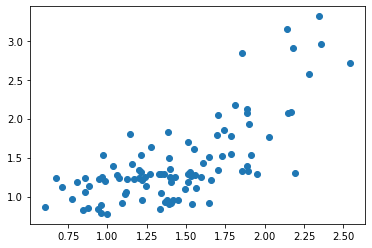

In [64]:
plt.scatter(Big5['Pred.Goals'], Big5['LeaguesPred'])

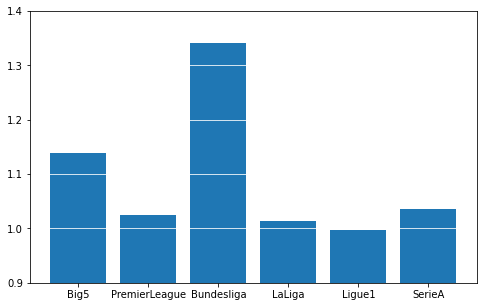

In [76]:
PremierLeague_rmse = pd.read_csv("Regression_Matrices/PremierLeague/PremierLeague_rmse_matrix_20211030-20211101.csv")
Bundesliga_rmse = pd.read_csv("Regression_Matrices/Bundesliga/Bundesliga_rmse_matrix_20211029-20211031.csv")
LaLiga_rmse = pd.read_csv("Regression_Matrices/LaLiga/LaLiga_rmse_matrix_20211030-20211101.csv")
Ligue1_rmse = pd.read_csv("Regression_Matrices/Ligue1/Ligue1_rmse_matrix_20211029-20211031.csv")
SerieA_rmse = pd.read_csv("Regression_Matrices/SerieA/SerieA_rmse_matrix_20211030-20211101.csv")
Big5_rmse = pd.read_csv("Regression_Matrices/Big5/Big5_rmse_matrix_20211029-20211101.csv")

plt.figure(figsize=(8,5))
plt.bar(height=[Big5_rmse['Min_RMSE'][0], PremierLeague_rmse['Min_RMSE'][0], Bundesliga_rmse['Min_RMSE'][0], LaLiga_rmse['Min_RMSE'][0], Ligue1_rmse['Min_RMSE'][0], SerieA_rmse['Min_RMSE'][0]],
        x=['Big5', 'PremierLeague', 'Bundesliga', 'LaLiga', 'Ligue1', 'SerieA'])
plt.ylim((.9,1.4))
plt.grid(axis='y', color='white')

In [ ]:
# Just a little something that makes it so you don't have to fill most of PlayerPointsAnalysis2 by hand

In [118]:
points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.000000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.000000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.000000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.000000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.000000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,20211031,MLS,0,Showdown,Caleb Stanko,CIN,M,3600,2.706441,72.922127,20.000000,y,5,1,4.107119,https://fbref.com/en/matches/e2f4882b/Philadel...,A,1.72,90.0,72.922127,0.0,CIN-MLS-20211031-Showdown,NaN,Matchup_Spreadsheets/MLS/PHI_CIN_20211031_spre...,8,FC Cincinnati,3.053676,2.556471,2.071370,2.556471,2.071370
3227,20211031,MLS,0,Showdown,Kyle Scott,CIN,M,3000,1.882579,56.000000,13.949483,b,1,2,1.539513,https://fbref.com/en/matches/e2f4882b/Philadel...,A,0.12,7.0,13.949483,0.0,CIN-MLS-20211031-Showdown,NaN,Matchup_Spreadsheets/MLS/PHI_CIN_20211031_spre...,8,FC Cincinnati,1.907767,6.600000,1.022962,6.600000,1.022962
3228,20211031,MLS,0,Showdown,Calvin Harris,CIN,M/F,3600,1.262741,75.000000,15.392533,b,1,6,1.699248,https://fbref.com/en/matches/e2f4882b/Philadel...,A,3.12,20.0,15.392533,0.0,CIN-MLS-20211031-Showdown,NaN,Matchup_Spreadsheets/MLS/PHI_CIN_20211031_spre...,8,FC Cincinnati,3.453537,3.600000,0.615701,3.600000,0.615701
3229,20211031,MLS,0,Showdown,Isaac Atanga,CIN,M/F,3600,0.622337,52.500000,7.696267,b,2,2,1.211469,https://fbref.com/en/matches/e2f4882b/Philadel...,A,0.62,20.0,7.696267,0.0,CIN-MLS-20211031-Showdown,NaN,Matchup_Spreadsheets/MLS/PHI_CIN_20211031_spre...,8,FC Cincinnati,2.762503,3.840000,0.328374,3.840000,0.328374


In [120]:
filenames = ['LaLiga/RVM_CEL_20211101',
             'PremierLeague/WOL_EVE_20211101',
             'MLS/SEA_LA_20211101']

for f in filenames:
    fname = 'Matchup_Spreadsheets/'+f+'_spreadsheet_finished.csv'
    home = f.split('/')[1].split('_')[0]
    away = f.split('/')[1].split('_')[1]
    date = int(f.split('/')[1].split('_')[2])
    league = f.split('/')[0]
    match_data = pd.read_csv(fname)
    sorter = [home, away]
    match_data['Team'] = match_data['Team'].astype('category')
    match_data['Team'].cat.set_categories(sorter, inplace=True)
    sorter = [home, away]
    match_data = match_data.sort_values(by=['Team', 'Pts_w_StartMins'], ascending=[True, False])
    match_data['Date'] = date
    match_data['League'] = league
    match_data['Interleague?'] = 0
    match_data['GameStyle'] = 'Showdown'
    match_data['HorA'] = ''
    for i in range(len(match_data)):
        if (match_data['Team'][i] == home): match_data['HorA'][i] = 'H'
        elif (match_data['Team'][i] == away): match_data['HorA'][i] = 'A'
    match_data['MatchReport_URL'] = ''
    tmp = match_data[['Date', 'League', 'Interleague?', 'GameStyle', 'Player', 'Team', 'Pos', 'Salary', 'Pts_w_StartMins',
                      'Start_Mins', 'Sub_Mins', 'Starting', 'starts', 'subs', 'Reg_Pts', 'MatchReport_URL', 'HorA']]
    points_data = pd.concat([points_data, tmp])
    
    #tmp = match_data

In [121]:
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.000000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.000000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.000000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.000000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.000000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20,20211101,MLS,0,Showdown,Sacha Kljestan,LA,M,8200,2.532786,73.500000,15.750660,b,2,5,4.646497,,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,20211101,MLS,0,Showdown,Niko Hamalainen,LA,D,5600,1.771763,85.571429,40.734466,b,7,1,3.722708,,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,20211101,MLS,0,Showdown,Dejan Joveljic,LA,F,7200,1.379025,87.500000,20.276712,b,2,5,3.790148,,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,20211101,MLS,0,Showdown,Daniel Steres,LA,D,3400,0.586437,90.000000,12.672945,b,2,1,1.189392,,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
points_data.to_csv('PlayerPointsAnalysis2.csv', index=False)

In [ ]:
<button type="button" class="button_b1oycxy6">2.52</button>

In [ ]:
<html lang="en" class=" customproperties webp webp-alpha webp-animation webp-lossless"><head><style> .webpush-window-body { height: 100%; min-height: 100%; padding: 0; margin: 0;}#webpush-window { position: absolute; text-align: center; width: 100%; left: 0; top: 50%; opacity: 0;}#webpush-window-image { height: 128px; margin-bottom: 10px;}#webpush-window-title { font-size: 22px; padding: 0 5px;}#webpush-window-text { color: #333333; margin-top: 15px; padding: 0 5px; line-height: 22px;}#webpush-custom-prompt { position: fixed; z-index: 9999999; width: 320px; max-width: 100%; padding: 10px; top: 0; left: 50%; margin-left: -170px; background-color: rgb(231,232,233); box-shadow: 0px 0px 6px #888888; color: #000000; font-family: 'Trebuchet MS', Helvetica, sans-serif;}#webpush-custom-prompt-image { width: 64px; position: absolute; top: 15px; left: 15px;}#webpush-custom-prompt-title { margin-left: 90px; margin-top: 4px; font-size: 13px; font-weight: bold; line-height: 18px;}#webpush-custom-prompt-text { font-size: 10px; margin-left: 90px; margin-top: 5px; line-height: 15px;}#webpush-custom-prompt-buttons { padding-top: 10px; padding-right: 10px; padding-bottom: 10px; float: right;}#webpush-custom-prompt-button1 { background:-webkit-gradient(linear, left top, left bottom, color-stop(0.05, #ffffff), color-stop(1, #f6f6f6)); background:-moz-linear-gradient(top, #ffffff 5%, #f6f6f6 100%); background:-webkit-linear-gradient(top, #ffffff 5%, #f6f6f6 100%); background:-o-linear-gradient(top, #ffffff 5%, #f6f6f6 100%); background:-ms-linear-gradient(top, #ffffff 5%, #f6f6f6 100%); background:linear-gradient(to bottom, #ffffff 5%, #f6f6f6 100%); filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#ffffff', endColorstr='#f6f6f6',GradientType=0); background-color:#ffffff; -moz-border-radius:6px; -webkit-border-radius:6px; border-radius:6px; border:1px solid #dcdcdc; display:inline-block; color:#666666; font-size:12px; padding:4px 24px; margin-right: 6px; cursor: default;}#webpush-custom-prompt-button2 { background:-webkit-gradient(linear, left top, left bottom, color-stop(0.05, #33bdef), color-stop(1, #019ad2)); background:-moz-linear-gradient(top, #33bdef 5%, #019ad2 100%); background:-webkit-linear-gradient(top, #33bdef 5%, #019ad2 100%); background:-o-linear-gradient(top, #33bdef 5%, #019ad2 100%); background:-ms-linear-gradient(top, #33bdef 5%, #019ad2 100%); background:linear-gradient(to bottom, #33bdef 5%, #019ad2 100%); filter:progid:DXImageTransform.Microsoft.gradient(startColorstr='#33bdef', endColorstr='#019ad2',GradientType=0); background-color:#33bdef; -moz-border-radius:6px; -webkit-border-radius:6px; border-radius:6px; border:1px solid #057fd0; display:inline-block; color:#ffffff; font-size:12px; padding:4px 24px; cursor: default;}#webpush-notification-center-open.webpush-notification-center-position-left { left: 16px;}#webpush-notification-center-open.webpush-notification-center-position-right { right: 16px;}#webpush-notification-center { position: fixed; z-index: 9999999; font-family: 'Trebuchet MS', Helvetica, sans-serif; display: none; overflow-y: auto;}#webpush-notification-center.webpush-notification-center-layout-panel { top: 0; bottom: 0; width: 300px; max-width: 90%;}#webpush-notification-center.webpush-notification-center-layout-popup { top: 20px; height: 400px; width: 300px; max-width: 90%; margin-right: 20px; margin-left: 20px;}#webpush-notification-center.webpush-notification-center-position-left { left: 0;}#webpush-notification-center.webpush-notification-center-position-right { right: 0;}#webpush-notification-center.webpush-notification-center-color-light { background: #ffffff; box-shadow: 0px 0px 6px #888888; color: #666666;}#webpush-notification-center.webpush-notification-center-color-dark { background: #555555; box-shadow: 0px 0px 6px #888888; color: #ffffff;}#webpush-notification-center-header { height: 40px; border-bottom: 1px solid #d9d9d9; position: relative;}#webpush-notification-center-subscription { padding: 0 50px 0 8px;}#webpush-notification-center-subscription-switch-container { float: left; padding-top: 15px;}#webpush-notification-center-subscription-status { float: left; font-size: 12px; line-height: 40px; letter-spacing: 0.1em;}#webpush-notification-center-subscription .webpush-onoffswitch { display: inline-block; margin-right: 16px; margin-left: 8px;}#webpush-notification-center-icon { position: absolute; top: 10px; left: 10px; width: 20px; height: 20px; background-repeat: no-repeat; background-position: center center; background-size: 20px 20px;}#webpush-notification-center-title { font-size: 13px; line-height: 40px; letter-spacing: 0.1em; text-align: center;}#webpush-notification-center-close { position: absolute; top: 14px; right: 8px; height: 12px; width: 12px; font-size: 12px; background-repeat: no-repeat; background-position: center center; background-size: 12px 12px; cursor: pointer;}#webpush-notification-center-list { overflow-x: hidden; overflow-y: auto; position: absolute; top: 41px; left: 0; right: 0; bottom: 0;}.webpush-notification-center-item { padding: 8px 8px; position: relative; font-size: 12px; min-height: 48px; cursor: pointer;}.webpush-notification-center-color-light .webpush-notification-center-item { border-bottom: 1px solid #f3f3f3;}.webpush-notification-center-color-dark .webpush-notification-center-item { border-bottom: 1px solid #808080;}.webpush-notification-center-color-light .webpush-notification-center-item:hover { background-color: #f3f3f3;}.webpush-notification-center-color-dark .webpush-notification-center-item:hover { background-color: #808080;}.webpush-notification-center-item-image { width: 48px; height: 48px; float: left;}.webpush-notification-center-item-title { padding-left: 58px; font-weight: bold;}.webpush-notification-center-item-title p { margin: 0px;}.webpush-notification-center-item-text { padding-left: 58px; margin-top: 4px;}.webpush-notification-center-item-text p { margin: 0px;}.webpush-notification-center-item-date { padding-left: 58px; margin-top: 3px; font-size: 11px; color: #b7b7b7;}.webpush-notification-center-item-webinbox-card { padding: 0;}.webpush-notification-center-item-webinbox-card .webpush-notification-center-item-image { width: 100%; height: auto; float: none; margin: 0px; padding: 0px;}.webpush-notification-center-item-webinbox-card .webpush-notification-center-item-title { padding: 5px 7px; font-weight: bold;}.webpush-notification-center-item-webinbox-card .webpush-notification-center-item-text-container { padding: 0px 7px 5px 7px; margin: 0px;}.webpush-notification-center-item-webinbox-card .webpush-notification-center-item-text { padding: 5px 0px 0px 0px; margin-top: 0px;}.webpush-notification-center-item-webinbox-card .webpush-notification-center-item-date { display: none;}#webpush-notification-center-loader { text-align: center; padding: 8px; height: 15px;}#webpush-notification-center-title-loader { text-align: center; padding-top: 14px; height: 40px;}#webpush-notification-center-placeholder { font-size: 12px; line-height: 30px; padding: 5px 16px;}#webpush-notification-center-load-more { font-size: 12px; line-height: 30px; text-align: center; cursor: pointer;}.webpush-notification-center-color-light #webpush-notification-center-load-more { border-bottom: 1px solid #f3f3f3;}.webpush-notification-center-color-dark #webpush-notification-center-load-more { border-bottom: 1px solid #808080;}.webpush-notification-center-color-light #webpush-notification-center-load-more:hover { background-color: #f3f3f3;}.webpush-notification-center-color-dark #webpush-notification-center-load-more:hover { background-color: #808080;}#webpush-notification-center-open { position: fixed; z-index: 9999999; top: 20px; height: 60px; width: 60px; border-radius: 50%; cursor: pointer; text-align: center; line-height: 60px; background-size: 30px 30px; box-shadow: 0 4px 8px rgba(0,0,0,0.16), 0 2px 4px rgba(0,0,0,0.2); transition: 0.7s ease;}#webpush-notification-center-open:hover { box-shadow: 0 7px 14px rgba(0,0,0,0.16), 0 5px 10px rgba(0,0,0,0.2); transition: 0.7s ease; transform-origin: center;}#webpush-notification-center-open[badge-count]:after { position: absolute; right: -3px; top: -3px; content: attr(badge-count); font-size: 12px; padding: 5px; border-radius: 50%; line-height: 12px; color: #ffffff; background: #ed1c25; text-align: center; min-width: 12px; font-weight: bold;}#webpush-notification-center-open.webpush-notification-center-color-light { background-color: #1d87c8;}#webpush-notification-center-open.webpush-notification-center-color-light:hover { background-color: #2298e1;}#webpush-notification-center-open.webpush-notification-center-color-dark { background-color: #555555;}#webpush-notification-center-open.webpush-notification-center-color-dark:hover { background-color: #5a606e;}#webpush-notification-center-open.webpush-notification-center-color-custom { background-color: #1d87c8;}#webpush-notification-center-open.webpush-notification-center-color-custom:hover { background-color: #2298e1;}#webpush-local-notification-stack { position: fixed; top: 20px; right: 20px; z-index: 9999999; margin-left: 20px;}.webpush-local-notification { background: #ffffff; max-width: 370px; width: 100%; min-width: 250px; box-shadow: 0px 0px 6px #888888; position: relative; -webkit-transition: opacity 0.2s ease-in-out; -moz-transition: opacity 0.2s ease-in-out; -ms-transition: opacity 0.2s ease-in-out; -o-transition: opacity 0.2s ease-in-out; transition: opacity 0.2s ease-in-out; font-family: 'Trebuchet MS', Helvetica, sans-serif; color: #666666; margin-bottom: 10px; min-height: 80px; cursor: default;}.webpush-local-notification-close { position: absolute; top: 8px; right: 8px; cursor: pointer;}.webpush-local-notification-image { width: 80px; height: 80px; float: left;}.webpush-local-notification-title { padding-left: 95px; padding-top: 10px; padding-right: 35px; font-size: 14px; line-height: 20px; color: #444444;}.webpush-local-notification-text { padding-left: 95px; padding-top: 8px; padding-right: 10px; padding-bottom: 10px; font-size: 13px; line-height: 18px;}.webpush-onoffswitch-container { line-height: 10px;}.webpush-onoffswitch { position: relative; width: 30px; -webkit-user-select:none; -moz-user-select:none; -ms-user-select: none;}.webpush-onoffswitch-checkbox { display: none;}.webpush-onoffswitch-label { display: block; overflow: hidden; cursor: pointer; height: 10px; padding: 0; line-height: 10px; border-radius: 16px; background-color: rgba(158,158,158,0.5);}.webpush-onoffswitch-label:before { content: ''; display: block; width: 16px; margin: -3px; background-color: rgb(158,158,158); position: absolute; top: 0; bottom: 0; right: 18px; border-radius: 16px;}.webpush-onoffswitch-checkbox:checked + .webpush-onoffswitch-label { background-color: rgba(47,169,214,0.5);}.webpush-onoffswitch-checkbox:checked + .webpush-onoffswitch-label .webpush-onoffswitch-inner { margin-left: 0;}.webpush-onoffswitch-checkbox:checked + .webpush-onoffswitch-label:before { right: 0; background-color: rgb(47,169,214); box-shadow: none;}.webpush-onoffswitch-tooltip { display: none; position: absolute; min-width: 50px; max-width: 200px; min-height: 16px; max-height: 200px; background: rgba(0, 0, 0, .8); color: #fff; padding: 8px; border-radius: 2px; z-index: 3000; line-height: 16px; font-size: 12px; opacity: 0.9; -webkit-transition: opacity 75ms linear; -moz-transition: opacity 75ms linear; -ms-transition: opacity 75ms linear; transition: opacity 75ms linear; top: 32px; left: 15px;}.webpush-reset { animation: none; animation-delay: 0s; animation-direction: normal; animation-duration: 0s; animation-fill-mode: none; animation-iteration-count: 1; animation-name: none; animation-play-state: running; animation-timing-function: ease; backface-visibility: visible; background: 0; background-attachment: scroll; background-clip: border-box; background-color: transparent; background-image: none; background-origin: padding-box; background-position: 0 0; background-position-x: 0; background-position-y: 0; background-repeat: repeat; background-size: auto auto; border: 0; border-style: none; border-width: medium; border-color: inherit; border-bottom: 0; border-bottom-color: inherit; border-bottom-left-radius: 0; border-bottom-right-radius: 0; border-bottom-style: none; border-bottom-width: medium; border-collapse: separate; border-image: none; border-left: 0; border-left-color: inherit; border-left-style: none; border-left-width: medium; border-radius: 0; border-right: 0; border-right-color: inherit; border-right-style: none; border-right-width: medium; border-spacing: 0; border-top: 0; border-top-color: inherit; border-top-left-radius: 0; border-top-right-radius: 0; border-top-style: none; border-top-width: medium; bottom: auto; box-shadow: none; box-sizing: content-box; caption-side: top; clear: none; clip: auto; color: inherit; columns: auto; column-count: auto; column-fill: balance; column-gap: normal; column-rule: medium none currentColor; column-rule-color: currentColor; column-rule-style: none; column-rule-width: 0; column-span: 1; column-width: auto; content: normal; counter-increment: none; counter-reset: none; cursor: auto; direction: ltr; display: inline; empty-cells: show; float: none; /*font: normal;*/ font-family: inherit; font-size: medium; font-style: normal; font-variant: normal; font-weight: normal; height: auto; hyphens: none; left: auto; letter-spacing: normal; line-height: normal; list-style: none; list-style-image: none; list-style-position: outside; list-style-type: disc; margin: 0; margin-bottom: 0; margin-left: 0; margin-right: 0; margin-top: 0; max-height: none; max-width: none; min-height: 0; min-width: 0; opacity: 1; orphans: 0; outline: 0; outline-color: invert; outline-style: none; outline-width: medium; overflow: visible; overflow-x: visible; overflow-y: visible; padding: 0; padding-bottom: 0; padding-left: 0; padding-right: 0; padding-top: 0; page-break-after: auto; page-break-before: auto; page-break-inside: auto; perspective: none; perspective-origin: 50% 50%; position: static; right: auto; tab-size: 8; table-layout: auto; text-align: inherit; text-align-last: auto; text-decoration: none; text-decoration-line: none; text-decoration-style: solid; text-indent: 0; text-shadow: none; text-transform: none; top: auto; transform: none; transform-style: flat; transition: none; transition-delay: 0s; transition-duration: 0s; transition-property: none; transition-timing-function: ease; unicode-bidi: normal; vertical-align: baseline; visibility: visible; white-space: normal; widows: 0; width: auto; word-spacing: normal; z-index: auto;}.webpush-loader { display: inline-block; position: relative; vertical-align: middle; width: 48px; height: 16px;}.webpush-loader div { position: absolute; top: 3px; left: 21px; width: 4px; height: 4px; background-color: #666666; -webkit-border-radius: 2px; border-radius: 2px; background-clip: padding-box; -webkit-animation: growDot 1s linear .15s infinite; -moz-animation: growDot 1s linear .15s infinite; -ms-animation: growDot 1s linear .15s infinite; -o-animation: growDot 1s linear .15s infinite; animation: growDot 1s linear .15s infinite;}.webpush-loader div:before { content: ''; position: absolute; top: 0; left: -15px; width: 4px; height: 4px; background-color: #666666; -webkit-border-radius: 2px; border-radius: 2px; background-clip: padding-box; -webkit-animation: growDot 1s linear 0s infinite; -moz-animation: growDot 1s linear 0s infinite; -ms-animation: growDot 1s linear 0s infinite; -o-animation: growDot 1s linear 0s infinite; animation: growDot 1s linear 0s infinite;}.webpush-loader div:after { content: ''; position: absolute; top: 0; left: 15px; width: 4px; height: 4px; background-color: #666666; -webkit-border-radius: 2px; border-radius: 2px; background-clip: padding-box; -webkit-animation: growDot 1s linear .3s infinite; -moz-animation: growDot 1s linear .3s infinite; -ms-animation: growDot 1s linear .3s infinite; -o-animation: growDot 1s linear .3s infinite; animation: growDot 1s linear .3s infinite;}@-webkit-keyframes growDot { 0% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=70)';  filter: alpha(opacity=70);  opacity: 0.7;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; } 25% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=100)';  filter: alpha(opacity=100);  opacity: 1;  -webkit-box-shadow: 0px 0px 0px 2px #666666;  box-shadow: 0px 0px 0px 2px #666666; } 50% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=70)';  filter: alpha(opacity=70);  opacity: 0.7;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; } 100% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=60)';  filter: alpha(opacity=60);  opacity: 0.6;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; }}@keyframes growDot { 0% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=70)';  filter: alpha(opacity=70);  opacity: 0.7;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; } 25% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=100)';  filter: alpha(opacity=100);  opacity: 1;  -webkit-box-shadow: 0px 0px 0px 2px #666666;  box-shadow: 0px 0px 0px 2px #666666; } 50% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=70)';  filter: alpha(opacity=70);  opacity: 0.7;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; } 100% {  -ms-filter: 'progid:DXImageTransform.Microsoft.Alpha(Opacity=60)';  filter: alpha(opacity=60);  opacity: 0.6;  -webkit-box-shadow: 0px 0px 0px 0px #666666;  box-shadow: 0px 0px 0px 0px #666666; }}.webpush-balloon { background-repeat: no-repeat; background-position: center center; background-size: 100% 100%;}.webpush-balloon-light, .webpush-balloon-dark, .webpush-balloon-custom { background-image: url('data:image/svg+xml;base64,PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZGluZz0iVVRGLTgiIHN0YW5kYWxvbmU9Im5vIj8+CjwhRE9DVFlQRSBzdmcgUFVCTElDICItLy9XM0MvL0RURCBTVkcgMS4xLy9FTiIgImh0dHA6Ly93d3cudzMub3JnL0dyYXBoaWNzL1NWRy8xLjEvRFREL3N2ZzExLmR0ZCI+Cjxzdmcgd2lkdGg9IjEwMCUiIGhlaWdodD0iMTAwJSIgdmlld0JveD0iMCAwIDE1MCAxNTAiIHZlcnNpb249IjEuMSIgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzIwMDAvc3ZnIiB4bWxuczp4bGluaz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94bGluayIgeG1sOnNwYWNlPSJwcmVzZXJ2ZSIgc3R5bGU9ImZpbGwtcnVsZTpldmVub2RkO2NsaXAtcnVsZTpldmVub2RkO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2UtbWl0ZXJsaW1pdDoxLjQxNDIxOyI+CiAgICA8ZyBpZD0iWE1MSURfNDZfIiB0cmFuc2Zvcm09Im1hdHJpeCgxLjEyOTEyLDAsMCwxLjEyOTEyLDQ3OS43ODgsLTI0Mi4yODIpIj4KICAgICAgICA8cGF0aCBkPSJNLTM1OCwzNDFDLTM1MSwzNDEgLTM0Ni4yLDMzNSAtMzQ2LjIsMzI4TC0zNzAuMywzMjhDLTM3MC4zLDMzNSAtMzY0LDM0MSAtMzU4LDM0MVoiIHN0eWxlPSJmaWxsOndoaXRlO2ZpbGwtcnVsZTpub256ZXJvOyIvPgogICAgPC9nPgogICAgPGcgaWQ9IlhNTElEXzQ3XyIgdHJhbnNmb3JtPSJtYXRyaXgoMS4xMjkxMiwwLDAsMS4xMjkxMiw0NzkuNzg4LC0yNDIuMjgyKSI+CiAgICAgICAgPHBhdGggZD0iTS0zMTguOSwzMDUuOEMtMzE4LjYsMzA1LjggLTMxOCwzMDUuNiAtMzE4LDMwNS4zTC0zMTgsMjczLjhDLTMxOCwyNTQuNyAtMzMyLDIzOC43IC0zNDksMjM0LjdMLTM0OSwyMjkuOEMtMzQ5LDIyNSAtMzUzLjEsMjIxIC0zNTgsMjIxQy0zNjIuOSwyMjEgLTM2NywyMjUgLTM2NywyMjkuOEwtMzY3LDIzNC42Qy0zODUsMjM4LjYgLTM5OCwyNTQuNiAtMzk4LDI3My43TC0zOTgsMzA1LjJDLTM5OCwzMDUuNSAtMzk3LjksMzA1LjcgLTM5Ny42LDMwNS43TC00MTAsMzE3TC00MTAsMzI0TC0zMDcsMzI0TC0zMDcsMzE3TC0zMTguOSwzMDUuOFoiIHN0eWxlPSJmaWxsOndoaXRlO2ZpbGwtcnVsZTpub256ZXJvOyIvPgogICAgPC9nPgo8L3N2Zz4K');}.webpush-clearfix { clear: both;}.webpush-swal2-title p { margin: 0;} </style><style> @-webkit-keyframes webpush-swal2-show{0%{-webkit-transform:scale(.7);transform:scale(.7)}45%{-webkit-transform:scale(1.05);transform:scale(1.05)}80%{-webkit-transform:scale(.95);transform:scale(.95)}100%{-webkit-transform:scale(1);transform:scale(1)}}@keyframes webpush-swal2-show{0%{-webkit-transform:scale(.7);transform:scale(.7)}45%{-webkit-transform:scale(1.05);transform:scale(1.05)}80%{-webkit-transform:scale(.95);transform:scale(.95)}100%{-webkit-transform:scale(1);transform:scale(1)}}@-webkit-keyframes webpush-swal2-hide{0%{-webkit-transform:scale(1);transform:scale(1);opacity:1}100%{-webkit-transform:scale(.5);transform:scale(.5);opacity:0}}@keyframes webpush-swal2-hide{0%{-webkit-transform:scale(1);transform:scale(1);opacity:1}100%{-webkit-transform:scale(.5);transform:scale(.5);opacity:0}}@-webkit-keyframes webpush-swal2-animate-success-line-tip{0%{top:1.1875em;left:.0625em;width:0}54%{top:1.0625em;left:.125em;width:0}70%{top:2.1875em;left:-.375em;width:3.125em}84%{top:3em;left:1.3125em;width:1.0625em}100%{top:2.8125em;left:.875em;width:1.5625em}}@keyframes webpush-swal2-animate-success-line-tip{0%{top:1.1875em;left:.0625em;width:0}54%{top:1.0625em;left:.125em;width:0}70%{top:2.1875em;left:-.375em;width:3.125em}84%{top:3em;left:1.3125em;width:1.0625em}100%{top:2.8125em;left:.875em;width:1.5625em}}@-webkit-keyframes webpush-swal2-animate-success-line-long{0%{top:3.375em;right:2.875em;width:0}65%{top:3.375em;right:2.875em;width:0}84%{top:2.1875em;right:0;width:3.4375em}100%{top:2.375em;right:.5em;width:2.9375em}}@keyframes webpush-swal2-animate-success-line-long{0%{top:3.375em;right:2.875em;width:0}65%{top:3.375em;right:2.875em;width:0}84%{top:2.1875em;right:0;width:3.4375em}100%{top:2.375em;right:.5em;width:2.9375em}}@-webkit-keyframes webpush-swal2-rotate-success-circular-line{0%{-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}5%{-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}12%{-webkit-transform:rotate(-405deg);transform:rotate(-405deg)}100%{-webkit-transform:rotate(-405deg);transform:rotate(-405deg)}}@keyframes webpush-swal2-rotate-success-circular-line{0%{-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}5%{-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}12%{-webkit-transform:rotate(-405deg);transform:rotate(-405deg)}100%{-webkit-transform:rotate(-405deg);transform:rotate(-405deg)}}@-webkit-keyframes webpush-swal2-animate-error-x-mark{0%{margin-top:1.625em;-webkit-transform:scale(.4);transform:scale(.4);opacity:0}50%{margin-top:1.625em;-webkit-transform:scale(.4);transform:scale(.4);opacity:0}80%{margin-top:-.375em;-webkit-transform:scale(1.15);transform:scale(1.15)}100%{margin-top:0;-webkit-transform:scale(1);transform:scale(1);opacity:1}}@keyframes webpush-swal2-animate-error-x-mark{0%{margin-top:1.625em;-webkit-transform:scale(.4);transform:scale(.4);opacity:0}50%{margin-top:1.625em;-webkit-transform:scale(.4);transform:scale(.4);opacity:0}80%{margin-top:-.375em;-webkit-transform:scale(1.15);transform:scale(1.15)}100%{margin-top:0;-webkit-transform:scale(1);transform:scale(1);opacity:1}}@-webkit-keyframes webpush-swal2-animate-error-icon{0%{-webkit-transform:rotateX(100deg);transform:rotateX(100deg);opacity:0}100%{-webkit-transform:rotateX(0);transform:rotateX(0);opacity:1}}@keyframes webpush-swal2-animate-error-icon{0%{-webkit-transform:rotateX(100deg);transform:rotateX(100deg);opacity:0}100%{-webkit-transform:rotateX(0);transform:rotateX(0);opacity:1}}body.webpush-swal2-toast-shown.webpush-swal2-has-input>.webpush-swal2-container>.webpush-swal2-toast{flex-direction:column;align-items:stretch}body.webpush-swal2-toast-shown.webpush-swal2-has-input>.webpush-swal2-container>.webpush-swal2-toast .webpush-swal2-actions{flex:1;align-self:stretch;justify-content:flex-end;height:2.2em}body.webpush-swal2-toast-shown.webpush-swal2-has-input>.webpush-swal2-container>.webpush-swal2-toast .webpush-swal2-loading{justify-content:center}body.webpush-swal2-toast-shown.webpush-swal2-has-input>.webpush-swal2-container>.webpush-swal2-toast .webpush-swal2-input{height:2em;margin:.3125em auto;font-size:1em}body.webpush-swal2-toast-shown.webpush-swal2-has-input>.webpush-swal2-container>.webpush-swal2-toast .webpush-swal2-validationerror{font-size:1em}body.webpush-swal2-toast-shown>.webpush-swal2-container{position:fixed;background-color:transparent}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-shown{background-color:transparent}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-top{top:0;right:auto;bottom:auto;left:50%;-webkit-transform:translateX(-50%);transform:translateX(-50%)}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-top-end,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-top-right{top:0;right:0;bottom:auto;left:auto}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-top-left,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-top-start{top:0;right:auto;bottom:auto;left:0}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-center-left,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-center-start{top:50%;right:auto;bottom:auto;left:0;-webkit-transform:translateY(-50%);transform:translateY(-50%)}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-center{top:50%;right:auto;bottom:auto;left:50%;-webkit-transform:translate(-50%,-50%);transform:translate(-50%,-50%)}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-center-end,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-center-right{top:50%;right:0;bottom:auto;left:auto;-webkit-transform:translateY(-50%);transform:translateY(-50%)}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-bottom-left,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-bottom-start{top:auto;right:auto;bottom:0;left:0}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-bottom{top:auto;right:auto;bottom:0;left:50%;-webkit-transform:translateX(-50%);transform:translateX(-50%)}body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-bottom-end,body.webpush-swal2-toast-shown>.webpush-swal2-container.webpush-swal2-bottom-right{top:auto;right:0;bottom:0;left:auto}.webpush-swal2-popup.webpush-swal2-toast{flex-direction:row;align-items:center;width:auto;padding:.625em;box-shadow:0 0 .625em #d9d9d9;overflow-y:hidden}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-header{flex-direction:row}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-title{justify-content:flex-start;margin:0 .6em;font-size:1em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-close{position:initial}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-content{justify-content:flex-start;font-size:1em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon{width:2em;min-width:2em;height:2em;margin:0}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon-text{font-size:2em;font-weight:700;line-height:1em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon.webpush-swal2-success .webpush-swal2-success-ring{width:2em;height:2em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line]{top:.875em;width:1.375em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line][class$=left]{left:.3125em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line][class$=right]{right:.3125em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-actions{height:auto;margin:0 .3125em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-styled{margin:0 .3125em;padding:.3125em .625em;font-size:1em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-styled:focus{box-shadow:0 0 0 .0625em #fff,0 0 0 .125em rgba(50,100,150,.4)}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success{border-color:#a5dc86}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-circular-line]{position:absolute;width:2em;height:2.8125em;-webkit-transform:rotate(45deg);transform:rotate(45deg);border-radius:50%}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-circular-line][class$=left]{top:-.25em;left:-.9375em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg);-webkit-transform-origin:2em 2em;transform-origin:2em 2em;border-radius:4em 0 0 4em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-circular-line][class$=right]{top:-.25em;left:.9375em;-webkit-transform-origin:0 2em;transform-origin:0 2em;border-radius:0 4em 4em 0}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success .webpush-swal2-success-ring{width:2em;height:2em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success .webpush-swal2-success-fix{top:0;left:.4375em;width:.4375em;height:2.6875em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-line]{height:.3125em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-line][class$=tip]{top:1.125em;left:.1875em;width:.75em}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-success [class^=webpush-swal2-success-line][class$=long]{top:.9375em;right:.1875em;width:1.375em}.webpush-swal2-popup.webpush-swal2-toast.webpush-swal2-show{-webkit-animation:showSweetToast .5s;animation:showSweetToast .5s}.webpush-swal2-popup.webpush-swal2-toast.webpush-swal2-hide{-webkit-animation:hideSweetToast .2s forwards;animation:hideSweetToast .2s forwards}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-animate-success-icon .webpush-swal2-success-line-tip{-webkit-animation:animate-toast-success-tip .75s;animation:animate-toast-success-tip .75s}.webpush-swal2-popup.webpush-swal2-toast .webpush-swal2-animate-success-icon .webpush-swal2-success-line-long{-webkit-animation:animate-toast-success-long .75s;animation:animate-toast-success-long .75s}@-webkit-keyframes showSweetToast{0%{-webkit-transform:translateY(-.625em) rotateZ(2deg);transform:translateY(-.625em) rotateZ(2deg);opacity:0}33%{-webkit-transform:translateY(0) rotateZ(-2deg);transform:translateY(0) rotateZ(-2deg);opacity:.5}66%{-webkit-transform:translateY(.3125em) rotateZ(2deg);transform:translateY(.3125em) rotateZ(2deg);opacity:.7}100%{-webkit-transform:translateY(0) rotateZ(0);transform:translateY(0) rotateZ(0);opacity:1}}@keyframes showSweetToast{0%{-webkit-transform:translateY(-.625em) rotateZ(2deg);transform:translateY(-.625em) rotateZ(2deg);opacity:0}33%{-webkit-transform:translateY(0) rotateZ(-2deg);transform:translateY(0) rotateZ(-2deg);opacity:.5}66%{-webkit-transform:translateY(.3125em) rotateZ(2deg);transform:translateY(.3125em) rotateZ(2deg);opacity:.7}100%{-webkit-transform:translateY(0) rotateZ(0);transform:translateY(0) rotateZ(0);opacity:1}}@-webkit-keyframes hideSweetToast{0%{opacity:1}33%{opacity:.5}100%{-webkit-transform:rotateZ(1deg);transform:rotateZ(1deg);opacity:0}}@keyframes hideSweetToast{0%{opacity:1}33%{opacity:.5}100%{-webkit-transform:rotateZ(1deg);transform:rotateZ(1deg);opacity:0}}@-webkit-keyframes animate-toast-success-tip{0%{top:.5625em;left:.0625em;width:0}54%{top:.125em;left:.125em;width:0}70%{top:.625em;left:-.25em;width:1.625em}84%{top:1.0625em;left:.75em;width:.5em}100%{top:1.125em;left:.1875em;width:.75em}}@keyframes animate-toast-success-tip{0%{top:.5625em;left:.0625em;width:0}54%{top:.125em;left:.125em;width:0}70%{top:.625em;left:-.25em;width:1.625em}84%{top:1.0625em;left:.75em;width:.5em}100%{top:1.125em;left:.1875em;width:.75em}}@-webkit-keyframes animate-toast-success-long{0%{top:1.625em;right:1.375em;width:0}65%{top:1.25em;right:.9375em;width:0}84%{top:.9375em;right:0;width:1.125em}100%{top:.9375em;right:.1875em;width:1.375em}}@keyframes animate-toast-success-long{0%{top:1.625em;right:1.375em;width:0}65%{top:1.25em;right:.9375em;width:0}84%{top:.9375em;right:0;width:1.125em}100%{top:.9375em;right:.1875em;width:1.375em}}body.webpush-swal2-shown:not(.webpush-swal2-no-backdrop):not(.webpush-swal2-toast-shown),html.webpush-swal2-shown:not(.webpush-swal2-no-backdrop):not(.webpush-swal2-toast-shown){height:auto;overflow-y:hidden}body.webpush-swal2-no-backdrop .webpush-swal2-shown{top:auto;right:auto;bottom:auto;left:auto;background-color:transparent}body.webpush-swal2-no-backdrop .webpush-swal2-shown>.webpush-swal2-modal{box-shadow:0 0 10px rgba(0,0,0,.4)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-top{top:0;left:50%;-webkit-transform:translateX(-50%);transform:translateX(-50%)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-top-left,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-top-start{top:0;left:0}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-top-end,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-top-right{top:0;right:0}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-center{top:50%;left:50%;-webkit-transform:translate(-50%,-50%);transform:translate(-50%,-50%)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-center-left,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-center-start{top:50%;left:0;-webkit-transform:translateY(-50%);transform:translateY(-50%)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-center-end,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-center-right{top:50%;right:0;-webkit-transform:translateY(-50%);transform:translateY(-50%)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-bottom{bottom:0;left:50%;-webkit-transform:translateX(-50%);transform:translateX(-50%)}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-bottom-left,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-bottom-start{bottom:0;left:0}body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-bottom-end,body.webpush-swal2-no-backdrop .webpush-swal2-shown.webpush-swal2-bottom-right{right:0;bottom:0}.webpush-swal2-container{display:flex;position:fixed;top:0;right:0;bottom:0;left:0;flex-direction:row;align-items:center;justify-content:center;padding:10px;background-color:transparent;z-index:1060;overflow-x:hidden;-webkit-overflow-scrolling:touch}.webpush-swal2-container.webpush-swal2-top{align-items:flex-start}.webpush-swal2-container.webpush-swal2-top-left,.webpush-swal2-container.webpush-swal2-top-start{align-items:flex-start;justify-content:flex-start}.webpush-swal2-container.webpush-swal2-top-end,.webpush-swal2-container.webpush-swal2-top-right{align-items:flex-start;justify-content:flex-end}.webpush-swal2-container.webpush-swal2-center{align-items:center}.webpush-swal2-container.webpush-swal2-center-left,.webpush-swal2-container.webpush-swal2-center-start{align-items:center;justify-content:flex-start}.webpush-swal2-container.webpush-swal2-center-end,.webpush-swal2-container.webpush-swal2-center-right{align-items:center;justify-content:flex-end}.webpush-swal2-container.webpush-swal2-bottom{align-items:flex-end}.webpush-swal2-container.webpush-swal2-bottom-left,.webpush-swal2-container.webpush-swal2-bottom-start{align-items:flex-end;justify-content:flex-start}.webpush-swal2-container.webpush-swal2-bottom-end,.webpush-swal2-container.webpush-swal2-bottom-right{align-items:flex-end;justify-content:flex-end}.webpush-swal2-container.webpush-swal2-grow-fullscreen>.webpush-swal2-modal{display:flex!important;flex:1;align-self:stretch;justify-content:center}.webpush-swal2-container.webpush-swal2-grow-row>.webpush-swal2-modal{display:flex!important;flex:1;align-content:center;justify-content:center}.webpush-swal2-container.webpush-swal2-grow-column{flex:1;flex-direction:column}.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-bottom,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-center,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-top{align-items:center}.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-bottom-left,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-bottom-start,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-center-left,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-center-start,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-top-left,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-top-start{align-items:flex-start}.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-bottom-end,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-bottom-right,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-center-end,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-center-right,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-top-end,.webpush-swal2-container.webpush-swal2-grow-column.webpush-swal2-top-right{align-items:flex-end}.webpush-swal2-container.webpush-swal2-grow-column>.webpush-swal2-modal{display:flex!important;flex:1;align-content:center;justify-content:center}.webpush-swal2-container:not(.webpush-swal2-top):not(.webpush-swal2-top-start):not(.webpush-swal2-top-end):not(.webpush-swal2-top-left):not(.webpush-swal2-top-right):not(.webpush-swal2-center-start):not(.webpush-swal2-center-end):not(.webpush-swal2-center-left):not(.webpush-swal2-center-right):not(.webpush-swal2-bottom):not(.webpush-swal2-bottom-start):not(.webpush-swal2-bottom-end):not(.webpush-swal2-bottom-left):not(.webpush-swal2-bottom-right)>.webpush-swal2-modal{margin:auto}@media all and (-ms-high-contrast:none),(-ms-high-contrast:active){.webpush-swal2-container .webpush-swal2-modal{margin:0!important}}.webpush-swal2-container.webpush-swal2-fade{transition:background-color .1s}.webpush-swal2-container.webpush-swal2-shown{background-color:rgba(0,0,0,.4)}.webpush-swal2-popup{display:none;position:relative;flex-direction:column;justify-content:center;width:32em;max-width:100%;padding:1.25em;border-radius:.3125em;background:#fff;font-family:inherit;font-size:1rem;box-sizing:border-box}.webpush-swal2-popup:focus{outline:0}.webpush-swal2-popup.webpush-swal2-loading{overflow-y:hidden}.webpush-swal2-popup .webpush-swal2-header{display:flex;flex-direction:column;align-items:center}.webpush-swal2-popup .webpush-swal2-title{display:block;position:relative;max-width:100%;margin:0 0 .4em;padding:0;color:#595959;font-size:1.875em;font-weight:600;text-align:center;text-transform:none;word-wrap:break-word}.webpush-swal2-popup .webpush-swal2-actions{align-items:center;justify-content:center;margin:1.25em auto 0}.webpush-swal2-popup .webpush-swal2-actions:not(.webpush-swal2-loading) .webpush-swal2-styled[disabled]{opacity:.4}.webpush-swal2-popup .webpush-swal2-actions:not(.webpush-swal2-loading) .webpush-swal2-styled:hover{background-image:linear-gradient(rgba(0,0,0,.1),rgba(0,0,0,.1))}.webpush-swal2-popup .webpush-swal2-actions:not(.webpush-swal2-loading) .webpush-swal2-styled:active{background-image:linear-gradient(rgba(0,0,0,.2),rgba(0,0,0,.2))}.webpush-swal2-popup .webpush-swal2-actions.webpush-swal2-loading .webpush-swal2-styled.webpush-swal2-confirm{width:2.5em;height:2.5em;margin:.46875em;padding:0;border:.25em solid transparent;border-radius:100%;border-color:transparent;background-color:transparent!important;color:transparent;cursor:default;box-sizing:border-box;-webkit-animation:webpush-swal2-rotate-loading 1.5s linear 0s infinite normal;animation:webpush-swal2-rotate-loading 1.5s linear 0s infinite normal;-webkit-user-select:none;-moz-user-select:none;-ms-user-select:none;user-select:none}.webpush-swal2-popup .webpush-swal2-actions.webpush-swal2-loading .webpush-swal2-styled.webpush-swal2-cancel{margin-right:30px;margin-left:30px}.webpush-swal2-popup .webpush-swal2-actions.webpush-swal2-loading :not(.webpush-swal2-styled).webpush-swal2-confirm::after{display:inline-block;width:15px;height:15px;margin-left:5px;border:3px solid #999;border-radius:50%;border-right-color:transparent;box-shadow:1px 1px 1px #fff;content:'';-webkit-animation:webpush-swal2-rotate-loading 1.5s linear 0s infinite normal;animation:webpush-swal2-rotate-loading 1.5s linear 0s infinite normal}.webpush-swal2-popup .webpush-swal2-styled{min-width:auto;height:auto;margin:0 .3125em;padding:.625em 2em;font-weight:500;box-shadow:none}.webpush-swal2-popup .webpush-swal2-styled:not([disabled]){cursor:pointer}.webpush-swal2-popup .webpush-swal2-styled.webpush-swal2-confirm{border:0;border-radius:.25em;background:initial;background-color:#3085d6;color:#fff;font-size:1.0625em}.webpush-swal2-popup .webpush-swal2-styled.webpush-swal2-cancel{border:0;border-radius:.25em;background:initial;background-color:#aaa;color:#fff;font-size:1.0625em}.webpush-swal2-popup .webpush-swal2-styled:focus{outline:0;box-shadow:0 0 0 2px #fff,0 0 0 4px rgba(50,100,150,.4)}.webpush-swal2-popup .webpush-swal2-styled::-moz-focus-inner{border:0}.webpush-swal2-popup .webpush-swal2-footer{justify-content:center;margin:1.25em 0 0;padding-top:1em;border-top:1px solid #eee;color:#545454;font-size:1em}.webpush-swal2-popup .webpush-swal2-image{max-width:100%;margin:1.25em auto}.webpush-swal2-popup .webpush-swal2-close{min-width:auto;height:auto;position:absolute;top:0;right:0;justify-content:center;width:1.2em;height:1.2em;padding:0;transition:color .1s ease-out;border:none;border-radius:0;background:0 0;color:#ccc;font-family:serif;font-size:2.5em;line-height:1.2;cursor:pointer;overflow:hidden}.webpush-swal2-popup .webpush-swal2-close:hover{-webkit-transform:none;transform:none;color:#f27474}.webpush-swal2-popup>.webpush-swal2-checkbox,.webpush-swal2-popup>.webpush-swal2-file,.webpush-swal2-popup>.webpush-swal2-input,.webpush-swal2-popup>.webpush-swal2-radio,.webpush-swal2-popup>.webpush-swal2-select,.webpush-swal2-popup>.webpush-swal2-textarea{display:none}.webpush-swal2-popup .webpush-swal2-content{justify-content:center;margin:0;padding:0;color:#545454;font-size:1.125em;font-weight:300;line-height:normal;word-wrap:break-word}.webpush-swal2-popup #webpush-swal2-content{text-align:center}.webpush-swal2-popup .webpush-swal2-checkbox,.webpush-swal2-popup .webpush-swal2-file,.webpush-swal2-popup .webpush-swal2-input,.webpush-swal2-popup .webpush-swal2-radio,.webpush-swal2-popup .webpush-swal2-select,.webpush-swal2-popup .webpush-swal2-textarea{margin:1em auto}.webpush-swal2-popup .webpush-swal2-file,.webpush-swal2-popup .webpush-swal2-input,.webpush-swal2-popup .webpush-swal2-textarea{width:100%;transition:border-color .3s,box-shadow .3s;border:1px solid #d9d9d9;border-radius:.1875em;font-size:1.125em;box-shadow:inset 0 1px 1px rgba(0,0,0,.06);box-sizing:border-box}.webpush-swal2-popup .webpush-swal2-file.webpush-swal2-inputerror,.webpush-swal2-popup .webpush-swal2-input.webpush-swal2-inputerror,.webpush-swal2-popup .webpush-swal2-textarea.webpush-swal2-inputerror{border-color:#f27474!important;box-shadow:0 0 2px #f27474!important}.webpush-swal2-popup .webpush-swal2-file:focus,.webpush-swal2-popup .webpush-swal2-input:focus,.webpush-swal2-popup .webpush-swal2-textarea:focus{border:1px solid #b4dbed;outline:0;box-shadow:0 0 3px #c4e6f5}.webpush-swal2-popup .webpush-swal2-file::-webkit-input-placeholder,.webpush-swal2-popup .webpush-swal2-input::-webkit-input-placeholder,.webpush-swal2-popup .webpush-swal2-textarea::-webkit-input-placeholder{color:#ccc}.webpush-swal2-popup .webpush-swal2-file:-ms-input-placeholder,.webpush-swal2-popup .webpush-swal2-input:-ms-input-placeholder,.webpush-swal2-popup .webpush-swal2-textarea:-ms-input-placeholder{color:#ccc}.webpush-swal2-popup .webpush-swal2-file::-ms-input-placeholder,.webpush-swal2-popup .webpush-swal2-input::-ms-input-placeholder,.webpush-swal2-popup .webpush-swal2-textarea::-ms-input-placeholder{color:#ccc}.webpush-swal2-popup .webpush-swal2-file::placeholder,.webpush-swal2-popup .webpush-swal2-input::placeholder,.webpush-swal2-popup .webpush-swal2-textarea::placeholder{color:#ccc}.webpush-swal2-popup .webpush-swal2-range input{width:80%}.webpush-swal2-popup .webpush-swal2-range output{width:20%;font-weight:600;text-align:center}.webpush-swal2-popup .webpush-swal2-range input,.webpush-swal2-popup .webpush-swal2-range output{height:2.625em;margin:1em auto;padding:0;font-size:1.125em;line-height:2.625em}.webpush-swal2-popup .webpush-swal2-input{height:2.625em;padding:.75em}.webpush-swal2-popup .webpush-swal2-input[type=number]{max-width:10em}.webpush-swal2-popup .webpush-swal2-file{font-size:1.125em}.webpush-swal2-popup .webpush-swal2-textarea{height:6.75em;padding:.75em}.webpush-swal2-popup .webpush-swal2-select{min-width:50%;max-width:100%;padding:.375em .625em;color:#545454;font-size:1.125em}.webpush-swal2-popup .webpush-swal2-checkbox,.webpush-swal2-popup .webpush-swal2-radio{align-items:center;justify-content:center}.webpush-swal2-popup .webpush-swal2-checkbox label,.webpush-swal2-popup .webpush-swal2-radio label{margin:0 .6em;font-size:1.125em}.webpush-swal2-popup .webpush-swal2-checkbox input,.webpush-swal2-popup .webpush-swal2-radio input{margin:0 .4em}.webpush-swal2-popup .webpush-swal2-validationerror{display:none;align-items:center;justify-content:center;padding:.625em;background:#f0f0f0;color:#666;font-size:1em;font-weight:300;overflow:hidden}.webpush-swal2-popup .webpush-swal2-validationerror::before{display:inline-block;width:1.5em;height:1.5em;margin:0 .625em;border-radius:50%;background-color:#f27474;color:#fff;font-weight:600;line-height:1.5em;text-align:center;content:'!';zoom:normal}@supports (-ms-accelerator:true){.webpush-swal2-range input{width:100%!important}.webpush-swal2-range output{display:none}}@media all and (-ms-high-contrast:none),(-ms-high-contrast:active){.webpush-swal2-range input{width:100%!important}.webpush-swal2-range output{display:none}}@-moz-document url-prefix(){.webpush-swal2-close:focus{outline:2px solid rgba(50,100,150,.4)}}.webpush-swal2-icon{position:relative;justify-content:center;width:5em;height:5em;margin:1.25em auto 1.875em;border:.25em solid transparent;border-radius:50%;line-height:5em;cursor:default;box-sizing:content-box;-webkit-user-select:none;-moz-user-select:none;-ms-user-select:none;user-select:none;zoom:normal}.webpush-swal2-icon-text{font-size:3.75em}.webpush-swal2-icon.webpush-swal2-error{border-color:#f27474}.webpush-swal2-icon.webpush-swal2-error .webpush-swal2-x-mark{position:relative;flex-grow:1}.webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line]{display:block;position:absolute;top:2.3125em;width:2.9375em;height:.3125em;border-radius:.125em;background-color:#f27474}.webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line][class$=left]{left:1.0625em;-webkit-transform:rotate(45deg);transform:rotate(45deg)}.webpush-swal2-icon.webpush-swal2-error [class^=webpush-swal2-x-mark-line][class$=right]{right:1em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}.webpush-swal2-icon.webpush-swal2-warning{border-color:#facea8;color:#f8bb86}.webpush-swal2-icon.webpush-swal2-info{border-color:#9de0f6;color:#3fc3ee}.webpush-swal2-icon.webpush-swal2-question{border-color:#c9dae1;color:#87adbd}.webpush-swal2-icon.webpush-swal2-success{border-color:#a5dc86}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-circular-line]{position:absolute;width:3.75em;height:7.5em;-webkit-transform:rotate(45deg);transform:rotate(45deg);border-radius:50%}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-circular-line][class$=left]{top:-.4375em;left:-2.0635em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg);-webkit-transform-origin:3.75em 3.75em;transform-origin:3.75em 3.75em;border-radius:7.5em 0 0 7.5em}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-circular-line][class$=right]{top:-.6875em;left:1.875em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg);-webkit-transform-origin:0 3.75em;transform-origin:0 3.75em;border-radius:0 7.5em 7.5em 0}.webpush-swal2-icon.webpush-swal2-success .webpush-swal2-success-ring{position:absolute;top:-.25em;left:-.25em;width:100%;height:100%;border:.25em solid rgba(165,220,134,.3);border-radius:50%;z-index:2;box-sizing:content-box}.webpush-swal2-icon.webpush-swal2-success .webpush-swal2-success-fix{position:absolute;top:.5em;left:1.625em;width:.4375em;height:5.625em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg);z-index:1}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-line]{display:block;position:absolute;height:.3125em;border-radius:.125em;background-color:#a5dc86;z-index:2}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-line][class$=tip]{top:2.875em;left:.875em;width:1.5625em;-webkit-transform:rotate(45deg);transform:rotate(45deg)}.webpush-swal2-icon.webpush-swal2-success [class^=webpush-swal2-success-line][class$=long]{top:2.375em;right:.5em;width:2.9375em;-webkit-transform:rotate(-45deg);transform:rotate(-45deg)}.webpush-swal2-progresssteps{align-items:center;margin:0 0 1.25em;padding:0;font-weight:600}.webpush-swal2-progresssteps li{display:inline-block;position:relative}.webpush-swal2-progresssteps .webpush-swal2-progresscircle{width:2em;height:2em;border-radius:2em;background:#3085d6;color:#fff;line-height:2em;text-align:center;z-index:20}.webpush-swal2-progresssteps .webpush-swal2-progresscircle:first-child{margin-left:0}.webpush-swal2-progresssteps .webpush-swal2-progresscircle:last-child{margin-right:0}.webpush-swal2-progresssteps .webpush-swal2-progresscircle.webpush-swal2-activeprogressstep{background:#3085d6}.webpush-swal2-progresssteps .webpush-swal2-progresscircle.webpush-swal2-activeprogressstep~.webpush-swal2-progresscircle{background:#add8e6}.webpush-swal2-progresssteps .webpush-swal2-progresscircle.webpush-swal2-activeprogressstep~.webpush-swal2-progressline{background:#add8e6}.webpush-swal2-progresssteps .webpush-swal2-progressline{width:2.5em;height:.4em;margin:0 -1px;background:#3085d6;z-index:10}[class^=webpush-swal2]{-webkit-tap-highlight-color:transparent}.webpush-swal2-show{-webkit-animation:webpush-swal2-show .3s;animation:webpush-swal2-show .3s}.webpush-swal2-show.webpush-swal2-noanimation{-webkit-animation:none;animation:none}.webpush-swal2-hide{-webkit-animation:webpush-swal2-hide .15s forwards;animation:webpush-swal2-hide .15s forwards}.webpush-swal2-hide.webpush-swal2-noanimation{-webkit-animation:none;animation:none}[dir=rtl] .webpush-swal2-close{right:auto;left:0}.webpush-swal2-animate-success-icon .webpush-swal2-success-line-tip{-webkit-animation:webpush-swal2-animate-success-line-tip .75s;animation:webpush-swal2-animate-success-line-tip .75s}.webpush-swal2-animate-success-icon .webpush-swal2-success-line-long{-webkit-animation:webpush-swal2-animate-success-line-long .75s;animation:webpush-swal2-animate-success-line-long .75s}.webpush-swal2-animate-success-icon .webpush-swal2-success-circular-line-right{-webkit-animation:webpush-swal2-rotate-success-circular-line 4.25s ease-in;animation:webpush-swal2-rotate-success-circular-line 4.25s ease-in}.webpush-swal2-animate-error-icon{-webkit-animation:webpush-swal2-animate-error-icon .5s;animation:webpush-swal2-animate-error-icon .5s}.webpush-swal2-animate-error-icon .webpush-swal2-x-mark{-webkit-animation:webpush-swal2-animate-error-x-mark .5s;animation:webpush-swal2-animate-error-x-mark .5s}@-webkit-keyframes webpush-swal2-rotate-loading{0%{-webkit-transform:rotate(0);transform:rotate(0)}100%{-webkit-transform:rotate(360deg);transform:rotate(360deg)}}@keyframes webpush-swal2-rotate-loading{0%{-webkit-transform:rotate(0);transform:rotate(0)}100%{-webkit-transform:rotate(360deg);transform:rotate(360deg)}}.webpush-scroll-content.webpush-swal2-modal{max-height:100% !important;min-height:initial !important;}.webpush-scroll-content .webpush-swal2-content{max-height: 25vh !important;overflow: auto !important;} </style><script type="text/javascript" async="" src="//acdn.adnxs.com/ast/ast.js"></script><style type="text/css">._2IocqQ{display:table;width:100%;height:100%}._2IocqQ ._1OJ2X3{display:table-cell;vertical-align:middle}._3g1ozk{-webkit-box-sizing:border-box;box-sizing:border-box;position:absolute;left:0;bottom:0;width:100%;height:65px;background-color:#fddb00;color:#20242e;font-family:Nunito Sans,Trebuchet MS,sans-serif;font-weight:600;padding:8px 10px;z-index:200}@media screen and (min-width:744px){._3g1ozk{position:fixed}}@media screen and (min-width:769px){._3g1ozk .Mg6DXE{position:relative;height:100%;margin:0 auto}}@media screen and (min-width:1200px){._3g1ozk .Mg6DXE{width:1000px}}._3g1ozk ._2dVaDe{font-size:8px;padding-right:10px}._3g1ozk ._2dVaDe a{color:#20242e}@media screen and (min-width:744px){._3g1ozk ._2dVaDe{font-size:12px}}._3g1ozk ._1F1fAP{width:40%;text-align:right}@media screen and (min-width:321px){._3g1ozk ._1F1fAP{width:34%}}@media screen and (min-width:744px){._3g1ozk ._1F1fAP{width:25%;font-size:12px}}@media screen and (min-width:1100px){._3g1ozk ._1F1fAP{width:17%}}._3g1ozk ._3mDe0u{height:40px;background:#02242e;color:#fff;font-family:Nunito Sans,Trebuchet MS,sans-serif;font-size:11px;font-weight:600;border-radius:3px;border:none;-webkit-box-shadow:none;box-shadow:none;padding:10px;text-decoration:none;text-transform:uppercase}@media screen and (min-width:376px){._3g1ozk ._3mDe0u{font-size:13px}}@media screen and (min-width:744px){._3g1ozk ._3mDe0u{font-size:15px}}</style><style type="text/css">.myoc-login .loginHeader{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;background:#033954 !important;color:#fff !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;min-height:75px !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;position:relative !important;border-radius:3px 3px 0 0 !important;margin:5px !important}.myoc-login .loginHeader__logo{height:22.5px !important}.myoc-login .loginHeader__back,.myoc-login .loginHeader__close{background:none !important;border:none !important;cursor:pointer !important;padding:0 !important;position:absolute !important}.myoc-login .loginHeader__back{left:25px !important;top:26px !important}.myoc-login .loginHeader__close{right:20px !important}.myoc-login .loginHeader__title{margin-bottom:15px !important}.myoc-login .loginHeader__buttons{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;width:100% !important}.myoc-login .loginHeader__button{background:none !important;border:0 !important;color:hsla(0,0%,100%,.7) !important;cursor:pointer !important;-webkit-box-flex:1 !important;-ms-flex:1 !important;flex:1 !important;font-size:15px !important;height:35px !important;outline:none !important;padding:0 0 13px !important}.myoc-login .loginHeader__button--active{border-bottom:3px solid #fddb00 !important;color:#fff !important;padding:0 0 10px !important}</style><style type="text/css">.myoc-login .done-view{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;height:100% !important;font-family:Nunito Sans !important}.myoc-login .done-view__content{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-flex:1 !important;-ms-flex:1 !important;flex:1 !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;text-align:center !important;padding:30px 50px !important}.myoc-login .done-view__content--reduced-padding{padding:20px 30px 30px !important}.myoc-login .done-view__img{margin:20px !important;width:65px !important}.myoc-login .done-view__intro{margin-top:0 !important;font-size:24px !important;font-weight:700 !important;letter-spacing:-.28px !important}.myoc-login .done-view__info,.myoc-login .done-view__intro{font-stretch:normal !important;font-style:normal !important;line-height:normal !important;text-align:center !important;color:#20242e !important}.myoc-login .done-view__info{margin:15px !important;font-size:20px !important;font-weight:400 !important;letter-spacing:-.45px !important}.myoc-login .done-view__info--green{color:#0edd98 !important}.myoc-login .done-view__info--email{margin-top:-15px !important}.myoc-login .done-view__link{cursor:pointer !important;text-decoration:underline !important;font-size:inherit !important}.myoc-login .done-view__link--take-me-home{margin-top:14px !important;font-size:14px !important;font-weight:400 !important;letter-spacing:-.38px !important;color:#9d9da3 !important}.myoc-login .done-view .login-btn,.myoc-login .done-view__link--take-me-home{text-decoration:none !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;text-align:center !important}.myoc-login .done-view .login-btn{width:100% !important;margin-top:10px !important;border:none !important;cursor:pointer !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;border-radius:3px !important;-webkit-box-sizing:border-box !important;box-sizing:border-box !important;height:50px !important;font-size:16px !important;background-color:#0edd98 !important;font-weight:600 !important;letter-spacing:.89px !important;color:#fff !important;font-family:Nunito Sans !important}</style><style type="text/css">.myoc-login button.oc-btn{border:none !important;cursor:pointer !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;border-radius:3px !important;-webkit-box-sizing:border-box !important;box-sizing:border-box !important}.myoc-login button.oc-btn.link-btn{text-decoration:underline !important;background:none !important;margin:0 !important;padding:0 !important;width:auto !important;display:inline-block !important}.myoc-login button.oc-btn.apple-btn,.myoc-login button.oc-btn.cta-btn,.myoc-login button.oc-btn.fb-btn,.myoc-login button.oc-btn.google-btn{min-height:40px !important}.myoc-login button.oc-btn.cta-btn{height:50px !important;font-size:16px !important;background-color:#0edd98 !important;font-weight:600 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:.89px !important;text-align:center !important;color:#fff !important;font-family:Nunito Sans !important}.myoc-login button.oc-btn.cta-btn:active{background-color:#0edd98 !important}.myoc-login button.oc-btn.cta-btn:disabled{background-color:#f4f4f4 !important;color:#bbb !important}.myoc-login button.oc-btn.fb-btn,.myoc-login button.oc-btn.google-btn{background-color:#fff !important;width:48% !important;height:50px !important}.myoc-login button.oc-btn.fb-btn span,.myoc-login button.oc-btn.google-btn span{font-size:10px !important;font-weight:800 !important;color:#000 !important}.myoc-login button.oc-btn.fb-btn img,.myoc-login button.oc-btn.google-btn img{height:22px !important;margin-right:10px !important}.login-view.socialLogin{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:horizontal !important;-webkit-box-direction:normal !important;-ms-flex-direction:row !important;flex-direction:row !important;-webkit-box-pack:justify !important;-ms-flex-pack:justify !important;justify-content:space-between !important;margin-top:25px !important}.login-view.socialLogin .oc-btn.apple-btn,.login-view.socialLogin .oc-btn.fb-btn,.login-view.socialLogin .oc-btn.google-btn{margin:0!important;border-radius:3px !important;border:1px solid #eaeae9 !important}</style><style type="text/css">.myoc-login .loading-spinner{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;color:#d8d8d8 !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-flex:1 !important;-ms-flex:1 !important;flex:1 !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;font-size:14px !important;font-family:AvenirMedium,Trebuchet MS,sans-serif !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;width:100% !important;padding:50% 0 !important}.myoc-login .loading-spinner img{-webkit-animation:spin 1s linear infinite;animation:spin 1s linear infinite;margin-bottom:14px !important}@-webkit-keyframes spin{0%{-webkit-transform:rotate(0deg);transform:rotate(0deg)}to{-webkit-transform:rotate(1turn);transform:rotate(1turn)}}@keyframes spin{0%{-webkit-transform:rotate(0deg);transform:rotate(0deg)}to{-webkit-transform:rotate(1turn);transform:rotate(1turn)}}</style><style type="text/css">.myoc-login .textInput{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;padding-left:0 !important;background:#fff !important;height:auto !important}.myoc-login .textInput__label{font-size:13px !important;color:#20242e !important;padding-bottom:3px !important}.myoc-login .textInput__valid{border:1px solid #0edd98 !important;border-radius:3px !important}.myoc-login .textInput__invalid{border:1px solid #ea1042 !important;border-radius:3px !important}.myoc-login input[type=email].textInput__input,.myoc-login input[type=password].textInput__input{height:50px !important;border-radius:3px !important;background-color:#fff !important;font-size:16px !important;padding:10px 15px !important;border:1px solid #eaeae9 !important;font-family:Nunito Sans !important;width:100% !important}.myoc-login input[type=email].textInput__input:focus,.myoc-login input[type=password].textInput__input:focus{border:1px solid #fddb00 !important}.myoc-login input[type=email].textInput__input::-webkit-input-placeholder,.myoc-login input[type=password].textInput__input::-webkit-input-placeholder{font-size:16px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;color:#ababab !important}.myoc-login input[type=email].textInput__input::-moz-placeholder,.myoc-login input[type=password].textInput__input::-moz-placeholder{font-size:16px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;color:#ababab !important}.myoc-login input[type=email].textInput__input:-ms-input-placeholder,.myoc-login input[type=password].textInput__input:-ms-input-placeholder{font-size:16px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;color:#ababab !important}.myoc-login input[type=email].textInput__input::-ms-input-placeholder,.myoc-login input[type=password].textInput__input::-ms-input-placeholder{font-size:16px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;color:#ababab !important}.myoc-login input[type=email].textInput__input::placeholder,.myoc-login input[type=password].textInput__input::placeholder{font-size:16px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;color:#ababab !important}</style><style type="text/css">.myoc-login .login-view .textInput{margin-top:15px !important}.myoc-login .login-view .oc-btn,.myoc-login .login-view .tickBox{margin-top:20px !important}.myoc-login .login-view .tickBox{font-size:13px !important}.myoc-login .login-view__banner{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:inline-block !important;font-size:14px !important;padding:7px 0 0 !important}.myoc-login .login-view .resend-btn{padding:0 15px !important;width:auto !important;display:inline-block !important;margin:0 !important}.myoc-login .login-view .banner--error--verify{color:#ea1042 !important}.myoc-login .login-view__verify--link{color:#323232 !important;text-decoration:underline !important;display:inline !important;font-weight:600 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:-.38px !important;cursor:pointer !important}.myoc-login .login-view .banner--error{color:#ea1042 !important}.myoc-login .login-view .banner--success{color:#3cba0d !important}.myoc-login .login-view__content{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;padding:16px 13px 30px !important;width:100% !important}.myoc-login .login-view__forgottenLink{-ms-flex-item-align:end !important;align-self:flex-end !important;cursor:pointer !important;font-size:14px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:-.38px !important;text-align:right !important;color:#9d9da3 !important}.myoc-login .login-view .password-options{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-pack:justify !important;-ms-flex-pack:justify !important;justify-content:space-between !important;-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;margin:15px 0 0 !important}.myoc-login .login-view .signup-switch,.myoc-login .login-view .signup-switch .switch-description{margin:0 !important}@media (min-width:600px){.myoc-login .login-view__content{padding:16px 30px 30px !important}}</style><style type="text/css">.myoc-login .separator{font-size:20px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:normal !important;text-align:center !important;color:#eaeae9 !important;margin-top:15px !important;position:relative !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important}.myoc-login .separator:after,.myoc-login .separator:before{content:"" !important;width:43% !important;height:1px !important;border-radius:3px !important;background-color:#eaeae9 !important;position:absolute !important;margin:auto 0 !important;top:50% !important}.myoc-login .separator:before{left:0 !important}.myoc-login .separator:after{right:0 !important}</style><style type="text/css">.signup-switch{margin:0 auto !important}.signup-switch .switch-description{font-size:14px !important;font-weight:400 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:-.38px !important;color:#9d9da3 !important;margin-top:10px !important}.signup-switch .switch-link{color:#20242e !important;text-decoration:underline !important;cursor:pointer !important;font-size:14px !important}</style><style type="text/css">.myoc-login .description{font-size:18px !important;font-weight:700 !important;line-height:normal !important;text-align:center !important;color:#20242e !important;letter-spacing:-.28px !important;margin:5px 0 !important;padding:0 !important}</style><style type="text/css">.myoc-login .forgot-password{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;font-size:14px !important;height:100% !important;padding:15px 10px !important}.myoc-login .forgot-password__content{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-flex:1 !important;-ms-flex:1 !important;flex:1 !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important}.myoc-login .forgot-password__error-message{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:inline-block !important;font-size:14px !important;padding:7px 0 0 !important;color:#ea1042 !important}.myoc-login .forgot-password__btn{margin-top:25px !important;margin-bottom:5px !important}.myoc-login .forgot-password .textInput{margin-top:15px !important;width:100% !important}.myoc-login .forgot-password .thank-you-icon{margin-top:17px !important;width:65px !important}@media (min-width:600px){.myoc-login .forgot-password{padding:15px 30px !important}}</style><style type="text/css">.myoc-login .tickBox label{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;color:#fff !important;cursor:pointer !important;position:relative !important}.myoc-login .tickBox label .negative,.myoc-login .tickBox label .positive{display:inline-block !important;position:relative !important;margin-right:20px !important;width:19px !important;height:19px !important;border-radius:3px !important;border:2px solid #eaeae9 !important;-ms-flex-negative:0 !important;flex-shrink:0 !important}.myoc-login .tickBox label .negative:after,.myoc-login .tickBox label .negative:before,.myoc-login .tickBox label .positive:after,.myoc-login .tickBox label .positive:before{content:"" !important;width:0 !important;height:2px !important;border-radius:1px !important;position:absolute !important;-webkit-transform-origin:0 0 !important;-ms-transform-origin:0 0 !important;transform-origin:0 0 !important}.myoc-login .tickBox label .negative:before,.myoc-login .tickBox label .positive:before{-webkit-transform:rotate(45deg) !important;-ms-transform:rotate(45deg) !important;transform:rotate(45deg) !important}.myoc-login .tickBox label .negative:after,.myoc-login .tickBox label .positive:after{-webkit-transform:rotate(315deg) !important;-ms-transform:rotate(315deg) !important;transform:rotate(315deg) !important}.myoc-login .tickBox label .positive{background-color:#0edd98 !important;border:1px solid #0edd98 !important}.myoc-login .tickBox label .positive:before{top:7px !important;left:3px !important}.myoc-login .tickBox label .positive:after{top:12px !important;left:5px !important}.myoc-login .tickBox label .negative{background-color:#fff !important}.myoc-login .tickBox label .negative:before{top:7px !important;left:9px !important}.myoc-login .tickBox label .negative:after{top:16px !important;left:7px !important}.myoc-login .tickBox__text span{color:#323232 !important;font-size:14px !important}.myoc-login .tickBox input[type=checkbox]{opacity:0 !important;position:absolute !important}.myoc-login .tickBox input[type=checkbox]:focus+label .negative,.myoc-login .tickBox input[type=checkbox]:focus+label .positive{border:1px solid #0edd98 !important}.myoc-login .tickBox input[type=checkbox]:checked+label span:after,.myoc-login .tickBox input[type=checkbox]:checked+label span:before{background:#fff !important}.myoc-login .tickBox input[type=checkbox]:checked+label .positive:after{width:13px !important}.myoc-login .tickBox input[type=checkbox]:checked+label .positive:before{width:6px !important}.myoc-login .tickBox input[type=checkbox]:checked+label .negative:after,.myoc-login .tickBox input[type=checkbox]:checked+label .negative:before{width:13px !important}@media (max-width:350px){.myoc-login .tickBox label .negative,.myoc-login .tickBox label .positive{margin-right:10px !important}}</style><style type="text/css">.myoc-login .signup-view__forgottenLink{-ms-flex-item-align:center !important;align-self:center !important;cursor:pointer !important;font-size:13px !important;margin:27px 0 10px !important;text-decoration:underline !important}.myoc-login .signup-view__banner{-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:inline-block !important;font-size:14px !important;padding:7px 0 0 !important}.myoc-login .signup-view .banner--error{color:#ea1042 !important}.myoc-login .signup-view .banner--success{color:#3cba0d !important}.myoc-login .signup-view .ts-and-cs-error{margin-left:39px !important}.myoc-login .signup-view__content{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;padding:16px 13px 30px !important;width:100% !important}.myoc-login .signup-view .textInput{margin-top:15px !important}.myoc-login .signup-view .tickBox{font-size:12px !important}.myoc-login .signup-view .oc-btn{width:100% !important}.myoc-login .signup-view .oc-btn,.myoc-login .signup-view .tickBox{margin-top:20px !important}.myoc-login .signup-view__terms-link{text-decoration:underline !important;cursor:pointer !important;color:#20242e !important}@media (min-width:600px){.myoc-login .signup-view__content{padding:16px 30px 30px !important}}</style><style type="text/css">.reset-password__content{padding:30px !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;margin-top:-10px !important}.reset-password__content .text-input{margin-top:18px !important}.reset-password__content .oc-btn{margin-top:30px !important}.reset-password__message{font-size:14px !important;font-weight:600 !important;font-stretch:normal !important;font-style:normal !important;line-height:normal !important;letter-spacing:-.38px !important;color:#ea1042 !important;margin-top:7px !important}</style><style type="text/css">.myoc-login{color:#323232 !important;font-family:Nunito Sans !important;visibility:visible!important}.myoc-login *{-webkit-box-sizing:border-box !important;box-sizing:border-box !important}.myoc-login .container{display:none !important}.myoc-login .container--visible{background:rgba(3,57,84,.7) !important;height:100% !important;position:fixed !important;top:0 !important;overflow-y:scroll !important;width:100vw !important;-webkit-box-align:center !important;-ms-flex-align:center !important;align-items:center !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-pack:center !important;-ms-flex-pack:center !important;justify-content:center !important;z-index:9999 !important}.myoc-login .form{display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;max-height:1000px !important;width:100% !important;background-color:#fff !important;max-width:460px !important;position:absolute !important;top:0 !important;bottom:0 !important;overflow-y:auto !important}.myoc-login .form__content{background:#fff !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important;overflow:hidden !important;position:relative !important;padding:0 10px !important}.myoc-login .form__content .view{-webkit-box-flex:1 !important;-ms-flex:1 !important;flex:1 !important;width:100% !important;display:-webkit-box !important;display:-ms-flexbox !important;display:flex !important;-webkit-box-orient:vertical !important;-webkit-box-direction:normal !important;-ms-flex-direction:column !important;flex-direction:column !important}@media (min-width:600px){.myoc-login .form{top:auto !important;bottom:auto !important;border-radius:3px !important}.myoc-login .form__content{border-radius:0 0 3px 3px !important;padding:0 !important}}</style>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<meta name="viewport" content="width=device-width, initial-scale=1">

 <title>Levante vs Rayo Vallecano Betting Odds | Oddschecker</title>

<link href="https://static.oddschecker.com/" rel="preconnect" crossorigin="">
<link href="https://static.oddschecker.com/" rel="dns-prefetch">
<link rel="shortcut icon" href="https://static.oddschecker.com/OC/build/v.1235/OC/i/OC/layout/favicon.png?v=1.0.16">
<link rel="preload" href="https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.woff2" as="font" type="font/woff2" crossorigin="">
<link rel="preload" href="https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.woff2" as="font" type="font/woff2" crossorigin="">
<link rel="preload" href="https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.woff2" as="font" type="font/woff2" crossorigin="">
<link rel="preload" href="https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.woff2" as="font" type="font/woff2" crossorigin="">
<link href="https://stash.qubitproducts.com" rel="dns-prefetch">
<script type="text/javascript" async="" src="https://www.google-analytics.com/analytics.js"></script><script async="" src="https://connect.facebook.net/en_US/fbevents.js"></script><script type="text/javascript" async="" src="//www.googleadservices.com/pagead/conversion_async.js"></script><script type="text/javascript" async="" src="https://cdn.webpu.sh/xBJ3ESRjpcvb_RjamguhgQGRn7xD6EHk/sdk.js"></script><script type="text/javascript" async="" src="https://www.googletagmanager.com/gtag/js?id=G-DYH22RGD1Z&amp;l=dataLayer&amp;cx=c"></script><script async="" src="//www.googletagmanager.com/gtm.js?id=GTM-57L4GZ"></script><script type="module">
function initSentry () {
Sentry.init({
dsn: "https://ad3e9f721f274a368652a9779d9f560a@o465114.ingest.sentry.io/5476742",
integrations: [
new Sentry.Integrations.BrowserTracing(),
],
environment: "PROD",
tracesSampleRate:  0.1 ,
});
}
function loadSentry () {
var sentryScript = document.createElement("script");
sentryScript.onerror = function(e,a,c) {
console.error("Error initializing Sentry.io!")
}
sentryScript.onload = function(){
console.log("Sentry.io loaded!")
initSentry();
}
sentryScript.src = "https://static.stg.occloud.io/OC/js/build/prod/third-party/bundle.tracing.min.3p.1.1.js";
sentryScript.async = true;
document.getElementsByTagName("head")[0].appendChild(sentryScript);
}
loadSentry();
</script>
<script defer="" src="https://static.goqubit.com/smartserve-5501.js"></script>
<script defer="" src="https://st1.skybet.com/static/identity/SkyBetAccount.js"></script>
<script>
window.dataLayer = window.dataLayer || [];
dataLayer.push({
"repub": "OC",
"userId": "",
"deviceId": "YWNhMmQzZjEtMWYyZi00MDNmLWJlYTMtZjhmMWIyOTIwODk1",
"country": "United States",
"country_code": "US",
"city": "Saint Joseph",
"subdivision": "Michigan",
"user": {
"userId": "",
"loggedIn": "no"
},
"abtest": "FBRolloutVariation-poc"
});
</script>
<script>
(function(w, d, s, l, i) {
w[l] = w[l] || [];
w[l].push({
'gtm.start': new Date().getTime(),
event: 'gtm.js'
});
var f = d.getElementsByTagName(s)[0],
j = d.createElement(s),
dl = l != 'dataLayer' ? '&l=' + l : '';
j.async = true;
j.src = '//www.googletagmanager.com/gtm.js?id=' + i + dl;
f.parentNode.insertBefore(j, f);
})(window, document, 'script', 'dataLayer', 'GTM-57L4GZ');
</script>

 <script defer="" src="https://static.oddschecker.com/OC-UK/platform-uk-myoc-login/myoc-login.7427af96e6c408af13cf.min.js"></script>
 <script defer="" src="https://static.oddschecker.com/OC-UK/platform-uk-betslip-oddschecker/betslip-oddschecker.858d3ac4c4c362685dfc.min.js"></script>
 <script defer="" src="https://static.oddschecker.com/OC-B2B/platform-uk-gdpr-banner/gdpr-banner.d3de7c005b6fe215393f.min.js"></script>

 <meta name="description" content="Compare odds across 24 UK bookmakers for Levante vs Rayo Vallecano. Increase your potential winnings by using Oddschecker for a single bet or part of an acca.">
 <meta property="fb:admins" content="100000703711809">
 <meta property="og:title" content="Levante vs Rayo Vallecano Betting Odds | Oddschecker">
 <meta property="og:type" content="sport">
 <meta property="og:image" content="https://static.oddschecker.com/OC/build/v.1235/OC/i/OC/facebook/default.jpg?v=1.0.16">
 <meta property="og:description" content="Compare odds across 24 UK bookmakers for Levante vs Rayo Vallecano. Increase your potential winnings by using Oddschecker for a single bet or part of an acca.">
 <meta property="og:url" content="https://www.oddschecker.com/football/spain/la-liga-primera/levante-v-rayo-vallecano/winner">
 <meta property="og:site_name" content="Oddschecker.com">
 <meta property="fb:pages" content="136780779703119">
 <meta name="robots" content="all">
 <meta name="twitter:card" content="summary">
 <meta name="twitter:site" content="@Oddschecker">
 <meta name="twitter:title" content="Levante vs Rayo Vallecano Betting Odds | Oddschecker">
 <meta name="twitter:description" content="Compare odds across 24 UK bookmakers for Levante vs Rayo Vallecano. Increase your potential winnings by using Oddschecker for a single bet or part of an acca.">
 <meta name="twitter:image" content="https://static.oddschecker.com/OC/build/v.1235/OC/i/OC/facebook/default.jpg?v=1.0.16">

<base href="https://www.oddschecker.com">
<link rel="canonical" href="https://www.oddschecker.com/football/spain/la-liga-primera/levante-v-rayo-vallecano/winner">

 <link rel="alternate" hreflang="en-us" href="https://www.oddschecker.com/us/soccer/spain/la-liga-primera/levante-v-rayo-vallecano">
 <link rel="alternate" hreflang="it-it" href="https://www.oddschecker.com/it/calcio/spagna/liga/levante-rayo-vallecano">
 <link rel="alternate" hreflang="es-es" href="https://www.oddschecker.com/es/futbol/espana/primera-division/levante-rayo-vallecano">
 <link rel="alternate" hreflang="en-gb" href="https://www.oddschecker.com/football/spain/la-liga-primera/levante-v-rayo-vallecano/winner">

<script>
window.oc = {
 adTTHOn: true,
 gdprCookieVersion: '1.0.0',
 disableBetslipClickout: true,
 apiKey: 'b1b69b4e-5233-4195-af1c-f5a0c18b1e0c',
 debugOn: false,
 view: 'content/subevent_sports',
 server: 'LIVE',
 facebookAppId: '407975032725587',
 googleAppId: '939952301136-v8hq291h3b9o7uc8ds1jcsd97h57i8i0',
 urlPath: '/football/spain/la-liga-primera/levante-v-rayo-vallecano/winner',
 cookieDomain: 'oddschecker.com',
 };
</script>
<style type="text/css">
@font-face {
font-family: 'Nunito Sans';
font-style: normal;
font-weight: 400;
font-display: swap;
src: url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.eot'); /* IE9 Compat Modes */
src: local('Nunito Sans Regular'), local('NunitoSans-Regular'),
url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.eot?#iefix') format('embedded-opentype'), /* IE6-IE8 */
url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.woff2') format('woff2'), /* Super Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.woff') format('woff'), /* Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.ttf') format('truetype'), /* Safari, Android, iOS */
url('https://static.oddschecker.com/OC/fonts/NunitoRegular/nunito-sans-v3-latin-regular.svg#NunitoSans') format('svg'); /* Legacy iOS */
}
@font-face {
font-family: 'Nunito Sans';
font-style: normal;
font-weight: 600;
font-display: swap;
src: url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.eot'); /* IE9 Compat Modes */
src: local('Nunito Sans SemiBold'), local('NunitoSans-SemiBold'),
url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.eot?#iefix') format('embedded-opentype'), /* IE6-IE8 */
url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.woff2') format('woff2'), /* Super Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.woff') format('woff'), /* Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.ttf') format('truetype'), /* Safari, Android, iOS */
url('https://static.oddschecker.com/OC/fonts/NunitoSemiBold/nunito-sans-v3-latin-600.svg#NunitoSans') format('svg'); /* Legacy iOS */
}
@font-face {
font-family: 'Nunito Sans';
font-style: normal;
font-weight: 800;
font-display: swap;
src: url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.eot'); /* IE9 Compat Modes */
src: local('Nunito Sans Bold'), local('NunitoSans-Bold'),
url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.eot?#iefix') format('embedded-opentype'), /* IE6-IE8 */
url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.woff2') format('woff2'), /* Super Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.woff') format('woff'), /* Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.ttf') format('truetype'), /* Safari, Android, iOS */
url('https://static.oddschecker.com/OC/fonts/NunitoBold/nunito-sans-v3-latin-700.svg#NunitoSans') format('svg'); /* Legacy iOS */
}
@font-face {
font-family: 'Nunito Sans';
font-style: normal;
font-weight: 900;
font-display: swap;
src: url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.eot'); /* IE9 Compat Modes */
src: local('Nunito Sans Black'), local('NunitoSans-Black'),
url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.eot?#iefix') format('embedded-opentype'), /* IE6-IE8 */
url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.woff2') format('woff2'), /* Super Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.woff') format('woff'), /* Modern Browsers */
url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.ttf') format('truetype'), /* Safari, Android, iOS */
url('https://static.oddschecker.com/OC/fonts/NunitoBlack/nunito-sans-v3-latin-900.svg#NunitoSans') format('svg'); /* Legacy iOS */
}
body * {
box-sizing: border-box;
}
a, abbr, acronym, address, applet, b, big, blockquote, body, button, caption, center, cite, code, dd, del, dfn, div, dl, dt, em, embed, fieldset, figure, font, form, h1, h2, h3, h4, h5, h6, html, i, iframe, img, ins, kbd, label, legend, li, object, ol, p, pre, q, s, samp, small, span, strike, strong, table, tbody, td, tfoot, th, thead, tr, tt, u, ul, var {
padding: 0;
margin: 0;
border: 0;
outline: 0;
font-size: 12px;
background: 0 0;
}
.hidden {
visibility: hidden;
}
</style>
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/theme/css/theme@1.0.5.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/ui/css/ui@1.0.5.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/templates/css/templates@1.0.11.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/footer/css/footer@1.0.3.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/footer-nav/css/footer-nav@1.0.4.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/bread-crumbs/css/bread-crumbs@1.0.3.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/unsupported-browser/css/unsupported-browser@1.0.4.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/sub-header/css/sub-header@1.0.5.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/sports-nav/css/sports-nav@1.0.7.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/header/css/header@1.0.7.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/subevent-header/css/subevent-header@1.0.9.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/splash/css/splash@1.0.9.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/odds-grid/css/odds-grid@1.0.10.css" media="all">
 <link rel="stylesheet" href="https://storage.googleapis.com/oc-prod-uk-render-api/subevent-markets/css/subevent-markets@1.1.5.css" media="all">

 <script defer="" src="https://static.stg.occloud.io/OC/js/build/prod/third-party/diffusion.3p.1.1.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/theme/vendor/modernizr@1.0.5.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/theme/js/theme@1.0.5.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/runtime/js/runtime.5ae86e45db66@1631111843125.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/oc-affiliate/js/oc-affiliate.d2f804375803@1631111843125.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/vendor/js/vendor.9a458de8991d@1631111843125.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/templates-subevent-sports/js/templates-subevent-sports@1.0.11.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/footer-nav/js/footer-nav@1.0.4.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/sub-header/js/sub-header@1.0.5.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/header/js/header@1.0.7.js"></script>
 <script defer="" src="https://storage.googleapis.com/oc-prod-uk-render-api/sports-nav/js/sports-nav@1.0.7.js"></script>

<script src="https://static.stg.occloud.io/OC/js/build/prod/third-party/bundle.tracing.min.3p.1.1.js" async=""></script><style>.cleanslate ._3mnA_w{display:flex !important;height:auto !important;padding:10px 15px !important;background-color:#033954 !important}.cleanslate div+._3mnA_w{margin-top:10px !important}.cleanslate ._3mnA_w a{display:flex !important;text-decoration:none !important}.cleanslate ._3UW33b{flex:none !important;width:50px !important}.cleanslate ._3UW33b img{width:50px !important;height:50px !important}.cleanslate ._3IX_zK{flex:1 !important;display:flex !important;flex-direction:column !important;justify-content:space-between !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-size:12px !important;letter-spacing:-0.62px !important;color:#fff !important;text-align:left !important;padding-left:10px !important}.cleanslate ._3IX_zK p{line-height:15px !important;margin-top:0 !important}.cleanslate ._3IX_zK p:not(._3AlXrj):last-child{margin-bottom:5px !important}.cleanslate ._2E9nPB{display:block !important;font-weight:bold !important;margin-bottom:2.5px !important}.cleanslate ._3AlXrj{font-size:13px !important;font-weight:bold !important;color:#0edd98 !important;margin-bottom:0 !important}
</style><style>.cleanslate ._2nhzBA{padding:0 15px 7px !important;width:320px !important}.cleanslate ._2nhzBA._2d0hFx{position:relative !important}.cleanslate ._25gx-w,.cleanslate .g3IBIq{color:#9d9da3 !important;text-align:center !important;font-size:11px !important;margin:6px 0 !important}.cleanslate ._25gx-w *,.cleanslate .g3IBIq *{color:#9d9da3 !important}.cleanslate ._2W7EPm{display:flex !important;justify-content:center !important;margin:10px 0 0 !important}.cleanslate ._2Gmn09{padding:0 5px 0 !important;display:inline-block !important}.cleanslate ._2Gmn09 img{height:20px !important}.cleanslate ._2uMWX4 ._2nhzBA,.cleanslate ._3p-PE- ._2nhzBA{height:100px !important}.cleanslate ._2mVEhB{background:#fff !important;position:absolute !important;bottom:0 !important;width:320px !important;height:auto !important;padding-top:15px !important}.cleanslate ._2mVEhB._2QNJVW{height:0 !important;overflow:hidden !important}.cleanslate ._2mVEhB._2uMWX4 ._2nhzBA,.cleanslate ._2mVEhB._3p-PE- ._2nhzBA{height:75px !important}.cleanslate ._2mVEhB ._2bCg2N ._2nhzBA{height:0 !important}.cleanslate ._35iKEQ{border-top:1px solid #e9e9e9 !important}.cleanslate ._2mVEhB.zurVX2._2uMWX4 ._2nhzBA,.cleanslate ._2mVEhB.zurVX2._3p-PE- ._2nhzBA{height:90px !important}.cleanslate ._2a4Mj0{height:60px !important}.cleanslate ._10NfK_{height:100px !important}.cleanslate ._3JbtKu{padding-top:10px !important}.cleanslate ._3KuVJV{display:flex !important;justify-content:center !important;margin:5px 0 0 !important}.cleanslate ._3KuVJV button{flex:1 !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;box-shadow:none !important;border-radius:3px !important;border:none !important;font-size:16px !important}.cleanslate ._3KuVJV button:not(:last-child){margin-right:14px !important}.cleanslate ._3KuVJV ._29CeFV{-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;border:none !important;background:#fff !important;color:#323232 !important;margin:0 0 5px !important;text-decoration:underline !important;cursor:pointer !important}.cleanslate ._3KuVJV ._1y08DV,.cleanslate ._3KuVJV._3qVKgq ._29CeFV{background:#0edd98 !important;margin:0 0 8px !important;color:#fff !important;text-decoration:none !important;height:40px !important}.cleanslate ._3KuVJV._3qVKgq{margin:0 !important}.cleanslate ._3KuVJV._2Ko2oR ._29CeFV{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important}.cleanslate ._2uMWX4 ._3KuVJV,.cleanslate ._3p-PE- ._3KuVJV{margin:0 !important}.cleanslate ._2uMWX4 ._3KuVJV ._29CeFV,.cleanslate ._3p-PE- ._3KuVJV ._29CeFV{font-size:14px !important;line-height:18px !important}.cleanslate ._26WR7V{display:flex !important;flex-direction:row !important;font-size:12px !important;margin:0 0 5px !important}.cleanslate .FVXvCe{font-weight:normal !important;margin:0 3px !important}.cleanslate ._28ihx7{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important}.cleanslate ._2HDMYx{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;margin:0 0 0 7px !important}
</style><style>/*!
* CleanSlate
*   github.com/premasagar/cleanslate
*
*/._3P3Oi8,._3P3Oi8 h1,._3P3Oi8 h2,._3P3Oi8 h3,._3P3Oi8 h4,._3P3Oi8 h5,._3P3Oi8 h6,._3P3Oi8 p,._3P3Oi8 td,._3P3Oi8 dl,._3P3Oi8 tr,._3P3Oi8 dt,._3P3Oi8 ol,._3P3Oi8 form,._3P3Oi8 select,._3P3Oi8 option,._3P3Oi8 pre,._3P3Oi8 div,._3P3Oi8 table,._3P3Oi8 th,._3P3Oi8 tbody,._3P3Oi8 tfoot,._3P3Oi8 caption,._3P3Oi8 thead,._3P3Oi8 ul,._3P3Oi8 li,._3P3Oi8 address,._3P3Oi8 blockquote,._3P3Oi8 dd,._3P3Oi8 fieldset,._3P3Oi8 li,._3P3Oi8 iframe,._3P3Oi8 strong,._3P3Oi8 legend,._3P3Oi8 em,._3P3Oi8 summary,._3P3Oi8 cite,._3P3Oi8 span,._3P3Oi8 input,._3P3Oi8 sup,._3P3Oi8 label,._3P3Oi8 dfn,._3P3Oi8 object,._3P3Oi8 big,._3P3Oi8 q,._3P3Oi8 samp,._3P3Oi8 acronym,._3P3Oi8 small,._3P3Oi8 img,._3P3Oi8 strike,._3P3Oi8 code,._3P3Oi8 sub,._3P3Oi8 ins,._3P3Oi8 textarea,._3P3Oi8 button,._3P3Oi8 var,._3P3Oi8 a,._3P3Oi8 abbr,._3P3Oi8 applet,._3P3Oi8 del,._3P3Oi8 kbd,._3P3Oi8 tt,._3P3Oi8 b,._3P3Oi8 i,._3P3Oi8 hr,._3P3Oi8 article,._3P3Oi8 aside,._3P3Oi8 figure,._3P3Oi8 figcaption,._3P3Oi8 footer,._3P3Oi8 header,._3P3Oi8 menu,._3P3Oi8 nav,._3P3Oi8 section,._3P3Oi8 time,._3P3Oi8 mark,._3P3Oi8 audio,._3P3Oi8 video,._3P3Oi8 abbr,._3P3Oi8 address,._3P3Oi8 area,._3P3Oi8 blockquote,._3P3Oi8 canvas,._3P3Oi8 caption,._3P3Oi8 cite,._3P3Oi8 code,._3P3Oi8 colgroup,._3P3Oi8 col,._3P3Oi8 datalist,._3P3Oi8 fieldset,._3P3Oi8 main,._3P3Oi8 map,._3P3Oi8 meta,._3P3Oi8 optgroup,._3P3Oi8 output,._3P3Oi8 progress{background-attachment:scroll !important;background-color:transparent !important;background-image:none !important;background-position:0 0 !important;background-repeat:repeat !important;border-color:black !important;border-color:currentColor !important;border-radius:0 !important;border-style:none !important;border-width:medium !important;bottom:auto !important;clear:none !important;clip:auto !important;color:inherit !important;counter-increment:none !important;counter-reset:none !important;cursor:auto !important;direction:inherit !important;display:inline !important;float:none !important;font-family:inherit !important;font-size:inherit !important;font-style:inherit !important;font-variant:normal !important;font-weight:inherit !important;height:auto !important;left:auto !important;letter-spacing:normal !important;line-height:inherit !important;list-style-type:inherit !important;list-style-position:outside !important;list-style-image:none !important;margin:0 !important;max-height:none !important;max-width:none !important;min-height:0 !important;min-width:0 !important;opacity:1 !important;outline:invert none medium !important;overflow:visible !important;padding:0 !important;position:static !important;quotes:"" "" !important;right:auto !important;table-layout:auto !important;text-align:inherit !important;text-decoration:inherit !important;text-indent:0 !important;text-transform:none !important;top:auto !important;unicode-bidi:normal !important;vertical-align:baseline !important;visibility:inherit !important;white-space:normal !important;width:auto !important;word-spacing:normal !important;z-index:auto !important;background-origin:padding-box !important;-webkit-background-clip:border-box !important;background-clip:border-box !important;background-size:auto !important;border-image:none !important;border-radius:0 !important;box-shadow:none !important;box-sizing:content-box !important;column-count:auto !important;column-gap:normal !important;column-rule:medium none black !important;column-span:1 !important;column-width:auto !important;font-feature-settings:normal !important;overflow-x:visible !important;overflow-y:visible !important;-webkit-hyphens:manual !important;-ms-hyphens:manual !important;hyphens:manual !important;-ms-perspective:none !important;-o-perspective:none !important;perspective:none !important;-ms-perspective-origin:50% 50% !important;-o-perspective-origin:50% 50% !important;perspective-origin:50% 50% !important;-webkit-backface-visibility:visible !important;backface-visibility:visible !important;text-shadow:none !important;transition:all 0s ease 0s !important;transform:none !important;transform-origin:50% 50% !important;transform-style:flat !important;word-break:normal !important}._3P3Oi8,._3P3Oi8 h3,._3P3Oi8 h5,._3P3Oi8 p,._3P3Oi8 h1,._3P3Oi8 dl,._3P3Oi8 dt,._3P3Oi8 h6,._3P3Oi8 ol,._3P3Oi8 form,._3P3Oi8 option,._3P3Oi8 pre,._3P3Oi8 div,._3P3Oi8 h2,._3P3Oi8 caption,._3P3Oi8 h4,._3P3Oi8 ul,._3P3Oi8 address,._3P3Oi8 blockquote,._3P3Oi8 dd,._3P3Oi8 fieldset,._3P3Oi8 hr,._3P3Oi8 article,._3P3Oi8 dialog,._3P3Oi8 figure,._3P3Oi8 footer,._3P3Oi8 header,._3P3Oi8 hgroup,._3P3Oi8 menu,._3P3Oi8 nav,._3P3Oi8 section,._3P3Oi8 audio,._3P3Oi8 video,._3P3Oi8 address,._3P3Oi8 blockquote,._3P3Oi8 colgroup,._3P3Oi8 main,._3P3Oi8 progress,._3P3Oi8 summary{display:block !important}._3P3Oi8 h1,._3P3Oi8 h2,._3P3Oi8 h3,._3P3Oi8 h4,._3P3Oi8 h5,._3P3Oi8 h6{font-weight:bold !important}._3P3Oi8 h1{font-size:2em !important;padding:.67em 0 !important}._3P3Oi8 h2{font-size:1.5em !important;padding:.83em 0 !important}._3P3Oi8 h3{font-size:1.17em !important;padding:.83em 0 !important}._3P3Oi8 h4{font-size:1em !important}._3P3Oi8 h5{font-size:.83em !important}._3P3Oi8 p{margin:1em 0 !important}._3P3Oi8 table{display:table !important}._3P3Oi8 thead{display:table-header-group !important}._3P3Oi8 tbody{display:table-row-group !important}._3P3Oi8 tfoot{display:table-footer-group !important}._3P3Oi8 tr{display:table-row !important}._3P3Oi8 th,._3P3Oi8 td{display:table-cell !important;padding:2px !important}._3P3Oi8 ol,._3P3Oi8 ul{margin:1em 0 !important}._3P3Oi8 ul li,._3P3Oi8 ul ul li,._3P3Oi8 ul ul ul li,._3P3Oi8 ol li,._3P3Oi8 ol ol li,._3P3Oi8 ol ol ol li,._3P3Oi8 ul ol ol li,._3P3Oi8 ul ul ol li,._3P3Oi8 ol ul ul li,._3P3Oi8 ol ol ul li{list-style-position:inside !important;margin-top:.08em !important}._3P3Oi8 ol ol,._3P3Oi8 ol ol ol,._3P3Oi8 ul ul,._3P3Oi8 ul ul ul,._3P3Oi8 ol ul,._3P3Oi8 ol ul ul,._3P3Oi8 ol ol ul,._3P3Oi8 ul ol,._3P3Oi8 ul ol ol,._3P3Oi8 ul ul ol{padding-left:40px !important;margin:0 !important}._3P3Oi8 nav ul,._3P3Oi8 nav ol{list-style-type:none !important}._3P3Oi8 ul,._3P3Oi8 menu{list-style-type:disc !important}._3P3Oi8 ol{list-style-type:decimal !important}._3P3Oi8 ol ul,._3P3Oi8 ul ul,._3P3Oi8 menu ul,._3P3Oi8 ol menu,._3P3Oi8 ul menu,._3P3Oi8 menu menu{list-style-type:circle !important}._3P3Oi8 ol ol ul,._3P3Oi8 ol ul ul,._3P3Oi8 ol menu ul,._3P3Oi8 ol ol menu,._3P3Oi8 ol ul menu,._3P3Oi8 ol menu menu,._3P3Oi8 ul ol ul,._3P3Oi8 ul ul ul,._3P3Oi8 ul menu ul,._3P3Oi8 ul ol menu,._3P3Oi8 ul ul menu,._3P3Oi8 ul menu menu,._3P3Oi8 menu ol ul,._3P3Oi8 menu ul ul,._3P3Oi8 menu menu ul,._3P3Oi8 menu ol menu,._3P3Oi8 menu ul menu,._3P3Oi8 menu menu menu{list-style-type:square !important}._3P3Oi8 li{display:list-item !important;min-height:auto !important;min-width:auto !important;padding-left:20px !important}._3P3Oi8 strong{font-weight:bold !important}._3P3Oi8 em{font-style:italic !important}._3P3Oi8 kbd,._3P3Oi8 samp,._3P3Oi8 code,._3P3Oi8 pre{font-family:monospace !important}._3P3Oi8 a{color:blue !important;text-decoration:underline !important}._3P3Oi8 a:visited{color:#529 !important}._3P3Oi8 a,._3P3Oi8 a *,._3P3Oi8 input[type=submit],._3P3Oi8 input[type=button],._3P3Oi8 input[type=radio],._3P3Oi8 input[type=checkbox],._3P3Oi8 select,._3P3Oi8 button{cursor:pointer !important}._3P3Oi8 button,._3P3Oi8 input[type=submit]{text-align:center !important;padding:2px 6px 3px !important;border-radius:4px !important;text-decoration:none !important;font-family:arial, helvetica, sans-serif !important;font-size:small !important;background:white !important;-webkit-appearance:push-button !important;color:buttontext !important;border:1px #a6a6a6 solid !important;background:lightgrey !important;background:#fff !important;background:linear-gradient(to bottom, #fff 0%, #ddd 100%, #d1d1d1 100%, #ddd 100%) !important;filter:progid:DXImageTransform.Microsoft.gradient( startColorstr='#ffffff', endColorstr='#dddddd',GradientType=0 ) !important;-o-box-shadow:1px 1px 0px #eee !important;box-shadow:1px 1px 0px #eee !important;outline:initial !important}._3P3Oi8 button:active,._3P3Oi8 input[type=submit]:active,._3P3Oi8 input[type=button]:active,._3P3Oi8 button:active{background:#3b679e !important;background:linear-gradient(to bottom, #3b679e 0%, #2b88d9 50%, #207cca 51%, #7db9e8 100%) !important;border-color:#5259b0 !important}._3P3Oi8 button{padding:1px 6px 2px 6px !important;margin-right:5px !important}._3P3Oi8 input[type=hidden]{display:none !important}._3P3Oi8 textarea{-webkit-appearance:textarea !important;background:white !important;padding:2px !important;margin-left:4px !important;word-wrap:break-word !important;white-space:pre-wrap !important;font-size:11px !important;font-family:arial, helvetica, sans-serif !important;line-height:13px !important;resize:both !important}._3P3Oi8 select,._3P3Oi8 textarea,._3P3Oi8 input{border:1px solid #ccc !important}._3P3Oi8 select{font-size:11px !important;font-family:helvetica, arial, sans-serif !important;display:inline-block !important}._3P3Oi8 textarea:focus,._3P3Oi8 input:focus{outline:auto 5px -webkit-focus-ring-color !important;outline:initial !important}._3P3Oi8 input[type=text]{background:white !important;padding:1px !important;font-family:initial !important;font-size:small !important}._3P3Oi8 input[type=checkbox],._3P3Oi8 input[type=radio]{border:1px #2b2b2b solid !important;border-radius:4px !important}._3P3Oi8 input[type=checkbox],._3P3Oi8 input[type=radio]{outline:initial !important}._3P3Oi8 input[type=radio]{margin:2px 2px 3px 2px !important}._3P3Oi8 abbr[title],._3P3Oi8 acronym[title],._3P3Oi8 dfn[title]{cursor:help !important;border-bottom-width:1px !important;border-bottom-style:dotted !important}._3P3Oi8 ins{background-color:#ff9 !important;color:black !important}._3P3Oi8 del{text-decoration:line-through !important}._3P3Oi8 blockquote,._3P3Oi8 q{quotes:none !important}._3P3Oi8 blockquote:before,._3P3Oi8 blockquote:after,._3P3Oi8 q:before,._3P3Oi8 q:after,._3P3Oi8 li:before,._3P3Oi8 li:after{content:"" !important}._3P3Oi8 input,._3P3Oi8 select{vertical-align:middle !important}._3P3Oi8 table{border-collapse:collapse !important;border-spacing:0 !important}._3P3Oi8 hr{display:block !important;height:1px !important;border:0 !important;border-top:1px solid #ccc !important;margin:1em 0 !important}._3P3Oi8 *[dir=rtl]{direction:rtl !important}._3P3Oi8 mark{background-color:#ff9 !important;color:black !important;font-style:italic !important;font-weight:bold !important}._3P3Oi8 menu{padding-left:40px !important;padding-top:8px !important}._3P3Oi8 [hidden],._3P3Oi8 template{display:none !important}._3P3Oi8 abbr[title]{border-bottom:1px dotted !important}._3P3Oi8 sub,._3P3Oi8 sup{font-size:75% !important;line-height:0 !important;position:relative !important;vertical-align:baseline !important}._3P3Oi8 sup{top:-0.5em !important}._3P3Oi8 sub{bottom:-0.25em !important}._3P3Oi8 img{border:0 !important}._3P3Oi8 figure{margin:0 !important}._3P3Oi8 textarea{overflow:auto !important;vertical-align:top !important}._3P3Oi8{font-size:medium !important;line-height:1 !important;direction:ltr !important;text-align:left !important;text-align:start !important;font-family:"Times New Roman", Times, serif !important;color:black !important;font-style:normal !important;font-weight:normal !important;text-decoration:none !important;list-style-type:disc !important}._3P3Oi8 pre{white-space:pre !important}._3P3Oi8{font-family:Arial, Helvetica, sans-serif !important}._3P3Oi8 *:not(#_1l4T2j):not(#_1l4T2j):not(#_1l4T2j):not(#_1l4T2j):not(#_1l4T2j):not(#_1l4T2j){box-sizing:border-box !important}._3P3Oi8 ._21cQ5p{overflow:hidden !important;position:relative !important;visibility:visible !important}._3P3Oi8 ._adVr6{overflow:hidden !important;position:relative !important}._3P3Oi8._1jinaP{position:fixed !important;z-index:97 !important;width:270px !important;height:100% !important;right:-270px !important;top:0 !important}
</style><style>.cleanslate ._3_Ozh1,.cleanslate ._3_Ozh1:active,.cleanslate ._3_Ozh1:focus,.cleanslate ._3_Ozh1:hover{flex:1 !important;height:100% !important;margin:0 0 0 auto !important;padding:0 7px !important;overflow:hidden !important;overflow-wrap:break-word !important;line-height:15px !important;color:#323232 !important;background:#eaeae9 !important;box-shadow:0 2px 0 0 #dcdcdc !important;border:0 !important;border-radius:3px !important;text-align:center !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important}
</style><style>.cleanslate ._3bMN68 ._2ivWx0{background:#004669 !important;background:linear-gradient(180deg, #004669 0%, #033954 100%) !important;color:white !important;z-index:2 !important;position:relative !important}.cleanslate ._3bMN68 ._3qpSOw{border-bottom:1px solid rgba(255,255,255,0.1) !important;font-size:16px !important;height:45px !important;margin:0 15px !important;padding:14px 0 11px !important}.cleanslate ._3bMN68 ._3qpSOw button{background:none !important;border:none !important;box-shadow:none !important;color:inherit !important;font-family:inherit !important;font-size:inherit !important;margin:0 !important;padding:0 !important}.cleanslate ._3bMN68 ._3ZXH8p{left:0 !important;margin:0 auto !important;position:absolute !important;right:0 !important;text-align:center !important;width:100px !important}.cleanslate ._3bMN68 ._3nA6Xr{background:#0edd98 !important;border-radius:50% !important;color:#20242e !important;font-size:12px !important;width:21px !important;height:21px !important;padding-top:4.5px !important;position:absolute !important;right:5px !important;text-align:center !important;top:-9px !important}.cleanslate ._3bMN68 ._3aZ7RB{float:right !important}.cleanslate ._3bMN68 .u2ILEE{display:inline-block !important;vertical-align:middle !important;cursor:pointer !important}.cleanslate ._3bMN68 ._2yu7uU{display:flex !important;align-items:center !important;justify-content:space-between !important;background-color:#f6f7f7 !important;border-radius:3px !important;box-shadow:0 1px 4px 0 rgba(0,0,0,0.14) !important;color:black !important;font-size:12px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;height:50px !important;margin:0 auto !important;padding:0 10px !important;position:relative !important;width:260px !important;z-index:2 !important}.cleanslate ._3bMN68 ._2yu7uU,.cleanslate ._3bMN68 ._2yu7uU *{cursor:pointer !important}.cleanslate ._3bMN68 ._2yu7uU img{height:28px !important}.cleanslate ._3bMN68 ._2yu7uU .lRPu0t{transform:rotate(0.5turn) !important}.cleanslate ._3bMN68 .zCSXmS,.cleanslate ._3bMN68 picture{display:flex !important;align-content:center !important}.cleanslate ._3bMN68 picture{padding:2px 4px !important;border-radius:3px !important;overflow:hidden !important}.cleanslate ._3bMN68 ._19RyAQ{display:flex !important;align-items:center !important}.cleanslate ._3bMN68 .ilVJkJ{font-size:12px !important}.cleanslate ._3bMN68 .mE1h_O{font-size:14px !important;height:70px !important;text-align:center !important}.cleanslate ._3bMN68 .m5j_eA{display:inline-block !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:400 !important;font-size:17px !important;line-height:20px !important;margin:18px 0 6px !important}.cleanslate ._3bMN68 .YkH1Os{background:#fddb00 !important;color:#323232 !important;display:inline-block !important;position:relative !important;font-size:12px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:400 !important;width:100% !important;height:23px !important;line-height:25px !important;cursor:pointer !important;margin-bottom:21px !important}.cleanslate ._3bMN68 .YkH1Os::after{content:"" !important;display:block !important;position:absolute !important;left:50% !important;bottom:-18px !important;margin-left:-5px !important;width:0 !important;height:0 !important;border-style:solid !important;border-color:#fddb00 transparent transparent transparent !important;border-width:10px !important}.cleanslate ._3bMN68 ._2aOjSL{z-index:1 !important;display:flex !important;justify-content:space-between !important;position:absolute !important;top:115px !important;right:0 !important;bottom:0 !important;left:0 !important;background:white !important;margin:0 !important;padding:40px 15px 0 !important;overflow-y:auto !important}.cleanslate ._3bMN68 .w-6_ee{flex:1 !important;width:215px !important}.cleanslate ._3bMN68 ._3PYa3c{display:inline-flex !important;max-width:75px !important}.cleanslate ._3bMN68 .Y1HzqE{display:flex !important;height:60px !important;border-bottom:1px solid #e9e9e9 !important}.cleanslate ._3bMN68 ._3iC9RE{display:block !important;flex:1 !important}.cleanslate ._3bMN68 ._3iC9RE>*{height:100% !important}.cleanslate ._3bMN68 .IUtY8c{flex:1 !important;display:flex !important;justify-content:flex-end !important}.cleanslate ._3bMN68 .IUtY8c>*{width:100% !important;height:100% !important}.cleanslate ._3bMN68 .bXocFD{background:white !important;height:58px !important;padding-top:30px !important;text-align:center !important}.cleanslate ._3bMN68 .Mm_dqx{margin:0 5px 0 10px !important}.cleanslate ._3bMN68 .Mm_dqx>*{width:17px !important;height:17px !important}.cleanslate ._3bMN68 ._3imm9Y{display:flex !important;justify-content:center !important;align-items:center !important;font-size:12px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._3bMN68 ._3imm9Y>a,.cleanslate ._3bMN68 ._3imm9Y>button,.cleanslate ._3bMN68 ._3imm9Y>span{padding:0 5px !important;position:relative !important}.cleanslate ._3bMN68 ._3imm9Y>span:last-of-type{padding:0 !important}.cleanslate ._3bMN68 .aGOJO7,.cleanslate ._3bMN68 ._3imm9Y .N_WNy1{padding:0 !important}.cleanslate ._3bMN68 ._3imm9Y *:not(.Mm_dqx):not(:last-of-type):not(.N_WNy1)::after{content:'|' !important;position:absolute !important;right:-1px !important;height:12px !important;margin:auto 0 !important;top:1px !important;bottom:0 !important}.cleanslate ._3bMN68 ._3imm9Y .skAAbD{margin-top:2px !important;animation:_1xR04F 1s infinite linear}.cleanslate ._3bMN68 ._3imm9Y ._3lk8DO{margin-top:2px !important;pointer-events:none !important}.cleanslate ._3bMN68 ._3imm9Y a,.cleanslate ._3bMN68 ._3imm9Y a:visited{color:inherit !important;text-decoration:none !important}.cleanslate ._3bMN68 ._3imm9Y a:hover,.cleanslate ._3bMN68 ._3imm9Y a:visited:hover{text-decoration:underline !important}.cleanslate ._3bMN68 ._3imm9Y button{background:none !important;border:none !important;box-shadow:none !important;color:inherit !important;font-size:inherit !important;font-family:inherit !important;margin:0 !important}.cleanslate ._3bMN68 ._3imm9Y button:hover{text-decoration:underline !important}.cleanslate ._3bMN68 .bXocFD ._3imm9Y{margin-top:5px !important}.cleanslate ._3bMN68 .rJTiII{width:100% !important;height:100% !important;list-style:none !important}.cleanslate ._3bMN68 ._2t6uLu{align-items:center !important;display:flex !important;padding:10px 0 !important}.cleanslate ._3bMN68 ._2t6uLu,.cleanslate ._3bMN68 ._2t6uLu *{cursor:pointer !important}.cleanslate ._3bMN68 ._3nEERI{height:22px !important}.cleanslate ._3bMN68 .j-75Kn{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._3bMN68 .rJTiII ._3imm9Y{font-size:11px !important}.cleanslate ._3bMN68 ._1WFiAk{height:20px !important}@keyframes _1xR04F{100%{transform:rotate(360deg)}}
</style><style>.cleanslate ._1Den-V{font-size:11px !important;color:#909090 !important}
</style><style>.cleanslate .b9JOwp{display:flex !important;justify-content:center !important;align-items:center !important;margin:0 6px !important;width:22px !important;height:22px !important}.cleanslate ._3fBxCk{display:flex !important;justify-content:center !important;align-items:center !important;width:22px !important;height:22px !important;margin:0 !important;border:1px solid #ffdf00 !important;border-radius:50% !important;padding:4px !important;background-color:#ffdf00 !important}
</style><style>.cleanslate ._11ih3s{display:block !important}.cleanslate ._3hoygF{display:none !important}.cleanslate ._3fmZr6{padding-left:15px !important;display:flex !important}.cleanslate ._2Y0K79{display:flex !important;align-items:center !important;justify-content:space-between !important;width:290px !important;border-top:1px solid #e9e9e9 !important;border-bottom:1px solid #e9e9e9 !important;line-height:40px !important;font-size:14px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;cursor:pointer !important}.cleanslate ._2Y0K79._3LwzOJ{border-bottom:0 !important}.cleanslate ._2Y0K79.zgY5bZ{border-top:0 !important}.cleanslate ._7By8NN{padding:0 15px !important}.cleanslate ._3U8rjy{border-top:1px solid #e9e9e9 !important;font-size:12px !important;padding:9px 0 0 !important}.cleanslate ._2pCj9e{display:flex !important;justify-content:center !important;align-items:center !important;font-size:12px !important;height:22px !important;background:#0edd98 !important;color:#fff !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._1mF2an{padding:0 15px !important;display:flex !important}.cleanslate ._3RGiVE{width:20px !important;margin-left:200px !important;height:20px !important}.cleanslate ._1uAOrr{display:flex !important;flex-direction:column !important;background:#f6f7f7 !important;padding-left:15px !important}.cleanslate ._18SKlb [type="checkbox"]:not(:checked),.cleanslate ._18SKlb [type="checkbox"]:checked{display:none !important}.cleanslate ._18SKlb [type="checkbox"]:not(:checked)+label,.cleanslate ._18SKlb [type="checkbox"]:checked+label{cursor:pointer !important}.cleanslate ._18SKlb [type="checkbox"]:not(:checked)+label::before,.cleanslate ._18SKlb [type="checkbox"]:checked+label::before{content:'EW' !important;position:absolute !important;left:0 !important;top:0 !important;width:40px !important;height:40px !important;line-height:40px !important;text-align:center !important;border:1px solid #bbb !important;border-radius:3px !important;font-size:16px !important;box-sizing:border-box !important}.cleanslate ._18SKlb [type="checkbox"]:checked+label::before{border:solid 2px #fddb00 !important;line-height:38px !important}.cleanslate ._1yDYmV{width:45px !important;height:55px !important;position:relative !important}.cleanslate ._1yDYmV span{display:block !important;font-size:11px !important;color:#323232 !important;margin-top:47px !important;margin-right:11px !important}.cleanslate ._1cX9wS{display:flex !important;padding:5px 15px 5px 0 !important}.cleanslate .Od-TMB{color:#e91414 !important;font-size:10px !important;margin-top:3px !important;width:80px !important}.cleanslate ._2bQT_y{font-size:14px !important;padding-top:13px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;line-height:1.25 !important;flex:1 !important}.cleanslate .JnOAow{width:70px !important;margin-left:auto !important}.cleanslate ._2n75qA{position:relative !important}.cleanslate ._3NNkVS{margin-top:3px !important;font-size:10px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._1LTo6F{margin-top:7px !important;font-size:11px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important}.cleanslate ._1uAOrr ._10JO23{line-height:1.4 !important}.cleanslate ._1uAOrr input[type='number']{-moz-appearance:textfield !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._16OmAP ._1uAOrr{background:#fff !important}.cleanslate ._16OmAP ._1cX9wS{border-bottom:1px solid #e9e9e9 !important;padding-top:10px !important}.cleanslate ._1uAOrr+._1uAOrr ._1cX9wS{border-top:1px solid #e9e9e9 !important}.cleanslate ._2RqEcS{max-width:100% !important;height:40px !important;line-height:40px !important;border-radius:3px !important;background-color:#fff !important;border:1px solid #9d9da3 !important;padding:2px 0 0 4px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2RqEcS:focus{border:solid 2px #0edd98 !important;padding-left:3px !important}.cleanslate ._2RqEcS:-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2RqEcS::-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2RqEcS::placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2RqEcS:valid{padding-left:14px !important}.cleanslate ._2RqEcS:valid+span::before{position:absolute !important;top:14px !important;content:"£" !important;left:6px !important;display:block !important;color:#000 !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2RqEcS:focus:valid{padding-left:13px !important}.cleanslate ._3aADW6{padding-left:15px !important}.cleanslate ._2rGNFc{padding:10px 15px 10px 0 !important;display:flex !important;justify-content:space-between !important;align-items:center !important}.cleanslate ._2rGNFc._2CCTKv{border-top:1px solid #e9e9e9 !important;padding-bottom:0 !important}.cleanslate ._1_th7q{position:relative !important}.cleanslate ._2rGNFc ._16bwy5{max-width:70px !important;height:40px !important;line-height:40px !important;border-radius:3px !important;background-color:#fff !important;border:solid 1px #bbb !important;padding:1px 0 0 4px !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;position:relative !important;-moz-appearance:textfield !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2rGNFc ._16bwy5:focus{border:solid 2px #0edd98 !important;padding-left:3px !important}.cleanslate ._2rGNFc ._16bwy5:-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-size:14px !important}.cleanslate ._2rGNFc ._16bwy5::-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-size:14px !important}.cleanslate ._2rGNFc ._16bwy5::placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-size:14px !important}.cleanslate ._2rGNFc ._16bwy5:valid{padding-left:14px !important}.cleanslate ._2rGNFc ._16bwy5:valid+span::before{position:absolute !important;top:14px !important;content:"£" !important;left:6px !important;display:block !important;color:#000 !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2rGNFc ._16bwy5:focus:valid{padding-left:13px !important}.cleanslate ._2rGNFc ._2EagtU{border:2px solid #e91414 !important}.cleanslate ._2rGNFc ._3PgMzp{display:flex !important;flex-direction:column !important;max-width:195px !important}.cleanslate ._2rGNFc ._2bmgn9{font-size:14px !important;margin:4px 0 !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important}.cleanslate ._2rGNFc ._29rZZo{display:flex !important;align-items:center !important;font-size:12px !important;margin-top:2px !important;cursor:pointer !important}.cleanslate ._2rGNFc ._3o0N89{width:91px !important;height:40px !important;border-radius:3px !important;border:1px solid #9d9da3 !important;padding:10px 0 0 8px !important;opacity:0.35 !important}.cleanslate ._2rGNFc ._3o0N89 *{cursor:pointer !important}.cleanslate ._2rGNFc .JFPXpB{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;font-size:16px !important}.cleanslate input[type="number"]::-webkit-outer-spin-button,.cleanslate input[type="number"]::-webkit-inner-spin-button{-webkit-appearance:none !important;margin:0 !important}
</style><style>.cleanslate .Beh9-g{height:100% !important;width:100% !important;position:absolute !important;top:0 !important;z-index:2 !important}.cleanslate ._1V3EyE{background:black !important;opacity:0.8 !important;height:100% !important}.cleanslate .cPWEtx{position:relative !important;top:200px !important;z-index:2 !important;float:left !important;width:100% !important}.cleanslate ._1ahLkY{color:#fff !important;text-align:center !important}@keyframes _1E6fMR{from{transform:rotate(0deg)}to{transform:rotate(360deg)}}.cleanslate ._29VQLq{width:60px !important;height:60px !important;box-sizing:border-box !important;border:solid 4px transparent !important;border-color:#0edd98 !important;border-radius:50% !important;animation:_1E6fMR 1000ms linear infinite;display:inline-block !important;margin-bottom:10px !important}.cleanslate ._29VQLq::before{content:'' !important;position:absolute !important;top:-3px !important;left:12px !important;width:10px !important;background-color:#333 !important;height:5px !important;transform:rotate(-12deg) !important}.cleanslate ._29VQLq::after{content:'' !important;position:absolute !important;bottom:-2px !important;right:10px !important;width:10px !important;background-color:#333 !important;height:5px !important;transform:rotate(-12deg) !important}.cleanslate ._2Tr2Ge{height:30px !important;margin-bottom:8px !important}.cleanslate ._19oijQ{background:white !important;width:260px !important;border-radius:3px !important;position:relative !important;margin:0 auto !important;padding:15px 10px !important}.cleanslate ._1QgWJC{font-size:17px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;display:block !important;text-align:center !important}.cleanslate ._2hmrId{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;font-size:17px !important;text-align:center !important}.cleanslate ._1_zR4E{font-size:14px !important;text-align:center !important}.cleanslate ._1Eq9Zq{border-color:#e9e9e9 !important}.cleanslate ._2DkUin,.cleanslate ._3ZmGOA{justify-content:space-between !important;display:flex !important;height:40px !important;padding:0 7px !important}.cleanslate ._3ZmGOA{justify-content:center !important}.cleanslate ._2DkUin ._393qdV,.cleanslate ._3ZmGOA ._393qdV{display:flex !important;flex:1 !important}.cleanslate ._2DkUin ._393qdV:last-child,.cleanslate ._3ZmGOA ._393qdV:last-child{justify-content:center !important}.cleanslate ._2DkUin button,.cleanslate ._3ZmGOA button,.cleanslate ._2DkUin a,.cleanslate ._3ZmGOA a,.cleanslate ._2DkUin a:visited,.cleanslate ._3ZmGOA a:visited{align-items:center !important;border-radius:3px !important;box-shadow:none !important;color:inherit !important;display:flex !important;font-size:16px !important;height:100% !important;justify-content:center !important;margin:0 !important;text-decoration:none !important;width:107px !important}.cleanslate ._15dbXN,.cleanslate ._15dbXN:active{-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;background:#0edd98 !important;border:none !important;color:#fff !important}.cleanslate ._2DkUin ._15dbXN,.cleanslate ._3ZmGOA ._15dbXN{color:#fff !important}.cleanslate .pYGEjY,.cleanslate .pYGEjY:active{-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;background:white !important;border:solid 1px #979797 !important}.cleanslate .auLxu1{color:white !important}.cleanslate ._3J-ucd,.cleanslate ._3c414J{width:107px !important;height:40px !important;font-size:20px !important}.cleanslate ._3J-ucd{background:#0edd98 !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;border:none !important}.cleanslate ._3c414J{border:solid 1px #979797 !important;color:#323232 !important;background:white !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important}
</style><style>.cleanslate .Cev9f9{height:100% !important;overflow-y:auto !important;overflow-x:hidden !important}.cleanslate .Cev9f9 .q4fJ9U{display:flex !important;flex-direction:column !important;justify-content:center !important;align-items:center !important;background:#282828 !important;color:white !important;height:105px !important}.cleanslate .Cev9f9 ._2RjvE-{background-color:#007a5a !important}.cleanslate .Cev9f9 .nppwFf{background-color:#01a5de !important}.cleanslate .Cev9f9 ._3OG4wu{background-color:#5a086b !important}.cleanslate .Cev9f9 ._263rSl{background-color:#fab50f !important;color:black !important}.cleanslate .Cev9f9 ._36W8d4{background-color:#000 !important}.cleanslate .Cev9f9 ._2ietQY{background-color:#000 !important}.cleanslate .Cev9f9 ._2zVQYk{background-color:#012465 !important}.cleanslate .Cev9f9 ._4anUK_{background-color:#3061a0 !important}.cleanslate .Cev9f9 ._1bAQGt{background-color:#212126 !important}.cleanslate .Cev9f9 ._2gs3ii{background-color:#fc6709 !important;color:black !important}.cleanslate .Cev9f9 ._3U0EGf{background-color:#ffd002 !important;color:black !important}.cleanslate .Cev9f9 ._5ko32Y{background-color:#014991 !important}.cleanslate .Cev9f9 ._1hpXte{background-color:#ee242d !important;color:black !important}.cleanslate .Cev9f9 ._3rETWo{background-color:#fff !important;color:black !important}.cleanslate .Cev9f9 ._3uZuBG{background-color:#c82326 !important}.cleanslate .Cev9f9 ._3qtX_G{background-color:#0e2344 !important}.cleanslate .Cev9f9 ._3Jfamr{background-color:#f32000 !important}.cleanslate .Cev9f9 ._17ZK-v{background-color:#180681 !important}.cleanslate .Cev9f9 ._2hYeB1{background-color:#004941 !important}.cleanslate .Cev9f9 .jZRChz{background-color:#fff !important;color:black !important}.cleanslate .Cev9f9 ._2fHxt8{background-color:#72bd42 !important}.cleanslate .Cev9f9 ._3pMGWS{background-color:#fff !important;color:black !important}.cleanslate .Cev9f9 ._256im5{background-color:#00a9e7 !important}.cleanslate .Cev9f9 ._2B067S{background-color:#fff !important;color:black !important}.cleanslate .Cev9f9 ._2fQ8_R{background-color:#172931 !important}.cleanslate .Cev9f9 ._3ZwlvO{background-color:#000 !important}.cleanslate .Cev9f9 ._2L6hGS{background-color:#01143c !important}.cleanslate .Cev9f9 ._3L9Ato{background-color:#0084bd !important}.cleanslate .Cev9f9 .-XUNqn{width:290px !important;text-align:center !important;height:45px !important;padding-top:14px !important;font-size:16px !important;border-bottom:1px solid rgba(255,255,255,0.1) !important}.cleanslate .Cev9f9 ._26kbv3{display:flex !important;justify-content:center !important;align-items:center !important;margin-top:5px !important}.cleanslate .Cev9f9 ._25goNb{display:flex !important;justify-content:space-between !important;width:290px !important;font-size:11px !important;padding:7px 7px 3px !important}.cleanslate .Cev9f9 .QSQ1Sw{display:flex !important;justify-content:space-between !important;align-items:center !important;margin:5px 0 !important;border-bottom:1px solid #e9e9e9 !important;height:50px !important;cursor:pointer !important}.cleanslate .Cev9f9 ._1wDs4l{-webkit-user-select:none !important;-ms-user-select:none !important;user-select:none !important;transition:transform 0.15s !important}.cleanslate .Cev9f9 ._1GhxOH{transform:rotate(45deg) !important}.cleanslate .Cev9f9 ._5qdRX0{display:flex !important;flex-direction:column !important;justify-content:center !important;align-items:center !important;border-bottom:10px solid #f6f7f7 !important;padding:10px 0 2px !important}.cleanslate .Cev9f9 ._1l7bTZ{width:290px !important}.cleanslate .Cev9f9 ._3WMPAx{font-size:18px !important;padding:5px 0 7px !important}.cleanslate .Cev9f9 .ejAMjH{border-bottom:#e9e9e9 1px solid !important}.cleanslate .Cev9f9 ._217Gwv{margin:5px 0 8px !important}.cleanslate .Cev9f9 .pMINVH{display:flex !important;flex-direction:row !important}.cleanslate .Cev9f9 ._3gh2Ol{margin-bottom:5px !important;font-size:14px !important;line-height:1.29 !important;text-align:left !important}.cleanslate .Cev9f9 ._3MFaFj{font-size:12px !important;line-height:1.33 !important}.cleanslate .Cev9f9 .KrGUud{margin-left:auto !important;font-size:12px !important;line-height:1.33 !important;margin-bottom:2px !important}.cleanslate .Cev9f9 ._3TWH3a{font-size:17px !important;margin-bottom:4px !important}.cleanslate .Cev9f9 ._2ROKtm{font-size:17px !important;margin-left:auto !important}.cleanslate .Cev9f9 ._3qL4-G{display:flex !important;padding:10px 15px !important;justify-content:space-between !important}.cleanslate .Cev9f9 ._3qL4-G button{-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;width:100% !important;display:flex !important;justify-content:center !important;align-items:center !important;height:40px !important;border-radius:3px !important;font-size:16px !important}.cleanslate .Cev9f9 ._2MFBjB{background:#0edd98 !important;border:none !important;box-shadow:none !important;color:#fff !important}.cleanslate .Cev9f9 ._1c1Uhr{border:solid 2px #0edd98 !important;background:none !important;box-shadow:none !important}.cleanslate .Cev9f9 .SF6ZDK{position:relative !important}.cleanslate ._3v119B{height:27px !important;width:110px !important}
</style><style>._1iSyKJ .rYsrTh{background:#fff !important;margin-left:-15px !important;padding-top:10px !important}._1iSyKJ .JLh6QB .vkxnMp{max-height:39px !important;display:flex !important;flex-flow:column wrap !important;margin:0 !important;list-style:none !important;overflow-x:hidden !important;overflow-y:hidden !important}._1iSyKJ .JLh6QB ._1tl9GP{width:calc((100% / 2) - (15px * (3 / 2))) !important;height:39px !important;display:inline-flex !important;justify-content:center !important;align-items:center !important;margin:0 0 0 15px !important;padding:0 !important;border:1px solid #00b9f0 !important;border-radius:3px !important;line-height:1.25 !important;text-align:center !important;font-size:16px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;color:#00b9f0 !important;cursor:pointer !important;transition:background-color 0.2s, color 0.3s !important}._1iSyKJ .JLh6QB ._2DWRfR,._1iSyKJ .JLh6QB ._1tl9GP:hover{background-color:#00b9f0 !important;color:white !important}._1iSyKJ .JLh6QB .GVe3E0{pointer-events:none !important}._1iSyKJ ._2KQUs4 .vkxnMp{max-height:88px !important}._1iSyKJ ._2KQUs4 ._1tl9GP:nth-child(2n+2){margin-top:10px !important}._1iSyKJ .JLh6QB._3cZpx0 .vkxnMp{overflow-x:scroll !important}._1iSyKJ .JLh6QB._3cZpx0 ._1tl9GP{width:calc((100% / 2.1) - (15px * (3.1 / 2.1))) !important}._1iSyKJ .JLh6QB._2KQUs4._3cZpx0 .vkxnMp{max-height:113px !important}
</style><style>.cleanslate ._2ZtyaQ{background:#f6f7f7 !important;padding-left:15px !important}.cleanslate ._3Ff22Q{padding:5px 15px 5px 0 !important}.cleanslate ._3geHA9{display:flex !important;flex:1 !important}.cleanslate .trHQj2{width:25px !important}.cleanslate ._3Ff22Q ._2HFY6R{background:none !important;border:none !important;box-shadow:none !important;width:33px !important;cursor:pointer !important;margin:-6px 0 0 -7px !important;padding:7px !important}.cleanslate ._3Ff22Q ._2Wh6Xf{height:16px !important;width:16px !important;display:inline-block !important;pointer-events:none !important}.cleanslate ._3Ff22Q ._2Wh6Xf ._39Cqqc{display:block !important}.cleanslate ._3Ff22Q ._2Wh6Xf ._1gfaMM{display:none !important}.cleanslate ._3Ff22Q ._2HFY6R:hover ._2Wh6Xf ._39Cqqc{display:none !important}.cleanslate ._3Ff22Q ._2HFY6R:hover ._2Wh6Xf ._1gfaMM{display:block !important}.cleanslate ._1n-Ozf{padding-right:7px !important;flex:1 !important}.cleanslate ._3yoMWP{color:#e91414 !important;font-size:10px !important;margin-top:3px !important;width:80px !important}.cleanslate ._1vGc9t{font-size:14px !important;margin:2px 0 4px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important}.cleanslate ._1vGc9t ._2L_dR6{word-break:break-all !important}.cleanslate .ef2VRr{font-size:12px !important;margin-bottom:5px !important}.cleanslate ._2S_LCT{width:45px !important;height:55px !important;position:relative !important}.cleanslate ._2S_LCT span{font-size:11px !important;color:#323232 !important;position:absolute !important;width:40px !important;bottom:0 !important;text-align:center !important}.cleanslate ._3yz7L6 [type="checkbox"]:not(:checked),.cleanslate ._3yz7L6 [type="checkbox"]:checked{display:none !important}.cleanslate ._3yz7L6 [type="checkbox"]:not(:checked)+label,.cleanslate ._3yz7L6 [type="checkbox"]:checked+label{cursor:pointer !important}.cleanslate ._3yz7L6 [type="checkbox"]:not(:checked)+label::before,.cleanslate ._3yz7L6 [type="checkbox"]:checked+label::before{content:'EW' !important;position:absolute !important;left:0 !important;top:0 !important;width:40px !important;height:40px !important;line-height:40px !important;text-align:center !important;border:1px solid #bbb !important;border-radius:3px !important;font-size:16px !important;font-weight:300 !important;box-sizing:border-box !important}.cleanslate ._3yz7L6 [type="checkbox"]:checked+label::before{border:solid 2px #fddb00 !important;line-height:38px !important}.cleanslate ._3yz7L6 [type="checkbox"]:checked+label+span{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._3A_MuY{display:flex !important;justify-content:center !important;align-items:center !important;width:40px !important;height:40px !important;border-radius:3px !important;border:solid 1px #e9e9e9 !important;margin-bottom:7px !important}.cleanslate ._2ThknG{display:flex !important;justify-content:center !important;align-items:center !important;width:40px !important;height:40px !important;border-radius:3px !important;border:solid 2px #fddb00 !important;margin-bottom:7px !important}.cleanslate ._1ZSvbk{display:flex !important;justify-content:center !important;align-items:center !important;margin-left:auto !important}.cleanslate ._3Ff22Q ._1nUX4v{-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;border:none !important;border-radius:3px !important;box-shadow:none !important;margin-right:0 !important;background:#0edd98 !important;color:#fff !important;font-size:16px !important;text-decoration:none !important;height:40px !important;min-width:70px !important}.cleanslate ._1SW5g-{width:70px !important;margin-left:auto !important}.cleanslate ._2oUc2X{position:relative !important}.cleanslate ._2GolbE{margin:3px 0 0 !important;font-size:10px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._23I0N3{margin:7px 0 2px !important;font-size:10px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate .h24FVN{display:flex !important;justify-content:center !important;margin-top:10px !important}.cleanslate .vStpuo{display:flex !important;justify-content:space-around !important;margin-top:5px !important}.cleanslate ._3W643X{display:flex !important;align-items:center !important;justify-content:center !important;width:138px !important;height:40px !important;border-radius:3px !important;border:solid 1px #9d9da3 !important}.cleanslate ._3Ff22Q input[type='number']{-moz-appearance:textfield !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._3Ff22Q input::-webkit-outer-spin-button,.cleanslate ._3Ff22Q input::-webkit-inner-spin-button{-webkit-appearance:none !important}.cleanslate [data-bookie-type="clickout"] ._3Ff22Q{padding:10px 15px 10px 0 !important}.cleanslate ._2ZtyaQ+._2ZtyaQ ._3Ff22Q{border-top:1px solid #e9e9e9 !important}.cleanslate ._2tXkrx{max-width:100% !important;height:40px !important;line-height:40px !important;border-radius:3px !important;background-color:#fff !important;border:1px solid #9d9da3 !important;padding:2px 0 0 4px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2tXkrx:focus{border:solid 2px #0edd98 !important;padding-left:3px !important}.cleanslate ._2tXkrx:-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2tXkrx::-ms-input-placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2tXkrx::placeholder{color:#bbb !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2tXkrx:valid{padding-left:14px !important}.cleanslate ._2tXkrx:valid+span::before{position:absolute !important;top:14px !important;content:"£" !important;left:6px !important;display:block !important;color:#000 !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;font-size:14px !important}.cleanslate ._2tXkrx:focus:valid{padding-left:13px !important}.cleanslate ._22YOup{border:2px solid #e91414 !important}.cleanslate ._1JRNOw{white-space:nowrap !important}.cleanslate ._1hWN9I{color:#e91414 !important}.cleanslate ._6iM51w{display:flex !important;justify-content:center !important;align-items:center !important;color:white !important;margin-right:4px !important;position:absolute !important;font-size:11px !important;bottom:13px !important;right:0 !important;width:16px !important;height:16px !important;background-color:#ddd !important;border-radius:50px !important}.cleanslate ._1Dynlg{position:absolute !important;width:16px !important;height:45px !important;font-size:18px !important;padding-left:5px !important;display:flex !important;justify-content:center !important;align-items:center !important;color:black !important}.cleanslate ._1V91pF{display:none !important}.cleanslate .S2iulF{display:none !important}.cleanslate ._3ZfRPF{line-height:1.4 !important}
</style><style>.cleanslate ._1sSasZ{background:#f6f7f7 !important;padding-left:15px !important}.cleanslate ._3-YbD0{display:flex !important;padding:5px 15px 5px 0 !important;border-top:1px solid #e9e9e9 !important}.cleanslate ._3Tnv7I{display:flex !important;flex:1 !important;flex-direction:column !important;line-height:1.25 !important}.cleanslate ._3Ospro{font-size:14px !important;margin-bottom:4px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;color:#20242e !important;opacity:0.4 !important}.cleanslate ._3tLIe-{font-size:12px !important;margin-bottom:5px !important;color:#20242e !important;opacity:0.4 !important}.cleanslate .-c2StJ{color:#e91414 !important;font-size:11px !important}.cleanslate ._2SpR0p{width:25px !important}.cleanslate ._3-YbD0 .i05Vmx{background:none !important;border:none !important;box-shadow:none !important;width:33px !important;cursor:pointer !important;margin:-6px 0 0 -7px !important;padding:7px !important}.cleanslate ._3-YbD0 ._3D2GqX{height:16px !important;width:16px !important;display:inline-block !important;pointer-events:none !important}.cleanslate ._3-YbD0 ._3D2GqX ._1sez2E{display:block !important}.cleanslate ._3-YbD0 ._3D2GqX ._4qatvY{display:none !important}.cleanslate ._3-YbD0 .i05Vmx:hover ._3D2GqX ._1sez2E{display:none !important}.cleanslate ._3-YbD0 .i05Vmx:hover ._3D2GqX ._4qatvY{display:block !important}
</style><style>.cleanslate ._3pzHJ2{padding:0 15px !important;background:#282828 !important;color:white !important}.cleanslate ._3-gM8V{background-color:#007a5a !important}.cleanslate .XXcKYN{background-color:#01a5de !important}.cleanslate ._3_M3Sq{background-color:#5a086b !important}.cleanslate ._15ey_n{background-color:#fab50f !important;color:black !important}.cleanslate .RwUk8s{background-color:#000 !important}.cleanslate .q-P7xU{background-color:#000 !important}.cleanslate ._3YM2hZ{background-color:#012465 !important}.cleanslate .p7w2pw{background-color:#3061a0 !important}.cleanslate ._3ILn2e{background-color:#212126 !important}.cleanslate ._2zr_CQ{background-color:#fc6709 !important;color:black !important}.cleanslate ._1kOaLV{background-color:#ffd002 !important;color:black !important}.cleanslate ._3l-sf8{background-color:#014991 !important}.cleanslate ._1jf1EK{background-color:#ee242d !important;color:black !important}.cleanslate .c3fCs4{background-color:#fff !important;color:black !important}.cleanslate ._1-zpTV{background-color:#c82326 !important}.cleanslate ._30wRA-{background-color:#0e2344 !important}.cleanslate ._2oNXkF{background-color:#f32000 !important}.cleanslate ._3w2Rv9{background-color:#180681 !important}.cleanslate ._3AWscb{background-color:#004941 !important}.cleanslate ._3O22e8{background-color:#fff !important;color:black !important}.cleanslate ._3TcobK{background-color:#72bd42 !important}.cleanslate ._2B7iNn{background-color:#fff !important;color:black !important}.cleanslate ._21RPt8{background-color:#00a9e7 !important}.cleanslate ._3rozCs{background-color:#fff !important;color:black !important}.cleanslate ._1wg-fr{background-color:#172931 !important}.cleanslate ._33ixbH{background-color:#000 !important}.cleanslate ._2f9_Us{background-color:#01143c !important}.cleanslate ._2-_MVL{background-color:#0084bd !important}.cleanslate .R0NfSu{position:relative !important;padding:15px 0 !important;border-bottom:1px solid rgba(255,255,255,0.3) !important;text-align:center !important;font-weight:300 !important;letter-spacing:-0.2px !important}.cleanslate ._2-Bv83,.cleanslate ._3MNJg0{height:100% !important;position:absolute !important;top:0 !important;display:flex !important;align-items:center !important;cursor:pointer !important}.cleanslate ._2-Bv83{left:0 !important}.cleanslate ._2-Bv83>svg{width:36px !important;height:36px !important;margin:0 0 0 -12px !important}.cleanslate .gO2r0c{font-size:16px !important}.cleanslate .UtZwa3{padding:15px 0 !important}.cleanslate .UtZwa3 picture,.cleanslate .UtZwa3 img{max-width:60% !important;max-height:75px !important;width:auto !important;height:auto !important;display:block !important;margin:0 auto !important}.cleanslate ._7IqwN_{margin:15px 0 30px !important}.cleanslate ._2fuomE{display:block !important;margin:0 0 5px !important;line-height:1.14 !important;font-size:13px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate .GrAyiX{display:block !important;width:100% !important;text-align:center !important;height:40px !important;line-height:40px !important;font-size:16px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;color:#323232 !important;border:2px solid #fddb00 !important;border-radius:3px !important;background:#fff !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;margin-top:15px !important;text-decoration:none !important}.cleanslate .GrAyiX:hover{text-decoration:underline !important}.cleanslate .GrAyiX:visited{color:inherit !important}.cleanslate ._1EpjSj{padding:15px !important}.cleanslate ._1Qb3Ij,.cleanslate ._2OqM4m{display:block !important;background:#f6f7f7 !important;width:100% !important;padding:10px 15px !important;border:none !important;border-radius:3px !important}.cleanslate ._2ivbXU{display:block !important;margin:15px 0 !important;text-align:center !important;line-height:1.38 !important;font-size:13px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important;color:#e94d3a !important}.cleanslate ._2_i9tg{height:calc(100vh - 150px) !important}.cleanslate input[type="submit"]._1tp-8U{display:block !important;width:100% !important;text-align:center !important;height:40px !important;line-height:40px !important;font-size:16px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important;color:#323232 !important;background:#fddb00 !important;border:none !important;-webkit-appearance:none !important;-moz-appearance:none !important;appearance:none !important;border-radius:none !important}.cleanslate input[type="submit"]._1tp-8U:hover{opacity:0.7 !important;transition:opacity 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U:active{transform:translateY(2px) !important}.cleanslate input[type="submit"]._1tp-8U._2ZWiow{background-color:#007a5a !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._1D_x03{background-color:#01a5de !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._2B9vw_{background-color:#5a086b !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U.E87ojR{background-color:#fab50f !important;border:1px solid #d29504 !important}.cleanslate input[type="submit"]._1tp-8U.E87ojR:hover{opacity:1 !important;background-color:#d29504 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U._2zTF2q{background-color:#000 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._1kNcx0{background-color:#000 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._3U5i0q{background-color:#012465 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._2fjo27{background-color:#3061a0 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._13vn8c{background-color:#212126 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U.O5H2rn{background-color:#fc6709 !important;border:1px solid #cf5203 !important}.cleanslate input[type="submit"]._1tp-8U.O5H2rn:hover{opacity:1 !important;background-color:#cf5203 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U.Ek7yHX{background-color:#ffd002 !important;border:1px solid #cea800 !important}.cleanslate input[type="submit"]._1tp-8U.Ek7yHX:hover{opacity:1 !important;background-color:#cea800 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U._2LAwet{background-color:#014991 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._2aVDgp{background-color:#ee242d !important;border:1px solid #cf1019 !important}.cleanslate input[type="submit"]._1tp-8U._2aVDgp:hover{opacity:1 !important;background-color:#cf1019 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U._2r_ysu{background-color:#fff !important;border:1px solid #e6e6e6 !important}.cleanslate input[type="submit"]._1tp-8U._2r_ysu:hover{opacity:1 !important;background-color:#e6e6e6 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U.vpLV5X{background-color:#c82326 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._15zbqu{background-color:#0e2344 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._1vm7T3{background-color:#f32000 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._37lubv{background-color:#180681 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._2Rd0U9{background-color:#004941 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._2U--9g{background-color:#fff !important;border:1px solid #e6e6e6 !important}.cleanslate input[type="submit"]._1tp-8U._2U--9g:hover{opacity:1 !important;background-color:#e6e6e6 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U._2EkGbB{background-color:#72bd42 !important}.cleanslate input[type="submit"]._1tp-8U._1yHBbZ{background-color:#fff !important;border:1px solid #e6e6e6 !important}.cleanslate input[type="submit"]._1tp-8U._1yHBbZ:hover{opacity:1 !important;background-color:#e6e6e6 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U._2tQ51g{background-color:#00a9e7 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._3czrae{background-color:#fff !important;border:1px solid #e6e6e6 !important}.cleanslate input[type="submit"]._1tp-8U._3czrae:hover{opacity:1 !important;background-color:#e6e6e6 !important;transition:background-color 0.5s ease !important}.cleanslate input[type="submit"]._1tp-8U.qiDn0h{background-color:#172931 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._3RR1M4{background-color:#000 !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._1tfz6x{background-color:#01143c !important;color:#fff !important}.cleanslate input[type="submit"]._1tp-8U._23O0s7{background-color:#0084bd !important;color:#fff !important}
</style><style>.cleanslate .Q1hoNO{height:100% !important}.cleanslate ._3qo5jo{width:320px !important;height:100% !important;position:fixed !important;top:0 !important;right:0 !important;z-index:9999 !important;left:auto !important;transform:translateX(320px) !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;background:white !important;transition:transform 0.3s ease !important}.cleanslate ._1Y6mBm{transform:translateX(0) !important;box-shadow:-2px 0 6px rgba(0,0,0,0.3) !important}.cleanslate ._3qo5jo button,.cleanslate ._3qo5jo input{font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:600 !important}.cleanslate ._3vVUto{height:auto !important}.cleanslate ._1YSlEp{overflow-y:auto !important;overflow-x:hidden !important;position:absolute !important;top:173px !important;width:320px !important}.cleanslate ._1YSlEp[data-bookie-type="api"],.cleanslate ._1YSlEp[data-bookie-type="oauth"]{bottom:81px !important}.cleanslate ._1YSlEp[data-bookie-type="api"][data-bookie-code="B3"],.cleanslate ._1YSlEp[data-bookie-type="oauth"][data-bookie-code="B3"]{bottom:121px !important}.cleanslate ._1OKtt4[data-bookie-type="api"],.cleanslate ._1OKtt4[data-bookie-type="oauth"]{bottom:156px !important}.cleanslate ._1OKtt4[data-bookie-type="api"][data-bookie-code="B3"],.cleanslate ._1OKtt4[data-bookie-type="oauth"][data-bookie-code="B3"]{bottom:196px !important}.cleanslate ._1OKtt4._2YQOV-[data-bookie-type="api"],.cleanslate ._1OKtt4._2YQOV-[data-bookie-type="oauth"]{bottom:173px !important}.cleanslate ._1OKtt4._2YQOV-[data-bookie-type="api"][data-bookie-code="B3"],.cleanslate ._1OKtt4._2YQOV-[data-bookie-type="oauth"][data-bookie-code="B3"]{bottom:213px !important}.cleanslate ._1YSlEp[data-bookie-type="clickout"]{bottom:0 !important}.cleanslate ._1OKtt4._1Sldbm[data-bookie-type="clickout"]{bottom:70px !important}.cleanslate ._1YSlEp._1r6d9u{bottom:0 !important}.cleanslate ._3tDjQP{align-items:center !important;color:#323232 !important;display:flex !important;flex-direction:column !important;font-weight:300 !important;font-size:16px !important;line-height:20px !important;padding:56px 15px 0 !important;text-align:center !important}.cleanslate ._8ia0CY{margin-bottom:26px !important;width:62px !important}.cleanslate ._1pzU26{font-size:20px !important;font-family:'Nunito Sans', Trebuchet MS, sans-serif !important;font-weight:800 !important}.cleanslate ._1GncX4{width:100% !important}.cleanslate ._3V68pc{height:40px !important;text-align:center !important;padding:5px 0 !important}.cleanslate .xKdwtM{font-size:12px !important;color:#20242e !important;line-height:30px !important;padding:0 20px !important;text-align:center !important}.cleanslate .xKdwtM:visited{color:#20242e !important}.cleanslate ._3gDNh5{height:15px !important}.cleanslate ._1_NMBN{height:15px !important}
</style><script charset="utf-8" src="https://storage.googleapis.com/oc-prod-uk-render-api/25/js/25.9ffca11cf167@1631111843125.js"></script><style type="text/css">.sba-open, .sba-open body {        height: 100%;        overflow: hidden;    }.sba-open body {        position: static;        margin-left: -320px;        margin-right: 320px;    }.sba-iframe {        background-color: white;        border: 0;        display: block;        height: 100%;        width: 100%;    }.android-app .sba-container {        display: none;    }.sba-container {        height: 1px;        position: absolute;        right: 0;        top: 0;        width: 320px;        color: #fff;        z-index: -1;        overflow: hidden;        -webkit-box-shadow: 0 0 10px rgba(50, 50, 50, 1);        -moz-box-shadow: 0 0 10px rgba(50, 50, 50, 1);        box-shadow: 0 0 10px rgba(50, 50, 50, 1);    }.sba-open .sba-container {        height: 100%;        z-index: 98;    }.android-app.sba-open .sba-container {        display: block;    }.sba-wrapper {        height: 100%;        overflow-x: hidden;        overflow-y: auto;        left: 340px;        position: relative;        right: 0;        top: 0;        width: 100%;        -webkit-overflow-scrolling: touch;        z-index: 1;    }.sba-open .sba-wrapper {        left: 0;    }.sba-overlay {        bottom: 0;        display: none;        height: 100%;        left: 0;        position: absolute;        right: 0;        top: 0;        z-index: -1;        -webkit-tap-highlight-color: rgba(0, 0, 0, 0);    }.sba-open .sba-overlay {        display: block;        z-index: 40;    }.sba-loading {        background: #fff;        border: 1px solid #cccccc;        border-radius: 8px;        -webkit-border-radius: 8px;        -mox-border-radius: 8px;        -webkit-box-shadow: -2px 0px 16px rgba(50, 50, 50, 0.75);        -moz-box-shadow: -2px 0px 16px rgba(50, 50, 50, 0.75);        box-shadow: -2px 0px 16px rgba(50, 50, 50, 0.75);        -webkit-box-sizing: border-box;        -moz-box-sizing: border-box;        box-sizing: border-box;        color: #505050;        display: none;        font-size: 14px;        font-family: "Helvetica Neue", Arial, sans-serif;        font-weight: bold;        left: 50%;        height: auto;        margin-left: -145px;        margin-top: -50px;        padding: 40px;        position: fixed;        text-align: center;        top: 50%;        width: 290px;        z-index: 99;    }.sba-loading p {        margin: 0;    }.sba-spinner {        height: 40px;        left: 50%;        margin-left: -20px;        position: relative;        width: 40px;        background-size: 40px;        top: 0;        transform: translate3d(0,0,0);    }</style><script src="https://googleads.g.doubleclick.net/pagead/viewthroughconversion/606669273/?random=1631243710326&amp;cv=9&amp;fst=1631243710326&amp;num=1&amp;guid=ON&amp;resp=GooglemKTybQhCsO&amp;u_h=900&amp;u_w=1440&amp;u_ah=900&amp;u_aw=1440&amp;u_cd=30&amp;u_his=21&amp;u_tz=-240&amp;u_java=false&amp;u_nplug=3&amp;u_nmime=4&amp;gtm=2wg910&amp;sendb=1&amp;ig=1&amp;frm=0&amp;url=https%3A%2F%2Fwww.oddschecker.com%2Ffootball%2Fspain%2Fla-liga-primera%2Flevante-v-rayo-vallecano%2Fwinner&amp;ref=https%3A%2F%2Fwww.oddschecker.com%2Ffootball%2Fspain%2Fla-liga-primera&amp;tiba=Levante%20vs%20Rayo%20Vallecano%20Betting%20Odds%20%7C%20Oddschecker&amp;hn=www.googleadservices.com&amp;async=1&amp;rfmt=3&amp;fmt=4"></script></head>




<body data-page-type="subevent-sports" style="overflow: visible;" cz-shortcut-listen="true">
<noscript>
<iframe src="//www.googletagmanager.com/ns.html?id=GTM-57L4GZ" height="0" width="0" style="display:none;visibility:hidden"></iframe>
</noscript>
<aside id="leaderboard">
<div class="ad-container-wrap">
<div id="ad-leaderboard">
 <div id="apn_ad_slot_728_top_generic">
 </div>
</div>
</div></aside>

<header id="top-nav">
<div data-hypernova-key="header" data-hypernova-id="7414a0ba-e6d0-47d0-b829-f2fd6de9a98d"><div class="TopNavWrapper_t1rrkz74"><div class="container topNavContainer_t1pf9gz8"><ul data-free-bets-count="45+" class="TopMenuWrapper_t1cf8zs8"><li class="TopMenuItemListItem_t1x6eug8"><a href="/free-bets" title="Free Bets" class="TopMenuItemLink_t1wlh9sn">Free Bets</a></li><li class="TopMenuItemListItem_t1x6eug8"><a href="/casino-bonus" title="Casino" class="TopMenuItemLink_t1wlh9sn">Casino</a></li><li class="TopMenuItemListItem_t1x6eug8"><a href="/poker" title="Poker" class="TopMenuItemLink_t1wlh9sn">Poker</a></li><li class="TopMenuItemListItem_t1x6eug8"><a href="/bingo-bonuses" title="Bingo" class="TopMenuItemLink_t1wlh9sn">Bingo</a></li><li class="TopMenuItemListItem_t1x6eug8"><a href="/tips" title="Tips" class="TopMenuItemLink_t1wlh9sn">Tips</a></li><li class="TopMenuItemListItem_t1x6eug8"><a href="/insight" title="Insight" class="TopMenuItemLink_t1wlh9sn">Insight</a></li></ul><ul class="ToolsMenuList_t1fs7k0u"><li class="ToolsMenuIconItem_to20qlk"><div data-testid="site-search" class="ToolsMenuLinkItem_t1440a7p"><button type="button" aria-label="Toggle search input" class="SearchToggleButton_slc406c"><span class="oc-image__sprite SearchIconWhite_sdy0kxx SearchIcon_s18lp4sa"></span></button><div class="SearchWrapper_sr6biik"><div class="SearchContainer_sardjsw"><div class="Search_s1uctafy"><form id="search-box" autocomplete="off" action="/search?query=%7B%7BNavSearchCtrl.query%7D%7D"><fieldset class="SearchFieldset_s1qq12rp"><input type="search" id="search-input" autofocus="" maxlength="40" name="query" placeholder="Search" value="" class="SearchInput_s1yhx7fc"><label for="search-input" class="SearchInputLabel_s1jep06v">Search oddschecker</label><button type="button" aria-label="Close Search panel" class="SearchClosePanel_s6tm1tb"><span class="oc-image__sprite SearchIconBlack_s1gq4l9n SearchIcon_s18lp4sa"></span></button></fieldset></form></div></div></div></div></li><li class="ToolsMenuIconItem_to20qlk"><div class="ToolsMenuLinkItem_t1440a7p"><button type="button" aria-label="Toggle Site Tools" class="ToggleButton_tvkxgzu"><span class="oc-image__sprite ToolsIcon_th1bgsa"></span></button></div></li><li class="ToolsMenuTextItem_t1jru1a9"><a href="/myoddschecker/login" title="Log In" class="ToolsMenuItemLink_t1897yv0">Log In</a></li><li class="ToolsMenuTextItem_t1jru1a9"><a href="/myoddschecker/login" title="Log Out" class="ToolsMenuItemLink_t1897yv0">Sign Up</a></li><li class="DesktopToolsMenuTextItem_d1ebjj6a ToolsMenuTextItem_t1jru1a9"><a href="/myoddschecker/bookmakers" title="My Bookmakers" class="ToolsMenuItemLink_t1897yv0">My Bookmakers</a></li><li class="DesktopToolsMenuTextItem_d1ebjj6a ToolsMenuTextItem_t1jru1a9"><a href="/myoddschecker/my-bets" title="My Bets" class="ToolsMenuItemLink_t1897yv0">My Bets</a></li><button class="MobileCloseButton_m7lfkpb"><span class="oc-image__sprite MobileCloseCross_m8q10nz"></span></button></ul><div class="PanelWrapper_p1apnhnj" data-testid="tool-menu"><div class="Panel_p7dncdl"><div class="MobileToolsHeading_mb1yy0t">Tools</div><ul class="PanelList_p3q93ks"><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite panelListLinkNoChevron_p1l9g464 PanelListLink_p1691dds" title="Odds Format" href="/odds-format"><span class="PanelListLinkText_pq92oop">Odds Format</span></a><div id="odds-type" role="radiogroup" aria-label="odds-type" class="ToggleFieldset_ti5st21"><input type="radio" id="traditional" tabindex="-1" value="traditional" name="traditional" aria-checked="true" class="HiddenRadio_hqss7me"><label for="traditional" class="ToggleOptionLabel_t1gski8i">Fractional</label><input type="radio" id="decimal" tabindex="0" value="decimal" name="decimal" aria-checked="false" class="HiddenRadio_hqss7me" checked=""><label for="decimal" class="ToggleOptionLabel_t1gski8i">Decimal</label></div></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Account" href="/myoddschecker/my-profile"><span class="PanelListLinkText_pq92oop">Account</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Exchange Settings" href="/exchange-settings"><span class="PanelListLinkText_pq92oop">Exchange Settings</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Bet Basket" href="/bet-basket"><span class="PanelListLinkText_pq92oop">Bet Basket</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Market Movers" href="/market-movers"><span class="PanelListLinkText_pq92oop">Market Movers</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="TV Calendar" href="/tv-sports-calendar"><span class="PanelListLinkText_pq92oop">TV Calendar</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Time Zone" href="/myoddschecker/my-profile"><span class="PanelListLinkText_pq92oop">Time Zone</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Calculators" href="/betting-tools/bet-calculator"><span class="PanelListLinkText_pq92oop">Calculators</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Safer Gambling" href="/safer-gambling"><span class="PanelListLinkText_pq92oop">Safer Gambling</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Help" href="https://support.oddschecker.com/hc/en-us" target="_blank" rel="noopener"><span class="PanelListLinkText_pq92oop">Help</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Feedback" href="https://support.oddschecker.com/hc/en-us/requests/new" target="_blank" rel="noopener"><span class="PanelListLinkText_pq92oop">Feedback</span></a></li><li class="PanelListItem_p1mzyab9"><a class="oc-image__sprite PanelListLink_p1691dds" title="Betting Terms" href="/betting-terms"><span class="PanelListLinkText_pq92oop">Betting Terms</span></a></li></ul></div></div></div></div><nav class="MobFooterNavWrapper_msg1miv"><div class="MobFooterNavLinks_m1ps07a3"><a class="MobFooterNavLink_myke307" href="/" title="Home"><div class="MobFooterIconWrapper_m1e9zvlf"><div class="oc-image__sprite MobFooterNavHomeIcon_mv3moiy MobFooterIcon_m1wjt1qy"></div></div><div class="MobFooterNavLinkText_m1ko04xk">Home</div></a><a class="MobFooterNavLink_myke307" href="/tips" title="Tips"><div class="MobFooterIconWrapper_m1e9zvlf"><div class="oc-image__sprite MobFooterNavTipsIcon_m1iob6q MobFooterIcon_m1wjt1qy"></div></div><div class="MobFooterNavLinkText_m1ko04xk">Tips</div></a><a class="MobFooterNavLink_myke307" href="/free-bets" title="Free Bets"><div data-free-bets-count="45+" class="MobFooterIconWrapper_m1e9zvlf"><div class="oc-image__sprite MobFooterNavFreeBetsIcon_m14jq88a MobFooterIcon_m1wjt1qy"></div></div><div class="MobFooterNavLinkText_m1ko04xk">Free Bets</div></a><a class="MobFooterNavLink_myke307" href="/casino-bonus" title="Casino"><div class="MobFooterIconWrapper_m1e9zvlf"><div class="oc-image__sprite MobFooterNavCasinoIcon_m19tqdl5 MobFooterIcon_m1wjt1qy"></div></div><div class="MobFooterNavLinkText_m1ko04xk">Casino</div></a><a class="activeMobileLink_ap0w9av MobFooterNavLink_myke307" href="https://smart.link/2ecb9o99xntum" title="App"><div class="MobFooterIconWrapper_m1e9zvlf"><div class="oc-image__sprite MobFooterNavAppIcon_mptv9nm MobFooterIcon_m1wjt1qy"></div></div><div class="MobFooterNavLinkText_m1ko04xk">App</div></a></div></nav></div>

</header>
<nav id="sports-nav">
<div data-hypernova-key="sportsnav" data-hypernova-id="37ab5b66-5ecc-4a58-99db-5538eb1305d8"><div id="mid-nav" class="MidNavWrapper_mtocyg0"><div class="container midNavContainer_m129bhrg"><div class="MidNavInner_m10i43d6"><button type="button" aria-label="Toggle Menu" class="HamburgerButton_hg143l3"><span class="HamburgerLine_h1utq02p"></span><span class="HamburgerLine_h1utq02p"></span><span class="HamburgerLine_h1utq02p"></span><span class="HamburgerText_h14x7iun">Menu</span></button><div class="LogoContainer_la1ihum"><a class="oc-image__sprite LogoLink_lhyck99" href="/">Oddschecker Betting Home</a></div><div class="FreeBetsButtonContainer_f155ejrd"><a href="free-bets"><div class="oc-image__icon-present-blue Button_b1ivyo9z"><span class="ButtonText_b112t14k">Freebets</span></div></a></div><div class="SportsMenu_s1t1z6f4"><ul class="MidNavLinkList_mmiflgt NavLinkList_nbqle90"><li class="LinkListItem_lzl585u"><a href="/horse-racing" title="Horse Racing" class="LinkListLink_linx5ld">Horse Racing</a></li><li class="LinkListItem_lzl585u"><a href="/football" title="Football" class="LinkListLink_linx5ld">Football</a></li><li class="LinkListItem_lzl585u"><a href="/golf" title="Golf" class="LinkListLink_linx5ld">Golf</a></li><li class="LinkListItem_lzl585u"><a href="/greyhounds" title="Greyhounds" class="LinkListLink_linx5ld">Greyhounds</a></li><li class="LinkListItem_lzl585u"><a href="/tennis" title="Tennis" class="LinkListLink_linx5ld">Tennis</a></li><li class="LinkListItem_lzl585u"><a href="/darts" title="Darts" class="LinkListLink_linx5ld">Darts</a></li><li class="LinkListItem_lzl585u"><a href="/tv" title="TV" class="LinkListLink_linx5ld">TV</a></li><li class="LinkListItem_lzl585u"><a href="/politics" title="Politics" class="LinkListLink_linx5ld">Politics</a></li><li class="LinkListItem_lzl585u"><a href="/boxing" title="Boxing" class="LinkListLink_linx5ld">Boxing</a></li></ul><ul class="NavLinkList_nbqle90"><li class="LinkListItem_lzl585u"><button type="button" aria-label="Toggle All Sports" class="DropdownToggle_dvoookg">All Sports</button></li></ul><ul class="NavLinkList_nbqle90"><li class="FeaturedDivider_f1rsnj1q"></li><li class="LinkListItem_lzl585u"><a href="/casino-bonus/free-spins-no-deposit" title="Free Spins" class="LinkListLink_linx5ld">Free Spins</a></li><li class="LinkListItem_lzl585u"><a href="/horse-racing/2021-09-11-doncaster/15:35/winner" title="St Leger" class="LinkListLink_linx5ld">St Leger</a></li></ul></div><div class="BetslipButtonWrapper_b11uqm49"><div class="BetslipButtonContainer_b1wp1p8o"><button type="button" class="oc-image__sprite BetslipButton_b49ks0p" aria-label="Toggle Betslip"><span class="BetslipBetCount_b1arls1q">1</span></button></div></div></div></div><div id="all-sports-panel" class="PanelWrapper_p103ocyw"><div class="Panel_p1sn6g5x"><ul class="MobilePanelList_m1qjrymm PanelList_pyxbu2e"><li class="PanelListItem_p1390195"><div class="oc-image__sprite HomeIcon_h113nomy PanelListItemIcon_pp7xedv"></div><a href="/" title="Home" class="PanelListLink_p19t0d4e">Home</a></li><li class="PanelListItem_p1390195"><div class="oc-image__poker PokerIcon_p1gkby6a"></div><a href="/poker" title="Poker" class="PanelListLink_p19t0d4e">Poker</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sprite InsightIcon_i10uhq0i PanelListItemIcon_pp7xedv"></div><a href="/insight" title="Insight" class="PanelListLink_p19t0d4e">Insight</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sprite BookmakersIcon_bpcip9y PanelListItemIcon_pp7xedv"></div><a href="/myoddschecker/bookmakers" title="My Bookmakers" class="PanelListLink_p19t0d4e">My Bookmakers</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sprite MyBetsIcon_mncfzs0 PanelListItemIcon_pp7xedv"></div><a href="/myoddschecker/my-bets" title="My Bets" class="PanelListLink_p19t0d4e">My Bets</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sprite SaferGamblingIcon_s14qsbdl PanelListItemIcon_pp7xedv"></div><a href="/safer-gambling" title="Safer Gambling" class="PanelListLink_p19t0d4e">Safer Gambling</a></li><li class="PanelListHeading_p1l2kpy2">Popular Sports</li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_ga9vft3 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/horse-racing" title="Horse Racing" class="PanelListLink_p19t0d4e">Horse Racing</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1fqwjmb PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/football" title="Football" class="PanelListLink_p19t0d4e">Football</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1sivzpc PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/golf" title="Golf" class="PanelListLink_p19t0d4e">Golf</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g14n77pf PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/greyhounds" title="Greyhounds" class="PanelListLink_p19t0d4e">Greyhounds</a></li></ul><ul class="PanelList_pyxbu2e"><li class="PanelListHeading_p1l2kpy2">A-Z Sports</li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1h1dgsq PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/american-football" title="American Football" class="PanelListLink_p19t0d4e">American Football</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1rihpdf PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/australian-rules" title="Australian Rules" class="PanelListLink_p19t0d4e">Australian Rules</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g3urxp4 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/awards" title="Awards" class="PanelListLink_p19t0d4e">Awards</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gn4gsw1 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/badminton" title="Badminton" class="PanelListLink_p19t0d4e">Badminton</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1jkz19q PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/baseball" title="Baseball" class="PanelListLink_p19t0d4e">Baseball</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1w4tl3s PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/basketball" title="Basketball" class="PanelListLink_p19t0d4e">Basketball</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g15nylks PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/boxing" title="Boxing" class="PanelListLink_p19t0d4e">Boxing</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_ga9vft3 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/cheltenham-festival" title="Cheltenham" class="PanelListLink_p19t0d4e">Cheltenham</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1h1dgsq PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/chess" title="Chess" class="PanelListLink_p19t0d4e">Chess</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_ggw31ha PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/combat-sports" title="Combat Sports" class="PanelListLink_p19t0d4e">Combat Sports</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1kqsl1t PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/cricket" title="Cricket" class="PanelListLink_p19t0d4e">Cricket</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gltmifl PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/cycling" title="Cycling" class="PanelListLink_p19t0d4e">Cycling</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gr4mxfg PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/darts" title="Darts" class="PanelListLink_p19t0d4e">Darts</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gv4qan1 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/e-sports" title="E-Sports" class="PanelListLink_p19t0d4e">E-Sports</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1fqwjmb PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/football" title="Football" class="PanelListLink_p19t0d4e">Football</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1fqwjmb PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/futsal" title="Futsal" class="PanelListLink_p19t0d4e">Futsal</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g19gl3qt PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/gaelic-games" title="Gaelic Games" class="PanelListLink_p19t0d4e">Gaelic Games</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1sivzpc PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/golf" title="Golf" class="PanelListLink_p19t0d4e">Golf</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1h1dgsq PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/grand-national" title="Grand National" class="PanelListLink_p19t0d4e">Grand National</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g14n77pf PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/greyhounds" title="Greyhounds" class="PanelListLink_p19t0d4e">Greyhounds</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gyd6giw PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/handball" title="Handball" class="PanelListLink_p19t0d4e">Handball</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gj9rqd6 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/harness-racing" title="Harness Racing" class="PanelListLink_p19t0d4e">Harness Racing</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_ga9vft3 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/horse-racing" title="Horse Racing" class="PanelListLink_p19t0d4e">Horse Racing</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1pftvk2 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/ice-hockey" title="Ice Hockey" class="PanelListLink_p19t0d4e">Ice Hockey</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gh8vn0p PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/motorsport" title="Motorsport" class="PanelListLink_p19t0d4e">Motorsport</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g3urxp4 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/novelty" title="Novelty" class="PanelListLink_p19t0d4e">Novelty</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1u3hx2b PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/politics" title="Politics" class="PanelListLink_p19t0d4e">Politics</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1o2g8u PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/pool" title="Pool" class="PanelListLink_p19t0d4e">Pool</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1h1dgsq PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/royal-ascot" title="Royal Ascot" class="PanelListLink_p19t0d4e">Royal Ascot</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gv8cr7j PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/rugby-league" title="Rugby League" class="PanelListLink_p19t0d4e">Rugby League</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_gv8cr7j PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/rugby-union" title="Rugby Union" class="PanelListLink_p19t0d4e">Rugby Union</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1o2g8u PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/snooker" title="Snooker" class="PanelListLink_p19t0d4e">Snooker</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g12lej2v PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/tv" title="TV" class="PanelListLink_p19t0d4e">TV</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1l1qp36 PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/table-tennis" title="Table Tennis" class="PanelListLink_p19t0d4e">Table Tennis</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1g8j7ez PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/tennis" title="Tennis" class="PanelListLink_p19t0d4e">Tennis</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_ggw31ha PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/ufc-mma" title="UFC/MMA" class="PanelListLink_p19t0d4e">UFC/MMA</a></li><li class="PanelListItem_p1390195"><div class="oc-image__sports-icons getSportsIcon_g1w4tl3s PanelListItemSportIcon_p6jpd0g SportIcon_s1udu399"></div><a href="/volleyball" title="Volleyball" class="PanelListLink_p19t0d4e">Volleyball</a></li></ul></div></div></div></div>

</nav>
<nav id="sub-header">
<div data-hypernova-key="subheader" data-hypernova-id="992bbb93-0856-4624-9419-b187833ffcf0"><div id="sub-header" class="SubHeaderWrapper_s1omwxtm"><div class="container grid_gzfrt2k" role="toolbar"><ul class="List_lhlndkx"><li class="ListItem_l1idvn2q"><a href="/football" title="Football" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Football</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/english/premier-league" title="Premier League" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Premier League</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/champions-league" title="Champions League" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Champions League</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/english/championship" title="Championship" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Championship</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/leagues-cups" title="Leagues &amp; Cups" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Leagues &amp; Cups</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/accumulator" title="Coupons" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Coupons</span></a></li><li class="ListItem_l1idvn2q"><a href="/football/specials/football-specials" title="Specials" class="ListItemLink_leqi0gl"><span class="ListItemLinkText_lubxaij">Specials</span></a></li></ul></div></div></div>

</nav>
<main>
<aside id="takeover-left" class="takeover-aside takeover-aside-left sticky" style="width: 0px; display: flex; justify-content: flex-end; top: 145px;">
<div class="ad-container-wrap">
<div id="ad-takeover-left" style="margin-left: 0px;">
 <div id="apn_ad_slot_left">
 </div>
</div>
</div></aside>

<aside id="takeover-right" class="takeover-aside takeover-aside-right sticky" style="width: 0px; display: flex; justify-content: flex-start; top: 145px;">
<div class="ad-container-wrap">
<div id="ad-takeover-right">
 <div id="apn_ad_slot_right">
 </div>
</div>
</div></aside>

<div data-hypernova-key="templatessubeventsports" data-hypernova-id="d70c7632-f59c-4570-b6ec-9474e5aae57d"><div class="full-bleed-wrapper"><div class="SubeventEventLinkWrapper_sgnb13w"><a href="football/spain/la-liga-primera" class="subtitle SubeventEventLink_s1omwxtm" title="La Liga Primera">Spanish La Liga Primera Matches</a></div></div><div id="subevent-header" class="full-bleed-wrapper SubeventHeaderWrapper_szfrt2k"><div class="SubeventHeaderContentContainer_sngq1o1"><div class="SubeventHeaderTextWrapper_sytjuiv"><h1 class="SubeventTitle_sf86lc0" tabindex="0" role="button">Levante vs Rayo Vallecano<!-- --><span class="SubeventTitleMobileDropdown_s18698k3">Betting Odds</span></h1><div id="change-match-dropdown" hidden="" style="display:none;position:fixed;left:100%;top:100%" role="menu" tabindex="-1" data-dialog="true" aria-orientation="vertical" aria-label="Change Match" class="dropdownPanel_d188jwdi"><div id="change-match-dropdown-1" tabindex="0" role="menuitem" class="DropdownTitleWrapper_djl2oc7"><h4>Spanish La Liga Primera Matches</h4></div><hr role="separator" aria-orientation="horizontal" class="dropdownSeparator_dpvvlkz"><div class="dropdownItemActive_duko10d DropdownItem_dc93akb" id="change-match-dropdown-2" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">11/9 12:30</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Levante vs Rayo Vallecano</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-3" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">11/9 12:30</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Villarreal vs Deportivo Alaves</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-4" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">11/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Sevilla vs Barcelona</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-5" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">11/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Athletic Bilbao vs Real Mallorca</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-6" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">12/9 08:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Espanyol vs Atletico Madrid</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-7" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">12/9 10:15</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Osasuna vs Valencia</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-8" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">12/9 12:30</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Cadiz vs Real Sociedad</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-9" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">12/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Real Madrid vs Celta Vigo</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-10" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">13/9 14:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Getafe vs Elche CF</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-11" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">13/9 16:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Granada vs Betis</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-12" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">17/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Celta Vigo vs Cadiz</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-13" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">18/9 08:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Rayo Vallecano vs Getafe</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-14" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">18/9 10:15</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Atletico Madrid vs Athletic Bilbao</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-15" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">18/9 12:30</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Elche CF vs Levante</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-16" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">18/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Deportivo Alaves vs Osasuna</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-17" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">19/9 08:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Real Mallorca vs Villarreal</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-18" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">19/9 10:15</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Real Sociedad vs Sevilla</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-19" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">19/9 12:30</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Betis vs Espanyol</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-20" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">19/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Valencia vs Real Madrid</span></div></div></div><div class="DropdownItem_dc93akb" id="change-match-dropdown-21" tabindex="-1" role="menuitem"><div class="SiblingSubeventContainer_svibrfz"><span class="SiblingSubeventDatetime_s1jr6wd3">20/9 15:00</span><div class="SiblingSubeventTitleContainer_s1s63vwz"><span class="SiblingSubeventTitle_sdgwu7r">Barcelona vs Granada</span></div></div></div></div></div><span class="SubeventDatetime_st90vk6">Saturday 11 Sep, 2021 12:30 (America/Detroit)</span></div><div class="full-bleed"><div class="SubeventMenuWrapper_s1pz1wc0"><div class="full-bleed-wrapper"><div class="TabNavWrapper_t13ky9od"><div class="TabNavWrapperInner_t1qu6w2b"><div id="subevent-header-tabs" role="toolbar" aria-orientation="horizontal" aria-label="state-selector" class="TabContainer_tax37eo"><button id="subevent-header-tabs-1" tabindex="0" class="tabNav_t186rdkl text_t6xu1mn textActive_t1dadti5">Best Odds<!-- --> </button><button id="subevent-header-tabs-2" tabindex="-1" class="tabNav_t186rdkl text_t6xu1mn">Match Stats<!-- --> </button><button id="subevent-header-tabs-3" tabindex="-1" class="tabNav_t186rdkl text_t6xu1mn">Offers<!-- --> <span class="oc-image__icon-present OffersPresentIcon_o19nvvkf"></span></button></div></div></div></div></div><div class="MenuDivider_m1dd69fw"></div></div></div><div class="full-bleed-wrapper SubeventSportsPageWrapper_s1pv006w"><section class="full-bleed MarketsWrapper_mce1bme"><div><div class="full-bleed-wrapper"><div class="TabNavWrapper_t13ky9od"><div class="TabNavWrapperInner_t1qu6w2b"><div id="market_filters" role="toolbar" aria-orientation="horizontal" aria-label="market-filters" class="TabContainer_tax37eo"><button id="market_filters-1" tabindex="-1" class="tabNav_t186rdkl pill_poncmd3">Popular Markets<!-- --> </button><button id="market_filters-2" tabindex="-1" class="tabNav_t186rdkl pill_poncmd3">Win Markets<!-- --> </button><button id="market_filters-3" tabindex="-1" class="tabNav_t186rdkl pill_poncmd3">Player Betting<!-- --> </button><button id="market_filters-4" tabindex="0" class="tabNav_t186rdkl pill_poncmd3 pillActive_p29ovpe">Score Betting<!-- --> </button><button id="market_filters-5" tabindex="-1" class="tabNav_t186rdkl pill_poncmd3">Handicap Betting<!-- --> </button><button id="market_filters-6" tabindex="-1" class="tabNav_t186rdkl pill_poncmd3">Stats Betting<!-- --> </button></div></div></div></div><div class="AdsWrapper_agnb13w"><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467164" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467164" data-testid="odds-grid-accordion-header" aria-expanded="true" aria-controls="3534467164" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Correct Score</h2><div id="3534467164" data-enter="true" class="defaultAnimation_dbigzdp"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:3;"><div class="ExpanderBestOddsColumnHeader_ezfxfyx">Levante</div><div class="ExpanderBestOddsColumnHeader_ezfxfyx">Draw</div><div class="ExpanderBestOddsColumnHeader_ezfxfyx">Rayo Vallecano</div></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:25;"></div><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:3;"><div class="ExpanderBestOddsColumn_etjj2kj" style="--etjj2kj-0:17;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1-0</p><button type="button" class="button_b1oycxy6">8.6</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2-1</p><button type="button" class="button_b1oycxy6">10.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2-0</p><button type="button" class="button_b1oycxy6">11.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-1</p><button type="button" class="button_b1oycxy6">21</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-0</p><button type="button" class="button_b1oycxy6">24</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-2</p><button type="button" class="button_b1oycxy6">36</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-1</p><button type="button" class="button_b1oycxy6">51</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-0</p><button type="button" class="button_b1oycxy6">61</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-2</p><button type="button" class="button_b1oycxy6">81</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-1</p><button type="button" class="button_b1oycxy6">161</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-0</p><button type="button" class="button_b1oycxy6">171</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-3</p><button type="button" class="button_b1oycxy6">176</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-2</p><button type="button" class="button_b1oycxy6">201</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6-1</p><button type="button" class="button_b1oycxy6">276</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-3</p><button type="button" class="button_b1oycxy6">401</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6-2</p><button type="button" class="button_b1oycxy6">401</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6-0</p><button type="button" class="button_b1oycxy6">401</button></div></div><div class="ExpanderBestOddsColumn_etjj2kj" style="--etjj2kj-0:17;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1-1</p><button type="button" class="button_b1oycxy6">8.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">0-0</p><button type="button" class="button_b1oycxy6">11.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2-2</p><button type="button" class="button_b1oycxy6">17</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-3</p><button type="button" class="button_b1oycxy6">81</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-4</p><button type="button" class="button_b1oycxy6">401</button></div></div><div class="ExpanderBestOddsColumn_etjj2kj" style="--etjj2kj-0:17;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1-0</p><button type="button" class="button_b1oycxy6">12</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2-1</p><button type="button" class="button_b1oycxy6">14</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2-0</p><button type="button" class="button_b1oycxy6">23</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-1</p><button type="button" class="button_b1oycxy6">40</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-2</p><button type="button" class="button_b1oycxy6">50</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3-0</p><button type="button" class="button_b1oycxy6">61</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-1</p><button type="button" class="button_b1oycxy6">141</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-2</p><button type="button" class="button_b1oycxy6">151</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-0</p><button type="button" class="button_b1oycxy6">201</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4-3</p><button type="button" class="button_b1oycxy6">251</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-1</p><button type="button" class="button_b1oycxy6">351</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-3</p><button type="button" class="button_b1oycxy6">401</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-2</p><button type="button" class="button_b1oycxy6">401</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5-0</p><button type="button" class="button_b1oycxy6">401</button></div></div></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:71;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:117;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:163;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:209;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:255;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:301;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:347;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:393;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:439;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:485;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:531;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:577;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:623;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:669;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:715;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:761;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:807;"></div><button type="button" aria-expanded="false" aria-label="Compare All Odds" class="GridToggler_g1dkdmmc">Compare All Odds<span class="Pointer_p18e36jy"></span></button></div></div></div></div><div class="DefaultSubeventOfferContainer_d1fm935q"><a href="/free-bets" rel="noreferrer" data-analytics="free_bets_banner" class="DefaultSubeventOfferWrapper_dfqnhjn"><div class="DefaultSubeventOfferContent_d1yl2k16"><div class="DefaultSubeventOfferText_dtyuyrl"><span class="DefaultSubeventOfferTitle_d12i657s">£1,500+ of Freebets Offers</span></div></div><span class="DefaultSubeventOfferClaimButton_dgdpb19">See All Offers</span></a></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467127" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467127" data-testid="odds-grid-accordion-header" aria-expanded="true" aria-controls="3534467127" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Goals Over/Under</h2><div id="3534467127" data-enter="true" class="defaultAnimation_dbigzdp"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:2;"><div class="ExpanderBestOddsColumnHeader_ezfxfyx">Under</div><div class="ExpanderBestOddsColumnHeader_ezfxfyx">Over</div></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:25;"></div><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:2;"><div class="ExpanderBestOddsColumn_etjj2kj" style="--etjj2kj-0:15;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">7.5</p><button type="button" class="button_b1oycxy6">1</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6.5</p><button type="button" class="button_b1oycxy6">1.02</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5</p><button type="button" class="button_b1oycxy6">1.04</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5.5</p><button type="button" class="button_b1oycxy6">1.06</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4</p><button type="button" class="button_b1oycxy6">1.14</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4.5</p><button type="button" class="button_b1oycxy6">1.14</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3.5</p><button type="button" class="button_b1oycxy6">1.34</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3</p><button type="button" class="button_b1oycxy6">1.46</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2.5</p><button type="button" class="button_b1oycxy6">1.87</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2</p><button type="button" class="button_b1oycxy6">3.35</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1.5</p><button type="button" class="button_b1oycxy6">3.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1</p><button type="button" class="button_b1oycxy6">8.6</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">0.5</p><button type="button" class="button_b1oycxy6">12</button></div></div><div class="ExpanderBestOddsColumn_etjj2kj" style="--etjj2kj-0:15;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">0.5</p><button type="button" class="button_b1oycxy6">1.07</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1</p><button type="button" class="button_b1oycxy6">1.08</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1.5</p><button type="button" class="button_b1oycxy6">1.39</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2</p><button type="button" class="button_b1oycxy6">1.98</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2.5</p><button type="button" class="button_b1oycxy6">2.1</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3</p><button type="button" class="button_b1oycxy6">2.8</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3.5</p><button type="button" class="button_b1oycxy6">3.65</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4</p><button type="button" class="button_b1oycxy6">6.1</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4.5</p><button type="button" class="button_b1oycxy6">8.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5</p><button type="button" class="button_b1oycxy6">12.9</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5.5</p><button type="button" class="button_b1oycxy6">17</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6.5</p><button type="button" class="button_b1oycxy6">46</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">7.5</p><button type="button" class="button_b1oycxy6">67</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">9.5</p><button type="button" class="button_b1oycxy6">101</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:0 / 1;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">8.5</p><button type="button" class="button_b1oycxy6">101</button></div></div></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:71;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:117;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:163;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:209;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:255;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:301;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:347;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:393;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:439;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:485;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:531;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:577;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:623;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:669;"></div><div class="Border_b1r30q3p" style="--b1r30q3p-0:715;"></div><button type="button" aria-expanded="false" aria-label="Compare All Odds" class="GridToggler_g1dkdmmc">Compare All Odds<span class="Pointer_p18e36jy"></span></button></div></div></div></div></div><div class="full-bleed-wrapper full-bleed OffersBarWrapper_o8n7z9d"><div class="offersBarContainer_o2awtlv OuterWrapper_o14fy1qi"><div class="scrollingClass_s1czl3rd offersBarContainerScroll_o1e0z476" id="scrollable-container-box-offers"><div class="OffersBarOfferWrapper_of4gz5a"><div class="OffersBarOfferContainer_oqcfjjx" style="--oqcfjjx-0:#002a55"><div class="OffersBarTopSection_o1hcmdtr"><span class="OffersBarBookieLogoWrapper_o3uc78o" style="--o3uc78o-0:#002a55"><img src="https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.png" alt="Betfred logo"></span><span class="OffersBarCustomerTypeWrapper_o1j53nuv" style="--o1j53nuv-0:var(--oc-text-white)">New Customer Offer</span></div><div class="OffersBarTitleContainer_o7infh0" style="--o7infh0-0:18px;--o7infh0-1:0"><span font-size="12.400000000000002px" class="OffersBarOfferTitle_o1q1pw90" style="--o1q1pw90-0:12.4px; --o1q1pw90-1:var(--oc-text-white); --o1q1pw90-2:6.7px; --o1q1pw90-3:5px;">Bet £10 Get £30 in free bets + 30 Free Spins</span></div></div></div><div class="OffersBarOfferWrapper_of4gz5a"><div class="OffersBarOfferContainer_oqcfjjx" style="--oqcfjjx-0:#002a55"><div class="OffersBarTopSection_o1hcmdtr"><span class="OffersBarBookieLogoWrapper_o3uc78o" style="--o3uc78o-0:#002a55"><img src="https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.png" alt="Betfred logo"></span><span class="OffersBarCustomerTypeWrapper_o1j53nuv" style="--o1j53nuv-0:var(--oc-text-white)">New Customer Offer</span></div><div class="OffersBarTitleContainer_o7infh0" style="--o7infh0-0:18px;--o7infh0-1:0"><span font-size="12.200000000000003px" class="OffersBarOfferTitle_o1q1pw90" style="--o1q1pw90-0:12.2px; --o1q1pw90-1:var(--oc-text-white); --o1q1pw90-2:6.6px; --o1q1pw90-3:5px;">Bet £10 Get £30 in Free Bets + 30 Free Spins</span></div></div></div><div class="OffersBarOfferWrapper_of4gz5a"><div class="OffersBarOfferContainer_oqcfjjx" style="--oqcfjjx-0:#000000"><div class="OffersBarTopSection_o1hcmdtr"><span class="OffersBarBookieLogoWrapper_o3uc78o" style="--o3uc78o-0:#000000"><img src="https://static.oddschecker.com/content/logos/OC/rk/1/rk-main.png" alt="Smarkets Sportsbook logo"></span><span class="OffersBarCustomerTypeWrapper_o1j53nuv" style="--o1j53nuv-0:var(--oc-text-white)">New Customer Offer</span></div><div class="OffersBarTitleContainer_o7infh0" style="--o7infh0-0:18px;--o7infh0-1:0"><span font-size="13px" class="OffersBarOfferTitle_o1q1pw90" style="--o1q1pw90-0:13px;--o1q1pw90-1:var(--oc-text-white);--o1q1pw90-2:7px;--o1q1pw90-3:6px">First £20 Refunded in Cash, No Bet Limit</span></div></div></div></div><button class="buttonLeft_bnqi264 scrollButtonLeftHide_s1f60gjm LeftButton_l4kjusb ScrollButton_s127hj3e"></button><button class="buttonRight_bi93imc RightButton_r13laio6 ScrollButton_s127hj3e"></button></div><div id="box-offers-portal"></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467221" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467221" data-testid="odds-grid-accordion-header" aria-expanded="true" aria-controls="3534467221" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Goals Exact</h2><div id="3534467221" data-enter="true" class="defaultAnimation_dbigzdp"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:3;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2</p><button type="button" class="button_b1oycxy6">3.5</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:2 / 3;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3</p><button type="button" class="button_b1oycxy6">4.33</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:3 / 4;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1</p><button type="button" class="button_b1oycxy6">4.75</button></div><div class="RowBorder_rizg3hh"></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4</p><button type="button" class="button_b1oycxy6">6</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:2 / 3;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">0</p><button type="button" class="button_b1oycxy6">10</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:3 / 4;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">5</p><button type="button" class="button_b1oycxy6">12</button></div><div class="RowBorder_rizg3hh"></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">6 Or More</p><button type="button" class="button_b1oycxy6">17</button></div></div><button type="button" aria-expanded="false" aria-label="Compare All Odds" class="GridToggler_g1dkdmmc">Compare All Odds<span class="Pointer_p18e36jy"></span></button></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467324" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467324" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467324" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Both Teams To Score</h2><div id="3534467324" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467066" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467066" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467066" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Correct Score - 1st Half</h2><div id="3534467066" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467380" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467380" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467380" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Team To Score First</h2><div id="3534467380" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467226" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467226" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467226" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Highest Scoring Half</h2><div id="3534467226" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467092" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467092" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467092" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Both Teams To Score In 2nd Half</h2><div id="3534467092" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467209" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467209" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467209" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Both Teams To Score And Over/Under 2 5</h2><div id="3534467209" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467208" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467208" data-testid="odds-grid-accordion-header" aria-expanded="true" aria-controls="3534467208" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Away Goals Exact</h2><div id="3534467208" class="defaultAnimation_dbigzdp" style="" data-enter="true"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:3;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">1</p><button type="button" class="button_b1oycxy6">2.52</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:2 / 3;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">0</p><button type="button" class="button_b1oycxy6">2.88</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:3 / 4;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">2</p><button type="button" class="button_b1oycxy6">4.5</button></div><div class="RowBorder_rizg3hh"></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">3</p><button type="button" class="button_b1oycxy6">11</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:2 / 3;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">4 Or More</p><button type="button" class="button_b1oycxy6">34</button></div></div><button type="button" aria-expanded="false" aria-label="Compare All Odds" class="GridToggler_g1dkdmmc">Compare All Odds<span class="Pointer_p18e36jy"></span></button></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467367" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467367" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467367" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Team To Score Last</h2><div id="3534467367" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:3;"><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:1 / 2;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">Levante</p><button type="button" class="button_b1oycxy6">1.78</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:2 / 3;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">No Score</p><button type="button" class="button_b1oycxy6">11</button></div><div class="MarketExpanderBetWrapper_maljog0" style="--maljog0-0:3 / 4;"><p class="body-text-3 MarketExpanderBetName_m1m6ixsu">Rayo Vallecano</p><button type="button" class="button_b1oycxy6">2.42</button></div><div class="RowBorder_rizg3hh"></div></div><button type="button" aria-expanded="false" aria-label="Compare All Odds" class="GridToggler_g1dkdmmc">Compare All Odds<span class="Pointer_p18e36jy"></span></button></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467448" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467448" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467448" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Goals Exact - 1st Half</h2><div id="3534467448" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467311" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467311" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467311" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Goal In Both Halves</h2><div id="3534467311" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467275" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467275" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467275" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Home Goals Exact</h2><div id="3534467275" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467429" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467429" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467429" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Both Teams To Score In 1st Half</h2><div id="3534467429" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467303" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467303" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467303" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Team To Score</h2><div id="3534467303" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467486" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467486" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467486" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">To Score 5+ Goals</h2><div id="3534467486" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467446" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467446" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467446" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">To Score 4+ Goals</h2><div id="3534467446" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467438" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467438" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467438" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Goals Odd/Even</h2><div id="3534467438" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467309" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467309" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467309" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">Total Goals - 1st Half</h2><div id="3534467309" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div class="full-bleed-wrapper MarketWrapper_mgnb13w"><div id="market_3534467421" class="MarketExpanderWrapper_m1omwxtm"><div class="AccordionWrapper_at6mhdi"><h2 id="market_header_3534467421" data-testid="odds-grid-accordion-header" aria-expanded="false" aria-controls="3534467421" class="AccordionHeader_a1opm9ml" tabindex="0" role="button">To Score In Both Halves</h2><div id="3534467421" hidden="" class="defaultAnimation_dbigzdp" style="display: none;"><div class="ExpanderContent_e1amagzv"><div class="ExpanderBestOddsWrapper_e1jc6hcf" style="--e1jc6hcf-0:0;"></div></div></div></div></div></div><div id="offer-portal"></div></div></section></div><div class="oc-image__white-opacity splashOfferWrapperVisible_s1hhq79e SplashOfferWrapper_s17fg4la"><div class="SplashOfferWrapperInner_s1mkwun"><div class="SplashOfferContentWrapper_s16k9hgt"><button type="button" aria-label="Close Offers Modal" class="oc-image__offer-close-button SplashOfferDesktopCloseButton_sh1bnnl"></button><div style="background-color:#003A56" class="SplashOfferContentWrapperInner_sy7ex63"><img alt="See all Casino Offers" src="https://static.oddschecker.com/content/types/HM2/splash-casino-offers-popup.png" class="SplashOfferContentImage_sauiyoj"><ul class="wrapSplashOfferList_wsk07bc SplashOfferOfferList_s1ogivdw"><li class="splashPopupOfferLightText_s1l5duqm SplashPopupOfferWrapper_smrpnmm" style="background:#000000"><div class="SplashPopupOfferHeaderWrapper_s9q9asm"><div class="SplashPopupOfferBookieLogo_s36wbcd" style="background: rgb(0, 0, 0);"><div class="SplashPopupOfferBookieLogoMobile_s1w2vd4"><picture><source srcset="https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.webp, https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.webp 2x" type="image/webp"><source srcset="https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.png, https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.png 2x" type="image/png"><img src="https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.png"></picture></div></div><div class="SplashPopupOfferTitle_szydb52"><span class="SplashPopupOfferTitleText_sgb8kib">£88 Free + 100% up to £200 + 25 Free Spins</span><span class="SplashPopupOfferTermsApplyText_s1vweg1y">T&amp;Cs apply</span></div><button type="button" aria-label="Hide Bookmaker Offer" class="SplashPopupOfferMobileCloseButton_s17l2mc9"><div class="oc-image__sprite SplashPopupOfferCloseCross_sk6eyvu"></div></button></div><div class="SplashPopupOfferBody_sk13bnw"><p class="SplashPopupOfferBodyText_s1nuzu1s">New players only • No Deposit Offer: Claim in 48 hrs • 14 day expiry • FreePlay (FP) wins credited as bonus &amp; capped at £10, exc. JP win • 50x wagering • Deposit Offer: £20 min deposit • 14 day expiry • FS wins credited as bonus • Valid for selected games • Bonus wins capped at £500, excl. JP wins • 30x wagering - req. vary by game • Bonus expires within 90 days • Withdrawal terms, No Deposit Offer terms &amp; Deposit Offer terms apply.</p><a class="SplashPopupOfferClaimButton_s1p0v25e" href="/clickout.htm?customer=new&amp;type=bookie_offer_rest&amp;bk=ED&amp;burl=https%3A%2F%2Fic.aff-handler.com%2FC%2F46294%3Fsr%3D1875026&amp;name=%C2%A388%20Free%20%2B%20100%25%20up%20to%20%C2%A3200%20%2B%2025%20Free%20Spins&amp;offer-type=ca&amp;id=146624&amp;offer_position=0&amp;page_url=" title="£88 Free + 100% up to £200 + 25 Free Spins" rel="nofollow noopener noreferrer" target="_blank" data-bk="ED" data-track="&amp;amp;lid=ED-88-free--100-up-to-200--25-free-spins&amp;amp;lpos=takeover-offer" data-ignore="true">Get Offer</a></div></li></ul><a style="background-color:#3CBA0D;border-color:casino-bonus" class="SplashOfferButton_s18nfrdj">See all Casino Offers</a><div class="SplashOfferLogosWrapper_shyk68t"><span class="oc-image__sprite SplashOfferEighteenPlusLogo_s1et7ffa"></span><span class="oc-image__sprite SplashOfferGambleAwareLogo_s10dh0l"></span></div></div></div></div></div></div>

</main>
<aside id="leaderboard2">
<div class="ad-container-wrap">
<div id="ad-leaderboard2">
 <div id="apn_ad_slot_728_bottom_generic">
 </div>
</div>
</div></aside>

<footer>
<div data-hypernova-key="breadcrumbs" data-hypernova-id="7aee625a-2729-47f2-b854-3f3e0c6347f1"><nav class="BreadCrumbsContainer_bgnb13w"><div class="container breadCrumbsWrapper_b1omwxtm"><ol class="BreadCrumbsOl_bvibrfz"><li class="BreadCrumbLi_bccdhvy"><a class="oc-image__sprite BreadCrumbHome_bzfrt2k" href="/"></a></li><li class="BreadCrumbLi_bccdhvy"><a href="football" title="Football" class="BreadCrumbLink_b1i07vxk"><span class="ArrowWrap_a1jr6wd3"><span class="oc-image__sprite Arrow_a1s63vwz"></span></span> <span class="BreadCrumbText_b18698k3">Football</span></a></li><li class="BreadCrumbLi_bccdhvy"><a href="football/spain/la-liga-primera" title="La Liga Primera" class="BreadCrumbLink_b1i07vxk"><span class="ArrowWrap_a1jr6wd3"><span class="oc-image__sprite Arrow_a1s63vwz"></span></span> <span class="BreadCrumbText_b18698k3">La Liga Primera</span></a></li><li class="BreadCrumbLi_bccdhvy"><span class="BreadCrumbLast_b1pz1wc0"><span class="ArrowWrap_a1jr6wd3"><span class="oc-image__sprite Arrow_a1s63vwz"></span></span> <span class="BreadCrumbText_b18698k3">Levante vs Rayo Vallecano</span></span></li></ol><script type="application/ld+json">{"@context":"https://schema.org","@type":"BreadcrumbList","itemListElement":[{"@type":"ListItem","position":0,"item":{"@type":"WebPage","@id":"football","name":"Football"}},{"@type":"ListItem","position":2,"item":{"@type":"WebPage","@id":"football/spain/la-liga-primera","name":"La Liga Primera"}},{"@type":"ListItem","position":3,"item":{"@type":"WebPage","@id":"football/spain/la-liga-primera/levante-v-rayo-vallecano/winner","name":"Levante vs Rayo Vallecano"}}]}</script></div></nav></div>

<div data-hypernova-key="footernav" data-hypernova-id="8b35f6df-6452-47f7-b7b5-acb92e3402c7"><nav class="FooterNavContainer_fgnb13w"><div class="container footerNavWrapper_f1omwxtm"><ul class="FooterNavColumns_fzfrt2k"><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Featured Events</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/football" title="Football Odds" class="StandardLink_srhi5hx">Football Odds</a></li><li class="StandardLinksListItem_sux7pin"><a href="/football/english/premier-league" title="Premier League Odds" class="StandardLink_srhi5hx">Premier League Odds</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tv/eurovision/winner" title="Eurovision Odds" class="StandardLink_srhi5hx">Eurovision Odds</a></li><li class="StandardLinksListItem_sux7pin"><a href="/cheltenham-festival" title="Cheltenham Festival Betting" class="StandardLink_srhi5hx">Cheltenham Festival Betting</a></li><li class="StandardLinksListItem_sux7pin"><a href="/grand-national/winner" title="Grand National Odds" class="StandardLink_srhi5hx">Grand National Odds</a></li></ul></li><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Latest Big Events</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/football/accumulator" title="Football Coupon" class="StandardLink_srhi5hx">Football Coupon</a></li><li class="StandardLinksListItem_sux7pin"><a href="/football/english/premier-league/next-manager-to-leave-post" title="First Manager to Leave" class="StandardLink_srhi5hx">First Manager to Leave</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tips/horse-racing/grand-national" title="Grand National Tips" class="StandardLink_srhi5hx">Grand National Tips</a></li><li class="StandardLinksListItem_sux7pin"><a href="/horse-racing/results" title="Racing Results" class="StandardLink_srhi5hx">Racing Results</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tips/horse-racing/cheltenham-festival" title="Cheltenham Tips" class="StandardLink_srhi5hx">Cheltenham Tips</a></li></ul></li><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Free Bets &amp; Casino</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/free-bets" title="Free Bets" class="StandardLink_srhi5hx">Free Bets</a></li><li class="StandardLinksListItem_sux7pin"><a href="/free-bets/free-bet-no-deposit" title="Free Bet No Deposit" class="StandardLink_srhi5hx">Free Bet No Deposit</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus" title="Casino Bonus" class="StandardLink_srhi5hx">Casino Bonus</a></li><li class="StandardLinksListItem_sux7pin"><a href="/poker" title="Poker Bonuses" class="StandardLink_srhi5hx">Poker Bonuses</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/free-spins-no-deposit" title="Free Spins No Deposit" class="StandardLink_srhi5hx">Free Spins No Deposit</a></li></ul></li><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Free Bets</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/free-bets/bet365" title="Bet365 Free Bets" class="StandardLink_srhi5hx">Bet365 Free Bets</a></li><li class="StandardLinksListItem_sux7pin"><a href="/free-bets/skybet" title="Skybet Free Bet" class="StandardLink_srhi5hx">Skybet Free Bet</a></li><li class="StandardLinksListItem_sux7pin"><a href="/grand-national/free-bets" title="Grand National Free Bets" class="StandardLink_srhi5hx">Grand National Free Bets</a></li><li class="StandardLinksListItem_sux7pin"><a href="/free-bets/william-hill" title="William Hill Free Bet" class="StandardLink_srhi5hx">William Hill Free Bet</a></li><li class="StandardLinksListItem_sux7pin"><a href="/free-bets/paddy-power" title="Paddy Power Free Bet" class="StandardLink_srhi5hx">Paddy Power Free Bet</a></li></ul></li><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Tips &amp; Insights</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/tips/football" title="Football Tips" class="StandardLink_srhi5hx">Football Tips</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tips/football/premier-league" title="Premier League Tips" class="StandardLink_srhi5hx">Premier League Tips</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tips/horse-racing" title="Horse Racing Tips" class="StandardLink_srhi5hx">Horse Racing Tips</a></li><li class="StandardLinksListItem_sux7pin"><a href="/tips/golf" title="Golf Tips" class="StandardLink_srhi5hx">Golf Tips</a></li><li class="StandardLinksListItem_sux7pin"><a href="/insight/poker" title="Poker Insights" class="StandardLink_srhi5hx">Poker Insights</a></li></ul></li><li class="FooterNavColumnWrapper_f15545bs"><div class="FooterNavColumnTitleWrapper_f6km55b"><p class="FooterNavColumnTitleText_f1574xxv">Free Spins</p><span class="oc-image__sprite FooterNavColumnToggle_f1e956zh"></span></div><ul class="FooterNavLinksList_f912h9g" style="--f912h9g-0:0"><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/bet365" title="Bet365 Casino Review" class="StandardLink_srhi5hx">Bet365 Casino Review</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/william-hill" title="William Hill Casino Review" class="StandardLink_srhi5hx">William Hill Casino Review</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/paddy-power" title="Paddy Power Casino Review" class="StandardLink_srhi5hx">Paddy Power Casino Review</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/skybet" title="Sky Vegas Review" class="StandardLink_srhi5hx">Sky Vegas Review</a></li><li class="StandardLinksListItem_sux7pin"><a href="/casino-bonus/leo-vegas" title="Leo Vegas Free Spins" class="StandardLink_srhi5hx">Leo Vegas Free Spins</a></li></ul></li></ul></div></nav></div>

<div data-hypernova-key="footer" data-hypernova-id="5f2817e7-7270-4ea7-b55a-afb22738a365"><section class="FooterContainer_fgnb13w"><div class="container footerWrapper_f1omwxtm"><div class="FooterCenter_fzfrt2k"><a class="oc-image__sprite FooterLogoLink_fccdhvy">Oddschecker Betting Home</a><div class="FooterLinksWrapper_f18698k3"><div class="SocialLogosWrapper_sdgwu7r"><a class="oc-image__sprite Facebook_ft90vk6 SocialIcon_sytjuiv" href="https://www.facebook.com/OddscheckerBetting" title="Facebook" target="_blank" rel="noopener noreferrer"></a><a class="oc-image__sprite Instagram_i19nvvkf SocialIcon_sytjuiv" href="https://www.instagram.com/oddscheckertv" title="Instagram" target="_blank" rel="noopener noreferrer"></a><a class="oc-image__sprite Snapchat_snggpn8 SocialIcon_sytjuiv" href="https://www.snapchat.com/add/OddscheckerUK" title="Instagram" target="_blank" rel="noopener noreferrer"></a><a class="oc-image__sprite YouTube_y1dd69fw SocialIcon_sytjuiv" href="https://www.youtube.com/user/Oddschecker" title="Instagram" target="_blank" rel="noopener noreferrer"></a><a class="oc-image__sprite Twitter_tzn5q1l SocialIcon_sytjuiv" href="https://twitter.com/oddschecker" title="Twitter" target="_blank" rel="noopener noreferrer"></a></div><div class="StandardLinksContainer_s1i07vxk"><ul class="StandardLinksList_s1pz1wc0"><li class="StandardLinksListItem_svibrfz"><a href="https://support.oddschecker.com/hc/en-us" target="_blank" rel="noopener" class="StandardLink_s1jr6wd3">About Us</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="mailto:marketing@oddschecker.com" class="StandardLink_s1jr6wd3">Advertising</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="https://support.oddschecker.com/hc/en-us/requests/new" target="_blank" rel="noopener" class="StandardLink_s1jr6wd3">Contact Us</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="https://support.oddschecker.com/hc/en-us" target="_blank" rel="noopener" class="StandardLink_s1jr6wd3">Help</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="https://careers.oddschecker.com/" target="_blank" rel="noopener" class="StandardLink_s1jr6wd3">Careers</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="/myoddschecker/cookies" class="StandardLink_s1jr6wd3">Privacy &amp; Cookies</a></li><li class="StandardLinksListItem_svibrfz"><span class="SeparatorDot_s1s63vwz">·</span><a href="https://www.oddschecker.com/app" target="_blank" rel="noopener" class="StandardLink_s1jr6wd3">Mobile</a></li></ul></div></div></div><div class="LogosWrapper_l1owgygm"><a class="oc-image__sprite GamStop_g1fwwimh" href="https://www.gamstop.co.uk/" target="_blank" title="GamStop" rel="noopener noreferrer"></a><span class="oc-image__sprite EighteenPlus_e1efwrhx"></span><a class="oc-image__sprite GambleAware_g1e81e48" href="https://www.begambleaware.org/" target="_blank" title="BeGambleAware" rel="noopener noreferrer"></a><a class="oc-image__raig Raig_r1ol17ae" href="https://www.raig.org/" target="_blank" title="Raig" rel="noopener noreferrer"></a><a class="oc-image__gambling-therapy GamblingTherapy_g1215fpr" href="https://www.gamblingtherapy.org/en" target="_blank" title="Gambling Therapy" rel="noopener noreferrer"></a></div></div></section></div>

</footer>
<div data-hypernova-key="unsupportedbrowser" data-hypernova-id="ee369e26-3803-4b70-adbb-7d00e7b34caa"><div class="UnsupportedBrowserContainer_ugnb13w"><span class="BrowserCardContainer_b1owgygm"><span class="Card_c1efwrhx"><span class="oc-image__chrome BrowserLogo_b1fwwimh"></span><span class="BrowserName_b1e81e48">Google Chrome</span></span><span class="Card_c1efwrhx"><span class="oc-image__firefox BrowserLogo_b1fwwimh"></span><span class="BrowserName_b1e81e48">Mozlla Firefox</span></span><span class="Card_c1efwrhx"><span class="oc-image__opera BrowserLogo_b1fwwimh"></span><span class="BrowserName_b1e81e48">Opera</span></span><span class="Card_c1efwrhx"><span class="oc-image__edge BrowserLogo_b1fwwimh"></span><span class="BrowserName_b1e81e48">Microsoft Edge</span></span><span class="Card_c1efwrhx"><span class="oc-image__safari-ios BrowserLogo_b1fwwimh"></span><span class="BrowserName_b1e81e48">Safari (OS 10.8+)</span></span></span><table class="UnsupportedBrowserTable_uzfrt2k"><tbody><tr class="HeaderRow_hccdhvy"><td rowspan="2" class="SideHeaderCell_s1i07vxk"></td><td class="CenterHeaderCell_c1pz1wc0"><div class="LogoContainer_ln8woz9"><div class="oc-image__sprite Logo_l1f7lx25"></div></div></td><td rowspan="2" class="SideHeaderCell_s1i07vxk"></td></tr><tr class="SecondaryHeaderRow_s18698k3"><td rowspan="2" class="WhiteHeaderCell_wvibrfz CenterHeaderCell_c1pz1wc0"><span class="ImageContainer_i1dd69fw"><span class="oc-image__unsupported-browser UnsupportedBrowserImage_uzn5q1l"></span></span></td></tr><tr class="SecondaryHeaderRow_s18698k3"><td rowspan="30" class="SideCell_sdgwu7r"></td><td rowspan="30" class="SideCell_sdgwu7r"></td></tr><tr class="BodyRow_b1jr6wd3"><td class="BodyHeadingCell_bt90vk6 CenterCell_cytjuiv">Browser Not Supported</td></tr><tr class="BodyRow_b1jr6wd3"><td class="BodySubHeadingCell_b19nvvkf CenterCell_cytjuiv"><span class="BodySubHeadingText_bnggpn8"><p>To provide a world-class betting experience we use cutting-edge web technologies only supported by modern browsers.</p></span></td></tr><tr class="BodyRow_b1jr6wd3"><td class="BodySubHeadingCell_b19nvvkf CenterCell_cytjuiv"><span class="BodySubHeadingText_bnggpn8"><p>We recommend using one of the following:</p></span></td></tr><tr class="BodyRow_b1jr6wd3"></tr></tbody></table></div></div>

<script type="application/json" data-hypernova-key="templatessubeventsports" data-hypernova-id="d70c7632-f59c-4570-b6ec-9474e5aae57d"><!--{"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="footer" data-hypernova-id="5f2817e7-7270-4ea7-b55a-afb22738a365"><!--{"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="footernav" data-hypernova-id="8b35f6df-6452-47f7-b7b5-acb92e3402c7"><!--{"menus":[{"links":[{"name":"Football Odds","id":"45188","viewPriority":0,"link":"football"},{"name":"Premier League Odds","id":"45191","viewPriority":0,"link":"football/english/premier-league"},{"name":"Eurovision Odds","id":"45194","viewPriority":0,"link":"tv/eurovision/winner"},{"name":"Cheltenham Festival Betting","id":"45197","viewPriority":0,"link":"cheltenham-festival"},{"name":"Grand National Odds","id":"45200","viewPriority":0,"link":"grand-national/winner"}],"name":"Featured Events","viewPriority":0,"topNavigation":false},{"links":[{"name":"Football Coupon","id":"45206","viewPriority":0,"link":"football/accumulator"},{"name":"First Manager to Leave","id":"52406","viewPriority":0,"link":"football/english/premier-league/next-manager-to-leave-post"},{"name":"Grand National Tips","id":"45215","viewPriority":0,"link":"tips/horse-racing/grand-national"},{"name":"Racing Results","id":"52022","viewPriority":0,"link":"horse-racing/results"},{"name":"Cheltenham Tips","id":"52583","viewPriority":0,"link":"tips/horse-racing/cheltenham-festival"}],"name":"Latest Big Events","viewPriority":0,"topNavigation":false},{"links":[{"name":"Free Bets","id":"52031","viewPriority":0,"link":"free-bets"},{"name":"Free Bet No Deposit","id":"52169","viewPriority":0,"link":"free-bets/free-bet-no-deposit"},{"name":"Casino Bonus","id":"52037","viewPriority":0,"link":"casino-bonus"},{"name":"Poker Bonuses","id":"52040","viewPriority":0,"link":"poker"},{"name":"Free Spins No Deposit","id":"52043","viewPriority":0,"link":"casino-bonus/free-spins-no-deposit"}],"name":"Free Bets &amp; Casino","viewPriority":0,"topNavigation":false},{"links":[{"name":"Bet365 Free Bets","id":"52478","viewPriority":0,"link":"free-bets/bet365"},{"name":"Skybet Free Bet","id":"52481","viewPriority":0,"link":"free-bets/skybet"},{"name":"Grand National Free Bets","id":"55001","viewPriority":0,"link":"grand-national/free-bets"},{"name":"William Hill Free Bet","id":"52484","viewPriority":0,"link":"free-bets/william-hill"},{"name":"Paddy Power Free Bet","id":"52487","viewPriority":0,"link":"free-bets/paddy-power"},{"name":"Betfair Free Bet","id":"52490","viewPriority":0,"link":"free-bets/betfair-sportsbook"},{"name":"Betfred Free Bet","id":"56583","viewPriority":0,"link":"free-bets/betfred"}],"name":"Free Bets","viewPriority":0,"topNavigation":false},{"links":[{"name":"Football Tips","id":"52496","viewPriority":0,"link":"tips/football"},{"name":"Premier League Tips","id":"52499","viewPriority":0,"link":"tips/football/premier-league"},{"name":"Horse Racing Tips","id":"52502","viewPriority":0,"link":"tips/horse-racing"},{"name":"Golf Tips","id":"52505","viewPriority":0,"link":"tips/golf"},{"name":"Poker Insights","id":"52916","viewPriority":0,"link":"insight/poker"}],"name":"Tips &amp; Insights","viewPriority":0,"topNavigation":false},{"links":[{"name":"Bet365 Casino Review","id":"52514","viewPriority":0,"link":"casino-bonus/bet365"},{"name":"William Hill Casino Review","id":"52517","viewPriority":0,"link":"casino-bonus/william-hill"},{"name":"Paddy Power Casino Review","id":"52520","viewPriority":0,"link":"casino-bonus/paddy-power"},{"name":"Sky Vegas Review","id":"52523","viewPriority":0,"link":"casino-bonus/skybet"},{"name":"Leo Vegas Free Spins","id":"52526","viewPriority":0,"link":"casino-bonus/leo-vegas"}],"name":"Free Spins","viewPriority":0,"topNavigation":false}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="breadcrumbs" data-hypernova-id="7aee625a-2729-47f2-b854-3f3e0c6347f1"><!--{"menus":[{"links":[{"name":"Home","id":"0","viewPriority":0,"link":"/"},{"name":"Football","id":"73","viewPriority":1,"link":"football"},{"name":"La Liga Primera","id":"10879","viewPriority":3,"link":"football/spain/la-liga-primera"},{"name":"Levante vs Rayo Vallecano","id":"97152405","viewPriority":4,"link":"football/spain/la-liga-primera/levante-v-rayo-vallecano/winner"}],"name":"bread_crumbs","viewPriority":0,"topNavigation":false}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="unsupportedbrowser" data-hypernova-id="ee369e26-3803-4b70-adbb-7d00e7b34caa"><!--{"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="subheader" data-hypernova-id="992bbb93-0856-4624-9419-b187833ffcf0"><!--{"menus":[{"links":[{"name":"Football","id":"0","viewPriority":0,"link":"football"},{"name":"Premier League","id":"0","viewPriority":0,"link":"football/english/premier-league"},{"name":"Champions League","id":"0","viewPriority":0,"link":"football/champions-league"},{"name":"Championship","id":"0","viewPriority":0,"link":"football/english/championship"},{"name":"Leagues &amp; Cups","id":"0","viewPriority":0,"link":"football/leagues-cups"},{"name":"Coupons","id":"0","viewPriority":0,"link":"football/accumulator"},{"name":"Specials","id":"0","viewPriority":0,"link":"football/specials/football-specials"}],"name":"sub_header","viewPriority":0,"topNavigation":false}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="header" data-hypernova-id="7414a0ba-e6d0-47d0-b829-f2fd6de9a98d"><!--{"menus":[{"links":[{"name":"Free Bets","id":"45020","viewPriority":0,"link":"free-bets"},{"name":"Casino","id":"50051","viewPriority":0,"link":"casino-bonus"},{"name":"Poker","id":"56768","viewPriority":0,"link":"poker"},{"name":"Bingo","id":"52532","viewPriority":0,"link":"bingo-bonuses"},{"name":"Tips","id":"48215","viewPriority":0,"link":"tips"},{"name":"Insight","id":"50465","viewPriority":0,"link":"insight"}],"name":"top-nav","state":{"freeBetsCount":"45+","isLoggedIn":false},"viewPriority":0,"topNavigation":true},{"links":[{"name":"Odds Format","id":"48698","viewPriority":0,"link":"odds-format"},{"name":"Account","id":"56229","viewPriority":0,"link":"myoddschecker/my-profile"},{"name":"Exchange Settings","id":"48701","viewPriority":0,"link":"exchange-settings"},{"name":"Bet Basket","id":"48704","viewPriority":0,"link":"bet-basket"},{"name":"Market Movers","id":"48707","viewPriority":0,"link":"market-movers"},{"name":"TV Calendar","id":"48710","viewPriority":0,"link":"tv-sports-calendar"},{"name":"Time Zone","id":"48713","viewPriority":0,"link":"myoddschecker/my-profile"},{"name":"Calculators","id":"48716","viewPriority":0,"link":"betting-tools/bet-calculator"},{"name":"Safer Gambling","id":"56605","viewPriority":0,"link":"safer-gambling"},{"name":"Help","id":"48719","viewPriority":0,"link":"https://support.oddschecker.com/hc/en-us"},{"name":"Feedback","id":"56475","viewPriority":0,"link":"https://support.oddschecker.com/hc/en-us/requests/new"},{"name":"Betting Terms","id":"56476","viewPriority":0,"link":"betting-terms"}],"name":"site-tools","viewPriority":0,"topNavigation":false},{"links":[{"name":"Horse Racing","id":"10","viewPriority":0,"link":"horse-racing"},{"name":"Football","id":"73","viewPriority":0,"link":"football"},{"name":"Golf","id":"56552","viewPriority":0,"link":"golf"},{"name":"Greyhounds","id":"8644","viewPriority":0,"link":"greyhounds"},{"name":"Tennis","id":"34610","viewPriority":0,"link":"tennis"},{"name":"Darts","id":"19010","viewPriority":0,"link":"darts"},{"name":"TV","id":"40538","viewPriority":0,"link":"tv"},{"name":"Politics","id":"42830","viewPriority":0,"link":"politics"},{"name":"Boxing","id":"16603","viewPriority":0,"link":"boxing"},{"name":"Free Spins","id":"55758","viewPriority":0,"link":"casino-bonus/free-spins-no-deposit"},{"name":"St Leger","id":"56195","viewPriority":0,"link":"horse-racing/2021-09-11-doncaster/15:35/winner"}],"name":"mid-nav","state":{"featured":["55758","56195"],"isLoggedIn":false},"viewPriority":0,"topNavigation":false},{"links":[{"name":"American Football","id":"13529","viewPriority":0,"link":"american-football"},{"name":"Australian Rules","id":"38852","viewPriority":0,"link":"australian-rules"},{"name":"Awards","id":"40541","viewPriority":0,"link":"awards"},{"name":"Badminton","id":"40955","viewPriority":0,"link":"badminton"},{"name":"Baseball","id":"15870","viewPriority":0,"link":"baseball"},{"name":"Basketball","id":"13544","viewPriority":0,"link":"basketball"},{"name":"Boxing","id":"16603","viewPriority":0,"link":"boxing"},{"name":"Cheltenham","id":"40706","viewPriority":0,"link":"cheltenham-festival"},{"name":"Chess","id":"42809","viewPriority":0,"link":"chess"},{"name":"Combat Sports","id":"57845","viewPriority":0,"link":"combat-sports"},{"name":"Cricket","id":"38924","viewPriority":0,"link":"cricket"},{"name":"Cycling","id":"44573","viewPriority":0,"link":"cycling"},{"name":"Darts","id":"19010","viewPriority":0,"link":"darts"},{"name":"E-Sports","id":"43901","viewPriority":0,"link":"e-sports"},{"name":"Football","id":"73","viewPriority":0,"link":"football"},{"name":"Futsal","id":"20912","viewPriority":0,"link":"futsal"},{"name":"Gaelic Games","id":"19006","viewPriority":0,"link":"gaelic-games"},{"name":"Golf","id":"56552","viewPriority":0,"link":"golf"},{"name":"Grand National","id":"55097","viewPriority":0,"link":"grand-national"},{"name":"Greyhounds","id":"8644","viewPriority":0,"link":"greyhounds"},{"name":"Handball","id":"49295","viewPriority":0,"link":"handball"},{"name":"Harness Racing","id":"44042","viewPriority":0,"link":"harness-racing"},{"name":"Horse Racing","id":"10","viewPriority":0,"link":"horse-racing"},{"name":"Ice Hockey","id":"13547","viewPriority":0,"link":"ice-hockey"},{"name":"Motorsport","id":"54035","viewPriority":0,"link":"motorsport"},{"name":"Novelty","id":"54821","viewPriority":0,"link":"novelty"},{"name":"Politics","id":"42830","viewPriority":0,"link":"politics"},{"name":"Pool","id":"19013","viewPriority":0,"link":"pool"},{"name":"Royal Ascot","id":"56000","viewPriority":0,"link":"royal-ascot"},{"name":"Rugby League","id":"39077","viewPriority":0,"link":"rugby-league"},{"name":"Rugby Union","id":"44729","viewPriority":0,"link":"rugby-union"},{"name":"Snooker","id":"45809","viewPriority":0,"link":"snooker"},{"name":"TV","id":"40538","viewPriority":0,"link":"tv"},{"name":"Table Tennis","id":"40958","viewPriority":0,"link":"table-tennis"},{"name":"Tennis","id":"34610","viewPriority":0,"link":"tennis"},{"name":"UFC/MMA","id":"39164","viewPriority":0,"link":"ufc-mma"},{"name":"Volleyball","id":"46256","viewPriority":0,"link":"volleyball"}],"name":"all-sports","viewPriority":0,"topNavigation":false}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="subeventheader" data-hypernova-id="a982b8ad-ac6a-4327-8896-427952afd6bb"><!--{"eventName":"Spanish La Liga Primera Matches","subeventName":"Levante vs Rayo Vallecano","subeventStartTime":"2021-09-11T16:30:00Z","subeventEndTime":"2021-09-11T19:30:00Z","breadcrumbs":[{"id":null,"name":"Home","url":"/","position":0,"type":null},{"id":73,"name":"Football","url":"football","position":1,"type":null},{"id":10878,"name":"Spain","url":"football/spain","position":2,"type":null},{"id":10879,"name":"La Liga Primera","url":"football/spain/la-liga-primera","position":3,"type":null},{"id":97152405,"name":"Levante vs Rayo Vallecano","url":"football/spain/la-liga-primera/levante-v-rayo-vallecano/winner","position":4,"type":null}],"inRunning":false,"siblingSubevents":[{"subeventName":"Villarreal vs Deportivo Alaves","subeventStartTime":"2021-09-11T16:30:00Z","subeventUrl":"football/spain/la-liga-primera/villarreal-v-deportivo-alaves/winner"},{"subeventName":"Sevilla vs Barcelona","subeventStartTime":"2021-09-11T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/sevilla-v-barcelona/winner"},{"subeventName":"Athletic Bilbao vs Real Mallorca","subeventStartTime":"2021-09-11T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/athletic-bilbao-v-real-mallorca/winner"},{"subeventName":"Espanyol vs Atletico Madrid","subeventStartTime":"2021-09-12T12:00:00Z","subeventUrl":"football/spain/la-liga-primera/espanyol-v-atletico-madrid/winner"},{"subeventName":"Osasuna vs Valencia","subeventStartTime":"2021-09-12T14:15:00Z","subeventUrl":"football/spain/la-liga-primera/osasuna-v-valencia/winner"},{"subeventName":"Cadiz vs Real Sociedad","subeventStartTime":"2021-09-12T16:30:00Z","subeventUrl":"football/spain/la-liga-primera/cadiz-v-real-sociedad/winner"},{"subeventName":"Real Madrid vs Celta Vigo","subeventStartTime":"2021-09-12T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/real-madrid-v-celta-vigo/winner"},{"subeventName":"Getafe vs Elche CF","subeventStartTime":"2021-09-13T18:00:00Z","subeventUrl":"football/spain/la-liga-primera/getafe-v-elche-cf/winner"},{"subeventName":"Granada vs Betis","subeventStartTime":"2021-09-13T20:00:00Z","subeventUrl":"football/spain/la-liga-primera/granada-v-betis/winner"},{"subeventName":"Celta Vigo vs Cadiz","subeventStartTime":"2021-09-17T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/celta-vigo-v-cadiz/winner"},{"subeventName":"Rayo Vallecano vs Getafe","subeventStartTime":"2021-09-18T12:00:00Z","subeventUrl":"football/spain/la-liga-primera/rayo-vallecano-v-getafe/winner"},{"subeventName":"Atletico Madrid vs Athletic Bilbao","subeventStartTime":"2021-09-18T14:15:00Z","subeventUrl":"football/spain/la-liga-primera/atletico-madrid-v-athletic-bilbao/winner"},{"subeventName":"Elche CF vs Levante","subeventStartTime":"2021-09-18T16:30:00Z","subeventUrl":"football/spain/la-liga-primera/elche-cf-v-levante/winner"},{"subeventName":"Deportivo Alaves vs Osasuna","subeventStartTime":"2021-09-18T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/deportivo-alaves-v-osasuna/winner"},{"subeventName":"Real Mallorca vs Villarreal","subeventStartTime":"2021-09-19T12:00:00Z","subeventUrl":"football/spain/la-liga-primera/real-mallorca-v-villarreal/winner"},{"subeventName":"Real Sociedad vs Sevilla","subeventStartTime":"2021-09-19T14:15:00Z","subeventUrl":"football/spain/la-liga-primera/real-sociedad-v-sevilla/winner"},{"subeventName":"Betis vs Espanyol","subeventStartTime":"2021-09-19T16:30:00Z","subeventUrl":"football/spain/la-liga-primera/betis-v-espanyol/winner"},{"subeventName":"Valencia vs Real Madrid","subeventStartTime":"2021-09-19T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/valencia-v-real-madrid/winner"},{"subeventName":"Barcelona vs Granada","subeventStartTime":"2021-09-20T19:00:00Z","subeventUrl":"football/spain/la-liga-primera/barcelona-v-granada/winner"}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="splashpopup" data-hypernova-id="ac9fcd28-4a21-466a-84e9-3e40f7fc113d"><!--{"properties":{"description":"casino-bonus~#3CBA0D~#003A56","displayTitle":"See all Casino Offers","id":358030,"image":"types/HM2/splash-casino-offers-popup.png","lastUpdated":"2021-09-09 21:00:34.0"},"slotItems":[{"slotType":"BOOKIE_OFFER","fields":{"id":146624,"active":true,"bookmakerCode":"ED","categoryGroupId":0,"clickout":"https://ic.aff-handler.com/C/46294?sr=1875026","clickoutDescription":"","customerType":"new","dailyStartTime":"00:00:00","dailyEndTime":"00:00:00","startTime":"2014-12-12 11:42:22.0","endTime":"2037-12-12 00:00:00.0","description":"New players only • No Deposit Offer: Claim in 48 hrs • 14 day expiry • FreePlay (FP) wins credited as bonus &amp; capped at £10, exc. JP win • 50x wagering • Deposit Offer: £20 min deposit • 14 day expiry • FS wins credited as bonus • Valid for selected games • Bonus wins capped at £500, excl. JP wins • 30x wagering - req. vary by game • Bonus expires within 90 days • Withdrawal terms, No Deposit Offer terms &amp; Deposit Offer terms apply.","display":true,"displayTitle":"£88 Free + 100% up to £200 + 25 Free Spins","flagOnGrids":false,"image":"types/BK0/gaming_888_casino_game.jpg","inherit":false,"keywords":"Casino Bonuses and offers","lastAuthorId":506,"lastUpdated":"2021-05-13 10:17:34.0","offerAmount":"200 BONUS","offerType":"ca","offerTypeText":"","popup":true,"releaseEnvironment":"LIVE","repub":"OC","slotCode":"BOOKIE_OFFER","subTitle":"","summary":"New players only • No Deposit Offer: Claim in 48 hrs • 14 day expiry • FreePlay (FP) wins credited as bonus &amp; capped at £10, exc. JP win • 50x wagering • Deposit Offer: £20 min deposit • 14 day expiry • FS wins credited as bonus • Valid for selected games • Bonus wins capped at £500, excl. JP wins • 30x wagering - req. vary by game • Bonus expires within 90 days • Withdrawal terms, No Deposit Offer terms &amp; Deposit Offer terms apply.","title":"888Casino - Casino Free Spins","urlExclude":"","view":"0","bookmakerData":{"bookmakerCode":"ED","backgroundColour":"#000000","textColour":"light","name":"888Casino","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-main.png","webp":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-round.png","webp":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ed/3/ed-round@2x.webp"}}},"isRecommended":false}},{"slotType":"BOOKIE_OFFER","fields":{"id":147788,"active":true,"bookmakerCode":"BG","categoryGroupId":0,"clickout":"https://media.bgo.com/C.ashx?btag=a_2963b_1218c_&amp;affid=1512&amp;siteid=2963&amp;adid=1218&amp;c=","clickoutDescription":"","customerType":"new","dailyStartTime":"00:00:00","dailyEndTime":"00:00:00","startTime":"2014-12-12 11:42:22.0","endTime":"2030-12-31 23:55:00.0","description":"New customers only. UK only. Win up to 500 spins from Mega Wheel on 1st deposit. 24-hour expiry. Max bet £2.50, Max Spins win £8 per 10 spins, Max Bonus win £150, selected games &amp; 65x wagering on winnings. Min deposit £10. No Neteller/Skrill. Full T&amp;Cs apply","display":true,"displayTitle":"Deposit £10 &amp; Win up to 500 free spins on your 1st deposit","flagOnGrids":false,"image":"types/BK0/gaming-foxy.jpg","inherit":false,"keywords":"","lastAuthorId":630,"lastUpdated":"2020-11-26 11:43:07.0","offerAmount":"","offerType":"ca","offerTypeText":"","popup":false,"releaseEnvironment":"LIVE","repub":"OC","slotCode":"BOOKIE_OFFER","subTitle":"","summary":"New customers only. UK only. Win up to 500 spins from Mega Wheel on 1st deposit. 24-hour expiry. Max bet £2.50, Max Spins win £8 per 10 spins, Max Bonus win £150, selected games &amp; 65x wagering on winnings. Min deposit £10. No Neteller/Skrill. Full T&amp;Cs apply","title":"BGO Vegas - Casino","urlExclude":"","view":"bookie-offer-3-under-splash","bookmakerData":{"bookmakerCode":"BG","backgroundColour":"#ffffff","textColour":"dark","name":"BGO Vegas","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-main.png","webp":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-round.png","webp":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bg/4/bg-round@2x.webp"}}},"isRecommended":false}},{"slotType":"BOOKIE_OFFER","fields":{"id":642884,"active":true,"bookmakerCode":"KS","categoryGroupId":0,"clickout":"https://ad.doubleclick.net/ddm/clk/406960395;207224507;g","clickoutDescription":"","customerType":"new","dailyStartTime":"00:00:00","dailyEndTime":"00:00:00","startTime":"2014-12-12 11:42:22.0","endTime":"2037-12-12 00:00:00.0","description":"Join Sky Casino, deposit £10+ and get a £60 bonus - that's £70 in total to play with!  T&amp;amp;Cs apply, see site for details.","display":true,"displayTitle":"Spend £10 &amp; Get A £60 Bonus!","flagOnGrids":false,"image":"types/BK0/gaming-skycasino-frankie.gif","inherit":false,"keywords":"","lastAuthorId":14,"lastUpdated":"2018-10-15 15:07:57.0","offerAmount":"60","offerType":"ca","offerTypeText":"","popup":true,"releaseEnvironment":"LIVE","repub":"OC","slotCode":"BOOKIE_OFFER","subTitle":"600% Welcome Bonus!","summary":"Join Sky Casino, deposit £10+ and get a £60 bonus - that's £70 in total to play with! T&amp;amp;Cs apply, see site for details.","title":"Skybet - Casino Desktop Pop-Up","urlExclude":"","view":"0","bookmakerData":{"bookmakerCode":"KS","backgroundColour":"#ffffff","textColour":"dark","name":"Skybet Casino","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-main.png","webp":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-round.png","webp":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ks/3/ks-round@2x.webp"}}},"isRecommended":false}},{"slotType":"BOOKIE_OFFER","fields":{"id":790906,"active":true,"bookmakerCode":"WH","categoryGroupId":0,"clickout":"https://campaigns.williamhill.com/C.ashx?btag=a_1435b_971c_&amp;affid=1597039&amp;siteid=1435&amp;adid=971&amp;c","clickoutDescription":"","customerType":"new","dailyStartTime":"00:00:00","dailyEndTime":"00:00:00","startTime":"2020-02-06 08:51:48.0","endTime":"2037-12-12 00:00:00.0","description":"Invite only. Opt in required. 1x Bonus per customer. Min/max deposit £10, max bonus £300. 35x wagering. Bonus expires after 7 days Max Redeemable £1000. Game weighting applies. Player, country, currency and terms apply.","display":true,"displayTitle":"100% up to £300 Buy-In Bonus + 50 Free Spins","flagOnGrids":false,"image":"types/BK0/gaming_williamhill_premium_roulette.jpg","inherit":false,"keywords":"","lastAuthorId":29,"lastUpdated":"2020-03-14 20:50:21.0","offerAmount":"50","offerType":"ca","offerTypeText":"BONUS","popup":true,"releaseEnvironment":"LIVE","repub":"OC","slotCode":"BOOKIE_OFFER","subTitle":"","summary":"Invite only. Opt in required. 1x Bonus per customer. Min/max deposit £10, max bonus £300. 35x wagering. Bonus expires after 7 days Max Redeemable £1000. Game weighting applies. Player, country, currency and terms apply.","title":"William Hill Casino Offer Grids","urlExclude":"","view":"0","bookmakerData":{"bookmakerCode":"WH","backgroundColour":"#00003c","textColour":"light","name":"William Hill","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.webp"}}},"isRecommended":false}}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="sportsnav" data-hypernova-id="37ab5b66-5ecc-4a58-99db-5538eb1305d8"><!--{"menus":[{"links":[{"name":"Free Bets","id":"45020","viewPriority":0,"link":"free-bets"},{"name":"Casino","id":"50051","viewPriority":0,"link":"casino-bonus"},{"name":"Poker","id":"56768","viewPriority":0,"link":"poker"},{"name":"Bingo","id":"52532","viewPriority":0,"link":"bingo-bonuses"},{"name":"Tips","id":"48215","viewPriority":0,"link":"tips"},{"name":"Insight","id":"50465","viewPriority":0,"link":"insight"}],"name":"top-nav","state":{"freeBetsCount":"45+","isLoggedIn":false},"viewPriority":0,"topNavigation":true},{"links":[{"name":"Odds Format","id":"48698","viewPriority":0,"link":"odds-format"},{"name":"Account","id":"56229","viewPriority":0,"link":"myoddschecker/my-profile"},{"name":"Exchange Settings","id":"48701","viewPriority":0,"link":"exchange-settings"},{"name":"Bet Basket","id":"48704","viewPriority":0,"link":"bet-basket"},{"name":"Market Movers","id":"48707","viewPriority":0,"link":"market-movers"},{"name":"TV Calendar","id":"48710","viewPriority":0,"link":"tv-sports-calendar"},{"name":"Time Zone","id":"48713","viewPriority":0,"link":"myoddschecker/my-profile"},{"name":"Calculators","id":"48716","viewPriority":0,"link":"betting-tools/bet-calculator"},{"name":"Safer Gambling","id":"56605","viewPriority":0,"link":"safer-gambling"},{"name":"Help","id":"48719","viewPriority":0,"link":"https://support.oddschecker.com/hc/en-us"},{"name":"Feedback","id":"56475","viewPriority":0,"link":"https://support.oddschecker.com/hc/en-us/requests/new"},{"name":"Betting Terms","id":"56476","viewPriority":0,"link":"betting-terms"}],"name":"site-tools","viewPriority":0,"topNavigation":false},{"links":[{"name":"Horse Racing","id":"10","viewPriority":0,"link":"horse-racing"},{"name":"Football","id":"73","viewPriority":0,"link":"football"},{"name":"Golf","id":"56552","viewPriority":0,"link":"golf"},{"name":"Greyhounds","id":"8644","viewPriority":0,"link":"greyhounds"},{"name":"Tennis","id":"34610","viewPriority":0,"link":"tennis"},{"name":"Darts","id":"19010","viewPriority":0,"link":"darts"},{"name":"TV","id":"40538","viewPriority":0,"link":"tv"},{"name":"Politics","id":"42830","viewPriority":0,"link":"politics"},{"name":"Boxing","id":"16603","viewPriority":0,"link":"boxing"},{"name":"Free Spins","id":"55758","viewPriority":0,"link":"casino-bonus/free-spins-no-deposit"},{"name":"St Leger","id":"56195","viewPriority":0,"link":"horse-racing/2021-09-11-doncaster/15:35/winner"}],"name":"mid-nav","state":{"featured":["55758","56195"],"isLoggedIn":false},"viewPriority":0,"topNavigation":false},{"links":[{"name":"American Football","id":"13529","viewPriority":0,"link":"american-football"},{"name":"Australian Rules","id":"38852","viewPriority":0,"link":"australian-rules"},{"name":"Awards","id":"40541","viewPriority":0,"link":"awards"},{"name":"Badminton","id":"40955","viewPriority":0,"link":"badminton"},{"name":"Baseball","id":"15870","viewPriority":0,"link":"baseball"},{"name":"Basketball","id":"13544","viewPriority":0,"link":"basketball"},{"name":"Boxing","id":"16603","viewPriority":0,"link":"boxing"},{"name":"Cheltenham","id":"40706","viewPriority":0,"link":"cheltenham-festival"},{"name":"Chess","id":"42809","viewPriority":0,"link":"chess"},{"name":"Combat Sports","id":"57845","viewPriority":0,"link":"combat-sports"},{"name":"Cricket","id":"38924","viewPriority":0,"link":"cricket"},{"name":"Cycling","id":"44573","viewPriority":0,"link":"cycling"},{"name":"Darts","id":"19010","viewPriority":0,"link":"darts"},{"name":"E-Sports","id":"43901","viewPriority":0,"link":"e-sports"},{"name":"Football","id":"73","viewPriority":0,"link":"football"},{"name":"Futsal","id":"20912","viewPriority":0,"link":"futsal"},{"name":"Gaelic Games","id":"19006","viewPriority":0,"link":"gaelic-games"},{"name":"Golf","id":"56552","viewPriority":0,"link":"golf"},{"name":"Grand National","id":"55097","viewPriority":0,"link":"grand-national"},{"name":"Greyhounds","id":"8644","viewPriority":0,"link":"greyhounds"},{"name":"Handball","id":"49295","viewPriority":0,"link":"handball"},{"name":"Harness Racing","id":"44042","viewPriority":0,"link":"harness-racing"},{"name":"Horse Racing","id":"10","viewPriority":0,"link":"horse-racing"},{"name":"Ice Hockey","id":"13547","viewPriority":0,"link":"ice-hockey"},{"name":"Motorsport","id":"54035","viewPriority":0,"link":"motorsport"},{"name":"Novelty","id":"54821","viewPriority":0,"link":"novelty"},{"name":"Politics","id":"42830","viewPriority":0,"link":"politics"},{"name":"Pool","id":"19013","viewPriority":0,"link":"pool"},{"name":"Royal Ascot","id":"56000","viewPriority":0,"link":"royal-ascot"},{"name":"Rugby League","id":"39077","viewPriority":0,"link":"rugby-league"},{"name":"Rugby Union","id":"44729","viewPriority":0,"link":"rugby-union"},{"name":"Snooker","id":"45809","viewPriority":0,"link":"snooker"},{"name":"TV","id":"40538","viewPriority":0,"link":"tv"},{"name":"Table Tennis","id":"40958","viewPriority":0,"link":"table-tennis"},{"name":"Tennis","id":"34610","viewPriority":0,"link":"tennis"},{"name":"UFC/MMA","id":"39164","viewPriority":0,"link":"ufc-mma"},{"name":"Volleyball","id":"46256","viewPriority":0,"link":"volleyball"}],"name":"all-sports","viewPriority":0,"topNavigation":false}],"repub":"OC"}--></script>
<script type="application/json" data-hypernova-key="subeventmarkets" data-hypernova-id="029c5c4a-5184-406e-b209-010308b12448"><!--{"user":{"oddsFormat":"decimal"},"bookmakers":[{"bookmakerType":"traditional","bookmakerCode":"B3","bookmakerName":"Bet365","backgroundColour":"#027b5b","textColour":"light","signupOffers":[{"id":780763,"active":true,"bookmakerCode":"B3","displayTitle":"Get Up To £100 in Bet Credits! ","clickout":"https://www.bet365.com/olp/oddschecker/?affiliate=365_694367","customerType":"new","startTime":"2015-04-11 00:00:00.0","description":"New Customers only. Up to £100 in Bet Credits. Sign up, deposit £5 or more to your account and bet365 will match your qualifying deposit in Bet Credits when you place qualifying bets to the same value and they are settled. Min odds/bet and payment method exclusions apply. Returns exclude Bet Credits stake. T&amp;Cs, time limits &amp; exclusions apply. BeGambleAware.org. 18+","display":true,"isRecommended":false,"marketPosition":7,"offerAmount":"100","offerType":"su","summary":"New Customers only. Up to £100 in Bet Credits. Sign up, deposit £5 or more to your account and bet365 will match your qualifying deposit in Bet Credits when you place qualifying bets to the same value and they are settled. Min odds/bet and payment method exclusions apply. Returns exclude Bet Credits stake. T&amp;Cs, time limits &amp; exclusions apply.","title":"Bet365 - Up to £100 Bet Credits £ sign desktop FOOTBALL","name":"Get Up To £100 in Bet Credits! ","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":815462,"active":true,"bookmakerCode":"B3","displayTitle":"2 Goals Ahead Early Payout Offer","clickout":"https://extra.bet365.com/promotions/en/euro-2020/soccer-early-payout-offer?affiliate=365_01044740","customerType":"all","startTime":"2021-06-10 13:54:54.0","description":"This offer is only available to new and eligible customers. This offer applies to pre-match single and multiple bets on the standard Full Time Result market for Soccer games from Euro 2020 and Copa America 2021. This offer is available for games played up to and including Sunday 11th July 2021. Bets placed on the Full Time Result – Enhanced Prices market do not apply to this offer. This offer will not apply where a stake has been fully Cashed Out. Where a stake has been partially Cashed Out and your team goes two goals ahead, the bet will be settled on the remaining active stake. If a qualifying bet is edited using our Edit Bet feature prior to kick-off and your team goes two goals ahead, the bet will be settled on the new stake. Where a bet has been edited to include or amend a selection for an event that is In-Play, the offer will no longer apply. Full T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":107,"offerAmount":"","offerType":"sp","summary":"This offer is only available to new and eligible customers. This offer applies to pre-match single and multiple bets on the standard Full Time Result market for Soccer games from Euro 2020 and Copa America 2021. This offer is available for games played up to and including Sunday 11th July 2021. Bets placed on the Full Time Result – Enhanced Prices market do not apply to this offer. This offer will not apply where a stake has been fully Cashed Out. Where a stake has been partially Cashed Out and your team goes two goals ahead, the bet will be settled on the remaining active stake. If a qualifying bet is edited using our Edit Bet feature prior to kick-off and your team goes two goals ahead, the bet will be settled on the new stake. Where a bet has been edited to include or amend a selection for an event that is In-Play, the offer will no longer apply. Full T&amp;Cs apply.","title":"Bet365 - 2 goals ahead Early Payout offer","name":"2 Goals Ahead Early Payout Offer","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-main.png","webp":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-round.png","webp":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/b3/1/b3-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"SK","bookmakerName":"Skybet","backgroundColour":"#002c91","textColour":"light","signupOffers":[{"id":816899,"active":true,"bookmakerCode":"SK","displayTitle":"Bet £5 Get £20 in Free Bets + 40 Free Spins","clickout":"https://m.skybet.com/lp/acq-mpp-b5g20b40fs?aff=8036&amp;sba_promo=MPP20B40FS","customerType":"new","startTime":"2021-06-23 00:00:00.0","description":"New customers only. First single &amp; e/w bet only.Odds of 1/1 or greater. 2 x £10 Bet Tokens. 40 Free Spins at £0.10p per spin. Free bet stakes not included in returns. Free Bets exclude virtuals. Free Bet are non withdrawable. No Free Bet expiry. Game and Eligibility restrictions. 7 day free spin expiry. Free Spins will autoplay on first eligible game loaded. Further T&amp;Cs apply 18+. Begambleaware.org\n","display":true,"isRecommended":false,"marketPosition":139,"offerAmount":"20","offerType":"su","summary":"New customers only. First single &amp; e/w bet only.Odds of 1/1 or greater. 2 x £10 Bet Tokens. 40 Free Spins at £0.10p per spin. Free bet stakes not included in returns. Free Bets exclude virtuals. Free Bet are non withdrawable. No Free Bet expiry. Game and Eligibility restrictions. 7 day free spin expiry. Free Spins will autoplay on first eligible game loaded. Further T&amp;Cs apply 18+. Begambleaware.org\n","title":"1Skybet - Bet £5 Get £20 in Free Bets + 40 Free Spins","name":"Bet £5 Get £20 in Free Bets + 40 Free Spins","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-main.png","webp":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-round.png","webp":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sk/5/sk-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"PP","bookmakerName":"Paddy Power","backgroundColour":"#013b29","textColour":"light","signupOffers":[{"id":765211,"active":true,"bookmakerCode":"PP","displayTitle":"£20 Risk Free &amp; £5 Free Bet","clickout":"http://media.paddypower.com/redirect.aspx?pid=11749927&amp;bid=7054","customerType":"new","startTime":"2021-04-14 23:59:04.0","description":"New customers only, limited to one per person. If you’ve previously had a Paddy Power account, you will not qualify for the offer. Place your first bet on any Sportsbook market and if it loses we will refund your stake in CASH. Max refund for this offer is £/€20. Only deposits made using Cards or Paypal will qualify for this promotion. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":21,"offerAmount":"25","offerType":"su","summary":"New customers only, limited to one per person. If you’ve previously had a Paddy Power account, you will not qualify for the offer. Place your first bet on any Sportsbook market and if it loses we will refund your stake in CASH. Max refund for this offer is £/€20. Only deposits made using Cards or Paypal will qualify for this promotion. T&amp;Cs apply.","title":"Paddy Power - £20 Risk Free Bet + £5 OC £ SIGN GRIDS   (20TH)","name":"£20 Risk Free &amp; £5 Free Bet","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-main.png","webp":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-round.png","webp":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/pp/1/pp-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"WH","bookmakerName":"William Hill","backgroundColour":"#00003c","textColour":"light","signupOffers":[{"id":784056,"active":true,"bookmakerCode":"WH","displayTitle":"Bet £10 Get £40 in Free Bets + £10 Casino Bonus","clickout":"https://campaigns.williamhill.com/C.ashx?btag=a_887b_1167c_&amp;affid=1488635&amp;siteid=887&amp;adid=1167&amp;c=","customerType":"new","startTime":"2021-06-11 09:59:12.0","description":"18+. Play safe. New customers using promo code M50 only. 1x per customer. Min £/€10 bet. Min odds 1/2 (1.5). Free bets of 2 x £/€20 issued after first qualifying bet settles. Max £/€10 Bonus. 35x wagering requirement. Max redeemable bonus: £25. Casino bonus expires after 72 hours. UK &amp; Eire only. Additional T&amp;Cs, including free-bet, game, location, payment method and stake contributions apply. See full terms below.","display":true,"isRecommended":false,"marketPosition":32,"offerAmount":"50","offerType":"su","summary":"18+. Play safe. New customers using promo code M50 only. 1x per customer. Min £/€10 bet. Min odds 1/2 (1.5). Free bets of 2 x £/€20 issued after first qualifying bet settles. Max £/€10 Bonus. 35x wagering requirement. Max redeemable bonus: £25. Casino bonus expires after 72 hours. UK &amp; Eire only. Additional T&amp;Cs, including free-bet, game, location, payment method and stake contributions apply. See full terms below.","title":"William Hill - Sign up - 10 get 50 MULTI SPORT DESKTOP","name":"Bet £10 Get £40 in Free Bets + £10 Casino Bonus","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":794296,"active":true,"bookmakerCode":"WH","displayTitle":"Acca Freedom ","clickout":"https://campaigns.williamhill.com/C.ashx?btag=a_182122b_815c_&amp;affid=1488635&amp;siteid=182122&amp;adid=815&amp;c=&amp;asclurl=https://promotions.williamhill.com/offer/acca-freedom ","customerType":"all","startTime":"2021-06-02 12:15:29.0","description":"One Acca Freedom offer per customer, per day. Player restrictions &amp; individual Bet Boost and Acca Insurance terms apply\n","display":true,"isRecommended":false,"marketPosition":27,"offerAmount":"","offerType":"sp","summary":"One Acca Freedom offer per customer, per day. Player restrictions &amp; individual Bet Boost and Acca Insurance terms apply\n\n","title":"William Hill - Acca Freedom ","name":"Acca Freedom ","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"EE","bookmakerName":"888sport","backgroundColour":"#fc6200","textColour":"light","signupOffers":[{"id":797683,"active":true,"bookmakerCode":"EE","displayTitle":"Bet £10 on Horse Racing Get £40 in Free Bets","clickout":"https://ad.doubleclick.net/ddm/trackclk/N1684.160807.ODDSCHECKER/B25218923.293851637;dc_trk_aid=487123240;dc_trk_cid=144874430;dc_lat=;dc_rdid=;tag_for_child_directed_treatment=;tfua=;gdpr=${GDPR};gdpr_consent=${GDPR_CONSENT_755}","customerType":"new","startTime":"2021-06-14 15:23:15.0","description":"New customers only – £/$/€10 deposit using promo code \"RACING\" - First bet must be placed on horse racing - Minimum stake £/$/€10 at odds of 1/2 (1.5) - Free bets credited upon qualifying bet settlement and expire after 7 days - Free bet stakes not included in returns - Deposit balance is available for withdrawal at any time. General deposit method &amp; withdrawal restrictions apply &amp;  Full T&amp;Cs apply","display":true,"isRecommended":false,"marketPosition":48,"offerAmount":"40","offerType":"su","summary":"New customers only – £/$/€10 deposit using promo code \"RACING\" - First bet must be placed on horse racing - Minimum stake £/$/€10 at odds of 1/2 (1.5) - Free bets credited upon qualifying bet settlement and expire after 7 days - Free bet stakes not included in returns - Deposit balance is available for withdrawal at any time. General deposit method &amp; withdrawal restrictions apply &amp;  Full T&amp;Cs apply","title":"888sport - Bet £10 Get £30 in Free Bets + £10 Casino Bonus - NON TAKEOVER - GRIDS EXCEPT RACING","name":"Bet £10 on Horse Racing Get £40 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":674738,"active":true,"bookmakerCode":"EE","displayTitle":"Back a 4/1+ winner get £5 free bet every day","clickout":"https://ad.doubleclick.net/ddm/trackclk/N1684.160807.ODDSCHECKER/B25218923.302292012;dc_trk_aid=495311061;dc_trk_cid=150099754;dc_lat=;dc_rdid=;tag_for_child_directed_treatment=;tfua=;gdpr=$%7BGDPR%7D;gdpr_consent=$%7BGDPR_CONSENT_755%7D;ltd=","customerType":"all","startTime":"2019-08-05 10:39:59.0","description":"Valid on between 5/10/2018-30/06/2020. Min Bet Min Bet £/€/$10. Min odds 4/1.Free Bet credited upon bet settlement. Free Bet expire after 7 days. Limited to 1 token per day. Withdrawal restrictions and Full T&amp;C's apply.","display":true,"isRecommended":false,"marketPosition":26,"offerAmount":"","offerType":"sp","summary":"Valid on between 5/10/2018-30/06/2020. Min Bet Min Bet £/€/$10  Min odds 4/1. Free Bet credited upon bet settlement.Free Bet expire after 7 days. Limited to 1 token per day  Withdrawal restrictions and Full T&amp;C's apply.","title":"888sport - 4/1 winner 5 free bet","name":"Back a 4/1+ winner get £5 free bet every day","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-main.png","webp":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-round.png","webp":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ee/1/ee-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"FB","bookmakerName":"Betfair Sportsbook","backgroundColour":"#ffb80c","textColour":"dark","signupOffers":[{"id":687437,"active":true,"bookmakerCode":"FB","displayTitle":"Get up to £100 in Free Bets","clickout":"http://ads.betfair.com/redirect.aspx?pid=2666469&amp;bid=8943","customerType":"new","startTime":"2021-08-09 15:31:44.0","description":"New customer offer. Place 5 x €/£10 or more bets to receive €/£20 in free bets. Repeat up to 5 times to receive maximum €/£100 bonus. Min odds 1/2 (1.5). Exchange bets excluded.","display":true,"isRecommended":false,"marketPosition":11,"offerAmount":"100","offerType":"su","summary":"New customer offer. Place 5 x €/£10 or more bets to receive €/£20 in free bets. Repeat up to 5 times to receive maximum €/£100 bonus. Min odds 1/2 (1.5). Exchange bets excluded.","title":"Betfair Sportsbook - Get up to £100 in Free Bets £ sign grids","name":"Get up to £100 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-main.png","webp":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-round.png","webp":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fb/4/fb-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"VC","bookmakerName":"Bet Victor","backgroundColour":"#61c8ed","textColour":"dark","signupOffers":[{"id":779380,"active":true,"bookmakerCode":"VC","displayTitle":"Bet £5 Get £20 in Bonuses","clickout":"http://service.bv-aff-trx.com/C.ashx?btag=a_31179b_10185c_&amp;affid=16201&amp;siteid=31179&amp;adid=10185&amp;c=","customerType":"new","startTime":"2021-08-24 12:00:13.0","description":"18+ New customers only. Opt in, bet £5 at odds 2.00+ within 7 days, no cashout. Get a £10 Free Bet, set events at odds 2.00+. Plus a £10 Slot Bonus, selected games, wager 20x to withdraw max £250. 7 day bonus expiry. Card payments only. T&amp;Cs Apply | begambleaware.org | Please gamble responsibly","display":true,"isRecommended":false,"marketPosition":89,"offerAmount":"20","offerType":"su","summary":"18+ New customers only. Opt in, bet £5 at odds 2.00+ within 7 days, no cashout. Get a £10 Free Bet, set events at odds 2.00+. Plus a £10 Slot Bonus, selected games, wager 20x to withdraw max £250. 7 day bonus expiry. Card payments only. T&amp;Cs Apply | begambleaware.org | Please gamble responsibly","title":"BetVictor - £20 sign up","name":"Bet £5 Get £20 in Bonuses","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"UN","bookmakerName":"Unibet","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":815109,"active":true,"bookmakerCode":"UN","displayTitle":"Money back as a bonus up to £40 + £10 casino","clickout":"https://dspk.kindredplc.com/redirect.aspx?pid=32016&amp;bid=35620","customerType":"new","startTime":"2021-08-30 00:00:36.0","description":"18+ begambleaware.org. New customer only. Min deposit £10. Wagering requirements: all sportsbook 3x at min. odds of 1.40 (2/5), casino 35x. Unless forfeited the football bonus must be wagered before using the casino bonus. Bonus expires 7 days after opt-in. Visit Unibet.co.uk for full T&amp;C's. ","display":true,"isRecommended":false,"marketPosition":98,"offerAmount":"50","offerType":"su","summary":"18+ begambleaware.org. New customer only. Min deposit £10. Wagering requirements: all sportsbook 3x at min. odds of 1.40 (2/5), casino 35x. Unless forfeited the football bonus must be wagered before using the casino bonus. Bonus expires 7 days after opt-in. Visit Unibet.co.uk for full T&amp;C's. ","title":"Unibet - Sign up - FOOTBALL/MULTI SPORT 40 money back 10 casino FOOTBALL/FBP","name":"Money back as a bonus up to £40 + £10 casino","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":622247,"active":true,"bookmakerCode":"UN","displayTitle":"In-Play Free Bet Club","clickout":"https://dspk.kindredplc.com/redirect.aspx?pid=32016&amp;bid=29844","customerType":"new","startTime":"2017-03-13 13:55:34.0","description":"Place five or more In-Play bets of at least £10 on Football, Cricket, Tennis, Darts and Basketball with minimum odds of Evens (2.00) between Monday and Sunday and get a £10 free bet. Offer applies to customers located in UK only. Players must opt-in to be eligible for this promotion. The five or more In-Play bets must be settled between 00:01 Monday and 23:59 Sunday of each week to be eligible. #Ad","display":true,"isRecommended":false,"marketPosition":17,"offerAmount":"","offerType":"sp","summary":"Place five or more In-Play bets of at least £10 on Football, Cricket, Tennis, Darts and Basketball with minimum odds of Evens (2.00) between Monday and Sunday and get a £10 free bet. Offer applies to customers located in UK only. Players must opt-in to be eligible for this promotion. The five or more In-Play bets must be settled between 00:01 Monday and 23:59 Sunday of each week to be eligible. #Ad","title":"Unibet - In-Play Free Bet Club","name":"In-Play Free Bet Club","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-main.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-round.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"MI","bookmakerName":"Mansion Bet","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":814487,"active":true,"bookmakerCode":"MI","displayTitle":"Bet £10 Get £20 in Free Bets","clickout":"https://record.mansionaffiliates.com/_0B82EHNNKA6GEP_YiAGVfGNd7ZgqdRLk/4/","customerType":"new","startTime":"2021-05-31 23:59:13.0","description":"New customers only, min deposit and bet £10 (£20 if E/W bet) from UK Debit card only. Paypal not accepted. Min odds evens (1/5 per multi selection). 2 x £10 Free Bets valid for 7 days, stake not returned, no cash out. T&amp;Cs apply. ","display":true,"isRecommended":false,"marketPosition":46,"offerAmount":"20","offerType":"su","summary":"New customers only, min deposit and bet £10 (£20 if E/W bet) from UK Debit card only. Paypal not accepted. Min odds evens (1/5 per multi selection). 2 x £10 Free Bets valid for 7 days, stake not returned, no cash out. T&amp;Cs apply. ","title":"MansionBet - Bet £10 Get £20 - Grid Link - Football Grids Desktop","name":"Bet £10 Get £20 in Free Bets","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-main.png","webp":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-round.png","webp":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mi/6/mi-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"FR","bookmakerName":"Betfred","backgroundColour":"#002a55","textColour":"light","signupOffers":[{"id":820462,"active":true,"bookmakerCode":"FR","displayTitle":"Bet £10 Get £30 in free bets + 30 Free Spins","clickout":"https://bfpartners.click/o/Yme7Do?site_id=100181","customerType":"new","startTime":"2021-08-29 23:59:41.0","description":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":147,"offerAmount":"30","offerType":"su","summary":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","title":"Betfred - Bet £10 Get £30 Free and 30 Free Spins OFFER BOX GRID - FOOTBALL","name":"Bet £10 Get £30 in free bets + 30 Free Spins","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"RK","bookmakerName":"Smarkets Sportsbook","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":815981,"active":true,"bookmakerCode":"RK","displayTitle":"First £20 Refunded in Cash, No Bet Limit","clickout":"https://wlsmarkets.adsrv.eacdn.com/C.ashx?btag=a_2499b_450c_&amp;affid=26528&amp;siteid=2499&amp;adid=450&amp;c=","customerType":"new","startTime":"2020-11-26 08:00:00.0","description":"New customers only. Deposit £20 using Debit Card, bank transfer or Trustly. Up to your first £20 of losses will be refunded as CASH within 24 hours of qualifying bet having been settled. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":119,"offerAmount":"20","offerType":"su","summary":"New customers only. Deposit £20 using Debit Card, bank transfer or Trustly. Up to your first £20 of losses will be refunded as CASH within 24 hours of qualifying bet having been settled. T&amp;Cs apply.","title":"SBK - 24/11/2020 - Sign Up £20 Risk Free - DESKTOP GRID FOOTBALL","name":"First £20 Refunded in Cash, No Bet Limit","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"WA","bookmakerName":"Betway","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":793208,"active":true,"bookmakerCode":"WA","displayTitle":"Get up to £10 in Free Bets","clickout":"https://servedby.flashtalking.com/click/1/72907;3433797;50126;211;0/?ft_width=1&amp;ft_height=1&amp;url=21167726","customerType":"new","startTime":"2021-05-29 20:06:46.0","description":"New UK customers only. £10 Min Deposit. 100% matched free bet on your first deposit of £10. 1 x wagering at odds of 1.75+ to unlock Free Bets. Debit Card deposits only. This offer is valid for 7 days from your new account being registered. Full Terms apply. 18+. BeGambleAware.org. Bet The Responsible Way.","display":true,"isRecommended":false,"marketPosition":15,"offerAmount":"10","offerType":"su","summary":"New UK customers only. £10 Min Deposit. 100% matched free bet on your first deposit of £10. 1 x wagering at odds of 1.75+ to unlock Free Bets. Debit Card deposits only. This offer is valid for 7 days from your new account being registered. Full Terms apply. 18+. BeGambleAware.org. Bet The Responsible Way.","title":"Betway -  £10 Free Bet - DESKTOP GRIDS FOOTBALL","name":"Get up to £10 in Free Bets","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-main.png","webp":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-round.png","webp":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wa/1/wa-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"BY","bookmakerName":"Boyle Sports","backgroundColour":"#001f60","textColour":"light","signupOffers":[{"id":801195,"active":true,"bookmakerCode":"BY","displayTitle":"Up To £25 in Free Bets","clickout":"https://ads.boylesports.com/redirect.aspx?pid=43&amp;bid=5701","customerType":"new","startTime":"2018-04-01 18:19:40.0","description":"UK Customers (Excluding NI) only. Cash stakes only. Min £10 stake required for initial £5 free bet. Min odds ½. Max £25 in free bets. Subsequent free bets equal 50% average of each 3 qualifying bets. 13 bets required to receive full £25 free bet. Qualifying bet must be placed within 30 days of opening account. Cashed out bets will not qualify towards average stake. One offer per customer, household or IP address. Free bet expires after 7 days.","display":true,"isRecommended":false,"marketPosition":77,"offerAmount":"25","offerType":"su","summary":"UK Customers (Excluding NI) only. Cash stakes only. Min £10 stake required for initial £5 free bet. Min odds ½. Max £25 in free bets. Subsequent free bets equal 50% average of each 3 qualifying bets. 13 bets required to receive full £25 free bet. Qualifying bet must be placed within 30 days of opening account. Cashed out bets will not qualify towards average stake. One offer per customer, household or IP address. Free bet expires after 7 days.","title":"Boylesports - Upto £25 in free bets DESKTOP FOOTBALL LP","name":"Up To £25 in Free Bets","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":303002,"active":true,"bookmakerCode":"BY","displayTitle":"Free Bet if one leg in your 5+ Acca lets you down","clickout":"http://ads.boylesports.com/redirect.aspx?pid=35185&amp;bid=1856","customerType":"all","startTime":"2017-05-30 10:16:07.0","description":"18+. Min stake £/€5. Max refund £/€20. Min odds 1/2. Bet must be placed &amp; settled same day. 1 free bet per day &amp; expires in 7 days. Free/void/cashed out bets won't qualify. UK/IRE customers","display":true,"isRecommended":false,"marketPosition":9,"offerAmount":"","offerType":"sp","summary":"18+. Min stake £/€5. Max refund £/€20. Min odds 1/2. Bet must be placed &amp; settled same day. 1 free bet per day &amp; expires in 7 days. Free/void/cashed out bets won't qualify. UK/IRE customers","title":"Boylesports - acca insurance","name":"Free Bet if one leg in your 5+ Acca lets you down","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false},{"id":627047,"active":true,"bookmakerCode":"BY","displayTitle":"Place 5 x £5 acca's get £5 free bet","clickout":"http://ads.boylesports.com/redirect.aspx?pid=35185&amp;bid=1856","customerType":"all","startTime":"2021-01-21 08:50:15.0","description":"Opt-in, and place an accumulator on any combination of sports with 5 or more legs, at combined odds of at least 3/1 (4.0). You will receive an Acca Loyalty stamp after your first qualifying accumulator of the day settles. Once your fifth qualifying accumulator has settled, and your fifth stamp has been awarded, you will receive a £/€5 accumulator free bet to use on any sport. Only the first settled accumulator for each day will qualify for this offer. Qualifying bets can be placed on any market on any sport, pre-match or live. Free bets will be credited within 24 hours of your 5th accumulator settling, and will expire after 7 days. In the event of a void leg - this will not count as a leg of the accumulator. If this results in an accumulator having less than the required 5 legs, then this bet will not qualify. 18+ begambleaware.com","display":true,"isRecommended":false,"marketPosition":5,"offerAmount":"","offerType":"sp","summary":"","title":"Boylesports - Acca Loyalty","name":"Place 5 x £5 acca's get £5 free bet","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/by/1/by-main.png","webp":"https://static.oddschecker.com/content/logos/OC/by/1/by-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/by/1/by-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/by/1/by-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/by/1/by-round.png","webp":"https://static.oddschecker.com/content/logos/OC/by/1/by-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/by/1/by-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"OE","bookmakerName":"10Bet","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":799613,"active":true,"bookmakerCode":"OE","displayTitle":"50% up to £50","clickout":"https://track.10bet.com/C.ashx?btag=a_54882b_5719c_&amp;affid=1670319&amp;siteid=54882&amp;adid=5719&amp;c=","customerType":"new","startTime":"2020-09-27 23:59:50.0","description":"New customers. Min deposit £15 (no Skrill/Neteller); Once per household; Wager the deposit and bonus amount 8x in 60 days to convert bonus winnings into real money; Wagers must be on min odds of 4/5 on singles or 2/5 per leg on accas to qualify; Max stake contribution to wagering requirement is the value of your bonus.","display":true,"isRecommended":false,"marketPosition":126,"offerAmount":"50","offerType":"su","summary":"New customers. Min deposit £15 (no Skrill/Neteller); Once per household; Wager the deposit and bonus amount 8x in 60 days to convert bonus winnings into real money; Wagers must be on min odds of 4/5 on singles or 2/5 per leg on accas to qualify; Max stake contribution to wagering requirement is the value of your bonus.","title":"10bet - 50% up to £50 welcome bonus FOOTBALL GRIDS","name":"50% up to £50","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":238502,"active":true,"bookmakerCode":"OE","displayTitle":"Daily Enhanced Odds","clickout":"https://track.10bet.com/C.ashx?btag=a_54624b_5426c_&amp;affid=1670319&amp;siteid=54624&amp;adid=5426&amp;c=","customerType":"all","startTime":"2020-09-03 09:37:42.0","description":"Odds may vary; Bet counts as a single bet and can't be cashed out or placed as part of an Acca; Max stake of £5 applies; 18+","display":true,"isRecommended":false,"marketPosition":50,"offerAmount":"","offerType":"sp","summary":"Odds may vary; Bet counts as a single bet and can't be cashed out or placed as part of an Acca; Max stake of £5 applies; 18+","title":"10bet - Daily Enhanced Odds","name":"Daily Enhanced Odds","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false},{"id":722771,"active":true,"bookmakerCode":"OE","displayTitle":"Up to 50% winnings boost on all 3+ Acca bets!","clickout":"https://track.10bet.com/C.ashx?btag=a_54433b_5674c_&amp;affid=1670319&amp;siteid=54433&amp;adid=5674&amp;c=","customerType":"all","startTime":"2020-07-01 16:01:32.0","description":"No partial win bets; Min. 3 selections at min. odds of 1/2 each, If System Bet, min. 4 selection, at min. odds of 1/2 each; Cashed out bets or bets placed with a Free Bet are not eligible; Max. extra winnings £5,000, Terms apply, 18+","display":true,"isRecommended":false,"marketPosition":6,"offerAmount":"","offerType":"sp","summary":"No partial win bets; Min. 3 selections at min. odds of 1/2 each, If System Bet, min. 4 selection, at min. odds of 1/2 each; Cashed out bets or bets placed with a Free Bet are not eligible; Max. extra winnings £5,000, Terms apply, 18+","title":"10bet - Acca Boost ","name":"Up to 50% winnings boost on all 3+ Acca bets!","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-main.png","webp":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-round.png","webp":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/oe/2/oe-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"SA","bookmakerName":"Sport Nation","backgroundColour":"#282828","textColour":"light","signupOffers":[],"specialOffers":[{"id":767947,"active":true,"bookmakerCode":"SA","displayTitle":"Live streaming, watch and bet, no bet required ","clickout":"https://www.sportnation.bet/promotions/uk-racing-live-streaming/","customerType":"all","startTime":"2020-09-17 10:58:13.0","description":"You can now watch all UK &amp; Irish horse racing live on SportNation, with NO bet required! Log in, watch and bet on any race. All races can be watched on mobile, tablet &amp; desktop. ","display":true,"isRecommended":false,"marketPosition":52,"offerAmount":"","offerType":"sp","summary":"","title":"Sport Nation - Racing - Watch and Bet - not bet required ","name":"Live streaming, watch and bet, no bet required ","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-main.png","webp":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-round.png","webp":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sa/3/sa-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"NV","bookmakerName":"Novibet","backgroundColour":"#313541","textColour":"light","signupOffers":[{"id":797535,"active":true,"bookmakerCode":"NV","displayTitle":"Bet £20 Get £20 in Free Bets","clickout":"https://partners.novibet.com/redirect.aspx?pid=4648&amp;bid=2991","customerType":"new","startTime":"2021-07-06 13:01:56.0","description":"18+ | UK new customers only | KYC verified |Max £20 free bet | Free bets paid as 2 x £10 | Min £20 bet | Min odds 7/10 (1.70) | Bonus Code: EXTRA10 | Free bet stake not returned | Certain Markets/ sports/payment methods restrictions apply | Qualifying bet must be made within 3 days | Free bet valid for 7 days | T&amp;C's apply | General Promotions Terms apply","display":true,"isRecommended":false,"marketPosition":44,"offerAmount":"20","offerType":"su","summary":"18+ | UK new customers only | KYC verified |Max £20 free bet | Free bets paid as 2 x £10 | Min £20 bet | Min odds 7/10 (1.70) | Bonus Code: EXTRA10 | Free bet stake not returned | Certain Markets/ sports/payment methods restrictions apply | Qualifying bet must be made within 3 days | Free bet valid for 7 days | T&amp;C's apply | General Promotions Terms apply","title":"10Novibet - Sign Up - Bet £20 Get £20 Sign up","name":"Bet £20 Get £20 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":797635,"active":true,"bookmakerCode":"NV","displayTitle":"Acca Price Boost","clickout":"https://partners.novibet.com/redirect.aspx?pid=5253&amp;bid=2945","customerType":"all","startTime":"2020-08-03 12:27:17.0","description":"KYC verified. General Promotions Terms apply. Min selection odds 1.50. Max bonus payout £1500 per coupon. Applies to selected markets only. Excludes bets with bankers.","display":true,"isRecommended":false,"marketPosition":45,"offerAmount":"","offerType":"sp","summary":"KYC verified. General Promotions Terms apply. Min selection odds 1.50. Max bonus payout £1500 per coupon. Applies to selected markets only. Excludes bets with bankers.","title":"Novibet - Acca Price Boost","name":"Acca Price Boost","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-main.png","webp":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-round.png","webp":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/nv/2/nv-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"SI","bookmakerName":"Sporting Index","backgroundColour":"#0c373c","textColour":"light","signupOffers":[{"id":756760,"active":true,"bookmakerCode":"SI","displayTitle":"Bet 5 x £5 &amp; Get a £25 Free Bet!","clickout":"https://www.sportingindex.com/fixed-odds/pages/fixed-odds-promotions-welcomeoffer/?tpid=8958&amp;btag=a_990b_341c_&amp;siteid=990&amp;utm_source=Oddschecker&amp;utm_medium=referral&amp;utm_campaign=fixedodds ","customerType":"new","startTime":"2020-12-18 12:36:54.0","description":"New customers only. Applies to first 5 x £5 bets on any sports market at min odds of 2.00 (1/1). Qualifying bets need to be placed on separate selections and settled within 30 days of registration. T&amp;C’s apply\n","display":true,"isRecommended":false,"marketPosition":35,"offerAmount":"25","offerType":"su","summary":"New customers only. Applies to first 5 x £5 bets on any sports market at min odds of 2.00 (1/1). Qualifying bets need to be placed on separate selections and settled within 30 days of registration. T&amp;C’s apply\n","title":"Sporting Index - Sign Up - Bet 5 x £5 &amp; Get a £25 Free Bet!","name":"Bet 5 x £5 &amp; Get a £25 Free Bet!","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":803954,"active":true,"bookmakerCode":"SI","displayTitle":"2Up Early Payout – Get Paid Out Early if Your Team takes a 2 Goal Lead!","clickout":"https://www.sportingindex.com/fixed-odds/pages/2UP-Early-Payout/?tpid=9099&amp;btag=a_1131b_341c_&amp;siteid=1131&amp;utm_source=Oddschecker&amp;utm_medium=referral&amp;utm_campaign=fixedodds","customerType":"all","startTime":"2021-08-13 12:03:44.0","description":"Place a pre-match bet on our ‘2Up Early Payout’ market and if your team takes a 2 goal lead, we’ll pay out as a winner no matter the final result. Applies to all Premier League and Champions League fixtures. Full terms online.","display":true,"isRecommended":false,"marketPosition":38,"offerAmount":"","offerType":"sp","summary":"Place a pre-match bet on our ‘2Up Early Payout’ market and if your team takes a 2 goal lead, we’ll pay out as a winner no matter the final result. Applies to all Premier League and Champions League fixtures. Full terms online.","title":"Sporting Index - 2Up Early Payout","name":"2Up Early Payout – Get Paid Out Early if Your Team takes a 2 Goal Lead!","ocHierarchy":"menu","bookmakerData":null,"recommended":false},{"id":803027,"active":true,"bookmakerCode":"SI","displayTitle":"Bad Beat Special – Up to £50 Refunded as a Free Bet","clickout":"https://www.sportingindex.com/fixed-odds/pages/bad-beat-special-offer/?tpid=9098&amp;btag=a_1130b_341c_&amp;siteid=1130&amp;utm_source=Oddschecker&amp;utm_medium=referral&amp;utm_campaign=fixedodds","customerType":"all","startTime":"2021-08-13 11:34:24.0","description":"Place a pre-match bet at Sporting Index on our ‘Match Winner – Bad Beat Special’ market on selected matches, and if your selection loses the match, but wins according to the Expected Goals (xG) measure, we’ll refund your stake as a Free Bet! Max Free Bet £50. Full terms online.","display":true,"isRecommended":false,"marketPosition":35,"offerAmount":"","offerType":"sp","summary":"Place a pre-match bet at Sporting Index on our ‘Match Winner – Bad Beat Special’ market on selected matches, and if your selection loses the match, but wins according to the Expected Goals (xG) measure, we’ll refund your stake as a Free Bet! Max Free Bet £50. Full terms online.","title":"Sporting Index - Football - Bad Beat Special – Up to £50 Refunded as a Free Bet!","name":"Bad Beat Special – Up to £50 Refunded as a Free Bet","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/si/2/si-main.png","webp":"https://static.oddschecker.com/content/logos/OC/si/2/si-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/si/2/si-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/si/2/si-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/si/2/si-round.png","webp":"https://static.oddschecker.com/content/logos/OC/si/2/si-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/si/2/si-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"RM","bookmakerName":"Parimatch","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":821225,"active":true,"bookmakerCode":"RM","displayTitle":"Bet £5 Get £20 in Bonuses","clickout":"http://service.bv-aff-trx.com/C.ashx?btag=a_50031b_11890c_&amp;affid=25007&amp;siteid=50031&amp;adid=11890&amp;c=","customerType":"new","startTime":"2021-04-10 23:59:00.0","description":"Additional terms for BetVictor customers apply. 18+ New Customers opt in, bet £5 &amp; get a £10 Free Bet for set events (odds 2.00+) + £10, Slots Bonus, selected games, 20x wagering to withdraw max £250. Bonuses expire in 7 days. Card Payments only. Additional terms for existing BetVictor customers apply. Each customer is only eligible to receive one Welcome Offer across our sports and casino offers. Customers who have received a welcome offer across any other BetVictor Brand from 1st October 2020 will not be eligible to receive a Parimatch welcome offer. T&amp;Cs Apply.","display":true,"isRecommended":false,"marketPosition":110,"offerAmount":"20","offerType":"su","summary":"18+ New Customers opt in, bet £5 &amp; get a £10 Free Bet for set events (odds 2.00+) + £10, Slots Bonus, selected games, 20x wagering to withdraw max £250. Bonuses expire in 7 days. Card Payments only. Additional terms for existing BetVictor customers apply. Each customer is only eligible to receive one Welcome Offer across our sports and casino offers. Customers who have received a welcome offer across any other BetVictor Brand from 1st October 2020 will not be eligible to receive a Parimatch welcome offer. T&amp;Cs Apply.","title":"Parimatch - Bet £5 Get £20 in Bonuses GRIDS","name":"Bet £5 Get £20 in Bonuses","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-main.png","webp":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-round.png","webp":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rm/1/rm-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"VT","bookmakerName":"VBet","backgroundColour":"#d82b8f","textColour":"light","signupOffers":[{"id":814298,"active":true,"bookmakerCode":"VT","displayTitle":"Bet £10 Get £20 in Free Bets","clickout":"https://www.vbet.co.uk/new-member-bonus-offer?btag=63117_l132513&amp;utm_campaign=bet10get20-may21&amp;utm_medium=display&amp;utm_source=Oddschecker","customerType":"new","startTime":"2021-05-26 10:02:20.0","description":"Only available to new, verified customers residing in the UK that register within the promo period and sign up via Oddschecker. Join VBET and place a first ever bet of at least £10 (min. odds 2.0; single bet only). Get 2x£10 in free multiple bets (min. 3 legs per £10 bet; min. odds per leg – 2.0). Payment method restrictions apply. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":90,"offerAmount":"20","offerType":"su","summary":"Only available to new, verified customers residing in the UK that register within the promo period and sign up via Oddschecker. Join VBET and place a first ever bet of at least £10 (min. odds 2.0; single bet only). Get 2x£10 in free multiple bets (min. 3 legs per £10 bet; min. odds per leg – 2.0). Payment method restrictions apply. T&amp;Cs apply.","title":"VBet - Bet £10 Get £20 in Free Bets","name":"Bet £10 Get £20 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":785309,"active":true,"bookmakerCode":"VT","displayTitle":"Boring Football - 50% of your stake returned as free bet if the game ends 0-0","clickout":"https://www.vbet.com/affiliates/?btag=63117_l96120","customerType":"all","startTime":"2020-07-06 12:10:46.0","description":"18+ only. New and existing customers, must be a UK resident. Place a bet on a correct score in the match and if it ends with the score 0-0, we will refund 50% of your stake in the form of a Free Bet Token if your bet loses. The maximum stake is £50. Receive up to £25 maximum Free Bet Token per qualifying match.  18+. T&amp;Cs apply. Please gamble responsibly. The promotion is valid only for the matches of 2019/20 English Premier League. 90 minutes play only counts.","display":true,"isRecommended":false,"marketPosition":12,"offerAmount":"50","offerType":"sp","summary":"18+ only. New and existing customers, must be a UK resident. Place a bet on a correct score in the match and if it ends with the score 0-0, we will refund 50% of your stake in the form of a Free Bet Token if your bet loses. The maximum stake is £50. Receive up to £25 maximum Free Bet Token per qualifying match.  18+. T&amp;Cs apply. Please gamble responsibly.The promotion is valid only for the matches of 2019/20 English Premier League. 90 minutes play only counts.","title":"VBet - Boring Football","name":"Boring Football - 50% of your stake returned as free bet if the game ends 0-0","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-main.png","webp":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-round.png","webp":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vt/1/vt-round@2x.webp"}}},{"bookmakerType":"traditional","bookmakerCode":"SX","bookmakerName":"Spreadex","backgroundColour":"#000000","textColour":"light","signupOffers":[{"id":820435,"active":true,"bookmakerCode":"SX","displayTitle":"Up to £35 in Free Bets","clickout":"https://spreadex.com/?tid=438945","customerType":"new","startTime":"2021-06-17 08:53:14.0","description":"Promotions available to 18+ aged individuals who are registered customers of Spreadex. Free bet stakes not included in any winnings.  18+ begambleaware.org  T&amp;Cs apply","display":true,"isRecommended":false,"marketPosition":107,"offerAmount":"35","offerType":"su","summary":"Promotions available to 18+ aged individuals who are registered customers of Spreadex. Free bet stakes not included in any winnings.  18+ begambleaware.org  T&amp;Cs apply","title":"Spreadex - Sign up - Up to £35 in Free Bets","name":"Up to £35 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":820450,"active":true,"bookmakerCode":"SX","displayTitle":"Up to £35 in Free Bets","clickout":"https://spreadex.com/?tid=438945","customerType":"new","startTime":"2021-06-17 08:53:14.0","description":"Promotions available to 18+ aged individuals who are registered customers of Spreadex. Free bet stakes not included in any winnings.  18+ begambleaware.org  T&amp;Cs apply","display":true,"isRecommended":false,"marketPosition":146,"offerAmount":"35","offerType":"sp","summary":"Promotions available to 18+ aged individuals who are registered customers of Spreadex. Free bet stakes not included in any winnings.  18+ begambleaware.org  T&amp;Cs apply","title":"Spreadex - Sign up - Up to £35 in Free Bets GRIDS","name":"Up to £35 in Free Bets","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"quickBet":true,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-main.png","webp":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-round.png","webp":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/sx/3/sx-round@2x.webp"}}},{"bookmakerType":"exchange","bookmakerCode":"BF","bookmakerName":"Betfair","backgroundColour":"#ffb80c","textColour":"dark","signupOffers":[{"id":777743,"active":true,"bookmakerCode":"BF","displayTitle":"£10 Risk Free First Bet + a £10 Free Exchange Bet","clickout":"http://ads.betfair.com/redirect.aspx?pid=1218015&amp;bid=10745","customerType":"new","startTime":"2021-04-11 00:00:40.0","description":"New customers only. Min odds 1/5 (1.2). If you place a multiple at least one selection must meet the min odds requirement. Max £10 refund, max £10 Exchange Free Bet, valid for 7 days. Payment restrictions apply. Qualifying bet must be placed and settled within 30 days of account opening. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":9,"offerAmount":"20","offerType":"su","summary":"New customers only. Min odds 1/5 (1.2). If you place a multiple at least one selection must meet the min odds requirement. Max £10 refund, max £10 Exchange Free Bet, valid for 7 days. Payment restrictions apply. Qualifying bet must be placed and settled within 30 days of account opening. T&amp;Cs apply.","title":"Betfair Exchange - £10 Risk Free First Bet + a £10 Free Exchange Bet Football","name":"£10 Risk Free First Bet + a £10 Free Exchange Bet","ocHierarchy":"menu","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":781710,"active":true,"bookmakerCode":"BF","displayTitle":"2% Commission on the Exchange for existing customers","clickout":"http://ads.betfair.com/redirect.aspx?pid=63&amp;bid=10745","customerType":"all","startTime":"2019-10-01 11:52:05.0","description":"Existing customers will pay 2% commission on net winnings in Exchange markets. Any Exchange discount rate you would normally receive due to your Betfair Points will not apply while you are opted in to a package. You will no longer be eligible for Sportsbook or Exchange promotions.","display":true,"isRecommended":false,"marketPosition":29,"offerAmount":"","offerType":"sp","summary":"Existing customers will pay 2% commission on net winnings in Exchange markets. Any Exchange discount rate you would normally receive due to your Betfair Points will not apply while you are opted in to a package. You will no longer be eligible for Sportsbook or Exchange promotions.","title":"Betfair Exchange - 2% Commission on the Exchange","name":"2% Commission on the Exchange for existing customers","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-main.png","webp":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-round.png","webp":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/bf/2/bf-round@2x.webp"}}},{"bookmakerType":"exchange","bookmakerCode":"MK","bookmakerName":"Smarkets","backgroundColour":"#0d0d0d","textColour":"light","signupOffers":[{"id":713327,"active":true,"bookmakerCode":"MK","displayTitle":"£10 Welcome Bonus","clickout":"https://wlsmarkets.adsrv.eacdn.com/C.ashx?btag=a_1489b_37c_&amp;affid=24911&amp;siteid=1489&amp;adid=37&amp;c=","customerType":"new","startTime":"2017-04-07 14:06:24.0","description":"New customers only. First £10 in losses refunded to account. Minimum deposit £20. Bonus applies to first deposit by card or bank transfer only. Bonus available for three months from bonus being added to account. 18+. Begambleaware.org. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":13,"offerAmount":"10","offerType":"su","summary":"New customers only. First £10 in losses refunded to account. Minimum deposit £20. Bonus applies to first deposit by card or bank transfer only. Bonus available for three months from bonus being added to account. 18+. Begambleaware.org. T&amp;Cs apply.","title":"Smarkets - £10 Welcome Bonus Above Grids","name":"£10 Welcome Bonus","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":755046,"active":true,"bookmakerCode":"MK","displayTitle":"The Original 2% Commission Exchange","clickout":"https://smarkets.com/promotions/bonus/?btag=a_492b_37c_commission","customerType":"all","startTime":"2020-02-20 09:32:34.0","description":"At Smarkets we charge 2% commission on net market winnings. This means if you make a net loss on a market you will not be charged commission. £10 risk free sign up offer: New customers only. First £10 in losses refunded to account. Minimum deposit £20. Bonus applies to first deposit by card or bank transfer only. Bonus available for seven days from bonus being added to account.","display":true,"isRecommended":false,"marketPosition":34,"offerAmount":"","offerType":"sp","summary":"At Smarkets we charge 2% commission on net market winnings. This means if you make a net loss on a market you will not be charged commission. £10 risk free sign up offer: New customers only. First £10 in losses refunded to account. Minimum deposit £20. Bonus applies to first deposit by card or bank transfer only. Bonus available for seven days from bonus being added to account.","title":"Smarkets - The Original 2% Commission Exchange","name":"The Original 2% Commission Exchange","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-main.png","webp":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-round.png","webp":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/mk/1/mk-round@2x.webp"}}},{"bookmakerType":"exchange","bookmakerCode":"MA","bookmakerName":"Matchbook","backgroundColour":"#c51a1b","textColour":"light","signupOffers":[{"id":818989,"active":true,"bookmakerCode":"MA","displayTitle":"Bet £10 Get £15 in Free Bets","clickout":"https://wlmatchbook.adsrv.eacdn.com/C.ashx?btag=a_384b_3199c_&amp;affid=315&amp;siteid=384&amp;adid=3199&amp;c=","customerType":"new","startTime":"2021-08-04 00:00:00.0","description":"New Customers Only. Sign-up today using bonus code \"Matchbook15\" and place a bet of £10 or more as your first bet. When it settles, we will give you £10 in bonus funds to bet on the Exchange and £5 on the following Saturday to bet on multiples. The first bet and bonus funds must be placed at odds of 1.8 or more to be eligible. The bonus funds must be rolled over once at odds of 1.8 or more before they can be withdrawn. This offer is only available to users who deposit via credit or debit cards. T’s and C’s apply. 18+. Be Gamble Aware.","display":true,"isRecommended":false,"marketPosition":102,"offerAmount":"15","offerType":"su","summary":"New Customers Only. Sign-up today using bonus code \"Matchbook15\" and place a bet of £10 or more as your first bet. When it settles, we will give you £10 in bonus funds to bet on the Exchange and £5 on the following Saturday to bet on multiples. The first bet and bonus funds must be placed at odds of 1.8 or more to be eligible. The bonus funds must be rolled over once at odds of 1.8 or more before they can be withdrawn. This offer is only available to users who deposit via credit or debit cards. T’s and C’s apply. 18+. Be Gamble Aware.","title":"Matchbook - Bet £10 Get £15 in Free Bets","name":"Bet £10 Get £15 in Free Bets","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"specialOffers":[{"id":744167,"active":true,"bookmakerCode":"MA","displayTitle":"2% Commission - Only Pay Commission on Net Profits ","clickout":"http://wlmatchbook.adsrv.eacdn.com/C.ashx?btag=a_1201b_2984c_&amp;affid=315&amp;siteid=384&amp;adid=2984&amp;c=","customerType":"new","startTime":"2020-10-22 13:28:24.0","description":"2% Commission on all sports and markets. At Matchbook you only pay commission on net winnings on a market, so if you make a net loss on a market you don't pay commission at all. New and Existing Customers in the UK and Ireland. Customers outside of these regions will be set to different commission rates. 18+. T's and C's Apply. Begambleaware.org. ","display":true,"isRecommended":false,"marketPosition":58,"offerAmount":" ","offerType":"sp","summary":"2% Commission on all sports and markets. At Matchbook you only pay commission on net winnings on a market, so if you make a net loss on a market you don't pay commission at all. New and Existing Customers in the UK and Ireland. Customers outside of these regions will be set to different commission rates. 18+. T's and C's Apply. Begambleaware.org. ","title":"Matchbook - 2% Commission - Only Pay Commission on Net Profits ","name":"2% Commission - Only Pay Commission on Net Profits ","ocHierarchy":"runofsite","bookmakerData":null,"recommended":false}],"quickBet":false,"logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-main.png","webp":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-round.png","webp":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/ma/1/ma-round@2x.webp"}}}],"marketFilters":[{"name":"Popular Markets","key":"Popular Markets","notEmpty":true},{"name":"Win Markets","key":"Win Markets","notEmpty":true},{"name":"Player Betting","key":"Player Betting","notEmpty":true},{"name":"Score Betting","key":"Score Betting","notEmpty":true},{"name":"Handicap Betting","key":"Handicap Betting","notEmpty":true},{"name":"Stats Betting","key":"Stats Betting","notEmpty":true}],"markets":[{"ocMarketId":3534467441,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Win Market","marketCategory":"European Football","marketTypeName":"Win Market","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534471567,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#First Goalscorer","marketCategory":"European Football","marketTypeName":"First Goalscorer","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534467201,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Half Time/Full Time","marketCategory":"European Football","marketTypeName":"Half Time/Full Time","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534467164,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Correct Score","marketCategory":"","marketTypeName":"Correct Score","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467104,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Handicaps","marketCategory":"","marketTypeName":"Handicaps","marketFilters":["Handicap Betting","Popular Markets"]},{"ocMarketId":3534467452,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Draw No Bet","marketCategory":"","marketTypeName":"Draw No Bet","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534467127,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Goals Over/Under","marketCategory":"","marketTypeName":"Total Goals Over/Under","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467221,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Goals Exact","marketCategory":"","marketTypeName":"Total Goals Exact","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467496,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Match Result And Both Teams To Score","marketCategory":"","marketTypeName":"Match Result And Both Teams To Score","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534471553,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Last Goalscorer","marketCategory":"","marketTypeName":"Last Goalscorer","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534467326,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Half Time","marketCategory":"","marketTypeName":"Half Time","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534471536,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Anytime Goalscorer","marketCategory":"","marketTypeName":"Anytime Goalscorer","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534471498,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Score A Hat-Trick","marketCategory":"","marketTypeName":"To Score A Hat-Trick","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534467324,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Both Teams To Score","marketCategory":"","marketTypeName":"Both Teams To Score","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467066,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Half Time Score","marketCategory":"","marketTypeName":"Correct Score - 1st Half","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467123,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Winning Margin","marketCategory":"","marketTypeName":"Winning Margin","marketFilters":["Stats Betting","Popular Markets"]},{"ocMarketId":3534700750,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Corners","marketCategory":"","marketTypeName":"Total Corners","marketFilters":["Stats Betting","Popular Markets"]},{"ocMarketId":3534471540,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Score 2 Or More Goals","marketCategory":"","marketTypeName":"To Score 2 Or More Goals","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534467130,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Double Chance","marketCategory":"","marketTypeName":"Double Chance","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534690139,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Score/Win Double","marketCategory":"","marketTypeName":"Score/Win Double","marketFilters":["Player Betting","Popular Markets"]},{"ocMarketId":3534467380,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Team To Score First","marketCategory":"","marketTypeName":"Team To Score First","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467179,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Win To Nil","marketCategory":"","marketTypeName":"To Win To Nil","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534467226,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Highest Scoring Half","marketCategory":"","marketTypeName":"Highest Scoring Half","marketFilters":["Score Betting","Popular Markets"]},{"ocMarketId":3534467492,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Match Result And Over/Under 3 5","marketCategory":"","marketTypeName":"Match Result and Over/Under 3 5","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534467175,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Match Result And Over/Under 4 5","marketCategory":"","marketTypeName":"Match Result and Over/Under 4 5","marketFilters":["Win Markets","Popular Markets"]},{"ocMarketId":3534467092,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Both Teams To Score In 2nd Half","marketCategory":"","marketTypeName":"Both Teams To Score In 2nd Half","marketFilters":["Score Betting"]},{"ocMarketId":3534467209,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Both Teams To Score And Over/Under 2 5","marketCategory":"","marketTypeName":"Both Teams To Score And Over/Under 2 5","marketFilters":["Score Betting"]},{"ocMarketId":3534467208,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Away Goals Exact","marketCategory":"","marketTypeName":"Total Away Goals Exact","marketFilters":["Score Betting"]},{"ocMarketId":3534467367,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Team To Score Last","marketCategory":"","marketTypeName":"Team To Score Last","marketFilters":["Score Betting"]},{"ocMarketId":3534467448,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Goals Exact - 1st Half","marketCategory":"","marketTypeName":"Total Goals Exact - 1st Half","marketFilters":["Score Betting"]},{"ocMarketId":3534700747,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Away Corners","marketCategory":"","marketTypeName":"Total Away Corners","marketFilters":["Stats Betting"]},{"ocMarketId":3534700745,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Home Corners","marketCategory":"","marketTypeName":"Total Home Corners","marketFilters":["Stats Betting"]},{"ocMarketId":3534700746,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Corners - 2nd Half","marketCategory":"","marketTypeName":"Total Corners - 2nd Half","marketFilters":["Stats Betting"]},{"ocMarketId":3534700749,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Corners - 1st Half","marketCategory":"","marketTypeName":"Total Corners - 1st Half","marketFilters":["Stats Betting"]},{"ocMarketId":3534471521,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Be Shown A Card","marketCategory":"","marketTypeName":"To Be Shown A Card","marketFilters":["Player Betting"]},{"ocMarketId":3534467311,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Goal In Both Halves","marketCategory":"","marketTypeName":"Goal In Both Halves","marketFilters":["Score Betting"]},{"ocMarketId":3534467275,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Home Goals Exact","marketCategory":"","marketTypeName":"Total Home Goals Exact","marketFilters":["Score Betting"]},{"ocMarketId":3534467396,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Time Of First Goal","marketCategory":"","marketTypeName":"Time Of First Goal","marketFilters":["Stats Betting"]},{"ocMarketId":3534467429,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Both Teams To Score In 1st Half","marketCategory":"","marketTypeName":"Both Teams To Score In 1st Half","marketFilters":["Score Betting"]},{"ocMarketId":3534467223,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Match Result And Over/Under 2 5","marketCategory":"","marketTypeName":"Match Result and Over/Under 2 5","marketFilters":["Win Markets"]},{"ocMarketId":3534467303,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Team To Score","marketCategory":"","marketTypeName":"Team To Score","marketFilters":["Score Betting"]},{"ocMarketId":3534467372,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Win Either Half","marketCategory":"","marketTypeName":"To Win Either Half","marketFilters":["Win Markets"]},{"ocMarketId":3534467486,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Score 5+ Goals","marketCategory":"","marketTypeName":"To Score 5+ Goals","marketFilters":["Score Betting"]},{"ocMarketId":3534467446,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Score 4+ Goals","marketCategory":"","marketTypeName":"To Score 4+ Goals","marketFilters":["Score Betting"]},{"ocMarketId":3534467088,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Clean Sheet","marketCategory":"","marketTypeName":"Clean Sheet","marketFilters":["Stats Betting"]},{"ocMarketId":3534467438,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Goals Odd/Even","marketCategory":"","marketTypeName":"Total Goals Odd/Even","marketFilters":["Score Betting"]},{"ocMarketId":3534467118,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Win From Behind","marketCategory":"","marketTypeName":"To Win From Behind","marketFilters":["Win Markets"]},{"ocMarketId":3534467309,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Total Goals - 1st Half","marketCategory":"","marketTypeName":"Total Goals - 1st Half","marketFilters":["Score Betting"]},{"ocMarketId":3534467421,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Score In Both Halves","marketCategory":"","marketTypeName":"To Score In Both Halves","marketFilters":["Score Betting"]},{"ocMarketId":3534467105,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#To Win Both Halves","marketCategory":"","marketTypeName":"To Win Both Halves","marketFilters":["Win Markets"]},{"ocMarketId":3534700752,"ocMarketSiblingId":97152414,"marketName":"Levante v Rayo Vallecano#Most Corners","marketCategory":"","marketTypeName":"Most Corners","marketFilters":["Stats Betting"]}],"bets":[{"ocBetId":26800266971,"betName":"Levante","marketId":3534467441,"line":null},{"ocBetId":26800266670,"betName":"Draw","marketId":3534467441,"line":null},{"ocBetId":26800266709,"betName":"Rayo Vallecano","marketId":3534467441,"line":null},{"ocBetId":26800289095,"betName":"Roger Marti","marketId":3534471567,"line":null},{"ocBetId":26800289035,"betName":"Jose Luis Morales","marketId":3534471567,"line":null},{"ocBetId":26800289055,"betName":"Dani Gomez","marketId":3534471567,"line":null},{"ocBetId":26801026669,"betName":"Radamel Falcao","marketId":3534471567,"line":null},{"ocBetId":26800289478,"betName":"Sergi Guardiola","marketId":3534471567,"line":null},{"ocBetId":26800289482,"betName":"Yacine Qasmi","marketId":3534471567,"line":null},{"ocBetId":26800289034,"betName":"Enis Bardhi","marketId":3534471567,"line":null},{"ocBetId":26800289463,"betName":"Randy Nteka","marketId":3534471567,"line":null},{"ocBetId":26800289605,"betName":"Andres Martin","marketId":3534471567,"line":null},{"ocBetId":26800289477,"betName":"Isi Palazon","marketId":3534471567,"line":null},{"ocBetId":26800289038,"betName":"Edgar Sevikyan","marketId":3534471567,"line":null},{"ocBetId":26800289596,"betName":"Gonzalo Melero","marketId":3534471567,"line":null},{"ocBetId":26800289037,"betName":"Jorge de Frutos","marketId":3534471567,"line":null},{"ocBetId":26800289481,"betName":"Bebe","marketId":3534471567,"line":null},{"ocBetId":26800289054,"betName":"Alejandro Cantero","marketId":3534471567,"line":null},{"ocBetId":26800289483,"betName":"Martin Merquelanz","marketId":3534471567,"line":null},{"ocBetId":26800289062,"betName":"Alex Blesa","marketId":3534471567,"line":null},{"ocBetId":26800289476,"betName":"Alvaro Garcia","marketId":3534471567,"line":null},{"ocBetId":26800289480,"betName":"Oscar Trejo","marketId":3534471567,"line":null},{"ocBetId":26800289474,"betName":"Jose Pozo","marketId":3534471567,"line":null},{"ocBetId":26800289588,"betName":"Jose Campana","marketId":3534471567,"line":null},{"ocBetId":26800289443,"betName":"Unai Lopez","marketId":3534471567,"line":null},{"ocBetId":26800289479,"betName":"Pathe Ciss","marketId":3534471567,"line":null},{"ocBetId":26800289473,"betName":"Santiago Comesana","marketId":3534471567,"line":null},{"ocBetId":26800289058,"betName":"Giorgi Kochorashvili","marketId":3534471567,"line":null},{"ocBetId":26800289450,"betName":"Mario Suarez","marketId":3534471567,"line":null},{"ocBetId":26800289584,"betName":"Coke","marketId":3534471567,"line":null},{"ocBetId":26800289586,"betName":"Nikola Vukcevic","marketId":3534471567,"line":null},{"ocBetId":26800289581,"betName":"Son","marketId":3534471567,"line":null},{"ocBetId":26800289475,"betName":"Oscar Valentin","marketId":3534471567,"line":null},{"ocBetId":26800289378,"betName":"Esteban Saveljich","marketId":3534471567,"line":null},{"ocBetId":26800289132,"betName":"Alejandro Catena","marketId":3534471567,"line":null},{"ocBetId":26800289296,"betName":"Kevin Rodrigues","marketId":3534471567,"line":null},{"ocBetId":26800289472,"betName":"Fran Garcia","marketId":3534471567,"line":null},{"ocBetId":26800289286,"betName":"Iker Recio","marketId":3534471567,"line":null},{"ocBetId":26800289585,"betName":"Oscar Duarte","marketId":3534471567,"line":null},{"ocBetId":26800289572,"betName":"Rober Pier","marketId":3534471567,"line":null},{"ocBetId":26800289569,"betName":"Ruben Vezo","marketId":3534471567,"line":null},{"ocBetId":26800289182,"betName":"Nikola Maras","marketId":3534471567,"line":null},{"ocBetId":26800289592,"betName":"Jorge Miramon","marketId":3534471567,"line":null},{"ocBetId":26800289470,"betName":"Mario Hernandez","marketId":3534471567,"line":null},{"ocBetId":26800289033,"betName":"Nemanja Radoja","marketId":3534471567,"line":null},{"ocBetId":26800289352,"betName":"Jorge Moreno","marketId":3534471567,"line":null},{"ocBetId":26800289571,"betName":"Sergio Postigo","marketId":3534471567,"line":null},{"ocBetId":26800289578,"betName":"Carlos Clerc","marketId":3534471567,"line":null},{"ocBetId":26800289328,"betName":"Ivan Balliu","marketId":3534471567,"line":null},{"ocBetId":26800289574,"betName":"Mickael Malsa","marketId":3534471567,"line":null},{"ocBetId":26800266269,"betName":"Levante/Levante","marketId":3534467201,"line":null},{"ocBetId":26800266218,"betName":"Draw/Draw","marketId":3534467201,"line":null},{"ocBetId":26800266277,"betName":"Draw/Levante","marketId":3534467201,"line":null},{"ocBetId":26800266307,"betName":"Rayo Vallecano/Rayo Vallecano","marketId":3534467201,"line":null},{"ocBetId":26800265114,"betName":"Draw/Rayo Vallecano","marketId":3534467201,"line":null},{"ocBetId":26800266216,"betName":"Levante/Draw","marketId":3534467201,"line":null},{"ocBetId":26800265129,"betName":"Rayo Vallecano/Draw","marketId":3534467201,"line":null},{"ocBetId":26800266287,"betName":"Rayo Vallecano/Levante","marketId":3534467201,"line":null},{"ocBetId":26800266246,"betName":"Levante/Rayo Vallecano","marketId":3534467201,"line":null}],"odds":[{"betId":26800266971,"bookmakerCode":"MK","oddsDecimal":2.2,"odds":"6/5","oddsUs":"120.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319633*2.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-10T00:10:33.494Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"RK","oddsDecimal":2.2,"odds":"6/5","oddsUs":"120.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319633*2.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-10T00:09:23.041Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"BF","oddsDecimal":2.16,"odds":"6/5","oddsUs":"116","selectionId":"214865*1.186723933*football*30825344*1.186723933","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:27:29.029Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"MA","oddsDecimal":2.16,"odds":"29/25","oddsUs":"116","selectionId":"1847521534400001*1847521531280001","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:24:03.209Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"B3","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"2022860322*106731205*Soccer*106731205*88BDBA550D17B948B460DE758B1B3811105E37F2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:02:36.342Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"FB","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"214865*924.273779619","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:33:38.42Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"MI","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"R843444124","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:59:16.79Z","inOut":""},{"betId":26800266971,"bookmakerCode":"OE","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"R843444124","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:38:10.404Z","inOut":""},{"betId":26800266971,"bookmakerCode":"PP","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"214865*927.146048843","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T16:35:38.242Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"SA","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"R843444124","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:07:04.839Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"SK","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"905376013*59*28150512*11/10","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:59.955Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"SX","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"1931207*320419543","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:33:10.374Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"VT","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"18495007*2336851391","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:20:21.575Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"WH","oddsDecimal":2.1,"odds":"11/10","oddsUs":"110","selectionId":"3314095071*992686622*Levante*90+Minutes*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:40:56.576Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"NV","oddsDecimal":2.09,"odds":"109/100","oddsUs":"109","selectionId":"22396268*1934262309","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:46:43.33Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"UN","oddsDecimal":2.06,"odds":"21/20","oddsUs":"106","selectionId":"2962545623*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:39:16.116Z","inOut":"out"},{"betId":26800266971,"bookmakerCode":"BY","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"21512675.1*189709256.1*1357264487.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:17:12.407Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"EE","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"5438246357","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:16:04.186Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"FR","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"21*20*159105071.20*1091224210.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-06T11:37:56.303Z","inOut":"out"},{"betId":26800266971,"bookmakerCode":"RM","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"6320610.105285969400.530017361930","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"VC","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"6320610.105285969400.530017361930","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"in"},{"betId":26800266971,"bookmakerCode":"WA","oddsDecimal":2.05,"odds":"21/20","oddsUs":"105","selectionId":"781872724*202013780*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:41:16.007Z","inOut":"out"},{"betId":26800266971,"bookmakerCode":"SI","oddsDecimal":2.04,"odds":"26/25","oddsUs":"104","selectionId":"football*spain-primera-division*775212*367100600","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:06.834Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"MK","oddsDecimal":3.55,"odds":"28/11","oddsUs":"255.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319635*3.55","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:57:41.986Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"BF","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"58805*1.186723933*football*30825344*1.186723933","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:20:00.858Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"MA","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"1847521534470001*1847521531280001","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:13:26.819Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"RK","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319635*3.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:41:47.752Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"VT","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"18495007*2336851390","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:20:21.575Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"WA","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"781872725*202013780*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:41:16.128Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"NV","oddsDecimal":3.45,"odds":"49/20","oddsUs":"245","selectionId":"22396268*1934262310","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:46:43.33Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"B3","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"2022860345*106731205*Soccer*106731205*8FFBCB920375F64B857FB785A62F2211C6CE3ECD","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.728Z","inOut":""},{"betId":26800266670,"bookmakerCode":"EE","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"5438246359","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:16:04.186Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"FB","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"58805*924.273779619","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:39:35.081Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"FR","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"12*5*159105071.20*1091224212.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:00:36.059Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"PP","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"58805*927.146048843","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:45:50.388Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"RM","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"6320610.105285969900.530012545524","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T17:55:51.862Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"SK","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"905376014*59*28150512*12/5","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T15:36:27.676Z","inOut":""},{"betId":26800266670,"bookmakerCode":"SX","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"1931207*320419544","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:07:34.822Z","inOut":""},{"betId":26800266670,"bookmakerCode":"UN","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"2962545624*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:39:16.116Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"VC","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"6320610.105285969900.530012545524","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T17:55:51.862Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"WH","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"3314095078*992686622*Draw*90+Minutes*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:23:07.504Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"MI","oddsDecimal":3.35,"odds":"47/20","oddsUs":"235","selectionId":"R843444127","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:19:38.543Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"OE","oddsDecimal":3.35,"odds":"40/17","oddsUs":"235","selectionId":"R843444127","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:22:05.085Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"SI","oddsDecimal":3.35,"odds":"47/20","oddsUs":"235","selectionId":"football*spain-primera-division*775212*367100601","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:25:00.892Z","inOut":"out"},{"betId":26800266670,"bookmakerCode":"BY","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"21512675.1*189709256.1*1357264488.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:17:12.408Z","inOut":"in"},{"betId":26800266670,"bookmakerCode":"SA","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"R843444127","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:29.152Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"MA","oddsDecimal":3.7,"odds":"27/10","oddsUs":"270","selectionId":"1847521534430101*1847521531280001","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:46:35.695Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"VT","oddsDecimal":3.68,"odds":"51/19","oddsUs":"268","selectionId":"18495007*2336851389","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:20:21.575Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"UN","oddsDecimal":3.65,"odds":"13/5","oddsUs":"265","selectionId":"2962545625*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:39:16.116Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"BF","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"10779*1.186723933*football*30825344*1.186723933","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:41:32.233Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"EE","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"5438246358","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:48:55.96Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"FR","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"13*5*159105071.20*1091224214.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-06T11:37:56.303Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"MK","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319634*3.60","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-10T00:10:33.494Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"RK","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319634*3.60","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-10T00:09:23.041Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"SX","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"1931207*320419545","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:38:00.059Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"WA","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"781872726*202013780*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:41:16.127Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"WH","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"3314095082*992686622*Vallecano*90+Minutes*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:40:56.576Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"MI","oddsDecimal":3.55,"odds":"51/20","oddsUs":"255","selectionId":"R843444128","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T11:18:10.679Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"NV","oddsDecimal":3.55,"odds":"51/20","oddsUs":"255","selectionId":"22396268*1934262311","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:46:43.33Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"OE","oddsDecimal":3.55,"odds":"28/11","oddsUs":"255","selectionId":"R843444128","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T11:07:51.844Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"B3","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"2022860348*106731205*Soccer*106731205*C5EAFAE26BE2E63D8A98326171DAD11BBA0425A9","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:20:37.475Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"BY","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"21512675.1*189709256.1*1357264489.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.655Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"FB","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"10779*924.273779619","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:39:35.081Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"SA","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"R843444128","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T11:06:00.904Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"SI","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"football*spain-primera-division*775212*367100609","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:06.834Z","inOut":"in"},{"betId":26800266709,"bookmakerCode":"SK","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"905376015*59*28150512*5/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:59.955Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"PP","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"10779*927.146048843","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:45:50.388Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"RM","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"6320610.105285970500.530017361929","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"out"},{"betId":26800266709,"bookmakerCode":"VC","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"6320610.105285970500.530017361929","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"out"},{"betId":26800289095,"bookmakerCode":"B3","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"2093652258*106731205*Soccer*106731205*28ACF163216952F631551183261CC3C415BB9D7C","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.765Z","inOut":""},{"betId":26800289095,"bookmakerCode":"VT","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"18495007*2353725202","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.173Z","inOut":""},{"betId":26800289095,"bookmakerCode":"UN","oddsDecimal":5.1,"odds":"4/1","oddsUs":"410","selectionId":"2969483485*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289095,"bookmakerCode":"SK","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"911015421*59*28150512*4/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"in"},{"betId":26800289095,"bookmakerCode":"WH","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"3328942480*997051247*Roger+Marti*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"in"},{"betId":26800289095,"bookmakerCode":"WA","oddsDecimal":4.75,"odds":"15/4","oddsUs":"375","selectionId":"791561580*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.774Z","inOut":""},{"betId":26800289095,"bookmakerCode":"SI","oddsDecimal":4.55,"odds":"71/20","oddsUs":"355","selectionId":"football*spain-primera-division*775212*372551080","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:04.349Z","inOut":"out"},{"betId":26800289095,"bookmakerCode":"FB","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"6629023*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.544Z","inOut":""},{"betId":26800289095,"bookmakerCode":"PP","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"6629023*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.474Z","inOut":""},{"betId":26800289035,"bookmakerCode":"UN","oddsDecimal":6.75,"odds":"23/4","oddsUs":"575","selectionId":"2969483531*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289035,"bookmakerCode":"MK","oddsDecimal":6.4,"odds":"27/5","oddsUs":"540.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319816*6.40","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289035,"bookmakerCode":"RK","oddsDecimal":6.4,"odds":"27/5","oddsUs":"540.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319816*6.40","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289035,"bookmakerCode":"BY","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"21512675.1*191554245.1*1368069397.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289035,"bookmakerCode":"FR","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"5*1*159216388.20*1092261346.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:17:20.178Z","inOut":"out"},{"betId":26800289035,"bookmakerCode":"VT","oddsDecimal":5.7,"odds":"47/10","oddsUs":"470","selectionId":"18495007*2353725208","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:54:19.575Z","inOut":"in"},{"betId":26800289035,"bookmakerCode":"EE","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"6319975248","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.494Z","inOut":""},{"betId":26800289035,"bookmakerCode":"FB","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"14415612*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.544Z","inOut":""},{"betId":26800289035,"bookmakerCode":"PP","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"14415612*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.173Z","inOut":""},{"betId":26800289035,"bookmakerCode":"SK","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"911015422*59*28150512*9/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289035,"bookmakerCode":"WA","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"791561609*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.985Z","inOut":""},{"betId":26800289035,"bookmakerCode":"WH","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"3328942717*997051247*Jose+Luis+Morales*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289035,"bookmakerCode":"B3","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"2093652255*106731205*Soccer*106731205*CF02A45F4BB14812354E56417A9072CEA2C34094","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.767Z","inOut":"in"},{"betId":26800289055,"bookmakerCode":"BY","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"21512675.1*191554245.1*1368069389.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289055,"bookmakerCode":"UN","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"2969483597*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289055,"bookmakerCode":"B3","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"2105388252*106731205*Soccer*106731205*909F07FA332649568AE8C084EE422B039FB67041","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:46:58.736Z","inOut":""},{"betId":26800289055,"bookmakerCode":"VT","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"18495007*2360647992","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:50:49.248Z","inOut":""},{"betId":26800289055,"bookmakerCode":"FB","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"25736971*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.669Z","inOut":""},{"betId":26800289055,"bookmakerCode":"PP","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"25736971*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.173Z","inOut":""},{"betId":26800289055,"bookmakerCode":"RM","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"6320610.105648556100.530015611064","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289055,"bookmakerCode":"SK","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"911015423*59*28150512*5/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:26:59.917Z","inOut":""},{"betId":26800289055,"bookmakerCode":"VC","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"6320610.105648556100.530015611064","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289055,"bookmakerCode":"WH","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"3328942630*997051247*Dani+Gomez*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289055,"bookmakerCode":"WA","oddsDecimal":5.75,"odds":"19/4","oddsUs":"475","selectionId":"791561831*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.254Z","inOut":""},{"betId":26801026669,"bookmakerCode":"UN","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"2969483471*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26801026669,"bookmakerCode":"BY","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"21512675.1*191554245.1*1368069432.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.004Z","inOut":""},{"betId":26801026669,"bookmakerCode":"WA","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"791561970*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.773Z","inOut":""},{"betId":26801026669,"bookmakerCode":"B3","oddsDecimal":7,"odds":"6/1","oddsUs":"600","selectionId":"2093652280*106731205*Soccer*106731205*DAED470105DD94C74D7174B61C7210A26450CD6C","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.765Z","inOut":""},{"betId":26801026669,"bookmakerCode":"MK","oddsDecimal":7,"odds":"6/1","oddsUs":"600.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319836*7.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"out"},{"betId":26801026669,"bookmakerCode":"RK","oddsDecimal":7,"odds":"6/1","oddsUs":"600.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319836*7.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26801026669,"bookmakerCode":"VT","oddsDecimal":6.8,"odds":"29/5","oddsUs":"580","selectionId":"18495007*2353725188","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"out"},{"betId":26801026669,"bookmakerCode":"SK","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"911015449*59*28150512*11/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26801026669,"bookmakerCode":"WH","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"3328942589*997051247*Radamel+Falcao*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26801026669,"bookmakerCode":"FB","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"3076048*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:12:56.098Z","inOut":"out"},{"betId":26801026669,"bookmakerCode":"PP","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"3076048*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:34.495Z","inOut":"out"},{"betId":26800289478,"bookmakerCode":"SI","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"football*spain-primera-division*775212*372551122","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:05.542Z","inOut":"in"},{"betId":26800289478,"bookmakerCode":"UN","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"2969483599*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289478,"bookmakerCode":"WA","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"791562221*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.97Z","inOut":""},{"betId":26800289478,"bookmakerCode":"EE","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"6319975233","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.46Z","inOut":""},{"betId":26800289478,"bookmakerCode":"FR","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"15*2*159216388.20*1093650714.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.78Z","inOut":"out"},{"betId":26800289478,"bookmakerCode":"VT","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720","selectionId":"18495007*2353725211","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"out"},{"betId":26800289478,"bookmakerCode":"FB","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"11915013*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.743Z","inOut":""},{"betId":26800289478,"bookmakerCode":"PP","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"11915013*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289478,"bookmakerCode":"SK","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"911015452*59*28150512*7/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289478,"bookmakerCode":"WH","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"3328942509*997051247*Sergi+Guardiola*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289478,"bookmakerCode":"B3","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"2093652286*106731205*Soccer*106731205*86EBC8C15032D13C9D94D20933915C979A0C55F3","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.765Z","inOut":""},{"betId":26800289482,"bookmakerCode":"UN","oddsDecimal":9.5,"odds":"17/2","oddsUs":"850","selectionId":"2969483477*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289482,"bookmakerCode":"BY","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"21512675.1*191554245.1*1368069438.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289482,"bookmakerCode":"FR","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"8*1*159216388.20*1092261372.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:17:52.136Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"MK","oddsDecimal":9,"odds":"8/1","oddsUs":"800.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319840*9.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"RK","oddsDecimal":9,"odds":"8/1","oddsUs":"800.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319840*9.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"WA","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"791562263*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:58.46Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"EE","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"6319975270","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:35:40.497Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"VT","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"18495007*2353725229","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:54:48.725Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"B3","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"2093652305*106731205*Soccer*106731205*556F9AFAC70873E9E4288117893D58F33256BDAF","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.765Z","inOut":""},{"betId":26800289482,"bookmakerCode":"RM","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"6320610.105648554100.530018791398","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"SK","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"911015453*59*28150512*7/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"VC","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"6320610.105648554100.530018791398","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"WH","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"3328942777*997051247*Yacine+Qasmi*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"out"},{"betId":26800289482,"bookmakerCode":"SI","oddsDecimal":7.8,"odds":"34/5","oddsUs":"680","selectionId":"football*spain-primera-division*775212*372551120","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:04.35Z","inOut":"in"},{"betId":26800289482,"bookmakerCode":"FB","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6676731*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289482,"bookmakerCode":"PP","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6676731*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"MK","oddsDecimal":10,"odds":"9/1","oddsUs":"900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319817*10.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"RK","oddsDecimal":10,"odds":"9/1","oddsUs":"900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319817*10.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"EE","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6319975249","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.494Z","inOut":""},{"betId":26800289034,"bookmakerCode":"FR","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"8*1*159216388.20*1092261326.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T02:12:31.339Z","inOut":""},{"betId":26800289034,"bookmakerCode":"RM","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648553900.530016601322","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.861Z","inOut":"out"},{"betId":26800289034,"bookmakerCode":"SK","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"911015426*59*28150512*8/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289034,"bookmakerCode":"UN","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"2969483442*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:57.653Z","inOut":""},{"betId":26800289034,"bookmakerCode":"VC","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648553900.530016601322","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.861Z","inOut":"out"},{"betId":26800289034,"bookmakerCode":"VT","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"18495007*2353725209","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:54:19.575Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"WH","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"3328942765*997051247*Enis+Bardhi*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289034,"bookmakerCode":"BY","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"21512675.1*191554245.1*1368069390.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289034,"bookmakerCode":"WA","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"791561592*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.774Z","inOut":""},{"betId":26800289034,"bookmakerCode":"SI","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720","selectionId":"football*spain-primera-division*775212*372551084","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:39:42.538Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"B3","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"2093652260*106731205*Soccer*106731205*1722BE118412E39FB78BAC743E6A065831184BDE","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.765Z","inOut":""},{"betId":26800289034,"bookmakerCode":"FB","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"14140522*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:04.323Z","inOut":"in"},{"betId":26800289034,"bookmakerCode":"PP","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"14140522*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:33.944Z","inOut":"in"},{"betId":26800289463,"bookmakerCode":"UN","oddsDecimal":10.5,"odds":"19/2","oddsUs":"950","selectionId":"2969483611*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289463,"bookmakerCode":"B3","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"2093652299*106731205*Soccer*106731205*998D9AAB0E7107F0D2C37997EDAA66F3DF0A6D93","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.763Z","inOut":""},{"betId":26800289463,"bookmakerCode":"BY","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"21512675.1*191554245.1*1368069433.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289463,"bookmakerCode":"SI","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"football*spain-primera-division*775212*372551124","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289463,"bookmakerCode":"MK","oddsDecimal":9,"odds":"8/1","oddsUs":"800.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319827*9.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"out"},{"betId":26800289463,"bookmakerCode":"RK","oddsDecimal":9,"odds":"8/1","oddsUs":"800.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319827*9.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289463,"bookmakerCode":"VT","oddsDecimal":8.6,"odds":"38/5","oddsUs":"760","selectionId":"18495007*2353725205","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.61Z","inOut":"out"},{"betId":26800289463,"bookmakerCode":"FB","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"25736969*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289463,"bookmakerCode":"FR","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"15*2*159216388.20*1092261370.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.089Z","inOut":"out"},{"betId":26800289463,"bookmakerCode":"PP","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"25736969*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289463,"bookmakerCode":"EE","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"6319975276","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.568Z","inOut":""},{"betId":26800289463,"bookmakerCode":"WA","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"791562337*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.693Z","inOut":""},{"betId":26800289463,"bookmakerCode":"SK","oddsDecimal":7,"odds":"6/1","oddsUs":"600","selectionId":"911015450*59*28150512*6/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289463,"bookmakerCode":"WH","oddsDecimal":7,"odds":"6/1","oddsUs":"600","selectionId":"3328942567*997051247*Randy+Nteka*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289605,"bookmakerCode":"UN","oddsDecimal":10.5,"odds":"19/2","oddsUs":"950","selectionId":"2969483522*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.015Z","inOut":""},{"betId":26800289605,"bookmakerCode":"FB","oddsDecimal":9.5,"odds":"17/2","oddsUs":"850","selectionId":"22168059*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289605,"bookmakerCode":"PP","oddsDecimal":9.5,"odds":"17/2","oddsUs":"850","selectionId":"22168059*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289605,"bookmakerCode":"BY","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"21512675.1*191554245.1*1368069415.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289605,"bookmakerCode":"WA","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"791562273*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.477Z","inOut":""},{"betId":26800289605,"bookmakerCode":"SI","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720","selectionId":"football*spain-primera-division*775212*372551121","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.428Z","inOut":""},{"betId":26800289605,"bookmakerCode":"B3","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"2093652301*106731205*Soccer*106731205*2E78777FC5D72A86C4BFF5E15E28C1EED81BB6EF","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.764Z","inOut":""},{"betId":26800289605,"bookmakerCode":"VT","oddsDecimal":7.8,"odds":"34/5","oddsUs":"680","selectionId":"18495007*2353725218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"out"},{"betId":26800289605,"bookmakerCode":"RM","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105648556700.530018791394","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289605,"bookmakerCode":"SK","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"911015451*59*28150512*13/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"out"},{"betId":26800289605,"bookmakerCode":"VC","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105648556700.530018791394","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289605,"bookmakerCode":"WH","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"3328942723*997051247*Andres+Martin*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.328Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"UN","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"2969483512*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.015Z","inOut":""},{"betId":26800289477,"bookmakerCode":"B3","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"2093652303*106731205*Soccer*106731205*2F07EF97D1F080DFE239A41B72E53A99764130CC","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.763Z","inOut":""},{"betId":26800289477,"bookmakerCode":"BY","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"21512675.1*191554245.1*1368069420.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"WA","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"791562281*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.694Z","inOut":""},{"betId":26800289477,"bookmakerCode":"SI","oddsDecimal":9.6,"odds":"43/5","oddsUs":"860","selectionId":"football*spain-primera-division*775212*372551123","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:05.541Z","inOut":"in"},{"betId":26800289477,"bookmakerCode":"VT","oddsDecimal":9.3,"odds":"83/10","oddsUs":"830","selectionId":"18495007*2353725181","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T16:00:25.459Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"FB","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"25560377*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:49:39.418Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"PP","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"25560377*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:53:15.505Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"RM","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"6320610.105648557100.530018791393","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"SK","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"911015455*59*28150512*15/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"VC","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"6320610.105648557100.530018791393","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289477,"bookmakerCode":"WH","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"3328942488*997051247*Isi+Palazon*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"out"},{"betId":26800289038,"bookmakerCode":"MK","oddsDecimal":11,"odds":"10/1","oddsUs":"1000.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319799*11.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":""},{"betId":26800289038,"bookmakerCode":"RK","oddsDecimal":11,"odds":"10/1","oddsUs":"1000.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319799*11.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":""},{"betId":26800289038,"bookmakerCode":"EE","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"6319975259","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.533Z","inOut":""},{"betId":26800289038,"bookmakerCode":"FB","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"38021721*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.831Z","inOut":""},{"betId":26800289038,"bookmakerCode":"PP","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"38021721*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.278Z","inOut":""},{"betId":26800289038,"bookmakerCode":"RM","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"6320610.105648553500.530016601324","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.861Z","inOut":"out"},{"betId":26800289038,"bookmakerCode":"SK","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"911015428*59*28150512*9/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289038,"bookmakerCode":"VC","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"6320610.105648553500.530016601324","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.861Z","inOut":"out"},{"betId":26800289038,"bookmakerCode":"WH","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"3328942707*997051247*Edgar+Sevikyan*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289038,"bookmakerCode":"FR","oddsDecimal":9.5,"odds":"17/2","oddsUs":"850","selectionId":"17*2*159216388.20*1092261352.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:17:52.136Z","inOut":"out"},{"betId":26800289038,"bookmakerCode":"WA","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"791561921*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.773Z","inOut":""},{"betId":26800289596,"bookmakerCode":"UN","oddsDecimal":11.5,"odds":"21/2","oddsUs":"1050","selectionId":"2969483603*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289596,"bookmakerCode":"B3","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"2093652261*106731205*Soccer*106731205*9CC4396FA1E7E9262D1DBC5F5E7C24EB25FB698D","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.767Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"BY","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"21512675.1*191554245.1*1368069392.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289596,"bookmakerCode":"MK","oddsDecimal":9.8,"odds":"44/5","oddsUs":"880.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319819*9.80","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"RK","oddsDecimal":9.8,"odds":"44/5","oddsUs":"880.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319819*9.80","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"SI","oddsDecimal":9.6,"odds":"43/5","oddsUs":"860","selectionId":"football*spain-primera-division*775212*372551085","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:04.35Z","inOut":"out"},{"betId":26800289596,"bookmakerCode":"FR","oddsDecimal":9.5,"odds":"17/2","oddsUs":"850","selectionId":"17*2*159216388.20*1092261344.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289596,"bookmakerCode":"VT","oddsDecimal":9.3,"odds":"83/10","oddsUs":"830","selectionId":"18495007*2353725200","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T16:00:25.459Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"EE","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6319975231","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.46Z","inOut":""},{"betId":26800289596,"bookmakerCode":"FB","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"20186113*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:05.227Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"PP","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"20186113*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:33.944Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"RM","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648558000.530018791389","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"SK","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"911015425*59*28150512*8/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"VC","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648558000.530018791389","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"WH","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"3328942607*997051247*Gonzalo+Melero*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"in"},{"betId":26800289596,"bookmakerCode":"WA","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"791561721*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.985Z","inOut":""},{"betId":26800289037,"bookmakerCode":"B3","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"2093652274*106731205*Soccer*106731205*2A271CB1C9639C3E9F925FEE4907BD06C44C2313","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.763Z","inOut":""},{"betId":26800289037,"bookmakerCode":"BY","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"21512675.1*191554245.1*1368069394.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":"in"},{"betId":26800289037,"bookmakerCode":"VT","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"18495007*2353725232","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.391Z","inOut":""},{"betId":26800289037,"bookmakerCode":"UN","oddsDecimal":11.5,"odds":"21/2","oddsUs":"1050","selectionId":"2969483557*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289481,"bookmakerCode":"BY","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"21512675.1*191554245.1*1368069416.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289481,"bookmakerCode":"SI","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"football*spain-primera-division*775212*372551126","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.557Z","inOut":""},{"betId":26800289481,"bookmakerCode":"UN","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"2969483613*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289481,"bookmakerCode":"WA","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"791562236*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.97Z","inOut":""},{"betId":26800289481,"bookmakerCode":"RM","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648555900.530018791395","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289481,"bookmakerCode":"SK","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"911015454*59*28150512*8/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"in"},{"betId":26800289481,"bookmakerCode":"VC","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"6320610.105648555900.530018791395","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289481,"bookmakerCode":"WH","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"3328942771*997051247*Bebe*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"in"},{"betId":26800289481,"bookmakerCode":"FB","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"4998111*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:49:39.418Z","inOut":"out"},{"betId":26800289481,"bookmakerCode":"PP","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"4998111*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:53:15.505Z","inOut":"out"},{"betId":26800289054,"bookmakerCode":"UN","oddsDecimal":14,"odds":"13/1","oddsUs":"1300","selectionId":"2969483551*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289054,"bookmakerCode":"SI","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"football*spain-primera-division*775212*372551087","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:39:42.629Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"BY","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"21512675.1*191554245.1*1368069386.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289054,"bookmakerCode":"B3","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"2093652277*106731205*Soccer*106731205*99E49C05054F5358F2633F408439E54C8F16FF98","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.767Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"FR","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"8*1*159216388.20*1092261330.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289054,"bookmakerCode":"VT","oddsDecimal":8.6,"odds":"38/5","oddsUs":"760","selectionId":"18495007*2353725193","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"out"},{"betId":26800289054,"bookmakerCode":"MK","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319801*8.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"RK","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319801*8.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"EE","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"6319975242","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.494Z","inOut":""},{"betId":26800289054,"bookmakerCode":"FB","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"39374000*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:03.415Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"PP","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"39374000*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:33.944Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"RM","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105648558300.530018791388","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"SK","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"911015424*59*28150512*13/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"VC","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105648558300.530018791388","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"WH","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"3328942711*997051247*Alejandro+Cantero*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"in"},{"betId":26800289054,"bookmakerCode":"WA","oddsDecimal":7,"odds":"6/1","oddsUs":"600","selectionId":"791561939*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.763Z","inOut":""},{"betId":26800289483,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2093652313*106731205*Soccer*106731205*6F67F9127C398371EA5CCA1CEFEAACFC01C4F398","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.769Z","inOut":""},{"betId":26800289483,"bookmakerCode":"BY","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"21512675.1*191554245.1*1368069427.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289483,"bookmakerCode":"UN","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"2969483582*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289483,"bookmakerCode":"SI","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"football*spain-primera-division*775212*372551127","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289483,"bookmakerCode":"WA","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"791562269*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.477Z","inOut":""},{"betId":26800289483,"bookmakerCode":"EE","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"6319975228","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.46Z","inOut":""},{"betId":26800289483,"bookmakerCode":"FR","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"10*1*159216388.20*1093650717.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:17:52.136Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"VT","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"18495007*2353725230","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"MK","oddsDecimal":10.5,"odds":"19/2","oddsUs":"950.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319823*10.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"RK","oddsDecimal":10.5,"odds":"19/2","oddsUs":"950.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319823*10.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"FB","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"10857744*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.831Z","inOut":""},{"betId":26800289483,"bookmakerCode":"PP","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"10857744*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.456Z","inOut":""},{"betId":26800289483,"bookmakerCode":"RM","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"6320610.105648554400.530016601320","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"SK","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"911015458*59*28150512*9/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289483,"bookmakerCode":"VC","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"6320610.105648554400.530016601320","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289483,"bookmakerCode":"WH","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"3328942702*997051247*Martin+Merquelanz*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289062,"bookmakerCode":"FB","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"32334879*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289062,"bookmakerCode":"PP","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"32334879*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289062,"bookmakerCode":"RM","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"6320610.105648556000.530016601313","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289062,"bookmakerCode":"SK","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"911015431*59*28150512*12/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289062,"bookmakerCode":"VC","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"6320610.105648556000.530016601313","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289062,"bookmakerCode":"WH","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"3328942552*997051247*Alex+Blesa*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289062,"bookmakerCode":"VT","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"18495007*2360647990","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:50:49.248Z","inOut":""},{"betId":26800289062,"bookmakerCode":"WA","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"791561906*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.773Z","inOut":""},{"betId":26800289062,"bookmakerCode":"B3","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"2105388258*106731205*Soccer*106731205*329E248C6E7FF8F83BB761C0F97AA595A1EC592D","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:46:58.736Z","inOut":""},{"betId":26800289476,"bookmakerCode":"UN","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"2969483589*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.363Z","inOut":""},{"betId":26800289476,"bookmakerCode":"FR","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"14*1*159216388.20*1092261365.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.77Z","inOut":"out"},{"betId":26800289476,"bookmakerCode":"BY","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"21512675.1*191554245.1*1368069414.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289476,"bookmakerCode":"EE","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"6319975235","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.494Z","inOut":""},{"betId":26800289476,"bookmakerCode":"FB","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"7595133*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289476,"bookmakerCode":"PP","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"7595133*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289476,"bookmakerCode":"SI","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"football*spain-primera-division*775212*372551125","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:57:13.289Z","inOut":"in"},{"betId":26800289476,"bookmakerCode":"WA","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"791562253*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.957Z","inOut":""},{"betId":26800289476,"bookmakerCode":"SK","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"911015460*59*28150512*11/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289476,"bookmakerCode":"VT","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"18495007*2353725186","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:29:43.649Z","inOut":"out"},{"betId":26800289476,"bookmakerCode":"WH","oddsDecimal":12,"odds":"11/1","oddsUs":"1100","selectionId":"3328942473*997051247*Alvaro+Garcia*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.248Z","inOut":""},{"betId":26800289476,"bookmakerCode":"B3","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"2093652297*106731205*Soccer*106731205*8D3B81C3CA40AEB5416E2A27483437341B594827","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.767Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"UN","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"2969483586*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.363Z","inOut":""},{"betId":26800289480,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2093652282*106731205*Soccer*106731205*32A77C89DB5AB11BB26ABE2EC03B46F7A1D5F535","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.769Z","inOut":""},{"betId":26800289480,"bookmakerCode":"BY","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"21512675.1*191554245.1*1368069429.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289480,"bookmakerCode":"SI","oddsDecimal":14,"odds":"13/1","oddsUs":"1300","selectionId":"football*spain-primera-division*775212*372551130","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289480,"bookmakerCode":"EE","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"6319975268","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.087Z","inOut":"in"},{"betId":26800289480,"bookmakerCode":"FR","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"12*1*159216388.20*1092261375.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.78Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"VT","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"18495007*2353725191","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:54:19.575Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"WA","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"791562240*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.97Z","inOut":""},{"betId":26800289480,"bookmakerCode":"MK","oddsDecimal":12,"odds":"11/1","oddsUs":"1100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319837*12.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"RK","oddsDecimal":12,"odds":"11/1","oddsUs":"1100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319837*12.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"FB","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"2418496*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.897Z","inOut":""},{"betId":26800289480,"bookmakerCode":"PP","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"2418496*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.456Z","inOut":""},{"betId":26800289480,"bookmakerCode":"RM","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"6320610.105648556500.530016601309","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"SK","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"911015459*59*28150512*10/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289480,"bookmakerCode":"VC","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"6320610.105648556500.530016601309","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289480,"bookmakerCode":"WH","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"3328942624*997051247*Oscar+Trejo*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289474,"bookmakerCode":"WA","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"791562244*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.957Z","inOut":""},{"betId":26800289474,"bookmakerCode":"SI","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"football*spain-primera-division*775212*372551131","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289474,"bookmakerCode":"FB","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"8862590*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.897Z","inOut":""},{"betId":26800289474,"bookmakerCode":"PP","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"8862590*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289474,"bookmakerCode":"RM","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"6320610.105648557300.530018791392","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289474,"bookmakerCode":"SK","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"911015461*59*28150512*14/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"out"},{"betId":26800289474,"bookmakerCode":"VC","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"6320610.105648557300.530018791392","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"out"},{"betId":26800289474,"bookmakerCode":"WH","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"3328942658*997051247*Jose+Pozo*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"out"},{"betId":26800289474,"bookmakerCode":"VT","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"18495007*2353725227","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"in"},{"betId":26800289474,"bookmakerCode":"B3","oddsDecimal":10,"odds":"9/1","oddsUs":"900","selectionId":"2093652287*106731205*Soccer*106731205*91FABF24BB07B644210C4C204823E12E67246EDF","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.763Z","inOut":""},{"betId":26800289588,"bookmakerCode":"SI","oddsDecimal":20,"odds":"19/1","oddsUs":"1900","selectionId":"football*spain-primera-division*775212*372551095","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289588,"bookmakerCode":"UN","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"2969483601*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289588,"bookmakerCode":"BY","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"21512675.1*191554245.1*1368069396.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289588,"bookmakerCode":"FB","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"5778361*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289588,"bookmakerCode":"PP","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"5778361*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289588,"bookmakerCode":"MK","oddsDecimal":14.5,"odds":"27/2","oddsUs":"1350.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319808*14.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"out"},{"betId":26800289588,"bookmakerCode":"RK","oddsDecimal":14.5,"odds":"27/2","oddsUs":"1350.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319808*14.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289588,"bookmakerCode":"EE","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"6319975266","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.568Z","inOut":""},{"betId":26800289588,"bookmakerCode":"FR","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"12*1*159216388.20*1092261328.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289588,"bookmakerCode":"SK","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"911015430*59*28150512*12/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289588,"bookmakerCode":"WH","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"3328942693*997051247*Jose+Campana*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289588,"bookmakerCode":"WA","oddsDecimal":11,"odds":"10/1","oddsUs":"1000","selectionId":"791561628*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.985Z","inOut":""},{"betId":26800289443,"bookmakerCode":"BY","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"21512675.1*191554245.1*1368069437.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289443,"bookmakerCode":"UN","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"2969483456*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:57.653Z","inOut":""},{"betId":26800289443,"bookmakerCode":"EE","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"6319975275","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.568Z","inOut":""},{"betId":26800289443,"bookmakerCode":"FR","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"18*1*159216388.20*1093650715.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.78Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"WA","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"791562231*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.957Z","inOut":""},{"betId":26800289443,"bookmakerCode":"MK","oddsDecimal":17.5,"odds":"33/2","oddsUs":"1650.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319845*17.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"RK","oddsDecimal":17.5,"odds":"33/2","oddsUs":"1650.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319845*17.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"RM","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"6320610.105648553700.530016601323","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"SK","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"911015463*59*28150512*16/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289443,"bookmakerCode":"VC","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"6320610.105648553700.530016601323","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"WH","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"3328942796*997051247*Unai+Lopez*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289443,"bookmakerCode":"FB","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"8782596*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:49:39.418Z","inOut":"out"},{"betId":26800289443,"bookmakerCode":"PP","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"8782596*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:53:15.505Z","inOut":"out"},{"betId":26800289479,"bookmakerCode":"WA","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"791562282*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.694Z","inOut":""},{"betId":26800289479,"bookmakerCode":"EE","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"6319975250","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"in"},{"betId":26800289479,"bookmakerCode":"FR","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"18*1*159216388.20*1092261360.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.09Z","inOut":"in"},{"betId":26800289479,"bookmakerCode":"MK","oddsDecimal":18.5,"odds":"35/2","oddsUs":"1750.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319822*18.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289479,"bookmakerCode":"RK","oddsDecimal":18.5,"odds":"35/2","oddsUs":"1750.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319822*18.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289479,"bookmakerCode":"BY","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"21512675.1*191554245.1*1368069431.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289479,"bookmakerCode":"FB","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"25939718*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.897Z","inOut":""},{"betId":26800289479,"bookmakerCode":"PP","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"25939718*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.456Z","inOut":""},{"betId":26800289479,"bookmakerCode":"RM","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"6320610.105648555400.530016601315","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289479,"bookmakerCode":"SK","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"911015462*59*28150512*16/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289479,"bookmakerCode":"VC","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"6320610.105648555400.530016601315","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"out"},{"betId":26800289479,"bookmakerCode":"VT","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"18495007*2353725215","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.284Z","inOut":"in"},{"betId":26800289479,"bookmakerCode":"WH","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"3328942515*997051247*Pathe+Ciss*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289479,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2093652307*106731205*Soccer*106731205*2C18CAA5F2C1CE4F6B1C74BFEAA8F9B189C8E9C2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.769Z","inOut":""},{"betId":26800289473,"bookmakerCode":"B3","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2093652289*106731205*Soccer*106731205*64BC6B81071ECDA96738B43F1C46F6445978B91C","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.784Z","inOut":""},{"betId":26800289473,"bookmakerCode":"VT","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"18495007*2353725235","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.391Z","inOut":""},{"betId":26800289473,"bookmakerCode":"EE","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"6319975227","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.46Z","inOut":""},{"betId":26800289473,"bookmakerCode":"FB","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"20324000*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:32.258Z","inOut":"in"},{"betId":26800289473,"bookmakerCode":"FR","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"18*1*159216388.20*1092261361.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:17:52.136Z","inOut":"out"},{"betId":26800289473,"bookmakerCode":"PP","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"20324000*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289058,"bookmakerCode":"RM","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6320610.105648554800.530018791397","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289058,"bookmakerCode":"SK","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"911015433*59*28150512*22/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:59:15.156Z","inOut":"in"},{"betId":26800289058,"bookmakerCode":"VC","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6320610.105648554800.530018791397","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:54:35.341Z","inOut":"in"},{"betId":26800289058,"bookmakerCode":"WH","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"3328942783*997051247*Giorgi+Kochorashvili*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:01:27.327Z","inOut":"in"},{"betId":26800289058,"bookmakerCode":"FB","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"20172959*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.982Z","inOut":""},{"betId":26800289058,"bookmakerCode":"PP","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"20172959*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.474Z","inOut":""},{"betId":26800289058,"bookmakerCode":"WA","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"791561531*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.774Z","inOut":""},{"betId":26800289450,"bookmakerCode":"WA","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"791562193*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.773Z","inOut":""},{"betId":26800289450,"bookmakerCode":"B3","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2093652312*106731205*Soccer*106731205*0621725EFF3DCED09819E0ADB253907EE1BDF895","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.784Z","inOut":""},{"betId":26800289450,"bookmakerCode":"EE","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6319975253","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.533Z","inOut":""},{"betId":26800289450,"bookmakerCode":"RM","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6320610.105648557600.530015611092","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.595Z","inOut":""},{"betId":26800289450,"bookmakerCode":"SI","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"football*spain-primera-division*775212*372551132","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.428Z","inOut":""},{"betId":26800289450,"bookmakerCode":"SK","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"911015465*59*28150512*22/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289450,"bookmakerCode":"VC","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6320610.105648557600.530015611092","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.595Z","inOut":""},{"betId":26800289450,"bookmakerCode":"VT","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"18495007*2353725185","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.088Z","inOut":""},{"betId":26800289450,"bookmakerCode":"WH","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"3328942641*997051247*Mario+Suarez*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289450,"bookmakerCode":"MK","oddsDecimal":22,"odds":"21/1","oddsUs":"2100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319838*22.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289450,"bookmakerCode":"RK","oddsDecimal":22,"odds":"21/1","oddsUs":"2100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319838*22.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289450,"bookmakerCode":"BY","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"21512675.1*191554245.1*1368069426.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289450,"bookmakerCode":"FB","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"8851425*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.982Z","inOut":""},{"betId":26800289450,"bookmakerCode":"FR","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"20*1*159216388.20*1092261374.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:17:20.217Z","inOut":"in"},{"betId":26800289450,"bookmakerCode":"PP","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"8851425*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289450,"bookmakerCode":"UN","oddsDecimal":18,"odds":"17/1","oddsUs":"1700","selectionId":"2969483464*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:57.653Z","inOut":""},{"betId":26800289584,"bookmakerCode":"SK","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"911015435*59*28150512*28/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289584,"bookmakerCode":"WH","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"3328942619*997051247*Coke*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289584,"bookmakerCode":"FB","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"6611752*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:48.982Z","inOut":""},{"betId":26800289584,"bookmakerCode":"MK","oddsDecimal":26,"odds":"25/1","oddsUs":"2500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319805*26.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289584,"bookmakerCode":"PP","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"6611752*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.173Z","inOut":""},{"betId":26800289584,"bookmakerCode":"RK","oddsDecimal":26,"odds":"25/1","oddsUs":"2500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319805*26.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289584,"bookmakerCode":"EE","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6319975256","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.533Z","inOut":""},{"betId":26800289584,"bookmakerCode":"FR","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"20*1*159216388.20*1092261335.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:56:03.887Z","inOut":"out"},{"betId":26800289584,"bookmakerCode":"UN","oddsDecimal":20,"odds":"19/1","oddsUs":"1900","selectionId":"2969483493*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289584,"bookmakerCode":"BY","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"21512675.1*191554245.1*1368069388.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289584,"bookmakerCode":"WA","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"791561647*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:57.162Z","inOut":"out"},{"betId":26800289586,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551103","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289586,"bookmakerCode":"RM","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648558700.530015611403","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289586,"bookmakerCode":"SK","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"911015436*59*28150512*28/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:26:59.917Z","inOut":""},{"betId":26800289586,"bookmakerCode":"VC","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648558700.530015611403","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289586,"bookmakerCode":"VT","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"18495007*2353725222","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"in"},{"betId":26800289586,"bookmakerCode":"WH","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"3328942614*997051247*Nikola+Vukcevic*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289586,"bookmakerCode":"MK","oddsDecimal":27,"odds":"26/1","oddsUs":"2600.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319806*27.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289586,"bookmakerCode":"RK","oddsDecimal":27,"odds":"26/1","oddsUs":"2600.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319806*27.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289586,"bookmakerCode":"FB","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"7968769*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.073Z","inOut":""},{"betId":26800289586,"bookmakerCode":"PP","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"7968769*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.408Z","inOut":""},{"betId":26800289586,"bookmakerCode":"EE","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"6319975245","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:35:40.497Z","inOut":"out"},{"betId":26800289586,"bookmakerCode":"FR","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"22*1*159216388.20*1092261355.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.09Z","inOut":"out"},{"betId":26800289586,"bookmakerCode":"UN","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2969483575*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289586,"bookmakerCode":"BY","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"21512675.1*191554245.1*1368069401.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289586,"bookmakerCode":"B3","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"2093652266*106731205*Soccer*106731205*80E61358A4BB1135A3B724CE3927A1F7260C6A61","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.769Z","inOut":""},{"betId":26800289586,"bookmakerCode":"WA","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"791561564*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:57.162Z","inOut":"out"},{"betId":26800289581,"bookmakerCode":"FB","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"25560374*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.157Z","inOut":""},{"betId":26800289581,"bookmakerCode":"PP","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"25560374*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.408Z","inOut":""},{"betId":26800289581,"bookmakerCode":"RM","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648558200.530015611098","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289581,"bookmakerCode":"SK","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"911015437*59*28150512*33/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.082Z","inOut":""},{"betId":26800289581,"bookmakerCode":"VC","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648558200.530015611098","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289581,"bookmakerCode":"WH","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"3328942545*997051247*Son*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289581,"bookmakerCode":"BY","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"21512675.1*191554245.1*1368069411.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289581,"bookmakerCode":"WA","oddsDecimal":19,"odds":"18/1","oddsUs":"1800","selectionId":"791561877*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.254Z","inOut":""},{"betId":26800289475,"bookmakerCode":"WA","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"791562276*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:58.46Z","inOut":"in"},{"betId":26800289475,"bookmakerCode":"SI","oddsDecimal":37,"odds":"36/1","oddsUs":"3600","selectionId":"football*spain-primera-division*775212*372551137","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289475,"bookmakerCode":"VT","oddsDecimal":36,"odds":"35/1","oddsUs":"3500","selectionId":"18495007*2353725236","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.6Z","inOut":"out"},{"betId":26800289475,"bookmakerCode":"FB","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"22178875*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.157Z","inOut":""},{"betId":26800289475,"bookmakerCode":"PP","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"22178875*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289475,"bookmakerCode":"RM","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648553600.530015611041","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289475,"bookmakerCode":"SK","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"911015468*59*28150512*33/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289475,"bookmakerCode":"VC","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648553600.530015611041","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289475,"bookmakerCode":"WH","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"3328942495*997051247*Oscar+Valentin*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.248Z","inOut":""},{"betId":26800289475,"bookmakerCode":"UN","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"2969483609*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289475,"bookmakerCode":"B3","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2093652300*106731205*Soccer*106731205*36779A8E447426B486EEDD441AC710D7A3B7DAB7","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.782Z","inOut":""},{"betId":26800289475,"bookmakerCode":"BY","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21512675.1*191554245.1*1368069430.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289378,"bookmakerCode":"SI","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"football*spain-primera-division*775212*372551139","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:05.542Z","inOut":"in"},{"betId":26800289378,"bookmakerCode":"UN","oddsDecimal":36,"odds":"35/1","oddsUs":"3500","selectionId":"2969483527*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289378,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2093652291*106731205*Soccer*106731205*B25A545363BFA9AA55BBE859C12E35DDD0EC2106","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.788Z","inOut":""},{"betId":26800289378,"bookmakerCode":"BY","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"21512675.1*191554245.1*1368069417.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289378,"bookmakerCode":"FR","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"33*1*159216388.20*1092261373.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T02:12:31.386Z","inOut":""},{"betId":26800289378,"bookmakerCode":"MK","oddsDecimal":32,"odds":"31/1","oddsUs":"3100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319847*32.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289378,"bookmakerCode":"RK","oddsDecimal":32,"odds":"31/1","oddsUs":"3100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319847*32.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289378,"bookmakerCode":"EE","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"6319975271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.568Z","inOut":""},{"betId":26800289378,"bookmakerCode":"VT","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"18495007*2353725210","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"out"},{"betId":26800289378,"bookmakerCode":"RM","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648557400.530015611090","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.595Z","inOut":""},{"betId":26800289378,"bookmakerCode":"SK","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"911015466*59*28150512*28/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289378,"bookmakerCode":"VC","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648557400.530015611090","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.595Z","inOut":""},{"betId":26800289378,"bookmakerCode":"WA","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"791562279*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.477Z","inOut":""},{"betId":26800289378,"bookmakerCode":"WH","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"3328942594*997051247*Esteban+Saveljich*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289378,"bookmakerCode":"FB","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"9593956*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.073Z","inOut":""},{"betId":26800289378,"bookmakerCode":"PP","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"9593956*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.488Z","inOut":""},{"betId":26800289132,"bookmakerCode":"SI","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"football*spain-primera-division*775212*372551138","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:04.35Z","inOut":"in"},{"betId":26800289132,"bookmakerCode":"WA","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"791562266*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:58.46Z","inOut":"in"},{"betId":26800289132,"bookmakerCode":"VT","oddsDecimal":36,"odds":"35/1","oddsUs":"3500","selectionId":"18495007*2353725217","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.29Z","inOut":"in"},{"betId":26800289132,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2093652295*106731205*Soccer*106731205*3D77C7F978A9C62ACAB282FECB400A08601A5789","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.782Z","inOut":""},{"betId":26800289132,"bookmakerCode":"EE","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6319975225","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"in"},{"betId":26800289132,"bookmakerCode":"FB","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"22171268*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.073Z","inOut":""},{"betId":26800289132,"bookmakerCode":"PP","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"22171268*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.456Z","inOut":""},{"betId":26800289132,"bookmakerCode":"RM","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648558400.530015611100","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289132,"bookmakerCode":"SK","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"911015469*59*28150512*33/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289132,"bookmakerCode":"VC","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6320610.105648558400.530015611100","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289132,"bookmakerCode":"WH","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"3328942676*997051247*Alejandro+Catena*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289132,"bookmakerCode":"MK","oddsDecimal":30,"odds":"29/1","oddsUs":"2900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319826*30.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"out"},{"betId":26800289132,"bookmakerCode":"RK","oddsDecimal":30,"odds":"29/1","oddsUs":"2900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319826*30.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"out"},{"betId":26800289132,"bookmakerCode":"FR","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"28*1*159216388.20*1092261359.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.769Z","inOut":"in"},{"betId":26800289132,"bookmakerCode":"BY","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21512675.1*191554245.1*1368069413.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289132,"bookmakerCode":"UN","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"2969483467*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:57.653Z","inOut":""},{"betId":26800289296,"bookmakerCode":"FB","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"7574147*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.157Z","inOut":""},{"betId":26800289296,"bookmakerCode":"PP","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"7574147*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.38Z","inOut":""},{"betId":26800289296,"bookmakerCode":"EE","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6319975257","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"RM","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105648558600.530015611402","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289296,"bookmakerCode":"SK","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"911015471*59*28150512*40/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289296,"bookmakerCode":"VC","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105648558600.530015611402","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289296,"bookmakerCode":"VT","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"18495007*2353725182","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.088Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"WA","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"791562226*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.97Z","inOut":""},{"betId":26800289296,"bookmakerCode":"WH","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"3328942735*997051247*Kevin+Rodrigues*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289296,"bookmakerCode":"MK","oddsDecimal":38,"odds":"37/1","oddsUs":"3700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319843*38.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"RK","oddsDecimal":38,"odds":"37/1","oddsUs":"3700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319843*38.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2093652317*106731205*Soccer*106731205*1240C6F70FC4F7CAA757822B64EE4A9984B2F977","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.788Z","inOut":""},{"betId":26800289296,"bookmakerCode":"FR","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"33*1*159216388.20*1093650718.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.78Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551133","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:39:42.539Z","inOut":"in"},{"betId":26800289296,"bookmakerCode":"UN","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"2969483506*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.015Z","inOut":""},{"betId":26800289296,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069424.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289472,"bookmakerCode":"UN","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"2969483595*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289472,"bookmakerCode":"RM","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648558500.530015611101","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289472,"bookmakerCode":"SK","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"911015467*59*28150512*28/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289472,"bookmakerCode":"VC","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105648558500.530015611101","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:10:08.589Z","inOut":""},{"betId":26800289472,"bookmakerCode":"WA","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"791562260*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.477Z","inOut":""},{"betId":26800289472,"bookmakerCode":"WH","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"3328942742*997051247*Fran+Garcia*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289472,"bookmakerCode":"FB","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21430518*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.073Z","inOut":""},{"betId":26800289472,"bookmakerCode":"PP","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21430518*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289286,"bookmakerCode":"FB","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"38288622*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.157Z","inOut":""},{"betId":26800289286,"bookmakerCode":"PP","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"38288622*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.38Z","inOut":""},{"betId":26800289286,"bookmakerCode":"RM","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105648557200.530015611084","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289286,"bookmakerCode":"SK","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"911015470*59*28150512*40/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289286,"bookmakerCode":"VC","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105648557200.530015611084","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289286,"bookmakerCode":"WA","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"791562340*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.693Z","inOut":""},{"betId":26800289286,"bookmakerCode":"WH","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"3328942539*997051247*Iker+Recio*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289286,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069419.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289585,"bookmakerCode":"FB","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"5656414*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:38.334Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"PP","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"5656414*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"RM","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648557000.530015611082","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289585,"bookmakerCode":"SK","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"911015440*59*28150512*50/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289585,"bookmakerCode":"VC","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648557000.530015611082","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289585,"bookmakerCode":"WH","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"3328942730*997051247*Oscar+Duarte*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289585,"bookmakerCode":"MK","oddsDecimal":44,"odds":"43/1","oddsUs":"4300.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319807*44.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"RK","oddsDecimal":44,"odds":"43/1","oddsUs":"4300.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319807*44.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"VT","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"18495007*2353725195","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"EE","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6319975263","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.086Z","inOut":"out"},{"betId":26800289585,"bookmakerCode":"FR","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"28*1*159216388.20*1092261337.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289585,"bookmakerCode":"B3","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2093652254*106731205*Soccer*106731205*2881A3E05E6E199CCE329A4A8BFC7AE9C1E83B79","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.768Z","inOut":"in"},{"betId":26800289585,"bookmakerCode":"BY","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"21512675.1*191554245.1*1368069402.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289585,"bookmakerCode":"UN","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2969483490*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289585,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561493*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.774Z","inOut":""},{"betId":26800289585,"bookmakerCode":"SI","oddsDecimal":20,"odds":"19/1","oddsUs":"1900","selectionId":"football*spain-primera-division*775212*372551097","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.428Z","inOut":""},{"betId":26800289572,"bookmakerCode":"FB","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"14890821*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:49.157Z","inOut":""},{"betId":26800289572,"bookmakerCode":"PP","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"14890821*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.474Z","inOut":""},{"betId":26800289572,"bookmakerCode":"SK","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"911015439*59*28150512*50/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289572,"bookmakerCode":"WH","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"3328942687*997051247*Rober+Pier*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289572,"bookmakerCode":"UN","oddsDecimal":35,"odds":"34/1","oddsUs":"3400","selectionId":"2969483615*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289572,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551105","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.557Z","inOut":""},{"betId":26800289572,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561682*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.985Z","inOut":""},{"betId":26800289569,"bookmakerCode":"FB","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"7970909*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:38.334Z","inOut":"in"},{"betId":26800289569,"bookmakerCode":"PP","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"7970909*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289569,"bookmakerCode":"RM","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648555800.530015611061","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289569,"bookmakerCode":"SK","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"911015441*59*28150512*50/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289569,"bookmakerCode":"VC","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648555800.530015611061","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289569,"bookmakerCode":"WH","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"3328942531*997051247*Ruben+Vezo*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289569,"bookmakerCode":"MK","oddsDecimal":44,"odds":"43/1","oddsUs":"4300.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319814*44.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289569,"bookmakerCode":"RK","oddsDecimal":44,"odds":"43/1","oddsUs":"4300.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319814*44.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289569,"bookmakerCode":"SI","oddsDecimal":39,"odds":"38/1","oddsUs":"3800","selectionId":"football*spain-primera-division*775212*372551109","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:05.542Z","inOut":"out"},{"betId":26800289569,"bookmakerCode":"EE","oddsDecimal":36,"odds":"35/1","oddsUs":"3500","selectionId":"6319975261","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.087Z","inOut":"out"},{"betId":26800289569,"bookmakerCode":"FR","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"33*1*159216388.20*1092261354.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:57.77Z","inOut":"in"},{"betId":26800289569,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069408.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289569,"bookmakerCode":"UN","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2969483569*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289569,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561702*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:33.985Z","inOut":""},{"betId":26800289182,"bookmakerCode":"FB","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"14796449*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:38.334Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"PP","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"14796449*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:45:48.414Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"RM","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648555000.530015611053","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289182,"bookmakerCode":"SK","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"911015472*59*28150512*50/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289182,"bookmakerCode":"VC","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"6320610.105648555000.530015611053","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:09:55.774Z","inOut":""},{"betId":26800289182,"bookmakerCode":"WA","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"791562211*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.773Z","inOut":""},{"betId":26800289182,"bookmakerCode":"WH","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"3328942698*997051247*Nikola+Maras*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289182,"bookmakerCode":"MK","oddsDecimal":48,"odds":"47/1","oddsUs":"4700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319829*48.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"RK","oddsDecimal":48,"odds":"47/1","oddsUs":"4700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319829*48.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"EE","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6319975255","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.533Z","inOut":""},{"betId":26800289182,"bookmakerCode":"FR","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"40*1*159216388.20*1093650716.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:17:20.217Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"VT","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"18495007*2353725214","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-07T16:05:58.284Z","inOut":"in"},{"betId":26800289182,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2093652309*106731205*Soccer*106731205*DA700283410FF9D3DD51FA8612217D09AF0A2242","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.788Z","inOut":""},{"betId":26800289182,"bookmakerCode":"UN","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"2969483501*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289182,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069428.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289592,"bookmakerCode":"FB","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"20186115*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:51.101Z","inOut":""},{"betId":26800289592,"bookmakerCode":"PP","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"20186115*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.38Z","inOut":""},{"betId":26800289592,"bookmakerCode":"RM","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555700.530015699760","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289592,"bookmakerCode":"SK","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"911015445*59*28150512*66/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.011Z","inOut":""},{"betId":26800289592,"bookmakerCode":"VC","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555700.530015699760","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289592,"bookmakerCode":"WH","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"3328942757*997051247*Jorge+Miramon*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289592,"bookmakerCode":"VT","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"18495007*2353725213","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"in"},{"betId":26800289592,"bookmakerCode":"MK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319820*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289592,"bookmakerCode":"RK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319820*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289592,"bookmakerCode":"EE","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6319975264","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.086Z","inOut":"out"},{"betId":26800289592,"bookmakerCode":"FR","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"40*1*159216388.20*1092261345.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289592,"bookmakerCode":"UN","oddsDecimal":35,"odds":"34/1","oddsUs":"3400","selectionId":"2969483543*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289592,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551102","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289592,"bookmakerCode":"B3","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2093652262*106731205*Soccer*106731205*BEBF1AE2E655785C307E5C00083E3113F6107167","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.782Z","inOut":""},{"betId":26800289592,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069395.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289592,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561742*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:57.162Z","inOut":"out"},{"betId":26800289470,"bookmakerCode":"EE","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6319975230","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"out"},{"betId":26800289470,"bookmakerCode":"FB","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"7966758*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:51.101Z","inOut":""},{"betId":26800289470,"bookmakerCode":"PP","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"7966758*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289470,"bookmakerCode":"SK","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"911015473*59*28150512*66/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.012Z","inOut":""},{"betId":26800289470,"bookmakerCode":"WH","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"3328942800*997051247*Mario+Hernandez*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:42.054Z","inOut":""},{"betId":26800289470,"bookmakerCode":"SI","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"football*spain-primera-division*775212*372551142","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289470,"bookmakerCode":"FR","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"50*1*159216388.20*1092261366.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T02:12:31.386Z","inOut":""},{"betId":26800289470,"bookmakerCode":"WA","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"791562339*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.694Z","inOut":""},{"betId":26800289470,"bookmakerCode":"MK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319848*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289470,"bookmakerCode":"RK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319848*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289470,"bookmakerCode":"UN","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"2969483497*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289033,"bookmakerCode":"FB","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"8835086*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:51.101Z","inOut":""},{"betId":26800289033,"bookmakerCode":"PP","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"8835086*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.408Z","inOut":""},{"betId":26800289033,"bookmakerCode":"RM","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555100.530015699764","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"SK","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"911015443*59*28150512*66/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289033,"bookmakerCode":"VC","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555100.530015699764","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"WH","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"3328942670*997051247*Nemanja+Radoja*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289033,"bookmakerCode":"MK","oddsDecimal":48,"odds":"47/1","oddsUs":"4700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319811*48.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"RK","oddsDecimal":48,"odds":"47/1","oddsUs":"4700.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319811*48.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"VT","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"18495007*2353725225","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"EE","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"6319975269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:35:40.497Z","inOut":"out"},{"betId":26800289033,"bookmakerCode":"FR","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"28*1*159216388.20*1092261350.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:56:03.887Z","inOut":"out"},{"betId":26800289033,"bookmakerCode":"UN","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2969483524*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.015Z","inOut":""},{"betId":26800289033,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561761*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:57.162Z","inOut":"out"},{"betId":26800289033,"bookmakerCode":"BY","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"21512675.1*191554245.1*1368069400.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289033,"bookmakerCode":"SI","oddsDecimal":18,"odds":"17/1","oddsUs":"1700","selectionId":"football*spain-primera-division*775212*372551091","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:39:42.724Z","inOut":"in"},{"betId":26800289033,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2093652273*106731205*Soccer*106731205*CD1EDAC5A9AB55F9FC793416F9A2FCF73CA8F8D6","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.769Z","inOut":""},{"betId":26800289352,"bookmakerCode":"FB","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"40639475*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:51.101Z","inOut":""},{"betId":26800289352,"bookmakerCode":"PP","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"40639475*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.578Z","inOut":""},{"betId":26800289352,"bookmakerCode":"RM","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648554300.530015699770","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.552Z","inOut":"in"},{"betId":26800289352,"bookmakerCode":"SK","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"911015474*59*28150512*66/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289352,"bookmakerCode":"VC","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648554300.530015699770","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.552Z","inOut":"in"},{"betId":26800289352,"bookmakerCode":"WH","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"3328942502*997051247*Jorge+Moreno*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.248Z","inOut":""},{"betId":26800289352,"bookmakerCode":"WA","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"791562341*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:35.694Z","inOut":""},{"betId":26800289352,"bookmakerCode":"VT","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"18495007*2353725223","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:29:43.661Z","inOut":"in"},{"betId":26800289352,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2093652316*106731205*Soccer*106731205*4AE029CD87E58DA792A8BB1D38DBF489A06220B3","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.788Z","inOut":""},{"betId":26800289352,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069422.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289571,"bookmakerCode":"FB","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6676733*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:51.101Z","inOut":""},{"betId":26800289571,"bookmakerCode":"PP","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6676733*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:34:31.173Z","inOut":""},{"betId":26800289571,"bookmakerCode":"RM","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555500.530015699761","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289571,"bookmakerCode":"SK","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"911015444*59*28150512*66/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:26:59.917Z","inOut":""},{"betId":26800289571,"bookmakerCode":"VC","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"6320610.105648555500.530015699761","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:32:53.551Z","inOut":"in"},{"betId":26800289571,"bookmakerCode":"WH","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"3328942789*997051247*Sergio+Postigo*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289571,"bookmakerCode":"VT","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"18495007*2360647981","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:50:49.248Z","inOut":""},{"betId":26800289571,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551106","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289571,"bookmakerCode":"B3","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2105388247*106731205*Soccer*106731205*B5652FEAB7B3B8A108F442F3091C2DE64AD26678","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:46:58.736Z","inOut":""},{"betId":26800289571,"bookmakerCode":"UN","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2969483563*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800289571,"bookmakerCode":"BY","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21512675.1*191554245.1*1368069409.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.995Z","inOut":""},{"betId":26800289571,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"791561665*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:57.162Z","inOut":"out"},{"betId":26800289578,"bookmakerCode":"RM","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648556900.530016601307","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"SK","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"911015447*59*28150512*80/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.082Z","inOut":""},{"betId":26800289578,"bookmakerCode":"VC","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648556900.530016601307","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"WH","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"3328942601*997051247*Carlos+Clerc*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289578,"bookmakerCode":"FB","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"7958152*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:12.203Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"PP","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"7958152*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:33.944Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"VT","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"18495007*2353725224","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"MK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319809*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.768Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"RK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319809*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289578,"bookmakerCode":"EE","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6319975260","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"out"},{"betId":26800289578,"bookmakerCode":"FR","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"40*1*159216388.20*1092261334.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:47:20.072Z","inOut":"out"},{"betId":26800289578,"bookmakerCode":"UN","oddsDecimal":35,"odds":"34/1","oddsUs":"3400","selectionId":"2969483488*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.016Z","inOut":""},{"betId":26800289578,"bookmakerCode":"SI","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"football*spain-primera-division*775212*372551101","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.514Z","inOut":""},{"betId":26800289578,"bookmakerCode":"B3","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"2093652259*106731205*Soccer*106731205*ECC04FA7B7C8FDBED8C4ED5C87B306E88C925A3A","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.782Z","inOut":""},{"betId":26800289578,"bookmakerCode":"BY","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"21512675.1*191554245.1*1368069387.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289578,"bookmakerCode":"WA","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"791561816*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.254Z","inOut":""},{"betId":26800289328,"bookmakerCode":"FB","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"7962972*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:12.203Z","inOut":"out"},{"betId":26800289328,"bookmakerCode":"PP","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"7962972*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:13:34.495Z","inOut":"out"},{"betId":26800289328,"bookmakerCode":"RM","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648558100.530016601099","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"SK","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"911015475*59*28150512*80/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.062Z","inOut":""},{"betId":26800289328,"bookmakerCode":"VC","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648558100.530016601099","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"WH","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"3328942665*997051247*Ivan+Balliu*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.242Z","inOut":""},{"betId":26800289328,"bookmakerCode":"FR","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"66*1*159216388.20*1092261357.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:56:03.887Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"WA","oddsDecimal":67,"odds":"66/1","oddsUs":"6600","selectionId":"791562203*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T13:24:58.46Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"EE","oddsDecimal":61,"odds":"60/1","oddsUs":"6000","selectionId":"6319975274","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:35:35.568Z","inOut":""},{"betId":26800289328,"bookmakerCode":"SI","oddsDecimal":56,"odds":"55/1","oddsUs":"5500","selectionId":"football*spain-primera-division*775212*372551140","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:22:05.557Z","inOut":""},{"betId":26800289328,"bookmakerCode":"VT","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"18495007*2353725233","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.594Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"MK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319842*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"RK","oddsDecimal":50,"odds":"49/1","oddsUs":"4900.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319842*50.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289328,"bookmakerCode":"UN","oddsDecimal":46,"odds":"45/1","oddsUs":"4500","selectionId":"2969483607*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.666Z","inOut":""},{"betId":26800289328,"bookmakerCode":"B3","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"2093652284*106731205*Soccer*106731205*F795D5C31F1D2200323048B0DC374E26712A5309","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.788Z","inOut":""},{"betId":26800289328,"bookmakerCode":"BY","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"21512675.1*191554245.1*1368069421.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:39.005Z","inOut":""},{"betId":26800289574,"bookmakerCode":"FB","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"8505341*924.275634926","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:49:39.418Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"PP","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"8505341*927.147848750","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:53:15.505Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"RM","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648557900.530016601101","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"SK","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"911015446*59*28150512*80/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:27:00.082Z","inOut":""},{"betId":26800289574,"bookmakerCode":"VC","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"6320610.105648557900.530016601101","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T07:11:55.86Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"WH","oddsDecimal":81,"odds":"80/1","oddsUs":"8000","selectionId":"3328942761*997051247*Mickael+Malsa*First+Goalscorer*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T01:31:40.243Z","inOut":""},{"betId":26800289574,"bookmakerCode":"VT","oddsDecimal":51,"odds":"50/1","oddsUs":"5000","selectionId":"18495007*2353725194","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T14:11:50.611Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"MK","oddsDecimal":46,"odds":"45/1","oddsUs":"4500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319815*46.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:50:14.767Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"RK","oddsDecimal":46,"odds":"45/1","oddsUs":"4500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319815*46.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T15:49:56.769Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"EE","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6319975244","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T03:41:23.066Z","inOut":"out"},{"betId":26800289574,"bookmakerCode":"FR","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"33*1*159216388.20*1092261342.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T02:17:20.178Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"SI","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"football*spain-primera-division*775212*372551096","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:57:13.289Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"WA","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"791561779*204788131*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:34.254Z","inOut":""},{"betId":26800289574,"bookmakerCode":"B3","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2093652271*106731205*Soccer*106731205*E313636B5F204B900B10D9825DD320ABE6AD834F","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.767Z","inOut":"in"},{"betId":26800289574,"bookmakerCode":"BY","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"21512675.1*191554245.1*1368069399.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.959Z","inOut":""},{"betId":26800289574,"bookmakerCode":"UN","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2969483579*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:41:58.364Z","inOut":""},{"betId":26800266269,"bookmakerCode":"BF","oddsDecimal":3.75,"odds":"14/5","oddsUs":"275","selectionId":"910626*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:37:55.668Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"MI","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"Q1097257888_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:38:56.932Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"MK","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319638*3.60","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:14:44.074Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"OE","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260","selectionId":"Q1097257888_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:35:41.03Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"RK","oddsDecimal":3.6,"odds":"13/5","oddsUs":"260.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319638*3.60","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:14:49.298Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"SA","oddsDecimal":3.55,"odds":"28/11","oddsUs":"255","selectionId":"Q1097257888_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:08:03.351Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"SK","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"905376049*59*28150512*5/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:19:54.253Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"SX","oddsDecimal":3.5,"odds":"5/2","oddsUs":"250","selectionId":"1931207*320419605","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:33:10.375Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"SI","oddsDecimal":3.45,"odds":"49/20","oddsUs":"245","selectionId":"football*spain-primera-division*775212*367101326","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:02.758Z","inOut":"out"},{"betId":26800266269,"bookmakerCode":"B3","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"2033622485*106731205*Soccer*106731205*A762F9DC9AD05D4BA673C3320CD703D61A2401AC","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.749Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"BY","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"21512675.1*189770800.1*1357637925.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"EE","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"6260122528","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:23:32.909Z","inOut":"in"},{"betId":26800266269,"bookmakerCode":"FR","oddsDecimal":3.4,"odds":"12/5","oddsUs":"240","selectionId":"12*5*159105088.20*1091224285.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-06T11:39:56.385Z","inOut":"out"},{"betId":26800266269,"bookmakerCode":"FB","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"910626*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:39:28.765Z","inOut":"out"},{"betId":26800266269,"bookmakerCode":"PP","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"910626*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:45:49.503Z","inOut":"out"},{"betId":26800266269,"bookmakerCode":"RM","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"6320610.105286012800.530007053665","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:19.81Z","inOut":""},{"betId":26800266269,"bookmakerCode":"VC","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"6320610.105286012800.530007053665","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:19.81Z","inOut":""},{"betId":26800266269,"bookmakerCode":"WH","oddsDecimal":3.3,"odds":"23/10","oddsUs":"230","selectionId":"3314095897*992686923*Levante/Levante*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:19.213Z","inOut":""},{"betId":26800266269,"bookmakerCode":"NV","oddsDecimal":3.25,"odds":"9/4","oddsUs":"225","selectionId":"22396268*1934262312","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266269,"bookmakerCode":"UN","oddsDecimal":3.25,"odds":"9/4","oddsUs":"225","selectionId":"2962546323*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:47.504Z","inOut":"out"},{"betId":26800266269,"bookmakerCode":"WA","oddsDecimal":3.25,"odds":"9/4","oddsUs":"225","selectionId":"789054224*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:16.608Z","inOut":""},{"betId":26800266269,"bookmakerCode":"VT","oddsDecimal":3.19,"odds":"35/16","oddsUs":"219","selectionId":"18495007*2336850839","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:53:08.014Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"BF","oddsDecimal":5.4,"odds":"22/5","oddsUs":"440","selectionId":"3710152*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:31:42.928Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"SI","oddsDecimal":5.3,"odds":"43/10","oddsUs":"430","selectionId":"football*spain-primera-division*775212*367101334","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:02.296Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"VT","oddsDecimal":5.3,"odds":"43/10","oddsUs":"430","selectionId":"18495007*2336850837","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T18:09:44.198Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"MI","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"Q1097257892_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:56:01.488Z","inOut":""},{"betId":26800266218,"bookmakerCode":"OE","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"Q1097257892_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:38:15.321Z","inOut":""},{"betId":26800266218,"bookmakerCode":"RM","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"6320610.105286015400.530007053658","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:24.42Z","inOut":""},{"betId":26800266218,"bookmakerCode":"SX","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"1931207*320419609","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:33:10.375Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"VC","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"6320610.105286015400.530007053658","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:24.42Z","inOut":""},{"betId":26800266218,"bookmakerCode":"MK","oddsDecimal":5.1,"odds":"41/10","oddsUs":"410.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319646*5.10","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:18:45.41Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"RK","oddsDecimal":5.1,"odds":"41/10","oddsUs":"410.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319646*5.10","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:18:40.678Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"B3","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"2033622489*106731205*Soccer*106731205*1AA048B6C0AECDDCB380DD91C156032A4F4EC0BF","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.759Z","inOut":""},{"betId":26800266218,"bookmakerCode":"BY","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"21512675.1*189770800.1*1357637927.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"EE","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"6260122524","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:38:56.137Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"FR","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"4*1*159105088.20*1091224287.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:19:10.861Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"NV","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"22396268*1934262316","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266218,"bookmakerCode":"SA","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"Q1097257892_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:36:01.615Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"SK","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"905376056*59*28150512*4/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T15:44:59.323Z","inOut":""},{"betId":26800266218,"bookmakerCode":"UN","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"2962546379*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:52.555Z","inOut":"in"},{"betId":26800266218,"bookmakerCode":"WA","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"789054228*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.172Z","inOut":""},{"betId":26800266218,"bookmakerCode":"WH","oddsDecimal":4.75,"odds":"15/4","oddsUs":"375","selectionId":"3314095913*992686923*Draw/Draw*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:24.119Z","inOut":""},{"betId":26800266218,"bookmakerCode":"FB","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"3710152*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":"out"},{"betId":26800266218,"bookmakerCode":"PP","oddsDecimal":4.5,"odds":"7/2","oddsUs":"350","selectionId":"3710152*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":"out"},{"betId":26800266277,"bookmakerCode":"BF","oddsDecimal":5.9,"odds":"49/10","oddsUs":"490","selectionId":"910622*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:31:42.928Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"FR","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"9*2*159105088.20*1091224284.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-06T11:39:56.385Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"MI","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"Q1097257895_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:56:01.488Z","inOut":""},{"betId":26800266277,"bookmakerCode":"MK","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319644*5.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:18:45.41Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"OE","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"Q1097257895_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:38:15.321Z","inOut":""},{"betId":26800266277,"bookmakerCode":"RK","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319644*5.50","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:18:40.678Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"SA","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"Q1097257895_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:56:31.772Z","inOut":""},{"betId":26800266277,"bookmakerCode":"SK","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"905376054*59*28150512*9/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:59.955Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"RM","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"6320610.105286014800.530017466576","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:07:40.457Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"SI","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"football*spain-primera-division*775212*367101332","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:02.296Z","inOut":"out"},{"betId":26800266277,"bookmakerCode":"SX","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"1931207*320419608","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:45:09.992Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"VC","oddsDecimal":5.25,"odds":"17/4","oddsUs":"425","selectionId":"6320610.105286014800.530017466576","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T09:07:40.457Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"UN","oddsDecimal":5.2,"odds":"21/5","oddsUs":"420","selectionId":"2962546365*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:49.314Z","inOut":"out"},{"betId":26800266277,"bookmakerCode":"EE","oddsDecimal":5.1,"odds":"41/10","oddsUs":"410","selectionId":"6260122529","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T11:35:05.804Z","inOut":"in"},{"betId":26800266277,"bookmakerCode":"B3","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"2033622488*106731205*Soccer*106731205*80EA74E5B9DD477A80E7CA849A5E9E2284A88A02","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.758Z","inOut":""},{"betId":26800266277,"bookmakerCode":"BY","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"21512675.1*189770800.1*1357637924.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":""},{"betId":26800266277,"bookmakerCode":"FB","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"910622*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":""},{"betId":26800266277,"bookmakerCode":"NV","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"22396268*1934262315","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266277,"bookmakerCode":"PP","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"910622*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":""},{"betId":26800266277,"bookmakerCode":"VT","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"18495007*2336850840","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T10:42:36.247Z","inOut":"out"},{"betId":26800266277,"bookmakerCode":"WA","oddsDecimal":5,"odds":"4/1","oddsUs":"400","selectionId":"789054225*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:16.608Z","inOut":""},{"betId":26800266277,"bookmakerCode":"WH","oddsDecimal":4.8,"odds":"19/5","oddsUs":"380","selectionId":"3314095910*992686923*Draw/Levante*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:22.873Z","inOut":""},{"betId":26800266307,"bookmakerCode":"BF","oddsDecimal":6.8,"odds":"29/5","oddsUs":"580","selectionId":"222570*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:41:33.312Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"BY","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"21512675.1*189770800.1*1357637935.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:17:12.534Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"FR","oddsDecimal":6.5,"odds":"11/2","oddsUs":"550","selectionId":"11*2*159105088.20*1091224292.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:19:10.861Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"SI","oddsDecimal":6.4,"odds":"27/5","oddsUs":"540","selectionId":"football*spain-primera-division*775212*367101331","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:02.296Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"EE","oddsDecimal":6.2,"odds":"26/5","oddsUs":"520","selectionId":"6260122523","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:28:57.625Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"MK","oddsDecimal":6.2,"odds":"26/5","oddsUs":"520.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319642*6.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:52:26.298Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"RK","oddsDecimal":6.2,"odds":"26/5","oddsUs":"520.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319642*6.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:52:11.439Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"FB","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"222570*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":""},{"betId":26800266307,"bookmakerCode":"MI","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"Q1097257894_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:19:38.543Z","inOut":"out"},{"betId":26800266307,"bookmakerCode":"NV","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"22396268*1934262320","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266307,"bookmakerCode":"OE","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"Q1097257894_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:22:11.056Z","inOut":"out"},{"betId":26800266307,"bookmakerCode":"PP","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"222570*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"RM","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"6320610.105286017500.530007053661","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:26.053Z","inOut":""},{"betId":26800266307,"bookmakerCode":"SA","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"Q1097257894_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:56:31.772Z","inOut":""},{"betId":26800266307,"bookmakerCode":"SK","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"905376062*59*28150512*5/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:59.955Z","inOut":"out"},{"betId":26800266307,"bookmakerCode":"SX","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"1931207*320419613","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:45:09.992Z","inOut":"out"},{"betId":26800266307,"bookmakerCode":"UN","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"2962546311*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:45.605Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"VC","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"6320610.105286017500.530007053661","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:26.053Z","inOut":""},{"betId":26800266307,"bookmakerCode":"WA","oddsDecimal":6,"odds":"5/1","oddsUs":"500","selectionId":"789054232*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.479Z","inOut":""},{"betId":26800266307,"bookmakerCode":"WH","oddsDecimal":5.8,"odds":"24/5","oddsUs":"480","selectionId":"3314095925*992686923*Vallecano/Vallecano*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:30.164Z","inOut":""},{"betId":26800266307,"bookmakerCode":"VT","oddsDecimal":5.7,"odds":"47/10","oddsUs":"470","selectionId":"18495007*2336850835","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T10:42:36.246Z","inOut":"in"},{"betId":26800266307,"bookmakerCode":"B3","oddsDecimal":5.5,"odds":"9/2","oddsUs":"450","selectionId":"2033622493*106731205*Soccer*106731205*4A00C06795790C316C1D9CE9B25BB14AB0350DE0","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.749Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"BF","oddsDecimal":9,"odds":"8/1","oddsUs":"800","selectionId":"222572*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:41:33.312Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"MI","oddsDecimal":8.75,"odds":"31/4","oddsUs":"775","selectionId":"Q1097257896_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:38:56.932Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"OE","oddsDecimal":8.75,"odds":"31/4","oddsUs":"775","selectionId":"Q1097257896_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:35:41.03Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"SA","oddsDecimal":8.5,"odds":"15/2","oddsUs":"750","selectionId":"Q1097257896_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:36:01.615Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"MK","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319645*8.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:35:04.477Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"RK","oddsDecimal":8.2,"odds":"36/5","oddsUs":"720.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319645*8.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:34:31.609Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"FB","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"222572*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":""},{"betId":26800265114,"bookmakerCode":"FR","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"7*1*159105088.20*1091224290.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-03T06:20:06.556Z","inOut":""},{"betId":26800265114,"bookmakerCode":"NV","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"22396268*1934262317","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.061Z","inOut":""},{"betId":26800265114,"bookmakerCode":"PP","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"222572*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:45:49.503Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"SI","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"football*spain-primera-division*775212*367101333","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:49:02.296Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"UN","oddsDecimal":8,"odds":"7/1","oddsUs":"700","selectionId":"2962546397*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:53.996Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"EE","oddsDecimal":7.75,"odds":"27/4","oddsUs":"675","selectionId":"6260122522","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:23:32.909Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"VT","oddsDecimal":7.6,"odds":"33/5","oddsUs":"660","selectionId":"18495007*2336850834","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:28:44.397Z","inOut":"in"},{"betId":26800265114,"bookmakerCode":"B3","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"2033622490*106731205*Soccer*106731205*9A92A70C4108F0DF391787E3C34B2BF68E649C10","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:24:53.749Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"BY","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"21512675.1*189770800.1*1357637930.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:17:12.507Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"RM","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105286015800.530017361923","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"SK","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"905376057*59*28150512*13/2","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:34:59.955Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"SX","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"1931207*320419610","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:45:09.992Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"VC","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"6320610.105286015800.530017361923","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:44:23.168Z","inOut":"out"},{"betId":26800265114,"bookmakerCode":"WA","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"789054231*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.487Z","inOut":""},{"betId":26800265114,"bookmakerCode":"WH","oddsDecimal":7.5,"odds":"13/2","oddsUs":"650","selectionId":"3314095917*992686923*Draw/Vallecano*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:25.541Z","inOut":""},{"betId":26800266216,"bookmakerCode":"MI","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"Q1097257890_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:19:38.543Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"OE","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"Q1097257890_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:22:11.056Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"WH","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"3314095903*992686923*Levante/Draw*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:20.35Z","inOut":""},{"betId":26800266216,"bookmakerCode":"BF","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"910625*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:31:42.928Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"MK","oddsDecimal":16,"odds":"15/1","oddsUs":"1500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319640*16.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:48:33.772Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"RK","oddsDecimal":16,"odds":"15/1","oddsUs":"1500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319640*16.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:46:01.004Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"RM","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"6320610.105286013300.530022532136","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:49:27.566Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"SA","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"Q1097257890_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:08:03.351Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"VC","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"6320610.105286013300.530022532136","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:49:27.566Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2033622486*106731205*Soccer*106731205*E554CBCE2D089CEF8B206CA31F126F8A0F89338E","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:02:36.343Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"BY","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"21512675.1*189770800.1*1357637928.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"EE","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"6260122526","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:16:04.648Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"FR","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"14*1*159105088.20*1091224288.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-03T06:20:06.556Z","inOut":""},{"betId":26800266216,"bookmakerCode":"NV","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"22396268*1934262313","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266216,"bookmakerCode":"SI","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"football*spain-primera-division*775212*367101328","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-02T06:41:58.234Z","inOut":""},{"betId":26800266216,"bookmakerCode":"UN","oddsDecimal":14,"odds":"13/1","oddsUs":"1300","selectionId":"2962546337*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:49.314Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"FB","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"910625*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"PP","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"910625*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":"in"},{"betId":26800266216,"bookmakerCode":"SK","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"905376051*59*28150512*12/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T08:19:54.252Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"SX","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"1931207*320419606","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:07:35.025Z","inOut":""},{"betId":26800266216,"bookmakerCode":"VT","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"18495007*2336850838","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:06:33.665Z","inOut":"out"},{"betId":26800266216,"bookmakerCode":"WA","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"789054227*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.173Z","inOut":""},{"betId":26800265129,"bookmakerCode":"BF","oddsDecimal":18,"odds":"17/1","oddsUs":"1700","selectionId":"222569*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:31:42.928Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"MI","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"Q1097257891_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:38:56.932Z","inOut":"out"},{"betId":26800265129,"bookmakerCode":"OE","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"Q1097257891_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T05:35:41.03Z","inOut":"out"},{"betId":26800265129,"bookmakerCode":"SA","oddsDecimal":17,"odds":"16/1","oddsUs":"1600","selectionId":"Q1097257891_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T21:56:31.772Z","inOut":""},{"betId":26800265129,"bookmakerCode":"RM","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"6320610.105286016900.530007053660","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:26.053Z","inOut":""},{"betId":26800265129,"bookmakerCode":"VC","oddsDecimal":16,"odds":"15/1","oddsUs":"1500","selectionId":"6320610.105286016900.530007053660","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:26.053Z","inOut":""},{"betId":26800265129,"bookmakerCode":"B3","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"2033622492*106731205*Soccer*106731205*CB3FA8B43951498C4E853F4C665066036A930E1A","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.758Z","inOut":""},{"betId":26800265129,"bookmakerCode":"BY","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"21512675.1*189770800.1*1357637929.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":""},{"betId":26800265129,"bookmakerCode":"EE","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"6260122525","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:38:56.137Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"FR","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"14*1*159105088.20*1091224289.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-03T06:20:06.556Z","inOut":""},{"betId":26800265129,"bookmakerCode":"MK","oddsDecimal":15,"odds":"14/1","oddsUs":"1400.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319643*15.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:28:27.575Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"NV","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"22396268*1934262319","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800265129,"bookmakerCode":"RK","oddsDecimal":15,"odds":"14/1","oddsUs":"1400.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319643*15.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T23:28:42.291Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"SI","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"football*spain-primera-division*775212*367101330","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-02T06:41:58.235Z","inOut":""},{"betId":26800265129,"bookmakerCode":"WH","oddsDecimal":15,"odds":"14/1","oddsUs":"1400","selectionId":"3314095923*992686923*Vallecano/Draw*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:28.92Z","inOut":""},{"betId":26800265129,"bookmakerCode":"FB","oddsDecimal":14,"odds":"13/1","oddsUs":"1300","selectionId":"222569*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:39:28.765Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"PP","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"222569*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":"in"},{"betId":26800265129,"bookmakerCode":"SK","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"905376061*59*28150512*12/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:02:40.439Z","inOut":"out"},{"betId":26800265129,"bookmakerCode":"SX","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"1931207*320419612","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:07:35.026Z","inOut":""},{"betId":26800265129,"bookmakerCode":"UN","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"2962546440*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:57.826Z","inOut":""},{"betId":26800265129,"bookmakerCode":"VT","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"18495007*2336850836","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:06:33.665Z","inOut":"out"},{"betId":26800265129,"bookmakerCode":"WA","oddsDecimal":13,"odds":"12/1","oddsUs":"1200","selectionId":"789054229*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.174Z","inOut":""},{"betId":26800266287,"bookmakerCode":"BF","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"3581786*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:31:42.928Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"MI","oddsDecimal":32,"odds":"31/1","oddsUs":"3100","selectionId":"Q1097257893_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:19:38.543Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"OE","oddsDecimal":32,"odds":"31/1","oddsUs":"3100","selectionId":"Q1097257893_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:22:11.056Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"SA","oddsDecimal":30,"odds":"29/1","oddsUs":"2900","selectionId":"Q1097257893_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:08:03.351Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"FR","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"28*1*159105088.20*1091224286.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-05T16:41:23.726Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"RM","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105286016300.530007053662","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:24.419Z","inOut":""},{"betId":26800266287,"bookmakerCode":"VC","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"6320610.105286016300.530007053662","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:24.419Z","inOut":"out"},{"betId":26800266287,"bookmakerCode":"BY","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"21512675.1*189770800.1*1357637926.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":""},{"betId":26800266287,"bookmakerCode":"EE","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"6260122527","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T13:07:04.95Z","inOut":"out"},{"betId":26800266287,"bookmakerCode":"FB","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"3581786*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"MK","oddsDecimal":26,"odds":"25/1","oddsUs":"2500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319641*26.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T11:59:33.953Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"RK","oddsDecimal":26,"odds":"25/1","oddsUs":"2500.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319641*26.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T11:59:17.998Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"SI","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"football*spain-primera-division*775212*367101329","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-02T06:41:58.393Z","inOut":""},{"betId":26800266287,"bookmakerCode":"SK","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"905376059*59*28150512*25/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T15:44:59.323Z","inOut":""},{"betId":26800266287,"bookmakerCode":"UN","oddsDecimal":25,"odds":"24/1","oddsUs":"2400","selectionId":"2962546420*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:53.996Z","inOut":"in"},{"betId":26800266287,"bookmakerCode":"B3","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"2033622491*106731205*Soccer*106731205*0782BCD6FB60B3FB98AAD83D1CEF31D5842B1904","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.758Z","inOut":""},{"betId":26800266287,"bookmakerCode":"NV","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"22396268*1934262318","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266287,"bookmakerCode":"VT","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"18495007*2336850833","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:06:33.665Z","inOut":"out"},{"betId":26800266287,"bookmakerCode":"WA","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"789054226*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:16.608Z","inOut":""},{"betId":26800266287,"bookmakerCode":"WH","oddsDecimal":23,"odds":"22/1","oddsUs":"2200","selectionId":"3314095920*992686923*Vallecano/Levante*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:26.774Z","inOut":""},{"betId":26800266287,"bookmakerCode":"PP","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"3581786*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:33:58.038Z","inOut":""},{"betId":26800266287,"bookmakerCode":"SX","oddsDecimal":21,"odds":"20/1","oddsUs":"2000","selectionId":"1931207*320419611","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:07:35.025Z","inOut":""},{"betId":26800266246,"bookmakerCode":"BF","oddsDecimal":42,"odds":"41/1","oddsUs":"4100","selectionId":"3581785*1.186723908*football*30825344*1.186723908","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:21:47.565Z","inOut":""},{"betId":26800266246,"bookmakerCode":"MI","oddsDecimal":42,"odds":"41/1","oddsUs":"4100","selectionId":"Q1097257889_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:19:38.543Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"MK","oddsDecimal":42,"odds":"41/1","oddsUs":"4100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319639*42.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T11:28:52.715Z","inOut":"in"},{"betId":26800266246,"bookmakerCode":"OE","oddsDecimal":42,"odds":"41/1","oddsUs":"4100","selectionId":"Q1097257889_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:22:11.056Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"RK","oddsDecimal":42,"odds":"41/1","oddsUs":"4100.00","selectionId":"42363229*/sport/football/spain-la-liga/2021/09/11/16-30/levante-ud-vs-rayo-vallecano*55319639*42.00","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T11:28:28.765Z","inOut":"in"},{"betId":26800266246,"bookmakerCode":"FR","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"40*1*159105088.20*1091224291.20","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-03T06:20:06.556Z","inOut":""},{"betId":26800266246,"bookmakerCode":"RM","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105286014100.530007053664","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:21.636Z","inOut":""},{"betId":26800266246,"bookmakerCode":"VC","oddsDecimal":41,"odds":"40/1","oddsUs":"4000","selectionId":"6320610.105286014100.530007053664","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:56:21.636Z","inOut":""},{"betId":26800266246,"bookmakerCode":"SA","oddsDecimal":39,"odds":"38/1","oddsUs":"3800","selectionId":"Q1097257889_40031","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T10:08:03.351Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"SI","oddsDecimal":37,"odds":"36/1","oddsUs":"3600","selectionId":"football*spain-primera-division*775212*367101327","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T17:11:24.131Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"FB","oddsDecimal":36,"odds":"35/1","oddsUs":"3500","selectionId":"3581785*924.274512218","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T19:49:07.872Z","inOut":"in"},{"betId":26800266246,"bookmakerCode":"EE","oddsDecimal":35,"odds":"34/1","oddsUs":"3400","selectionId":"6260122521","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T17:48:14.134Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"B3","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2033622487*106731205*Soccer*106731205*9E8630C95A228AAB3315BA757605CCE9C6184C5E","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T08:51:48.759Z","inOut":""},{"betId":26800266246,"bookmakerCode":"BY","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"21512675.1*189770800.1*1357637932.1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T12:34:38.865Z","inOut":""},{"betId":26800266246,"bookmakerCode":"SK","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"905376052*59*28150512*33/1","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T15:44:59.323Z","inOut":""},{"betId":26800266246,"bookmakerCode":"UN","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"2962546353*1007785271","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T09:40:49.314Z","inOut":"in"},{"betId":26800266246,"bookmakerCode":"WH","oddsDecimal":34,"odds":"33/1","oddsUs":"3300","selectionId":"3314095907*992686923*Levante/Vallecano*Double+Result*false","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T06:06:21.595Z","inOut":""},{"betId":26800266246,"bookmakerCode":"VT","oddsDecimal":31,"odds":"30/1","oddsUs":"3000","selectionId":"18495007*2336850841","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-08T14:06:33.665Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"NV","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"22396268*1934262314","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-04T07:30:44.062Z","inOut":""},{"betId":26800266246,"bookmakerCode":"WA","oddsDecimal":29,"odds":"28/1","oddsUs":"2800","selectionId":"789054230*204062211*8178269","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T12:42:17.173Z","inOut":""},{"betId":26800266246,"bookmakerCode":"PP","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"3581785*927.146755884","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T22:45:49.503Z","inOut":"out"},{"betId":26800266246,"bookmakerCode":"SX","oddsDecimal":26,"odds":"25/1","oddsUs":"2500","selectionId":"1931207*320419607","status":"ACTIVE","eachWay":false,"eachWayDenominator":0,"eachWayPlaces":0,"betFeedTimestamp":"2021-09-09T20:33:10.375Z","inOut":"out"}],"boxOffers":[{"id":820462,"active":true,"bookmakerCode":"FR","displayTitle":"Bet £10 Get £30 in free bets + 30 Free Spins","clickout":"https://bfpartners.click/o/Yme7Do?site_id=100181","customerType":"new","startTime":"2021-08-29 23:59:41.0","description":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":147,"offerAmount":"30","offerType":"su","summary":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","title":"Betfred - Bet £10 Get £30 Free and 30 Free Spins OFFER BOX GRID - FOOTBALL","name":"Bet £10 Get £30 in free bets + 30 Free Spins","ocHierarchy":"menu","bookmakerData":{"bookmakerCode":"FR","backgroundColour":"#002a55","textColour":"light","name":"Betfred","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.webp"}}},"recommended":false},{"id":804630,"active":true,"bookmakerCode":"FR","displayTitle":"Bet £10 Get £30 in Free Bets + 30 Free Spins","clickout":"https://bfpartners.click/o/Yme7Do?site_id=100181","customerType":"new","startTime":"2021-04-10 23:59:57.0","description":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":62,"offerAmount":"40","offerType":"su","summary":"New UK &amp; NI customers only. Promo code SPORTS60. Deposit and place first sports bet of £10+ in one transaction, at odds of Evens (2.0)+, settled within 7 days of registration. First bet must be on Sports. £30 in Free Bets credited within 48 hours of bet settlement. 7-day expiry. Payment restrictions apply. SMS validation may be required. Max 30 Free Spins on Blue Wizard at £0.10 per spin. 7-day expiry. Full T&amp;Cs apply.","title":"Betfred - Bet £10 Get £30 Free and 30 Free Spins OFFER BOX GRIDS","name":"Bet £10 Get £30 in Free Bets + 30 Free Spins","ocHierarchy":"runofsite","bookmakerData":{"bookmakerCode":"FR","backgroundColour":"#002a55","textColour":"light","name":"Betfred","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.png","webp":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/fr/2/fr-round@2x.webp"}}},"recommended":false},{"id":815981,"active":true,"bookmakerCode":"RK","displayTitle":"First £20 Refunded in Cash, No Bet Limit","clickout":"https://wlsmarkets.adsrv.eacdn.com/C.ashx?btag=a_2499b_450c_&amp;affid=26528&amp;siteid=2499&amp;adid=450&amp;c=","customerType":"new","startTime":"2020-11-26 08:00:00.0","description":"New customers only. Deposit £20 using Debit Card, bank transfer or Trustly. Up to your first £20 of losses will be refunded as CASH within 24 hours of qualifying bet having been settled. T&amp;Cs apply.","display":true,"isRecommended":false,"marketPosition":119,"offerAmount":"20","offerType":"su","summary":"New customers only. Deposit £20 using Debit Card, bank transfer or Trustly. Up to your first £20 of losses will be refunded as CASH within 24 hours of qualifying bet having been settled. T&amp;Cs apply.","title":"SBK - 24/11/2020 - Sign Up £20 Risk Free - DESKTOP GRID FOOTBALL","name":"First £20 Refunded in Cash, No Bet Limit","ocHierarchy":"menu","bookmakerData":{"bookmakerCode":"RK","backgroundColour":"#000000","textColour":"light","name":"Smarkets Sportsbook","rating":"","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round.png","webp":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/rk/1/rk-round@2x.webp"}}},"recommended":false},{"id":815108,"active":true,"bookmakerCode":"UN","displayTitle":"Bet £10 on Football Get £30 Free Bets + £10 Casino Bonus","clickout":"https://b1.trickyrock.com/redirect.aspx?pid=33267&amp;bid=36359","customerType":"new","startTime":"2021-09-09 09:02:38.0","description":"18+ begambleaware.org. New customers only. Minimum deposit £10. Place a £10+ bet on football of odds 1/1 (2.00) or greater to receive your £30 in football free bets once qualifying bet is settled. Free bets valid for 30 days. £10 Casino bonus will be credited the day after you have deposited. Casino bonus must be wagered at least 35x before any withdrawals can take place. Full T&amp;Cs apply .#Ad","display":true,"isRecommended":false,"marketPosition":99,"offerAmount":"40","offerType":"su","summary":"18+ begambleaware.org. New customers only. Minimum deposit £10. Place a £10+ bet on football of odds 1/1 (2.00) or greater to receive your £30 in football free bets once qualifying bet is settled. Free bets valid for 30 days. £10 Casino bonus will be credited the day after you have deposited. Casino bonus must be wagered at least 35x before any withdrawals can take place. Full T&amp;Cs apply .#Ad","title":"3Unibet - Bet £10 on Football Get £30 Football Free Bets + £10 Casino Bonus","name":"Bet £10 on Football Get £30 Free Bets + £10 Casino Bonus","ocHierarchy":"menu","bookmakerData":{"bookmakerCode":"UN","backgroundColour":"#000000","textColour":"light","name":"Unibet","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-main.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/un/1/un-round.png","webp":"https://static.oddschecker.com/content/logos/OC/un/1/un-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/un/1/un-round@2x.webp"}}},"recommended":false},{"id":779380,"active":true,"bookmakerCode":"VC","displayTitle":"Bet £5 Get £20 in Bonuses","clickout":"http://service.bv-aff-trx.com/C.ashx?btag=a_31179b_10185c_&amp;affid=16201&amp;siteid=31179&amp;adid=10185&amp;c=","customerType":"new","startTime":"2021-08-24 12:00:13.0","description":"18+ New customers only. Opt in, bet £5 at odds 2.00+ within 7 days, no cashout. Get a £10 Free Bet, set events at odds 2.00+. Plus a £10 Slot Bonus, selected games, wager 20x to withdraw max £250. 7 day bonus expiry. Card payments only. T&amp;Cs Apply | begambleaware.org | Please gamble responsibly","display":true,"isRecommended":false,"marketPosition":89,"offerAmount":"20","offerType":"su","summary":"18+ New customers only. Opt in, bet £5 at odds 2.00+ within 7 days, no cashout. Get a £10 Free Bet, set events at odds 2.00+. Plus a £10 Slot Bonus, selected games, wager 20x to withdraw max £250. 7 day bonus expiry. Card payments only. T&amp;Cs Apply | begambleaware.org | Please gamble responsibly","title":"BetVictor - £20 sign up","name":"Bet £5 Get £20 in Bonuses","ocHierarchy":"runofsite","bookmakerData":{"bookmakerCode":"VC","backgroundColour":"#61c8ed","textColour":"dark","name":"Bet Victor","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round.png","webp":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/vc/1/vc-round@2x.webp"}}},"recommended":false},{"id":815991,"active":true,"bookmakerCode":"WH","displayTitle":"Bet £10 Get £40 in Free Bets + £10 Casino Bonus","clickout":"https://campaigns.williamhill.com/C.ashx?btag=a_887b_1168c_&amp;affid=1488635&amp;siteid=887&amp;adid=1168&amp;c=","customerType":"new","startTime":"2021-07-05 16:26:08.0","description":"18+. Play safe. New customers using promo code M50 only. 1x per customer. Min £/€10 bet. Min odds 1/2 (1.5). Free bets of 2 x £/€20 issued after first qualifying bet settles. Max £/€10 Bonus. 35x wagering requirement. Max redeemable bonus: £25. Casino bonus expires after 72 hours. UK &amp; Eire only. Additional T&amp;Cs, including free-bet, game, location, payment method and stake contributions apply. See full terms below.","display":true,"isRecommended":false,"marketPosition":109,"offerAmount":"50","offerType":"su","summary":"18+. Play safe. New customers using promo code M50 only. 1x per customer. Min £/€10 bet. Min odds 1/2 (1.5). Free bets of 2 x £/€20 issued after first qualifying bet settles. Max £/€10 Bonus. 35x wagering requirement. Max redeemable bonus: £25. Casino bonus expires after 72 hours. UK &amp; Eire only. Additional T&amp;Cs, including free-bet, game, location, payment method and stake contributions apply. See full terms below.","title":"100William Hill - Sign up - 10 get 50 DESKTOP ","name":"Bet £10 Get £40 in Free Bets + £10 Casino Bonus","ocHierarchy":"runofsite","bookmakerData":{"bookmakerCode":"WH","backgroundColour":"#00003c","textColour":"light","name":"William Hill","rating":"4.5","logoData":{"main":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-main@2x.webp"},"mobile":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-mobile@2x.webp"},"round":{"png":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.png","webp":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round.webp","png@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.png","webp@2x":"https://static.oddschecker.com/content/logos/OC/wh/1/wh-round@2x.webp"}}},"recommended":false}],"marketFiltersSize":6,"marketOddsSize":856,"marketBetsSize":59,"marketsSize":51,"bookmakersSize":23,"boxOffersSize":6,"subevent":{"name":"Levante vs Rayo Vallecano","subeventId":"97152405","homeTeamName":"Levante","awayTeamName":"Rayo Vallecano"},"meta":{"mobilePreference":"WH","url":"football/spain/la-liga-primera/levante-v-rayo-vallecano/winner"},"repub":"OC"}--></script>




<script type="text/javascript" id="">!function(b,e,f,g,a,c,d){b.fbq||(a=b.fbq=function(){a.callMethod?a.callMethod.apply(a,arguments):a.queue.push(arguments)},b._fbq||(b._fbq=a),a.push=a,a.loaded=!0,a.version="2.0",a.queue=[],c=e.createElement(f),c.async=!0,c.src=g,d=e.getElementsByTagName(f)[0],d.parentNode.insertBefore(c,d))}(window,document,"script","https://connect.facebook.net/en_US/fbevents.js");fbq("init","1787155914847025");fbq("track","PageView");</script>
<noscript><img height="1" width="1" style="display:none" src="https://www.facebook.com/tr?id=1787155914847025&amp;ev=PageView&amp;noscript=1"></noscript>
<script type="text/javascript" id="">xtremepush("tag","page_view","Football Markets");xtremepush("tag","Football Markets","Yes");</script><script type="text/javascript" id="">"undefined"!=typeof uv&&uv.emit("egView",{type:"content\/subevent_sports",language:"en-oc",country:"OC",currency:"GBP"});</script><script type="text/javascript" id="">xtremepush("tag","repub",google_tag_manager["GTM-57L4GZ"].macro(5));</script><script type="text/javascript" id="">xtremepush("event","US_UK_Visitor_Page_View");</script><script type="text/javascript" id="">var maxTries=10,noOfTries=0,intervalId=window.setInterval(addXPID,1E3);function addXPID(){if(noOfTries===maxTries)window.clearInterval(intervalId);else{if("undefined"!==typeof xtremepush){var a=xtremepush("get","device_info");"undefined"!==typeof a&&(window.clearInterval(intervalId),"undefined"!==typeof dataLayer&&dataLayer.push({event:"addXPID",xp_id:a.id}))}noOfTries++}};</script><div class="sba-overlay"></div><div class="sba-overlay" id="loading-overlay"></div><div class="sba-loading"><p>Loading…</p></div><div class="sba-container" style=""><div class="sba-wrapper"><iframe class="sba-iframe" name="SkyBetAccount" id="SkyBetAccount" src="https://www.skybet.com/secure/identity/m/login-state/oddschecker?urlconsumer=https://www.oddschecker.com&amp;dl=1&amp;ssoTransferToken=" scrolling="auto"></iframe></div></div><div class="OCwidgetMount"><div class="setup"><div class="_3P3Oi8 _1iSyKJ cleanslate widget-bso" style="visibility: hidden;"><div class="_21cQ5p"><div class="_adVr6"><div class="_3qo5jo "><div class="Q1hoNO"><div class="_3bMN68"><div class="_2ivWx0"><div class="_3qpSOw"><button id="bs-hide" class=""><span class="u2ILEE">Hide</span></button><span id="bs-bs-text" class="_3ZXH8p">Bet Slip</span></div></div></div><div class="_3tDjQP"><svg width="57" height="67" xmlns="http://www.w3.org/2000/svg" class="_8ia0CY"><g fill="none" fill-rule="evenodd"><path d="M52.413.672a4.454 4.454 0 0 0-.604-.044L4.976.457a4.492 4.492 0 0 0-4.491 4.46L.28 61.536c-.008 2.254 1.68 4.144 3.853 4.45.198.028.399.04.604.044l38.863.141.055-14.68 12.442.043.168-46.416c.009-2.253-1.678-4.14-3.852-4.446m-.386 2.745c.824.116 1.467.86 1.466 1.691l-.16 43.643-9.669-.032-2.772-.013-.01 2.776-.045 11.903-36.09-.13a1.849 1.849 0 0 1-.228-.017 1.73 1.73 0 0 1-1.466-1.691l.205-56.621a1.73 1.73 0 0 1 1.708-1.697l46.833.171c.078.002.152.006.228.017" fill="#E9E9E9"></path><path stroke="#E9E9E9" stroke-width="2" d="M44.807 20.02l-34.36-.125.037-8.327 34.345.122z"></path><path d="M54.957 50.545L42.432 65.187" stroke="#E9E9E9" stroke-width="3"></path></g></svg><span class="_1pzU26">Your Bet Slip is empty</span><p class="_1GncX4">You can add your bet selections to the Bet Slip by clicking any of the odds displayed on the Oddschecker website</p></div></div><div class=""></div></div></div></div></div></div></div><script type="text/javascript" id="">var interval=setInterval(function(){if("undefined"!==typeof xtremepush){clearInterval(interval);var a=xtremepush("get","device_info");"undefined"!=typeof uv&&uv.emit("oddschecker.egUser",{user:{id:a.user_id,xpid:a.id,address:{country:"United States"}}})}},1E3);</script><script type="text/javascript" id="">WebpushPrompt();
function WebpushPrompt(){xtremepush("ready",function(){null===localStorage.getItem("localStoragePagePrompt")&&localStorage.setItem("localStoragePagePrompt",0);if(null===sessionStorage.getItem("sessionStorageNewSessionFlag")&&21!=localStorage.getItem("localStoragePagePrompt")){var a=parseInt(localStorage.getItem("localStoragePagePrompt"))+1;localStorage.setItem("localStoragePagePrompt",a);sessionStorage.setItem("sessionStorageNewSessionFlag",1)}a=xtremepush("push","permission");"default"!=a||1!=sessionStorage.getItem("sessionStorageNewSessionFlag")||
2!=localStorage.getItem("localStoragePagePrompt")&&0!=localStorage.getItem("localStoragePagePrompt")%10||(sessionStorage.setItem("sessionStorageNewSessionFlag",2),xtremepush("tag","xtremepush.custom.prompt","shown"),webpushSwal({title:'\x3cspan style\x3d"font-weight: bold; color: #000; font-family: Arial,Tahoma,Verdana,Helvetica,sans-serif; font-size: 14px;"\x3eWant to be kept in the loop?\x3c/span\x3e',html:'\x3cspan style\x3d"color: #111; font-family: Arial,Tahoma,Verdana,Helvetica,sans-serif; font-size: 14px;"\x3eWould you like to be notified by oddschecker about the latest tips, offers and insight?\x3c/span\x3e',
allowOutsideClick:!1,showCancelButton:!0,reverseButtons:!0,cancelButtonText:'\x3cspan style\x3d"font-weight: bold; color: #000000;"\x3eNot Now\x3c/span\x3e',confirmButtonText:'\x3cspan style\x3d"font-weight: bold; color: #000000;"\x3eYes\x3c/span\x3e',confirmButtonColor:"#FDDB00",cancelButtonColor:"#EAEAE9",showCloseButton:!0,width:400,padding:7}).then(function(b){b.value?(xtremepush("tag","xtremepush.custom.prompt","accepted"),xtremepush("push","prompt")):xtremepush("tag","xtremepush.custom.prompt",
"dismissed")}))})};</script></body></html>

In [40]:
<script type=\"text/javascript\">window\._sharedData = (.+?)(?=;</script>)

SyntaxError: invalid syntax (<ipython-input-40-364af2f09336>, line 1)

In [34]:
driver.quit()

In [112]:
data = pd.read_csv('Shotlogs/MLS_Shotlog2021.csv')
data = data[data['VOID'] != 'void']
data = data[~pd.isna(data['Real_Goals'])].reset_index().drop(columns=['index'])
data

,Date,Team,Opp,VOID,GameId,HorA,Win_Odds,CS_Odds,Odds_GF,Pinn_Odds,Pinn_CS,Pinn_Goals,bet365_CS,skybet_CS,PaddyPower_CS,WilliamHill_CS,888sport_CS,betfair_CS,BetVictor_CS,UniBet_CS,MansionBet_CS,BetFred_CS,SBK_CS,BetWay_CS,BoyleSports_CS,10bet_CS,SportNation_CS,novibet_CS,VBet_CS,SportingIndex_CS,GentingBet_CS,RedZone_CS,SpreadEx_CS,bet365_Goals,skybet_Goals,PaddyPower_Goals,WilliamHill_Goals,888sport_Goals,betfair_Goals,BetVictor_Goals,UniBet_Goals,MansionBet_Goals,BetFred_Goals,SBK_Goals,BetWay_Goals,BoyleSports_Goals,10bet_Goals,SportNation_Goals,novibet_Goals,VBet_Goals,SportingIndex_Goals,GentingBet_Goals,RedZone_Goals,SpreadEx_Goals,OddsShark_GF,FiveThirtyEight_Odds,FiveThirtyEight_Goals,FiveThirtyEight_SPI,FiveThirtyEight_Importance,GamesPlayed,xG,xA,PSxG,PSxG/SoT,Sh,SoT,KP,Fls,Fld,Crs,Int,TklW,xG_A,xA_A,PSxG_A,PSxG/SoT_A,Sh_A,SoT_A,KP_A,Fls_A,Fld_A,Crs_A,Int_A,TklW_A,MatchReport_URL,Real_Sh,Real_SoT,Real_KP,Real_Fls,Real_Fld,Real_Crs,Real_Int,Real_TklW,Real_Goals,SoT%,Real_Chances,Real_xPTS,game_xG,game_xA,game_PSxG,game_PSxG/SoT,game_KP
0,5/12/21,Inter Miami,CF Montréal,NaN,53,H,58.823529,36.363636,1.927885,58.823529,36.363636,1.927885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,60.00,1.92,41.39,24.0,4.0,6.4,4.0,8.2,0.37,48.0,20.0,37.0,58.0,52.0,29.0,39.0,37.0,4.3,3.1,3.2,0.21,45.0,15.0,34.0,54.0,55.0,60.0,64.0,38.0,https://fbref.com/en/matches/245d473e/Inter-Mi...,6.0,1.0,4.0,14.0,15.0,19.0,19.0,16.0,0.0,0.167000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5/12/21,CF Montréal,Inter Miami,NaN,53,A,18.867925,16.666667,1.195227,18.867925,16.666667,1.195227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,19.00,0.96,30.99,19.2,4.0,5.3,4.7,4.1,0.27,56.0,15.0,43.0,55.0,44.0,56.0,46.0,38.0,6.2,3.5,5.0,0.25,42.0,13.0,32.0,45.0,53.0,32.0,57.0,33.0,https://fbref.com/en/matches/245d473e/Inter-Mi...,11.0,4.0,9.0,15.0,14.0,6.0,21.0,20.0,2.0,0.364000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5/12/21,Philadelphia,New England,NaN,54,H,44.247788,29.411765,1.701872,44.247788,29.411765,1.701872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8,51.00,1.68,48.09,16.7,4.0,4.2,3.3,2.5,0.21,47.0,12.0,36.0,60.0,44.0,70.0,65.0,63.0,5.8,4.0,5.8,0.31,50.0,19.0,36.0,46.0,55.0,52.0,72.0,40.0,https://fbref.com/en/matches/8c8ade54/Philadel...,14.0,3.0,11.0,13.0,9.0,18.0,13.0,19.0,1.0,0.214000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5/12/21,New England,Philadelphia,NaN,54,A,31.250000,23.094688,1.433333,31.250000,23.094688,1.433333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9,25.00,1.10,44.52,16.8,4.0,5.6,4.4,5.4,0.30,45.0,15.0,39.0,54.0,61.0,42.0,57.0,35.0,4.9,3.6,4.2,0.20,52.0,17.0,41.0,62.0,51.0,50.0,54.0,53.0,https://fbref.com/en/matches/8c8ade54/Philadel...,15.0,5.0,13.0,9.0,12.0,15.0,24.0,9.0,1.0,0.333000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5/12/21,Houston Dynamo,Sporting KC,NaN,55,H,40.816327,26.666667,1.701872,40.816327,26.666667,1.701872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,42.00,1.54,35.73,21.6,4.0,4.7,2.9,5.3,0.26,53.0,17.0,39.0,53.0,60.0,53.0,48.0,34.0,6.8,5.8,4.3,0.27,54.0,16.0,39.0,62.0,51.0,27.0,66.0,39.0,https://fbref.com/en/matches/96db3213/Houston-...,5.0,1.0,4.0,10.0,10.0,10.0,14.0,7.0,1.0,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [118]:
data['CS'] = 0
data['Opp_538_Goals'] = np.nan
data['OddsCombo'] = data['Win_Odds']*0.6 + data['FiveThirtyEight_Odds']*0.4
data['Opp_OddsCombo'] = np.nan
data['Opp_WinOdds'] = np.nan
data['Opp_538_Odds'] = np.nan
for i in range(len(data)):
    if (data['HorA'][i] == 'H'):
        if (data['Real_Goals'][i+1] == 0):
            data['CS'][i] = 1
        data['Opp_538_Goals'][i] = data['FiveThirtyEight_Goals'][i+1]
        data['Opp_OddsCombo'][i] = data['OddsCombo'][i+1]
        data['Opp_WinOdds'][i] = data['Win_Odds'][i+1]
        data['Opp_538_Odds'][i] = data['FiveThirtyEight_Odds'][i+1]
    elif (data['HorA'][i] == 'A'):
        if (data['Real_Goals'][i-1] == 0):
            data['CS'][i] = 1
        data['Opp_538_Goals'][i] = data['FiveThirtyEight_Goals'][i-1]
        data['Opp_OddsCombo'][i] = data['OddsCombo'][i-1]
        data['Opp_WinOdds'][i] = data['Win_Odds'][i-1]
        data['Opp_538_Odds'][i] = data['FiveThirtyEight_Odds'][i-1]
data = data[~pd.isna(data['CS_Odds'])]
data = data[~pd.isna(data['FiveThirtyEight_Goals'])]
data = data[~pd.isna(data['Opp_OddsCombo'])]
data = data[~pd.isna(data['Opp_WinOdds'])]
data = data[~pd.isna(data['Opp_WinOdds'])].reset_index().drop(columns=['index'])
data['OddsCombo_Diff'] = data['OddsCombo'] - data['Opp_OddsCombo']
data[['Date','Team','Opp','OddsCombo','Win_Odds','CS_Odds','FiveThirtyEight_Odds','FiveThirtyEight_Goals','Real_Goals','Opp_538_Goals','Opp_OddsCombo','CS', 'OddsCombo_Diff']]
    
    
    

,Date,Team,Opp,OddsCombo,Win_Odds,CS_Odds,FiveThirtyEight_Odds,FiveThirtyEight_Goals,Real_Goals,Opp_538_Goals,Opp_OddsCombo,CS,OddsCombo_Diff
0,5/12/21,Inter Miami,CF Montréal,59.294118,58.823529,36.363636,60.00,1.92,0.0,0.96,18.920755,0,40.373363
1,5/12/21,CF Montréal,Inter Miami,18.920755,18.867925,16.666667,19.00,0.96,2.0,1.92,59.294118,1,-40.373363
2,5/12/21,Philadelphia,New England,46.948673,44.247788,29.411765,51.00,1.68,1.0,1.10,28.750000,0,18.198673
3,5/12/21,New England,Philadelphia,28.750000,31.250000,23.094688,25.00,1.10,1.0,1.68,46.948673,0,-18.198673
4,5/12/21,Houston Dynamo,Sporting KC,41.289796,40.816327,26.666667,42.00,1.54,1.0,1.36,34.505923,1,6.783873
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,9/11/21,Austin FC,Houston Dynamo,27.486667,27.777778,23.203516,27.05,1.12,0.0,1.54,46.456000,0,-18.969333
508,9/11/21,Sporting KC,Chicago Fire,56.798118,58.823529,36.471821,53.76,1.84,2.0,1.10,19.753091,1,37.045027
509,9/11/21,Chicago Fire,Sporting KC,19.753091,18.181818,15.765375,22.11,1.10,0.0,1.84,56.798118,0,-37.045027
510,9/12/21,Los Angeles FC,Real Salt Lake,64.242642,66.037736,38.733296,61.55,2.09,3.0,1.00,15.978769,0,48.263872


In [91]:
from sklearn.metrics import log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression

In [119]:
y_true = np.array(data['CS'])
y_pred = np.array([(1-data['CS_Odds']/100), data['CS_Odds']/100]).transpose()
log_loss(y_true, y_pred)

0.544027991993095

In [120]:
X = np.array(data['Opp_538_Goals']).reshape(-1,1)
model = LogisticRegression().fit(X, y_true)
preds = model.predict_proba(X)
log_loss(y_true, preds)

0.5397945342225831

In [197]:
odds_logloss_list = np.array([np.nan]*len(data))
logreg_logloss_list = np.array([np.nan]*len(data))
for i in range(len(data)):
    X_train = np.array(data[['Opp_538_Goals']].drop(index=[i]))
    X_test = np.array(data.iloc[i,][['Opp_538_Goals']]).reshape(-1,1)
    y_train = np.array(data[['CS']].drop(index=[i]))
    y_test = np.array(data.iloc[i,][['CS']]).astype(int)
    odds_pred = np.array([[(1-data['CS_Odds'][i]/100), data['CS_Odds'][i]/100]])
    
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    
    odds_logloss_list[i] = log_loss(y_test, odds_pred, labels=np.array([0,1]))
    logreg_logloss_list[i] = log_loss(y_test, y_pred, labels=np.array([0,1]))

print(odds_logloss_list.mean())
print(logreg_logloss_list.mean())

0.544027991993095
0.5435335926676719
